<a href="https://colab.research.google.com/github/claravivian/Predicting-Drought-in-The-United-States-Using-Deep-Learning/blob/main/MLP_and_LSTM_new_york_dakota_los_angeles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.5 MB/s eta 0:00:00


In [ ]:
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model

from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.layers import Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.2)
from keras.layers import PReLU
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from copy import copy

In [ ]:
print(tf.version.VERSION)

2.9.2


In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.9 MB/s eta 0:00:00


In [ ]:
import kerastuner as kt

#Import Data From Kaggle

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download cdminix/us-drought-meteorological-data

 99% 896M/901M [00:06<00:00, 141MB/s]
100% 901M/901M [00:06<00:00, 151MB/s]


In [ ]:
!unzip us-drought-meteorological-data.zip

Archive:  us-drought-meteorological-data.zip
  inflating: soil_data.csv           
  inflating: test_timeseries/test_timeseries.csv  
  inflating: train_timeseries/train_timeseries.csv  
  inflating: validation_timeseries/validation_timeseries.csv  


In [ ]:
train = pd.read_csv('/content/train_timeseries/train_timeseries.csv')
soil = pd.read_csv('/content/soil_data.csv')
validation = pd.read_csv('/content/validation_timeseries/validation_timeseries.csv')
test = pd.read_csv('/content/test_timeseries/test_timeseries.csv')
pd.set_option('display.max_columns', None)

#Checking the Data

##train (1-1-2000 until 31-12-2016)

In [ ]:
train.head()

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0  1001  2000-01-01     0.22  100.51   9.65  14.74   13.51   13.51    20.96   
1  1001  2000-01-02     0.20  100.55  10.42  16.69   14.71   14.71    22.80   
2  1001  2000-01-03     3.65  100.15  11.76  18.49   16.52   16.52    22.73   
3  1001  2000-01-04    15.95  100.29   6.42  11.40    6.09    6.10    18.09   
4  1001  2000-01-05     0.00  101.15   2.95   3.86   -3.29   -3.20    10.82   

   T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0    11.46       9.50  14.65   2.20       2.94       1.49         1.46   4.85   
1    12.61      10.18  16.60   2.52       3.43       1.83         1.60   5.33   
2    15.32       7.41  18.41   4.03       5.33       2.66         2.67   7.53   
3     2.16      15.92  11.31   3.84       5.67       2.08         3.59   6.73   
4    -2.66      13.48   2.65   1.60       2.50       0.52         1.98   2.94   

   WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
0       6.04       3.23         2.81    NaN  
1       6.13       3.72         2.41    NaN  
2       9.52       5.87         3.66    NaN  
3       9.31       3.74         5.58    1.0  
4       4.85       0.65         4.19    NaN

In [ ]:
train.tail()

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
19300675  56043  2016-12-27     0.16  82.88  1.63 -7.97  -13.49  -12.81   
19300676  56043  2016-12-28     0.02  83.33  1.41 -8.71  -14.10  -13.84   
19300677  56043  2016-12-29     0.00  83.75  1.59 -7.96  -13.30  -13.03   
19300678  56043  2016-12-30     1.22  82.49  2.63 -2.94   -7.40   -7.33   
19300679  56043  2016-12-31     0.44  82.19  1.75 -7.56  -11.98  -11.82   

          T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
19300675    -1.39   -13.60      12.21  -9.41   5.90       7.63       3.61   
19300676    -2.49   -13.56      11.07 -10.55   6.50      11.43       4.11   
19300677     0.42   -14.51      14.93 -10.29   4.29       6.24       2.03   
19300678     3.76    -6.86      10.62  -4.14   4.98       7.34       1.99   
19300679    -0.95   -11.61      10.66 -10.17   2.31       3.47       0.41   

          WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
19300675         4.02   8.58      10.39       5.92         4.47    0.0  
19300676         7.32   9.92      14.49       7.26         7.22    NaN  
19300677         4.22   6.56      10.07       3.20         6.87    NaN  
19300678         5.35   7.28      10.12       3.24         6.89    NaN  
19300679         3.06   3.37       5.26       0.66         4.60    NaN

In [ ]:
train.shape

(19300680, 21)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300680 entries, 0 to 19300679
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.0+ GB


In [ ]:
#banyak data NaN
missing_values_count = train.isnull().sum()
missing_values_count

fips                  0
date                  0
PRECTOT               0
PS                    0
QV2M                  0
T2M                   0
T2MDEW                0
T2MWET                0
T2M_MAX               0
T2M_MIN               0
T2M_RANGE             0
TS                    0
WS10M                 0
WS10M_MAX             0
WS10M_MIN             0
WS10M_RANGE           0
WS50M                 0
WS50M_MAX             0
WS50M_MIN             0
WS50M_RANGE           0
score          16543884
dtype: int64

##list of variables in the weather data

Indicator	Description

WS10M_MIN	Minimum Wind Speed at 10 Meters (m/s)

QV2M	Specific Humidity at 2 Meters (g/kg)

T2M_RANGE	Temperature Range at 2 Meters (C)

WS10M	Wind Speed at 10 Meters (m/s)

T2M	Temperature at 2 Meters (C)

WS50M_MIN	Minimum Wind Speed at 50 Meters (m/s)

T2M_MAX	Maximum Temperature at 2 Meters (C)

WS50M	Wind Speed at 50 Meters (m/s)

TS	Earth Skin Temperature (C)

WS50M_RANGE	Wind Speed Range at 50 Meters (m/s)

WS50M_MAX	Maximum Wind Speed at 50 Meters (m/s)

WS10M_MAX	Maximum Wind Speed at 10 Meters (m/s)

WS10M_RANGE	Wind Speed Range at 10 Meters (m/s)

PS	Surface Pressure (kPa)

T2MDEW	Dew/Frost Point at 2 Meters (C)

T2M_MIN	Minimum Temperature at 2 Meters (C)

T2MWET	Wet Bulb Temperature at 2 Meters (C)

PRECTOT	Precipitation (mm day-1)

##soil

In [ ]:
soil.head()

fips        lat        lon  elevation  slope1  slope2  slope3  slope4  \
0  1001  32.536382 -86.644490         63  0.0419  0.2788  0.2984  0.2497   
1  1005  31.870670 -85.405456        146  0.0158  0.1868  0.5441  0.2424   
2  1003  30.659218 -87.746067         52  0.0746  0.4370  0.4415  0.0469   
3  1007  33.015893 -87.127148         93  0.0144  0.1617  0.3714  0.3493   
4  1009  33.977448 -86.567246        198  0.0050  0.0872  0.2799  0.3576   

   slope5  slope6  slope7  slope8  aspectN  aspectE  aspectS  aspectW  \
0  0.1142  0.0170  0.0000     0.0   0.1033   0.1859   0.2003   0.1898   
1  0.0106  0.0003  0.0000     0.0   0.1415   0.2379   0.2183   0.1997   
2  0.0000  0.0000  0.0000     0.0   0.1168   0.1386   0.1048   0.1282   
3  0.0898  0.0134  0.0000     0.0   0.1971   0.1885   0.2279   0.2104   
4  0.1477  0.1037  0.0189     0.0   0.2569   0.1503   0.2028   0.2978   

   aspectUnknown  WAT_LAND   NVG_LAND  URB_LAND  GRS_LAND   FOR_LAND  \
0         0.3207    0.9974  27.940498    0.2889  2.750274  10.714703   
1         0.2026    0.0000   0.000000    0.4146  2.225602  22.952839   
2         0.5116    0.0000   0.000000    3.5010  4.972456  28.685991   
3         0.1761    0.0000   0.000000    0.2283  8.674664  89.172112   
4         0.0922    0.0000   0.000000    1.0037  8.606856  88.470047   

   CULTRF_LAND  CULTIR_LAND  CULT_LAND  SQ1  SQ2  SQ3  SQ4  SQ5  SQ6  SQ7  
0    56.293411     1.014811  57.308224    1    1    1    1    1    1    2  
1    72.578804     1.828159  74.406960    3    2    1    1    1    1    1  
2    59.843639     2.996914  62.840553    3    2    1    2    1    1    1  
3     1.916593     0.008330   1.924924    3    2    1    1    1    1    1  
4     1.891909     0.027488   1.919397    3    2    1    1    1    1    1

In [ ]:
soil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3109 entries, 0 to 3108
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fips           3109 non-null   int64  
 1   lat            3109 non-null   float64
 2   lon            3109 non-null   float64
 3   elevation      3109 non-null   int64  
 4   slope1         3109 non-null   float64
 5   slope2         3109 non-null   float64
 6   slope3         3109 non-null   float64
 7   slope4         3109 non-null   float64
 8   slope5         3109 non-null   float64
 9   slope6         3109 non-null   float64
 10  slope7         3109 non-null   float64
 11  slope8         3109 non-null   float64
 12  aspectN        3109 non-null   float64
 13  aspectE        3109 non-null   float64
 14  aspectS        3109 non-null   float64
 15  aspectW        3109 non-null   float64
 16  aspectUnknown  3109 non-null   float64
 17  WAT_LAND       3109 non-null   float64
 18  NVG_LAND

In [ ]:
soil.describe()

fips          lat          lon    elevation       slope1  \
count   3109.000000  3109.000000  3109.000000  3109.000000  3109.000000   
mean   30678.538437    38.280052   -91.659790   427.624638     0.054973   
std    14986.018730     4.838634    11.485291   500.158880     0.089873   
min     1001.000000    25.601043  -124.211407    -1.000000     0.000000   
25%    19045.000000    34.686818   -98.046842   132.000000     0.008300   
50%    29213.000000    38.328061   -90.181170   272.000000     0.028300   
75%    46009.000000    41.703590   -83.373303   483.000000     0.068500   
max    56045.000000    48.842653   -67.609354  3561.000000     0.974000   

           slope2       slope3       slope4       slope5       slope6  \
count  3109.00000  3109.000000  3109.000000  3109.000000  3109.000000   
mean      0.29775     0.319991     0.155878     0.053409     0.065323   
std       0.21595     0.167727     0.128400     0.073107     0.125526   
min       0.00000     0.000000     0.000000     0.000000     0.000000   
25%       0.10510     0.185800     0.040800     0.000500     0.000000   
50%       0.27100     0.347100     0.127500     0.012200     0.000700   
75%       0.47750     0.459300     0.255200     0.090300     0.054100   
max       0.75990     0.696900     0.571700     0.330000     0.606800   

            slope7       slope8      aspectN      aspectE      aspectS  \
count  3109.000000  3109.000000  3109.000000  3109.000000  3109.000000   
mean      0.022223     0.009267     0.143749     0.168888     0.148392   
std       0.064127     0.044933     0.078237     0.084105     0.082111   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.086200     0.109200     0.086300   
50%       0.000000     0.000000     0.144200     0.174000     0.148300   
75%       0.001200     0.000000     0.195600     0.227600     0.206600   
max       0.476500     0.628800     0.478400     0.738500     0.511200   

           aspectW  aspectUnknown     WAT_LAND     NVG_LAND     URB_LAND  \
count  3109.000000    3109.000000  3109.000000  3109.000000  3109.000000   
mean      0.165061       0.352723     2.850511     1.801451     2.670026   
std       0.087843       0.272182    13.159247     7.971805     9.770693   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.101500       0.115600     0.000000     0.000000     0.104800   
50%       0.165500       0.305900     0.000000     0.000000     0.488500   
75%       0.223100       0.555200     0.000000     0.000000     1.115100   
max       0.657800       1.000000   100.000000    99.982918    99.998764   

          GRS_LAND     FOR_LAND  CULTRF_LAND  CULTIR_LAND    CULT_LAND  \
count  3109.000000  3109.000000  3109.000000  3109.000000  3109.000000   
mean     19.812154    39.296586    28.494804     3.504682    31.999486   
std      25.447435    34.365530    31.839502    10.290893    33.099657   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       4.360057     4.552230     0.143526     0.045909     1.602227   
50%       8.839095    30.573359    14.043937     0.276606    18.811279   
75%      23.720787    74.532990    51.737080     1.370315    60.637421   
max      99.998596    91.044609    97.029572    99.956841    99.956841   

               SQ1          SQ2          SQ3         SQ4          SQ5  \
count  3109.000000  3109.000000  3109.000000  3109.00000  3109.000000   
mean      1.830492     1.553554     1.282084     1.35735     1.146993   
std       1.192219     1.021382     1.002508     1.03011     0.922308   
min       0.000000     0.000000     0.000000     0.00000     0.000000   
25%       1.000000     1.000000     1.000000     1.00000     1.000000   
50%       1.000000     1.000000     1.000000     1.00000     1.000000   
75%       3.000000     2.000000     1.000000     1.00000     1.000000   
max       7.000000     7.000000     7.000000     7.00000     7.000000   

    

In [ ]:
#banyak data NaN
missing_values_count = soil.isnull().sum()
missing_values_count

fips             0
lat              0
lon              0
elevation        0
slope1           0
slope2           0
slope3           0
slope4           0
slope5           0
slope6           0
slope7           0
slope8           0
aspectN          0
aspectE          0
aspectS          0
aspectW          0
aspectUnknown    0
WAT_LAND         0
NVG_LAND         0
URB_LAND         0
GRS_LAND         0
FOR_LAND         0
CULTRF_LAND      0
CULTIR_LAND      0
CULT_LAND        0
SQ1              0
SQ2              0
SQ3              0
SQ4              0
SQ5              0
SQ6              0
SQ7              0
dtype: int64

##validation (1-1-2017 until 31-12-2018)

In [ ]:
validation.head()

fips        date  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0  1001  2017-01-01    32.50  100.02  10.47  14.69   14.47   14.47    17.68   
1  1001  2017-01-02    63.52  100.04  12.75  17.96   17.75   17.75    20.30   
2  1001  2017-01-03    18.82   99.69   9.74  14.24   13.44   13.44    18.48   
3  1001  2017-01-04     0.01  100.02   5.21   8.10    3.86    3.88    11.74   
4  1001  2017-01-05     0.01   99.89   4.54   5.91    2.20    2.22    13.07   

   T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  WS50M  \
0    10.53       7.15  14.63   2.14       2.71       1.52         1.19   4.40   
1    16.14       4.16  17.85   2.75       4.31       1.60         2.71   5.50   
2     9.29       9.20  14.06   2.25       3.73       1.64         2.09   4.80   
3     2.12       9.62   8.08   2.63       3.95       1.34         2.60   4.98   
4    -0.18      13.24   5.85   1.76       2.76       0.47         2.28   3.43   

   WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
0       5.96       2.25         3.71    NaN  
1       8.16       4.05         4.11    NaN  
2       7.27       2.54         4.72    2.0  
3       6.16       3.36         2.80    NaN  
4       4.70       0.66         4.04    NaN

In [ ]:
validation.tail()

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
2268835  56043  2018-12-27     0.14  82.71  1.54  -9.57  -14.20  -13.09   
2268836  56043  2018-12-28     0.02  83.14  1.32 -11.25  -15.98  -14.57   
2268837  56043  2018-12-29     0.34  82.78  1.75  -7.17  -12.62  -12.17   
2268838  56043  2018-12-30     3.17  81.97  2.72  -2.84   -7.14   -6.95   
2268839  56043  2018-12-31     1.39  83.16  1.03 -13.02  -18.93  -16.97   

         T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
2268835    -6.23   -12.06       5.82 -10.10   2.01       3.56       0.23   
2268836    -7.03   -14.33       7.30 -12.36   1.66       3.12       0.09   
2268837     0.64   -14.85      15.50  -8.09   3.64       4.71       2.47   
2268838     2.14    -8.49      10.62  -3.63   5.26      11.19       1.70   
2268839    -9.70   -16.67       6.96 -13.06   4.53       9.66       0.82   

         WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
2268835         3.33   2.67       4.70       0.28         4.42    NaN  
2268836         3.04   2.40       5.58       0.08         5.50    NaN  
2268837         2.24   5.58       7.61       4.15         3.46    NaN  
2268838         9.49   7.56      13.59       3.11        10.49    NaN  
2268839         8.84   5.51      11.90       0.96        10.94    NaN

In [ ]:
validation.info()

In [ ]:
#banyak data NaN
missing_values_count = validation.isnull().sum()
missing_values_count

fips                 0
date                 0
PRECTOT              0
PS                   0
QV2M                 0
T2M                  0
T2MDEW               0
T2MWET               0
T2M_MAX              0
T2M_MIN              0
T2M_RANGE            0
TS                   0
WS10M                0
WS10M_MAX            0
WS10M_MIN            0
WS10M_RANGE          0
WS50M                0
WS50M_MAX            0
WS50M_MIN            0
WS50M_RANGE          0
score          1945608
dtype: int64

In [ ]:
validation.shape

(2268840, 21)

##test (1-1-2019 until 31-12-2020)

In [ ]:
test.head()

In [ ]:
test.tail()

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271948 entries, 0 to 2271947
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 364.0+ MB


In [ ]:
#banyak data NaN
missing_values_count = test.isnull().sum()
missing_values_count

fips                 0
date                 0
PRECTOT              0
PS                   0
QV2M                 0
T2M                  0
T2MDEW               0
T2MWET               0
T2M_MAX              0
T2M_MIN              0
T2M_RANGE            0
TS                   0
WS10M                0
WS10M_MAX            0
WS10M_MIN            0
WS10M_RANGE          0
WS50M                0
WS50M_MAX            0
WS50M_MIN            0
WS50M_RANGE          0
score          1945608
dtype: int64

#Choosing 9 regions of the United States Based on 9 Climate Regions in the United States

There are 9 climate regions in the United States:
1. Northeast
2. Upper Midwest
3. Ohio Valley
4. Southeast
5. Northern Rockies and Plains
6. South
7. Southwest
8. Northwest
9. West

Then, we will choose 1 state from each of the climate regions, there are:
1. New York County, New York (36061), dari Northeast 
2. Dakota County, Minnesota (27037), dari Upper Midwest
3. Jasper County, Missouri (29097), dari Ohio Valley
4. St. Lucie County, Florida (12111), dari Southeast
5. Holt County, Nebraska (31089), dari Northern Rockies and Plains
6. Clark County, Kansas (20025), dari South
7. Coconino County, Arizona (04005), dari Southwest
8. Crook County, Oregon (41013), dari Northwest
9. Los Angeles County, California (06037), dari West

Each notebook contains 3 different states for different models(MLP-and-LSTM and CNN-LSTM)

##New York, New York

###train

In [ ]:
ny = train[train['fips']==36031]

#using interpolation to fill in the NaN values
ny = ny.interpolate().fillna(method='bfill')
ny.score[ny.score <0.5] = 0
ny.score[(ny.score >=0.5)&(ny.score<1.5)] = 1
ny.score[(ny.score >=1.5)&(ny.score<2.5)] = 2
ny.score[(ny.score >=2.5)&(ny.score<3.5)] = 3
ny.score[(ny.score >=3.5)&(ny.score<4.5)] = 4
ny.score[(ny.score >=4.5)&(ny.score<5.5)] = 5

ny['date'] = pd.to_datetime(ny['date'], format='%Y.%m.%d')
ny['tahun'] = ny['date'].dt.year
ny['bulan'] = ny['date'].dt.month
ny['tanggal'] = ny['date'].dt.day
ny[0:31]
ny.head()

fips       date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
11233890  36031 2000-01-01     0.85  96.76  2.88 -3.67   -4.33   -4.32   
11233891  36031 2000-01-02     4.54  96.38  3.93 -0.01   -0.38   -0.38   
11233892  36031 2000-01-03     6.24  96.65  4.14  1.51    0.11    0.12   
11233893  36031 2000-01-04    15.38  95.30  4.89  3.14    2.13    2.13   
11233894  36031 2000-01-05     0.29  96.77  1.25 -8.95  -13.91  -13.53   

          T2M_MAX  T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  \
11233890     1.33    -9.32      10.65 -4.04   2.69       3.78       1.90   
11233891     5.28    -4.24       9.53 -0.26   2.55       6.21       1.08   
11233892     5.83    -2.82       8.66  1.35   3.13       5.30       1.67   
11233893     9.66    -2.23      11.89  2.89   5.55       6.32       3.68   
11233894    -3.77   -12.74       8.97 -9.27   3.88       5.34       1.10   

          WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  tahun  \
11233890         1.89   5.39       7.33       4.22         3.11    0.0   2000   
11233891         5.13   5.33      11.49       2.05         9.43    0.0   2000   
11233892         3.63   5.64      10.12       3.10         7.02    0.0   2000   
11233893         2.64   9.67      11.57       5.87         5.70    0.0   2000   
11233894         4.24   6.23       8.26       2.24         6.01    0.0   2000   

          bulan  tanggal  
11233890      1        1  
11233891      1        2  
11233892      1        3  
11233893      1        4  
11233894      1        5

In [ ]:
new_york = train[train['fips']==36031]

#using interpolation to fill in the NaN values
new_york = new_york.interpolate().fillna(method='bfill')
new_york.score[new_york.score <0.5] = 0
new_york.score[(new_york.score >=0.5)&(new_york.score<1.5)] = 1
new_york.score[(new_york.score >=1.5)&(new_york.score<2.5)] = 2
new_york.score[(new_york.score >=2.5)&(new_york.score<3.5)] = 3
new_york.score[(new_york.score >=3.5)&(new_york.score<4.5)] = 4
new_york.score[(new_york.score >=4.5)&(new_york.score<5.5)] = 5

#merging the weather data with the soil data
new_york = new_york.merge(soil, left_on='fips', right_on='fips')
train_ny = new_york.copy()
new_york['date'] = pd.to_datetime(new_york['date'], format='%Y.%m.%d')
train_ny['tahun'] = new_york['date'].dt.year
train_ny['bulan'] = new_york['date'].dt.month
train_ny['tanggal'] = new_york['date'].dt.day
train_ny[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   36031  2000-01-01     0.85  96.76  2.88  -3.67   -4.33   -4.32     1.33   
1   36031  2000-01-02     4.54  96.38  3.93  -0.01   -0.38   -0.38     5.28   
2   36031  2000-01-03     6.24  96.65  4.14   1.51    0.11    0.12     5.83   
3   36031  2000-01-04    15.38  95.30  4.89   3.14    2.13    2.13     9.66   
4   36031  2000-01-05     0.29  96.77  1.25  -8.95  -13.91  -13.53    -3.77   
5   36031  2000-01-06     0.14  97.66  1.73  -7.05  -10.44  -10.29    -3.29   
6   36031  2000-01-07     1.13  96.66  2.66  -3.11   -5.27   -5.23     0.92   
7   36031  2000-01-08     0.06  96.81  2.01  -5.17   -8.53   -8.44    -0.97   
8   36031  2000-01-09     0.47  96.33  3.23  -0.94   -2.84   -2.82     2.88   
9   36031  2000-01-10    15.30  95.42  3.77  -0.53   -0.80   -0.80     1.61   
10  36031  2000-01-11     2.60  94.35  3.89   0.56   -0.51   -0.51     1.94   
11  36031  2000-01-12     0.30  96.23  1.85  -6.43   -9.65   -9.54    -2.52   
12  36031  2000-01-13     0.33  96.44  0.92 -14.55  -17.20  -16.84   -12.09   
13  36031  2000-01-14     0.03  97.50  0.54 -19.79  -22.16  -21.54   -17.11   
14  36031  2000-01-15     0.15  98.01  0.65 -17.88  -20.79  -20.22   -10.49   
15  36031  2000-01-16     2.89  96.15  1.62 -10.21  -12.19  -12.02     0.02   
16  36031  2000-01-17     0.06  97.44  0.42 -22.69  -24.59  -23.94   -20.28   
17  36031  2000-01-18     0.03  96.69  0.55 -21.12  -22.55  -22.22   -15.22   
18  36031  2000-01-19     0.01  95.92  0.78 -16.64  -18.71  -18.43   -10.25   
19  36031  2000-01-20     2.06  95.32  1.36 -12.25  -13.13  -13.07    -9.31   
20  36031  2000-01-21     0.39  95.27  0.67 -18.74  -20.52  -20.13   -14.02   
21  36031  2000-01-22     0.03  96.26  0.40 -23.84  -25.26  -24.78   -19.21   
22  36031  2000-01-23     0.17  96.77  0.91 -17.17  -18.23  -18.08   -10.67   
23  36031  2000-01-24     0.48  96.59  1.57 -10.40  -11.50  -11.46    -4.87   
24  36031  2000-01-25     7.36  95.64  1.51 -11.23  -11.85  -11.82    -8.84   
25  36031  2000-01-26     3.72  95.27  1.41 -11.70  -12.69  -12.63    -9.65   
26  36031  2000-01-27     0.42  96.27  0.74 -18.32  -19.12  -18.99   -16.07   
27  36031  2000-01-28     0.22  97.06  0.71 -18.77  -19.52  -19.38   -16.31   
28  36031  2000-01-29     0.00  97.96  1.03 -15.41  -16.61  -16.47    -6.34   
29  36031  2000-01-30     1.19  97.29  1.84  -8.08  -10.65  -10.40    -1.08   
30  36031  2000-01-31     8.73  95.28  2.69  -4.56   -5.24   -5.23    -1.92   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     -9.32      10.65  -4.04   2.69       3.78       1.90         1.89   
1     -4.24       9.53  -0.26   2.55       6.21       1.08         5.13   
2     -2.82       8.66   1.35   3.13       5.30       1.67         3.63   
3     -2.23      11.89   2.89   5.55       6.32       3.68         2.64   
4    -12.74       8.97  -9.27   3.88       5.34       1.10         4.24   
5    -12.42       9.13  -7.52   3.29       4.77       0.99         3.78   
6     -5.85       6.76  -3.32   3.60       5.85       2.34         3.51   
7     -9.38       8.41  -5.52   3.32       4.38       2.16         2.22   
8     -3.72       6.60  -1.70   2.62       3.71       1.29         2.43   
9     -3.12       4.72  -0.75   3.67       5.59       1.79         3.80   
10    -1.58       3.53   0.26   4.94       6.09       3.14         2.94   
11   -11.93       9.42  -6.82   4.92       6.26       2.59         3.68   
12   -20.17       8.08 -14.88   3.91       5.83       2.43         3.39   
13   -22.54       5.44 -20.01   5.19       5.82       4.08         1.74   
14   -24.35      13.86 -18.83   2.29       4.14       0.16         3.97   
15   -19.95      19.97 -10.31   6.17       7.70       4.20         3.50   
16   -24.85       4.57 -22.73   5.48       7.37       3.31         4.07   
17   -26.56      11.35 -22.36   2.15       3.16       1.63         1.53   
18   -20.48      10.24 -18.41   1.89       2.49    

In [ ]:
#for REGRESSION

new_york = train[train['fips']==36031]

#using interpolation to fill in the NaN values
new_york = new_york.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
new_york = new_york.merge(soil, left_on='fips', right_on='fips')
train_ny = new_york.copy()
train_ny[2000:2050]

fips        date  PRECTOT     PS   QV2M    T2M  T2MDEW  T2MWET  \
2000  36031  2005-06-23     0.02  97.02   7.40  15.43    8.84    8.84   
2001  36031  2005-06-24     0.02  96.72  10.59  20.03   14.11   14.11   
2002  36031  2005-06-25     0.07  96.65  14.23  23.43   18.85   18.85   
2003  36031  2005-06-26     0.01  97.10  13.65  23.42   18.31   18.31   
2004  36031  2005-06-27     0.25  97.26  14.97  24.53   19.77   19.77   
2005  36031  2005-06-28     1.69  96.81  16.10  24.21   20.95   20.95   
2006  36031  2005-06-29     8.12  96.46  15.11  22.80   19.85   19.85   
2007  36031  2005-06-30     0.99  96.36  14.03  22.90   18.65   18.65   
2008  36031  2005-07-01     4.83  95.70  14.59  21.72   19.15   19.15   
2009  36031  2005-07-02     0.15  96.30   8.28  16.16   10.35   10.36   
2010  36031  2005-07-03     0.00  97.04   9.39  18.11   12.45   12.45   
2011  36031  2005-07-04     1.43  96.91  12.21  20.40   16.41   16.41   
2012  36031  2005-07-05     8.63  96.37  14.77  21.69   19.43   19.43   
2013  36031  2005-07-06     2.18  96.74  10.99  17.71   14.86   14.86   
2014  36031  2005-07-07     1.62  97.06  10.86  18.34   14.77   14.77   
2015  36031  2005-07-08     8.67  96.98  11.34  17.42   15.46   15.46   
2016  36031  2005-07-09    24.15  96.47  10.80  15.91   14.63   14.63   
2017  36031  2005-07-10     1.98  96.55  12.58  20.75   16.93   16.93   
2018  36031  2005-07-11     1.08  96.68  14.41  23.17   19.14   19.14   
2019  36031  2005-07-12     0.50  96.77  13.22  24.26   17.72   17.72   
2020  36031  2005-07-13     3.39  96.60  14.08  23.81   18.66   18.66   
2021  36031  2005-07-14     5.72  96.53  15.55  22.83   20.31   20.31   
2022  36031  2005-07-15     0.18  96.95  12.52  21.69   16.93   16.93   
2023  36031  2005-07-16     3.84  96.99  14.75  23.26   19.36   19.36   
2024  36031  2005-07-17     5.35  96.82  16.73  22.98   21.57   21.57   
2025  36031  2005-07-18     2.53  96.42  17.29  24.31   22.05   22.06   
2026  36031  2005-07-19     1.42  96.29  15.51  23.88   20.22   20.22   
2027  36031  2005-07-20     0.07  96.64  12.29  21.23   16.63   16.63   
2028  36031  2005-07-21     0.00  96.50  12.22  21.36   16.45   16.45   
2029  36031  2005-07-22     8.04  96.40  13.74  21.44   18.30   18.29   
2030  36031  2005-07-23     0.51  96.81   9.78  18.10   13.10   13.10   
2031  36031  2005-07-24     0.07  96.71   9.64  18.79   12.69   12.70   
2032  36031  2005-07-25     0.90  95.89  13.36  21.70   17.78   17.78   
2033  36031  2005-07-26     7.28  95.94  13.40  22.10   17.69   17.69   
2034  36031  2005-07-27    20.15  95.99  13.20  18.47   17.39   17.39   
2035  36031  2005-07-28     0.30  96.88   8.29  17.11   10.59   10.59   
2036  36031  2005-07-29     0.33  97.00   9.64  17.92   12.87   12.87   
2037  36031  2005-07-30     0.17  97.52   9.40  18.20   12.58   12.58   
2038  36031  2005-07-31     1.20  97.41  10.44  18.01   14.06   14.06   
2039  36031  2005-08-01     4.38  96.76  13.32  19.61   17.91   17.90   
2040  36031  2005-08-02     0.80  96.60  12.94  21.76   17.42   17.42   
2041  36031  2005-08-03     1.55  96.67  13.63  22.12   18.25   18.25   
2042  36031  2005-08-04     1.50  96.73  14.33  22.97   19.01   19.01   
2043  36031  2005-08-05     2.17  96.58  13.41  21.98   17.89   17.89   
2044  36031  2005-08-06     0.06  97.18   9.49  19.74   12.68   12.69   
2045  36031  2005-08-07     0.07  97.06  10.70  19.77   14.50   14.50   
2046  36031  2005-08-08     0.01  97.06  11.64  21.06   15.72   15.72   
2047  36031  2005-08-09     0.06  96.79  13.50  22.44   18.14   18.14   
2048  36031  2005-08-10     1.17  96.44  13.86  22.53   18.46   18.46   
2049  36031  2005-08-11     0.89  96.52  12.24  21.23   16.51   16.51   

      T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
2000    21.09     9.17      11.91  15.32   1.58       2.22       1.08   
2001    25.81    12.40      13.40  20.23   2.72       3.49       1.89   
2002    29.06    17.23      11.84  23.51   2.31       2.99      

In [ ]:
train_ny['score'].value_counts()

0.000000    4320
1.000000     332
0.833900      57
0.839900      43
0.519400      36
            ... 
0.147200       1
0.126171       1
0.105143       1
0.084114       1
2.015286       1
Name: score, Length: 849, dtype: int64

###validation

In [ ]:
ny_val = validation[validation['fips']==36031]

#using interpolation to fill in the NaN values
ny_val = ny_val.interpolate().fillna(method='bfill')
ny_val.score[ny_val.score <0.5] = 0
ny_val.score[(ny_val.score >=0.5)&(ny_val.score<1.5)] = 1
ny_val.score[(ny_val.score >=1.5)&(ny_val.score<2.5)] = 2
ny_val.score[(ny_val.score >=2.5)&(ny_val.score<3.5)] = 3
ny_val.score[(ny_val.score >=3.5)&(ny_val.score<4.5)] = 4
ny_val.score[(ny_val.score >=4.5)&(ny_val.score<5.5)] = 5

ny_val['date'] = pd.to_datetime(ny_val['date'], format='%Y.%m.%d')
ny_val['tahun'] = ny_val['date'].dt.year
ny_val['bulan'] = ny_val['date'].dt.month
ny_val['tanggal'] = ny_val['date'].dt.day
ny_val[0:31]
ny_val.head()

fips       date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
1320570  36031 2017-01-01     0.29  96.65  2.62 -3.77   -5.50   -5.47   
1320571  36031 2017-01-02     0.01  97.81  2.42 -4.65   -6.22   -6.20   
1320572  36031 2017-01-03     9.28  96.26  3.49 -1.07   -1.75   -1.75   
1320573  36031 2017-01-04     3.27  94.45  3.15 -2.37   -3.63   -3.61   
1320574  36031 2017-01-05     0.51  95.47  1.76 -7.95  -10.14  -10.06   

         T2M_MAX  T2M_MIN  T2M_RANGE    TS  WS10M  WS10M_MAX  WS10M_MIN  \
1320570    -0.52    -8.19       7.67 -4.54   3.34       4.53       1.85   
1320571     1.18    -8.24       9.43 -5.32   2.03       2.75       1.12   
1320572     0.50    -4.02       4.52 -1.22   3.14       4.40       1.42   
1320573     1.38    -8.07       9.45 -2.67   3.78       6.35       0.39   
1320574    -6.70    -8.83       2.13 -8.15   4.37       5.85       2.58   

         WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  tahun  \
1320570         2.67   6.25       8.52       3.54         4.98    2.0   2017   
1320571         1.63   4.06       6.12       1.63         4.49    2.0   2017   
1320572         2.98   5.62       7.27       3.08         4.19    2.0   2017   
1320573         5.96   6.81      10.79       0.72        10.06    2.0   2017   
1320574         3.27   7.83      10.44       4.81         5.63    2.0   2017   

         bulan  tanggal  
1320570      1        1  
1320571      1        2  
1320572      1        3  
1320573      1        4  
1320574      1        5

In [ ]:
new_york_val = validation[validation['fips']==36031]

#using interpolation to fill in the NaN values
new_york_val = new_york_val.interpolate().fillna(method='bfill')
new_york_val.score[new_york_val.score <0.5] = 0
new_york_val.score[(new_york_val.score >=0.5)&(new_york_val.score<1.5)] = 1
new_york_val.score[(new_york_val.score >=1.5)&(new_york_val.score<2.5)] = 2
new_york_val.score[(new_york_val.score >=2.5)&(new_york_val.score<3.5)] = 3
new_york_val.score[(new_york_val.score >=3.5)&(new_york_val.score<4.5)] = 4
new_york_val.score[(new_york_val.score >=4.5)&(new_york_val.score<5.5)] = 5

#merging the weather data with the soil data
new_york_val = new_york_val.merge(soil, left_on='fips', right_on='fips')
val_ny = new_york_val.copy()
new_york_val['date'] = pd.to_datetime(new_york_val['date'], format='%Y.%m.%d')
val_ny['tahun'] = new_york_val['date'].dt.year
val_ny['bulan'] = new_york_val['date'].dt.month
val_ny['tanggal'] = new_york_val['date'].dt.day
val_ny[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   36031  2017-01-01     0.29  96.65  2.62  -3.77   -5.50   -5.47    -0.52   
1   36031  2017-01-02     0.01  97.81  2.42  -4.65   -6.22   -6.20     1.18   
2   36031  2017-01-03     9.28  96.26  3.49  -1.07   -1.75   -1.75     0.50   
3   36031  2017-01-04     3.27  94.45  3.15  -2.37   -3.63   -3.61     1.38   
4   36031  2017-01-05     0.51  95.47  1.76  -7.95  -10.14  -10.06    -6.70   
5   36031  2017-01-06     0.09  96.48  1.39 -10.55  -12.68  -12.55    -7.99   
6   36031  2017-01-07     0.04  97.16  1.17 -12.44  -14.57  -14.37    -9.04   
7   36031  2017-01-08     0.25  97.13  0.84 -15.25  -17.96  -17.54   -11.27   
8   36031  2017-01-09     0.15  97.99  0.94 -15.88  -17.21  -17.03   -10.99   
9   36031  2017-01-10     1.83  97.40  1.70  -9.82  -11.07  -11.02    -1.73   
10  36031  2017-01-11     4.38  96.50  3.82   0.85   -0.47   -0.46     2.08   
11  36031  2017-01-12     6.33  96.00  4.76   2.47    2.43    2.43     5.26   
12  36031  2017-01-13     0.17  97.80  1.67  -6.95  -11.34  -11.05    -0.87   
13  36031  2017-01-14     0.03  97.96  1.08 -12.23  -15.49  -15.14    -6.44   
14  36031  2017-01-15     0.14  97.39  1.43  -9.75  -12.26  -12.10    -5.51   
15  36031  2017-01-16     0.01  97.31  2.02  -6.98   -8.76   -8.72     0.98   
16  36031  2017-01-17     3.88  96.90  2.81  -3.47   -4.53   -4.52    -0.07   
17  36031  2017-01-18     4.10  96.27  3.46  -1.09   -1.81   -1.81     0.94   
18  36031  2017-01-19     0.32  96.43  3.34  -1.46   -2.30   -2.30     1.47   
19  36031  2017-01-20     0.04  96.20  3.17  -1.85   -3.00   -3.00     1.95   
20  36031  2017-01-21     0.20  95.79  4.30   1.15    1.04    1.04     3.11   
21  36031  2017-01-22     0.41  95.91  4.04   0.54    0.22    0.22     1.56   
22  36031  2017-01-23     0.91  96.35  2.79  -2.14   -4.60   -4.56     0.28   
23  36031  2017-01-24    20.22  95.26  2.67  -4.37   -5.31   -5.29    -3.08   
24  36031  2017-01-25     0.88  94.87  2.73  -4.48   -5.19   -5.18    -1.16   
25  36031  2017-01-26     2.71  94.21  3.65  -0.89   -1.47   -1.47     0.92   
26  36031  2017-01-27     2.20  94.47  2.90  -2.95   -4.32   -4.31    -2.07   
27  36031  2017-01-28     0.69  94.82  2.59  -4.35   -5.73   -5.71    -1.86   
28  36031  2017-01-29     0.56  95.11  2.33  -5.86   -7.13   -7.11    -2.35   
29  36031  2017-01-30     0.06  95.71  1.23 -12.79  -14.22  -14.11    -9.18   
30  36031  2017-01-31     0.11  95.92  1.25 -13.02  -14.18  -14.11    -7.29   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     -8.19       7.67  -4.54   3.34       4.53       1.85         2.67   
1     -8.24       9.43  -5.32   2.03       2.75       1.12         1.63   
2     -4.02       4.52  -1.22   3.14       4.40       1.42         2.98   
3     -8.07       9.45  -2.67   3.78       6.35       0.39         5.96   
4     -8.83       2.13  -8.15   4.37       5.85       2.58         3.27   
5    -13.42       5.43 -11.35   2.26       2.79       1.81         0.98   
6    -16.91       7.87 -14.70   1.75       2.58       1.14         1.44   
7    -18.81       7.55 -17.58   2.22       4.25       0.46         3.79   
8    -22.15      11.15 -17.12   3.01       3.96       2.22         1.74   
9    -17.02      15.29 -10.16   4.84       8.17       2.58         5.59   
10    -1.18       3.25   0.59   5.74       8.28       3.33         4.95   
11    -0.07       5.33   2.15   4.13       5.95       2.10         3.85   
12   -15.16      14.30  -6.93   5.08       6.79       2.79         4.00   
13   -17.40      10.96 -13.16   1.90       2.66       0.77         1.89   
14   -12.43       6.92 -10.60   2.30       3.61       0.74         2.87   
15   -13.46      14.44  -7.42   2.91       3.83       2.04         1.79   
16    -7.60       7.53  -4.02   2.42       3.66       0.99         2.67   
17    -2.21       3.16  -1.18   2.93       3.64       1.96         1.68   
18    -4.37       5.84  -1.92   2.40       3.25    

In [ ]:
#For Regression

new_york_val = validation[validation['fips']==36031]

#using interpolation to fill in the NaN values
new_york_val = new_york_val.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
new_york_val = new_york_val.merge(soil, left_on='fips', right_on='fips')
val_ny = new_york_val.copy()
val_ny[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   36031  2017-01-01     0.29  96.65  2.62  -3.77   -5.50   -5.47    -0.52   
1   36031  2017-01-02     0.01  97.81  2.42  -4.65   -6.22   -6.20     1.18   
2   36031  2017-01-03     9.28  96.26  3.49  -1.07   -1.75   -1.75     0.50   
3   36031  2017-01-04     3.27  94.45  3.15  -2.37   -3.63   -3.61     1.38   
4   36031  2017-01-05     0.51  95.47  1.76  -7.95  -10.14  -10.06    -6.70   
5   36031  2017-01-06     0.09  96.48  1.39 -10.55  -12.68  -12.55    -7.99   
6   36031  2017-01-07     0.04  97.16  1.17 -12.44  -14.57  -14.37    -9.04   
7   36031  2017-01-08     0.25  97.13  0.84 -15.25  -17.96  -17.54   -11.27   
8   36031  2017-01-09     0.15  97.99  0.94 -15.88  -17.21  -17.03   -10.99   
9   36031  2017-01-10     1.83  97.40  1.70  -9.82  -11.07  -11.02    -1.73   
10  36031  2017-01-11     4.38  96.50  3.82   0.85   -0.47   -0.46     2.08   
11  36031  2017-01-12     6.33  96.00  4.76   2.47    2.43    2.43     5.26   
12  36031  2017-01-13     0.17  97.80  1.67  -6.95  -11.34  -11.05    -0.87   
13  36031  2017-01-14     0.03  97.96  1.08 -12.23  -15.49  -15.14    -6.44   
14  36031  2017-01-15     0.14  97.39  1.43  -9.75  -12.26  -12.10    -5.51   
15  36031  2017-01-16     0.01  97.31  2.02  -6.98   -8.76   -8.72     0.98   
16  36031  2017-01-17     3.88  96.90  2.81  -3.47   -4.53   -4.52    -0.07   
17  36031  2017-01-18     4.10  96.27  3.46  -1.09   -1.81   -1.81     0.94   
18  36031  2017-01-19     0.32  96.43  3.34  -1.46   -2.30   -2.30     1.47   
19  36031  2017-01-20     0.04  96.20  3.17  -1.85   -3.00   -3.00     1.95   
20  36031  2017-01-21     0.20  95.79  4.30   1.15    1.04    1.04     3.11   
21  36031  2017-01-22     0.41  95.91  4.04   0.54    0.22    0.22     1.56   
22  36031  2017-01-23     0.91  96.35  2.79  -2.14   -4.60   -4.56     0.28   
23  36031  2017-01-24    20.22  95.26  2.67  -4.37   -5.31   -5.29    -3.08   
24  36031  2017-01-25     0.88  94.87  2.73  -4.48   -5.19   -5.18    -1.16   
25  36031  2017-01-26     2.71  94.21  3.65  -0.89   -1.47   -1.47     0.92   
26  36031  2017-01-27     2.20  94.47  2.90  -2.95   -4.32   -4.31    -2.07   
27  36031  2017-01-28     0.69  94.82  2.59  -4.35   -5.73   -5.71    -1.86   
28  36031  2017-01-29     0.56  95.11  2.33  -5.86   -7.13   -7.11    -2.35   
29  36031  2017-01-30     0.06  95.71  1.23 -12.79  -14.22  -14.11    -9.18   
30  36031  2017-01-31     0.11  95.92  1.25 -13.02  -14.18  -14.11    -7.29   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     -8.19       7.67  -4.54   3.34       4.53       1.85         2.67   
1     -8.24       9.43  -5.32   2.03       2.75       1.12         1.63   
2     -4.02       4.52  -1.22   3.14       4.40       1.42         2.98   
3     -8.07       9.45  -2.67   3.78       6.35       0.39         5.96   
4     -8.83       2.13  -8.15   4.37       5.85       2.58         3.27   
5    -13.42       5.43 -11.35   2.26       2.79       1.81         0.98   
6    -16.91       7.87 -14.70   1.75       2.58       1.14         1.44   
7    -18.81       7.55 -17.58   2.22       4.25       0.46         3.79   
8    -22.15      11.15 -17.12   3.01       3.96       2.22         1.74   
9    -17.02      15.29 -10.16   4.84       8.17       2.58         5.59   
10    -1.18       3.25   0.59   5.74       8.28       3.33         4.95   
11    -0.07       5.33   2.15   4.13       5.95       2.10         3.85   
12   -15.16      14.30  -6.93   5.08       6.79       2.79         4.00   
13   -17.40      10.96 -13.16   1.90       2.66       0.77         1.89   
14   -12.43       6.92 -10.60   2.30       3.61       0.74         2.87   
15   -13.46      14.44  -7.42   2.91       3.83       2.04         1.79   
16    -7.60       7.53  -4.02   2.42       3.66       0.99         2.67   
17    -2.21       3.16  -1.18   2.93       3.64       1.96         1.68   
18    -4.37       5.84  -1.92   2.40       3.25    

###test

In [ ]:
ny_test = test[test['fips']==36031]

#using interpolation to fill in the NaN values
ny_test = ny_test.interpolate().fillna(method='bfill')
ny_test.score[ny_test.score <0.5] = 0
ny_test.score[(ny_test.score >=0.5)&(ny_test.score<1.5)] = 1
ny_test.score[(ny_test.score >=1.5)&(ny_test.score<2.5)] = 2
ny_test.score[(ny_test.score >=2.5)&(ny_test.score<3.5)] = 3
ny_test.score[(ny_test.score >=3.5)&(ny_test.score<4.5)] = 4
ny_test.score[(ny_test.score >=4.5)&(ny_test.score<5.5)] = 5

ny_test['date'] = pd.to_datetime(ny_test['date'], format='%Y.%m.%d')
ny_test['tahun'] = ny_test['date'].dt.year
ny_test['bulan'] = ny_test['date'].dt.month
ny_test['tanggal'] = ny_test['date'].dt.day
ny_test[0:31]
ny_test.head()

fips       date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
1322379  36031 2019-01-01     4.15  95.77  2.93  -3.41   -4.19   -5.11   
1322380  36031 2019-01-02     0.50  97.14  1.24 -10.16  -14.88  -13.75   
1322381  36031 2019-01-03     3.48  96.00  2.54  -4.65   -6.00   -5.80   
1322382  36031 2019-01-04     0.31  95.75  3.21  -2.06   -2.95   -2.94   
1322383  36031 2019-01-05     0.34  95.33  3.47  -1.30   -1.95   -1.95   

         T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
1322379     3.55   -14.11      17.66  -3.65   5.04       6.69       2.45   
1322380    -4.66   -14.93      10.28 -10.84   1.59       2.73       0.63   
1322381    -1.71    -7.60       5.89  -4.88   2.50       3.27       1.58   
1322382     2.22    -4.62       6.85  -2.29   2.86       3.96       2.01   
1322383     2.87    -4.12       6.99  -1.92   1.65       2.71       0.53   

         WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  tahun  \
1322379         4.24   8.31      11.10       3.87         7.23    0.0   2019   
1322380         2.10   2.77       4.78       1.13         3.65    0.0   2019   
1322381         1.69   4.70       5.53       3.85         1.68    0.0   2019   
1322382         1.95   5.46       6.90       3.73         3.17    0.0   2019   
1322383         2.18   3.13       5.26       0.85         4.41    0.0   2019   

         bulan  tanggal  
1322379      1        1  
1322380      1        2  
1322381      1        3  
1322382      1        4  
1322383      1        5

In [ ]:
new_york_test = test[test['fips']==36031]

#using interpolation to fill in the NaN values
new_york_test = new_york_test.interpolate().fillna(method='bfill')
new_york_test.score[new_york_test.score <0.5] = 0
new_york_test.score[(new_york_test.score >=0.5)&(new_york_test.score<1.5)] = 1
new_york_test.score[(new_york_test.score >=1.5)&(new_york_test.score<2.5)] = 2
new_york_test.score[(new_york_test.score >=2.5)&(new_york_test.score<3.5)] = 3
new_york_test.score[(new_york_test.score >=3.5)&(new_york_test.score<4.5)] = 4
new_york_test.score[(new_york_test.score >=4.5)&(new_york_test.score<5.5)] = 5

#merging the weather data with the soil data
new_york_test = new_york_test.merge(soil, left_on='fips', right_on='fips')
test_ny = new_york_test.copy()
new_york_test['date'] = pd.to_datetime(new_york_test['date'], format='%Y.%m.%d')
test_ny['tahun'] = new_york_test['date'].dt.year
test_ny['bulan'] = new_york_test['date'].dt.month
test_ny['tanggal'] = new_york_test['date'].dt.day
test_ny[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   36031  2019-01-01     4.15  95.77  2.93  -3.41   -4.19   -5.11     3.55   
1   36031  2019-01-02     0.50  97.14  1.24 -10.16  -14.88  -13.75    -4.66   
2   36031  2019-01-03     3.48  96.00  2.54  -4.65   -6.00   -5.80    -1.71   
3   36031  2019-01-04     0.31  95.75  3.21  -2.06   -2.95   -2.94     2.22   
4   36031  2019-01-05     0.34  95.33  3.47  -1.30   -1.95   -1.95     2.87   
5   36031  2019-01-06     0.96  96.32  2.25  -5.96   -7.57   -7.91    -1.96   
6   36031  2019-01-07     0.70  97.60  0.89 -14.12  -18.68  -16.84   -10.43   
7   36031  2019-01-08     8.65  95.77  2.98  -3.46   -3.96   -4.17    -0.30   
8   36031  2019-01-09     3.30  94.56  3.22  -2.39   -3.07   -3.03    -0.75   
9   36031  2019-01-10     1.41  95.38  1.77  -9.26  -10.75  -10.53    -4.22   
10  36031  2019-01-11     0.20  96.93  0.76 -17.50  -20.64  -18.54   -15.24   
11  36031  2019-01-12     0.05  97.86  0.70 -18.91  -21.53  -19.82   -12.07   
12  36031  2019-01-13     0.31  97.85  0.86 -17.10  -19.11  -17.74   -10.66   
13  36031  2019-01-14     0.10  97.14  1.30 -12.61  -14.35  -13.67    -5.70   
14  36031  2019-01-15     0.18  96.60  2.03  -7.81   -8.82   -8.63    -2.94   
15  36031  2019-01-16     0.62  96.23  1.95  -8.28   -9.36   -9.51    -1.44   
16  36031  2019-01-17     0.08  97.30  0.89 -15.41  -18.74  -17.25   -10.13   
17  36031  2019-01-18     0.78  96.49  2.01  -7.93   -8.97   -8.84    -2.95   
18  36031  2019-01-19     3.35  97.19  0.75 -17.78  -20.77  -18.84   -13.85   
19  36031  2019-01-20    16.15  95.38  0.75 -19.20  -21.11  -19.44   -16.30   
20  36031  2019-01-21     1.72  96.26  0.41 -24.83  -27.59  -24.97   -23.15   
21  36031  2019-01-22     0.11  97.88  0.82 -18.77  -19.75  -19.17   -12.48   
22  36031  2019-01-23     7.75  96.43  2.60  -5.70   -5.70   -6.19     0.25   
23  36031  2019-01-24    21.48  94.85  3.63  -1.33   -1.38   -1.63     0.48   
24  36031  2019-01-25     1.28  95.83  1.79  -9.22  -10.50  -10.12    -4.85   
25  36031  2019-01-26     0.48  96.81  1.26 -13.07  -14.77  -13.80   -10.16   
26  36031  2019-01-27     2.45  96.17  1.80  -9.70  -10.41  -10.36    -2.42   
27  36031  2019-01-28     0.09  96.69  0.66 -20.02  -22.30  -20.44   -15.52   
28  36031  2019-01-29     6.64  95.90  1.63 -10.94  -11.69  -11.51    -6.31   
29  36031  2019-01-30     1.23  95.70  1.25 -13.41  -14.96  -14.14    -8.23   
30  36031  2019-01-31     0.24  96.51  0.84 -17.35  -19.53  -17.80   -15.17   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0    -14.11      17.66  -3.65   5.04       6.69       2.45         4.24   
1    -14.93      10.28 -10.84   1.59       2.73       0.63         2.10   
2     -7.60       5.89  -4.88   2.50       3.27       1.58         1.69   
3     -4.62       6.85  -2.29   2.86       3.96       2.01         1.95   
4     -4.12       6.99  -1.92   1.65       2.71       0.53         2.18   
5    -14.31      12.34  -6.28   4.29       5.73       2.14         3.59   
6    -18.42       8.00 -14.55   2.45       4.54       0.25         4.29   
7     -9.74       9.44  -3.54   3.88       6.83       1.74         5.09   
8     -4.11       3.37  -2.58   4.01       5.77       0.88         4.90   
9    -15.01      10.79  -9.38   5.72       6.32       5.00         1.32   
10   -18.73       3.48 -17.70   4.52       5.10       3.51         1.59   
11   -23.26      11.19 -20.42   2.82       3.37       2.33         1.04   
12   -21.37      10.71 -20.13   1.63       2.25       1.03         1.22   
13   -17.70      12.00 -15.22   1.34       2.10       0.24         1.87   
14   -12.44       9.50  -8.52   2.13       2.57       1.43         1.14   
15   -16.72      15.28  -8.55   4.05       5.74       2.64         3.10   
16   -20.65      10.52 -17.64   1.84       2.91       0.57         2.35   
17   -12.40       9.45  -8.13   3.01       3.55       2.47         1.08   
18   -19.04       5.19 -17.81   2.20       2.98    

In [ ]:
#For Regression

new_york_test = test[test['fips']==36031]

#using interpolation to fill in the NaN values
new_york_test = new_york_test.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
new_york_test = new_york_test.merge(soil, left_on='fips', right_on='fips')
test_ny = new_york_test.copy()
test_ny[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   36031  2019-01-01     4.15  95.77  2.93  -3.41   -4.19   -5.11     3.55   
1   36031  2019-01-02     0.50  97.14  1.24 -10.16  -14.88  -13.75    -4.66   
2   36031  2019-01-03     3.48  96.00  2.54  -4.65   -6.00   -5.80    -1.71   
3   36031  2019-01-04     0.31  95.75  3.21  -2.06   -2.95   -2.94     2.22   
4   36031  2019-01-05     0.34  95.33  3.47  -1.30   -1.95   -1.95     2.87   
5   36031  2019-01-06     0.96  96.32  2.25  -5.96   -7.57   -7.91    -1.96   
6   36031  2019-01-07     0.70  97.60  0.89 -14.12  -18.68  -16.84   -10.43   
7   36031  2019-01-08     8.65  95.77  2.98  -3.46   -3.96   -4.17    -0.30   
8   36031  2019-01-09     3.30  94.56  3.22  -2.39   -3.07   -3.03    -0.75   
9   36031  2019-01-10     1.41  95.38  1.77  -9.26  -10.75  -10.53    -4.22   
10  36031  2019-01-11     0.20  96.93  0.76 -17.50  -20.64  -18.54   -15.24   
11  36031  2019-01-12     0.05  97.86  0.70 -18.91  -21.53  -19.82   -12.07   
12  36031  2019-01-13     0.31  97.85  0.86 -17.10  -19.11  -17.74   -10.66   
13  36031  2019-01-14     0.10  97.14  1.30 -12.61  -14.35  -13.67    -5.70   
14  36031  2019-01-15     0.18  96.60  2.03  -7.81   -8.82   -8.63    -2.94   
15  36031  2019-01-16     0.62  96.23  1.95  -8.28   -9.36   -9.51    -1.44   
16  36031  2019-01-17     0.08  97.30  0.89 -15.41  -18.74  -17.25   -10.13   
17  36031  2019-01-18     0.78  96.49  2.01  -7.93   -8.97   -8.84    -2.95   
18  36031  2019-01-19     3.35  97.19  0.75 -17.78  -20.77  -18.84   -13.85   
19  36031  2019-01-20    16.15  95.38  0.75 -19.20  -21.11  -19.44   -16.30   
20  36031  2019-01-21     1.72  96.26  0.41 -24.83  -27.59  -24.97   -23.15   
21  36031  2019-01-22     0.11  97.88  0.82 -18.77  -19.75  -19.17   -12.48   
22  36031  2019-01-23     7.75  96.43  2.60  -5.70   -5.70   -6.19     0.25   
23  36031  2019-01-24    21.48  94.85  3.63  -1.33   -1.38   -1.63     0.48   
24  36031  2019-01-25     1.28  95.83  1.79  -9.22  -10.50  -10.12    -4.85   
25  36031  2019-01-26     0.48  96.81  1.26 -13.07  -14.77  -13.80   -10.16   
26  36031  2019-01-27     2.45  96.17  1.80  -9.70  -10.41  -10.36    -2.42   
27  36031  2019-01-28     0.09  96.69  0.66 -20.02  -22.30  -20.44   -15.52   
28  36031  2019-01-29     6.64  95.90  1.63 -10.94  -11.69  -11.51    -6.31   
29  36031  2019-01-30     1.23  95.70  1.25 -13.41  -14.96  -14.14    -8.23   
30  36031  2019-01-31     0.24  96.51  0.84 -17.35  -19.53  -17.80   -15.17   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0    -14.11      17.66  -3.65   5.04       6.69       2.45         4.24   
1    -14.93      10.28 -10.84   1.59       2.73       0.63         2.10   
2     -7.60       5.89  -4.88   2.50       3.27       1.58         1.69   
3     -4.62       6.85  -2.29   2.86       3.96       2.01         1.95   
4     -4.12       6.99  -1.92   1.65       2.71       0.53         2.18   
5    -14.31      12.34  -6.28   4.29       5.73       2.14         3.59   
6    -18.42       8.00 -14.55   2.45       4.54       0.25         4.29   
7     -9.74       9.44  -3.54   3.88       6.83       1.74         5.09   
8     -4.11       3.37  -2.58   4.01       5.77       0.88         4.90   
9    -15.01      10.79  -9.38   5.72       6.32       5.00         1.32   
10   -18.73       3.48 -17.70   4.52       5.10       3.51         1.59   
11   -23.26      11.19 -20.42   2.82       3.37       2.33         1.04   
12   -21.37      10.71 -20.13   1.63       2.25       1.03         1.22   
13   -17.70      12.00 -15.22   1.34       2.10       0.24         1.87   
14   -12.44       9.50  -8.52   2.13       2.57       1.43         1.14   
15   -16.72      15.28  -8.55   4.05       5.74       2.64         3.10   
16   -20.65      10.52 -17.64   1.84       2.91       0.57         2.35   
17   -12.40       9.45  -8.13   3.01       3.55       2.47         1.08   
18   -19.04       5.19 -17.81   2.20       2.98    

In [ ]:
train_ny['score'].value_counts()

0.0    4911
1.0    1167
2.0     132
Name: score, dtype: int64

In [ ]:
val_ny['score'].value_counts()

0.0    474
2.0    139
1.0    117
Name: score, dtype: int64

In [ ]:
test_ny['score'].value_counts()

###MLP model with weather data (without soil data)

####preprocessing data

In [ ]:
ny_score = ny['score']
ny_val_score = ny_val['score']
ny_test_score = ny_test['score']

In [ ]:
ny_score

11233890    0.0
11233891    0.0
11233892    0.0
11233893    0.0
11233894    0.0
           ... 
11240095    2.0
11240096    2.0
11240097    2.0
11240098    2.0
11240099    2.0
Name: score, Length: 6210, dtype: float64

In [ ]:
ny_score_arr = ny_score.copy()
ny_val_score_arr = ny_val_score.copy()
ny_test_score_arr = ny_test_score.copy()

In [ ]:
ny_score_arr = ny_score_arr.to_numpy()
ny_val_score_arr = ny_val_score_arr.to_numpy()
ny_test_score_arr = ny_test_score_arr.to_numpy()

In [ ]:
ny_score_arr

array([0., 0., 0., ..., 2., 2., 2.])

In [ ]:
ny_score_df =pd.DataFrame(ny_score_arr, columns=['Score']) 
ny_score_df

Score
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
...     ...
6205    2.0
6206    2.0
6207    2.0
6208    2.0
6209    2.0

[6210 rows x 1 columns]

In [ ]:
ny_val_score_df =pd.DataFrame(ny_val_score_arr, columns=['Score']) 
ny_val_score_df

Score
0      2.0
1      2.0
2      2.0
3      2.0
4      2.0
..     ...
725    0.0
726    0.0
727    0.0
728    0.0
729    0.0

[730 rows x 1 columns]

In [ ]:
#ny_score_arr = to_categorical(ny_score_arr,num_classes=6)
#ny_val_score_arr = to_categorical(ny_val_score_arr,num_classes=6)
ny_test_score_arr = to_categorical(ny_test_score_arr,num_classes=6)

In [ ]:
newyork_train = ny.copy()
newyork_val = ny_val.copy()
newyork_test = ny_test.copy()

In [ ]:
X_ny = newyork_train.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_val_ny = newyork_val.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_test_ny = newyork_test.drop(columns=['fips','date','score','tahun','bulan','tanggal'])

In [ ]:
X_ny, y_ny = X_ny, ny_score_df
X_val1_ny, y_val1_ny = X_val_ny, ny_val_score_df
X_test1_ny, y_test1_ny = X_test_ny, ny_test_score_arr
X_ny.shape, y_ny.shape, X_val1_ny.shape, y_val1_ny.shape, X_test1_ny.shape, y_test1_ny.shape

((6210, 18), (6210, 1), (730, 18), (730, 1), (731, 18), (731, 6))

In [ ]:
X_ny = np.array(X_ny)
X_val1_ny = np.array(X_val1_ny)
X_test1_ny = np.array(X_test1_ny)

In [ ]:
X_ny, y_ny = X_ny, ny_score_arr
X_val1_ny, y_val1_ny = X_val_ny, ny_val_score_arr
X_test1_ny, y_test1_ny = X_test_ny, ny_test_score_arr
X_ny.shape, y_ny.shape, X_val1_ny.shape, y_val1_ny.shape, X_test1_ny.shape, y_test1_ny.shape

((6210, 18), (6210,), (730, 18), (730,), (731, 18), (731,))

In [ ]:
#rasio 1 : 1
sm1 = SMOTE(sampling_strategy={0:4911,1:4911,2:4911},random_state=42,k_neighbors=5)
sm2 = SMOTE(sampling_strategy={0:474,1:474,2:474},random_state=42,k_neighbors=5)
X_ny_sm, y_ny_df_sm = sm1.fit_resample(X_ny, y_ny.ravel())
X_val1_ny_sm, y_val1_ny_sm = sm2.fit_resample(X_val1_ny,y_val1_ny.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_ny_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_ny_df_sm.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_val1_ny_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_val1_ny_sm.shape))

After OverSampling, the shape of train_X: (14733, 18)
After OverSampling, the shape of train_y: (14733,) 

After OverSampling, the shape of train_X: (1422, 18)
After OverSampling, the shape of train_y: (1422,) 



In [ ]:
len(y_ny_df_sm)

14733

In [ ]:
X_ny_sm, y_ny_df_sm = X_ny_sm, to_categorical(y_ny_df_sm,
                                                               num_classes=6)
X_val1_ny_sm, y_val1_ny_sm = X_val1_ny_sm, to_categorical(y_val1_ny_sm,
                                                                     num_classes=6)

In [ ]:
X_ny_sm

array([[-0.38920348,  0.35741133, -0.80518603, ..., -1.63277407,
        -1.60122311, -1.67385829],
       [ 0.28841617, -0.16379696, -0.5378203 , ..., -1.63277407,
        -1.60122311, -1.56023185],
       [ 0.60059866,  0.20653524, -0.48434715, ..., -1.63277407,
        -1.60122311, -1.44660542],
       ...,
       [-0.3288543 ,  0.12755661, -0.84726417, ...,  1.63277407,
         1.588243  , -1.15760976],
       [-0.51994888,  1.33742909, -0.56042744, ...,  1.63277407,
         1.03300229, -0.17973473],
       [-0.46969981, -0.90796767, -0.69465969, ...,  1.63277407,
         1.457438  , -0.77595329]])

####building the models using keras tuner

##### 1.objective : True Positive

In [ ]:
def build_model1_ny(hp):
  model1_ny = Sequential()
  model1_ny.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model1_ny.add(Dense(units=hp_units1, activation= LeakyReLU))
  model1_ny.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model1_ny.add(BatchNormalization())
  model1_ny.add(Dense(units=hp_units2, activation= LeakyReLU))
  model1_ny.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model1_ny.add(BatchNormalization())
  model1_ny.add(Dense(units=hp_units3, activation= LeakyReLU))
  model1_ny.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model1_ny.add(BatchNormalization())
  model1_ny.add(Dense(6, activation='softmax'))

  hp_optimizer_ny=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ny == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ny', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ny == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ny', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model1_ny.compile(
      optimizer= hp_optimizer_ny,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model1_ny

# HyperBand algorithm from keras tuner
tuner1_ny = kt.Hyperband(
    build_model1_ny,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs=50,
    directory='newyork_dir',
    project_name='new_york_1',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner1_ny.search(X_ny_sm, y_ny_df_sm, epochs=50, validation_data = (X_val1_ny_sm,y_val1_ny_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 55s]
val_true_positives: 406.0

Best val_true_positives So Far: 564.0
Total elapsed time: 00h 34m 12s


In [ ]:
best_mlp_hyperparameters1_ny = tuner1_ny.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters1_ny.values

Best Hyper-parameters


{'units1': 384,
 'units2': 224,
 'units3': 448,
 'dropout_1': 0.0,
 'dropout_2': 0.0,
 'dropout_3': 0.0,
 'Optimizer': 'Adam',
 'learning_rate_ny': 0.1,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 6,
 'tuner/bracket': 3,
 'tuner/round': 2,
 'tuner/trial_id': '0043'}

In [ ]:
best_model1_ny = tuner1_ny.get_best_models()[0]
best_model1_ny.build(X_ny_sm.shape)
best_model1_ny.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (14733, 18)              72        
 ormalization)                                                   
                                                                 
 dense (Dense)               (14733, 384)              7296      
                                                                 
 dropout (Dropout)           (14733, 384)              0         
                                                                 
 batch_normalization_1 (Batc  (14733, 384)             1536      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (14733, 224)              86240     
                                                                 
 dropout_1 (Dropout)         (14733, 224)              0

In [ ]:
new_model1_ny = Sequential()
new_model1_ny.add(tf.keras.Input(shape=(18,)))
new_model1_ny.add(BatchNormalization())
new_model1_ny.add(Dense(384, activation = LeakyReLU))
new_model1_ny.add(BatchNormalization())
new_model1_ny.add(Dense(224, activation = LeakyReLU))
new_model1_ny.add(BatchNormalization())
new_model1_ny.add(Dense(448, activation = LeakyReLU))
new_model1_ny.add(BatchNormalization())
new_model1_ny.add((Dense(6, activation='softmax')))
new_model1_ny.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 18)               72        
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 384)               7296      
                                                                 
 batch_normalization_5 (Batc  (None, 384)              1536      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 224)               86240     
                                                                 
 batch_normalization_6 (Batc  (None, 224)              896       
 hNormalization)                                                 
                                                      

In [ ]:
cp1_ny = ModelCheckpoint('new_model1_ny/', save_best_only=True)
opt1_ny = keras.optimizers.Adam(learning_rate=0.1)
new_model1_ny.compile(optimizer = opt1_ny, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model1_ny.fit(X_ny_sm, y_ny_df_sm, validation_data = (X_val1_ny_sm,y_val1_ny_sm),
               epochs=50,batch_size=64, callbacks =[cp1_ny,early_stopping_monitor])

Epoch 1/50
Epoch 1/50
231/231 [==============================] - ETA: 0s - loss: 0.9906 - categorical_accuracy: 0.5264

231/231 [==============================] - 5s 22ms/step - loss: 0.9906 - categorical_accuracy: 0.5264 - val_loss: 1.5319 - val_categorical_accuracy: 0.3692
Epoch 2/50
Epoch 2/50
231/231 [==============================] - 3s 12ms/step - loss: 0.9358 - categorical_accuracy: 0.5501 - val_loss: 2.6498 - val_categorical_accuracy: 0.3446
Epoch 3/50
Epoch 3/50
231/231 [==============================] - 3s 12ms/step - loss: 0.9678 - categorical_accuracy: 0.5499 - val_loss: 5.3787 - val_categorical_accuracy: 0.3812
Epoch 4/50
Epoch 4/50
231/231 [==============================] - 3s 12ms/step - loss: 1.0007 - categorical_accuracy: 0.5495 - val_loss: 2.6434 - val_categorical_accuracy: 0.4810
Epoch 5/50
Epoch 5/50
231/231 [==============================] - 3s 12ms/step - loss: 0.9198 - categorical_accuracy: 0.5639 - val_loss: 2.3420 - val_categorical_accuracy: 0.3734
Epoch 6/50
Epoch 6/50
231/231 [==============================] - 3s 11ms/step - loss: 0.9488 - categorical_accuracy: 0.5614 - val_lo

In [ ]:
test_predictions1_ny = new_model1_ny.predict(X_test1_ny)
test_predictions1_ny

In [ ]:
classes1_ny = np.argmax(test_predictions1_ny, axis=-1)
classes1_ny

In [ ]:
classes1_ny =pd.DataFrame(classes1_ny, columns=['Test Predictions']) 
classes1_ny

Test Predictions
0                   1
1                   0
2                   0
3                   2
4                   0
..                ...
726                 2
727                 0
728                 2
729                 2
730                 2

[731 rows x 1 columns]

In [ ]:
y_test1_ny = np.argmax(y_test1_ny, axis=-1)
y_test1_ny

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
y_test1_ny =pd.DataFrame(y_test1_ny, columns=['Actuals']) 
y_test1_ny

Actuals
0          0
1          0
2          0
3          0
4          0
..       ...
726        1
727        1
728        1
729        1
730        1

[731 rows x 1 columns]

In [ ]:
classes1_ny = classes1_ny.values.ravel()
y_test1_ny = y_test1_ny.values.ravel()

In [ ]:
result1_ny = pd.DataFrame({'Test Predictions':classes1_ny, 'Actuals':y_test1_ny})
result1_ny[0:31]

######model 1 evaluation

In [ ]:
print(classification_report(y_test1_ny, classes1_ny))

              precision    recall  f1-score   support

           0       0.65      0.50      0.57       515
           1       0.10      0.05      0.07       208
           2       0.02      0.50      0.03         8

    accuracy                           0.37       731
   macro avg       0.26      0.35      0.22       731
weighted avg       0.49      0.37      0.42       731



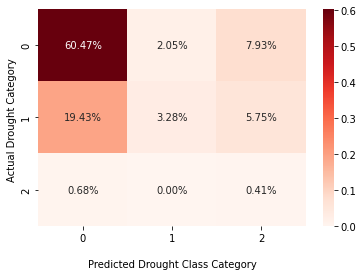

In [ ]:
cf_matrix1_ny = confusion_matrix(y_test1_ny, classes1_ny)

ax1 = sns.heatmap(cf_matrix1_ny/np.sum(cf_matrix1_ny), annot=True, 
            fmt='.2%', cmap='Reds')


ax1.set_xlabel('\nPredicted Drought Class Category')
ax1.set_ylabel('Actual Drought Category ')

ax1.xaxis.set_ticklabels(['0','1','2','3','4','5'])
ax1.yaxis.set_ticklabels(['0','1','2','3','4','5'])

plt.show()

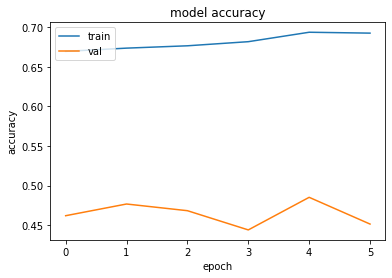

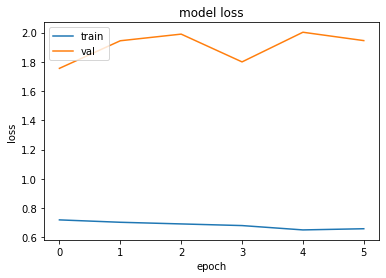

In [ ]:
history1_ny = new_model1_ny.fit(X_ny_sm, y_ny_df_sm, validation_data = (X_val1_ny_sm,y_val1_ny_sm),
               epochs=50,batch_size=64, callbacks =[cp1_ny,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history1_ny.history['categorical_accuracy'])
plt.plot(history1_ny.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1_ny.history['loss'])
plt.plot(history1_ny.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 2.objective : False Negative

In [ ]:
def build_model2_ny(hp):
  model2_ny = Sequential()
  model2_ny.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model2_ny.add(Dense(units=hp_units1, activation= LeakyReLU))
  model2_ny.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model2_ny.add(BatchNormalization())
  model2_ny.add(Dense(units=hp_units2, activation= LeakyReLU))
  model2_ny.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model2_ny.add(BatchNormalization())
  model2_ny.add(Dense(units=hp_units3, activation= LeakyReLU))
  model2_ny.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model2_ny.add(BatchNormalization())
  model2_ny.add(Dense(6, activation='softmax'))

  hp_optimizer_ny=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ny == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ny', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ny == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ny', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model2_ny.compile(
      optimizer= hp_optimizer_ny,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.FalseNegatives(name='false_negatives'),
               'categorical_accuracy']
  )
  return model2_ny

# HyperBand algorithm from keras tuner
tuner2_ny = kt.Hyperband(
    build_model2_ny,
    objective= kt.Objective('val_false_negatives', direction="min"),
    max_epochs=50,
    directory='newyork_dir2',
    project_name='new_york_2',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner2_ny.search(X_ny_sm, y_ny_df_sm, epochs=50, validation_data = (X_val1_ny_sm,y_val1_ny_sm),
             callbacks=[early_stopping_monitor])

In [ ]:
best_mlp_hyperparameters2_ny = tuner2_ny.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters2_ny.values

Best Hyper-parameters


{'units1': 288,
 'units2': 448,
 'units3': 352,
 'dropout_1': 0.0,
 'dropout_2': 0.0,
 'dropout_3': 0.1,
 'Optimizer': 'SGD',
 'learning_rate_ny': 0.001,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0046'}

In [ ]:
best_model2_ny = tuner2_ny.get_best_models()[0]
best_model2_ny.build(X_ny_sm.shape)
best_model2_ny.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (14733, 18)              72        
 ormalization)                                                   
                                                                 
 dense (Dense)               (14733, 288)              5472      
                                                                 
 dropout (Dropout)           (14733, 288)              0         
                                                                 
 batch_normalization_1 (Batc  (14733, 288)             1152      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (14733, 448)              129472    
                                                                 
 dropout_1 (Dropout)         (14733, 448)              0

In [ ]:
new_model2_ny = Sequential()
new_model2_ny.add(tf.keras.Input(shape=(18,)))
new_model2_ny.add(BatchNormalization())
new_model2_ny.add(Dense(288, activation = LeakyReLU))
new_model2_ny.add(BatchNormalization())
new_model2_ny.add(Dense(448, activation = LeakyReLU))
new_model2_ny.add(BatchNormalization())
new_model2_ny.add(Dense(352, activation = LeakyReLU))
new_model2_ny.add(Dropout(0.1))
new_model2_ny.add(BatchNormalization())
new_model2_ny.add((Dense(6, activation='softmax')))
new_model2_ny.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 18)               72        
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 288)               5472      
                                                                 
 batch_normalization_5 (Batc  (None, 288)              1152      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 448)               129472    
                                                                 
 batch_normalization_6 (Batc  (None, 448)              1792      
 hNormalization)                                                 
                                                      

In [ ]:
cp2_ny = ModelCheckpoint('new_model2_ny/', save_best_only=True)
opt2_ny = keras.optimizers.SGD(learning_rate=0.001)
new_model2_ny.compile(optimizer = opt2_ny, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model2_ny.fit(X_ny_sm, y_ny_df_sm, validation_data = (X_val1_ny_sm,y_val1_ny_sm),
               epochs=50,batch_size=64, callbacks =[cp2_ny,early_stopping_monitor])

Epoch 1/50
227/231 [============================>.] - ETA: 0s - loss: 1.7752 - categorical_accuracy: 0.3197

231/231 [==============================] - 7s 25ms/step - loss: 1.7743 - categorical_accuracy: 0.3200 - val_loss: 4.7877 - val_categorical_accuracy: 0.3333
Epoch 2/50
231/231 [==============================] - ETA: 0s - loss: 1.5049 - categorical_accuracy: 0.4523

231/231 [==============================] - 5s 23ms/step - loss: 1.5049 - categorical_accuracy: 0.4523 - val_loss: 1.8100 - val_categorical_accuracy: 0.3397
Epoch 3/50
231/231 [==============================] - 3s 13ms/step - loss: 1.3731 - categorical_accuracy: 0.5168 - val_loss: 1.8658 - val_categorical_accuracy: 0.3861
Epoch 4/50
231/231 [==============================] - 3s 13ms/step - loss: 1.2776 - categorical_accuracy: 0.5443 - val_loss: 1.9801 - val_categorical_accuracy: 0.3509
Epoch 5/50
231/231 [==============================] - 3s 14ms/step - loss: 1.2119 - categorical_accuracy: 0.5666 - val_loss: 1.8513 - val_categorical_accuracy: 0.3727
Epoch 6/50
231/231 [==============================] - 3s 14ms/step - loss: 1.1479 - categorical_accuracy: 0.5894 - val_loss: 1.9610 - val_categorical_accuracy: 0.3544
Epoch 7/50
231/231 [==============================] - 3s 15ms/step - loss: 1.0944 - categorical_accuracy: 0.6036 - val_loss: 1.8954 - val_categorical_accuracy: 0.3741


In [ ]:
test_predictions2_ny = new_model2_ny.predict(X_test1_ny)
test_predictions2_ny

23/23 [==============================] - 0s 6ms/step


array([[0.14703102, 0.65293634, 0.04074853, 0.06612013, 0.0703164 ,
        0.0228475 ],
       [0.2487796 , 0.54674464, 0.01385946, 0.06570951, 0.06526825,
        0.05963851],
       [0.5359155 , 0.24763899, 0.0557142 , 0.07440558, 0.0518214 ,
        0.03450433],
       ...,
       [0.17494404, 0.47122067, 0.12078495, 0.11667161, 0.04186445,
        0.07451424],
       [0.10896104, 0.4064809 , 0.24946028, 0.07035901, 0.08661942,
        0.07811932],
       [0.15760475, 0.18582998, 0.41913038, 0.08540249, 0.08528088,
        0.06675157]], dtype=float32)

In [ ]:
classes2_ny = np.argmax(test_predictions2_ny, axis=-1)
classes2_ny

array([1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 0, 2,
       2, 1, 1, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 0, 1, 1, 1, 0, 0,
       2, 2, 2, 1, 0, 2, 0, 2, 1, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 1, 1, 0,
       2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 1, 2, 1, 2, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 2, 1, 1, 0, 1,
       1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2,
       1, 1, 0, 0, 1, 1, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 2,
       2, 0, 0, 0, 1, 0, 2, 2, 0, 2, 1, 2, 2, 0, 2,

In [ ]:
classes2_ny =pd.DataFrame(classes2_ny, columns=['Test Predictions']) 
classes2_ny

Test Predictions
0                   1
1                   1
2                   0
3                   1
4                   0
..                ...
726                 1
727                 1
728                 1
729                 1
730                 2

[731 rows x 1 columns]

In [ ]:
classes2_ny = classes2_ny.values.ravel()

In [ ]:
result2_ny = pd.DataFrame({'Test Predictions':classes2_ny, 'Actuals':y_test1_ny})
result2_ny[0:31]

Test Predictions  Actuals
0                  1        0
1                  1        0
2                  0        0
3                  1        0
4                  0        0
5                  1        0
6                  0        0
7                  1        0
8                  0        0
9                  0        0
10                 0        0
11                 0        0
12                 0        0
13                 0        0
14                 0        0
15                 1        0
16                 0        0
17                 1        0
18                 0        0
19                 0        0
20                 0        0
21                 0        0
22                 1        0
23                 0        0
24                 2        0
25                 0        0
26                 1        0
27                 0        0
28                 1        0
29                 0        0
30                 0        0

######model 2 evaluation

In [ ]:
print(classification_report(y_test1_ny, classes2_ny))

              precision    recall  f1-score   support

           0       0.72      0.45      0.55       515
           1       0.25      0.30      0.27       208
           2       0.02      0.38      0.03         8

    accuracy                           0.40       731
   macro avg       0.33      0.37      0.29       731
weighted avg       0.58      0.40      0.47       731



In [ ]:
cf_matrix2_ny = confusion_matrix(y_test1_ny, classes2_ny)

ax2 = sns.heatmap(cf_matrix2_ny/np.sum(cf_matrix2_ny), annot=True, 
            fmt='.2%', cmap='Reds')


ax2.set_xlabel('\nPredicted Drought Class Category')
ax2.set_ylabel('Actual Drought Category ')

ax2.xaxis.set_ticklabels(['0','1','2','3','4','5'])
ax2.yaxis.set_ticklabels(['0','1','2','3','4','5'])

plt.show()

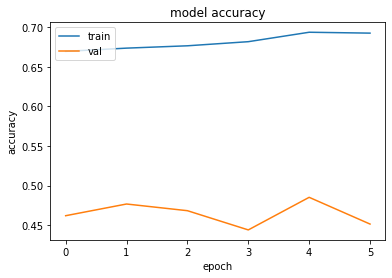

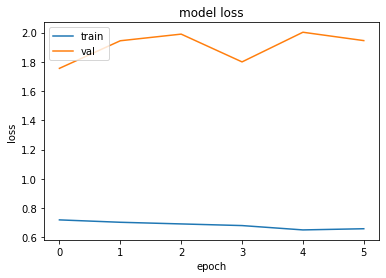

In [ ]:
history2_ny = new_model2_ny.fit(X_ny_sm, y_ny_df_sm, validation_data = (X_val1_ny_sm,y_val1_ny_sm),
               epochs=50,batch_size=64, callbacks =[cp2_ny,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history2_ny.history['categorical_accuracy'])
plt.plot(history2_ny.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2_ny.history['loss'])
plt.plot(history2_ny.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 3.objective : True Positive (5 layers)

In [ ]:
def build_model1_1ny(hp):
  model1_1ny = Sequential()
  model1_1ny.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  hp_units4 = hp.Int('units4', min_value=32, max_value=512, step=32)
  hp_units5 = hp.Int('units5', min_value=32, max_value=512, step=32)
  model1_1ny.add(Dense(units=hp_units1, activation= LeakyReLU))
  model1_1ny.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model1_1ny.add(BatchNormalization())
  model1_1ny.add(Dense(units=hp_units2, activation= LeakyReLU))
  model1_1ny.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model1_1ny.add(BatchNormalization())
  model1_1ny.add(Dense(units=hp_units3, activation= LeakyReLU))
  model1_1ny.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model1_1ny.add(BatchNormalization())
  model1_1ny.add(Dense(units=hp_units4, activation= LeakyReLU))
  model1_1ny.add(Dropout(hp.Choice('dropout_4', values=[0.0, 0.1, 0.2, 0.3])))
  model1_1ny.add(BatchNormalization())
  model1_1ny.add(Dense(units=hp_units5, activation= LeakyReLU))
  model1_1ny.add(Dropout(hp.Choice('dropout_5', values=[0.0, 0.1, 0.2, 0.3])))
  model1_1ny.add(BatchNormalization())
  model1_1ny.add(Dense(6, activation='softmax'))

  hp_optimizer_ny=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ny == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ny', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ny == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ny', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model1_1ny.compile(
      optimizer= hp_optimizer_ny,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model1_1ny

# HyperBand algorithm from keras tuner
tuner1_1ny = kt.Hyperband(
    build_model1_1ny,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs = 50,
    directory='newyork_dir_1',
    project_name='new_york1_1',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner1_1ny.search(X_ny_sm, y_ny_df_sm, epochs=50, validation_data = (X_val1_ny_sm,y_val1_ny_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 33s]
val_true_positives: 429.0

Best val_true_positives So Far: 533.0
Total elapsed time: 00h 44m 43s


In [ ]:
best_mlp_hyperparameters1_1ny = tuner1_1ny.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters1_1ny.values

Best Hyper-parameters


{'units1': 384,
 'units2': 224,
 'units3': 512,
 'units4': 288,
 'units5': 352,
 'dropout_1': 0.0,
 'dropout_2': 0.0,
 'dropout_3': 0.0,
 'dropout_4': 0.1,
 'dropout_5': 0.0,
 'Optimizer': 'SGD',
 'learning_rate_ny': 0.1,
 'tuner/epochs': 6,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [ ]:
best_model1_1ny = tuner1_1ny.get_best_models()[0]
best_model1_1ny.build(X_ny_sm.shape)
best_model1_1ny.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (14733, 18)              72        
 ormalization)                                                   
                                                                 
 dense (Dense)               (14733, 384)              7296      
                                                                 
 dropout (Dropout)           (14733, 384)              0         
                                                                 
 batch_normalization_1 (Batc  (14733, 384)             1536      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (14733, 224)              86240     
                                                                 
 dropout_1 (Dropout)         (14733, 224)              0

In [ ]:
new_model1_1ny = Sequential()
new_model1_1ny.add(tf.keras.Input(shape=(18,)))
new_model1_1ny.add(BatchNormalization())
new_model1_1ny.add(Dense(384, activation = LeakyReLU))
new_model1_1ny.add(BatchNormalization())
new_model1_1ny.add(Dense(224, activation = LeakyReLU))
new_model1_1ny.add(BatchNormalization())
new_model1_1ny.add(Dense(512, activation = LeakyReLU))
new_model1_1ny.add(BatchNormalization())
new_model1_1ny.add(Dense(288, activation = LeakyReLU))
new_model1_1ny.add(Dropout(0.1))
new_model1_1ny.add(BatchNormalization())
new_model1_1ny.add(Dense(352, activation = LeakyReLU))
new_model1_1ny.add(BatchNormalization())
new_model1_1ny.add((Dense(6, activation='softmax')))
new_model1_1ny.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 18)               72        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 384)               7296      
                                                                 
 batch_normalization_7 (Batc  (None, 384)              1536      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 224)               86240     
                                                                 
 batch_normalization_8 (Batc  (None, 224)              896       
 hNormalization)                                                 
                                                      

In [ ]:
cp1_1ny = ModelCheckpoint('new_model1_1ny/', save_best_only=True)
opt1_1ny = keras.optimizers.SGD(learning_rate=0.1)
new_model1_1ny.compile(optimizer = opt1_1ny, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)

new_model1_1ny.fit(X_ny_sm, y_ny_df_sm, validation_data = (X_val1_ny_sm,y_val1_ny_sm),
               epochs=100,batch_size=64, callbacks =[cp1_1ny,early_stopping_monitor])

Epoch 1/100
231/231 [==============================] - ETA: 0s - loss: 1.2156 - categorical_accuracy: 0.4961

231/231 [==============================] - 10s 35ms/step - loss: 1.2156 - categorical_accuracy: 0.4961 - val_loss: 5.2203 - val_categorical_accuracy: 0.3376
Epoch 2/100
229/231 [============================>.] - ETA: 0s - loss: 0.9161 - categorical_accuracy: 0.5779

231/231 [==============================] - 6s 28ms/step - loss: 0.9156 - categorical_accuracy: 0.5783 - val_loss: 2.4508 - val_categorical_accuracy: 0.3826
Epoch 3/100
231/231 [==============================] - 3s 14ms/step - loss: 0.8640 - categorical_accuracy: 0.5989 - val_loss: 4.3340 - val_categorical_accuracy: 0.3143
Epoch 4/100
231/231 [==============================] - 3s 15ms/step - loss: 0.7981 - categorical_accuracy: 0.6308 - val_loss: 2.7202 - val_categorical_accuracy: 0.3720
Epoch 5/100
231/231 [==============================] - 3s 15ms/step - loss: 0.7547 - categorical_accuracy: 0.6529 - val_loss: 4.1895 - val_categorical_accuracy: 0.2862
Epoch 6/100
231/231 [==============================] - 3s 15ms/step - loss: 0.7464 - categorical_accuracy: 0.6576 - val_loss: 4.2014 - val_categorical_accuracy: 0.3565
Epoch 7/100
231/231 [==============================] - 3s 15ms/step - loss: 0.7056 - categorical_accuracy: 0.6747 - val_loss: 3.1804 - val_categorical_accuracy: 0.3579
Epoc

In [ ]:
test_predictions1_1ny = new_model1_1ny.predict(X_test1_ny)
test_predictions1_1ny

23/23 [==============================] - 0s 4ms/step


array([[4.7491025e-02, 9.5118654e-01, 7.3595636e-04, 2.5646298e-04,
        1.9635780e-04, 1.3365406e-04],
       [9.9255872e-01, 7.4023935e-03, 1.0332090e-05, 7.2469047e-06,
        4.8089523e-06, 1.6599410e-05],
       [9.9931401e-01, 6.8349869e-04, 1.2487439e-07, 6.0159158e-07,
        1.4066394e-07, 1.6020564e-06],
       ...,
       [3.4748811e-01, 6.4224583e-01, 9.8857507e-03, 9.6083262e-05,
        4.5396344e-05, 2.3882951e-04],
       [1.5276846e-01, 7.8428072e-01, 6.2171631e-02, 2.0826377e-04,
        1.0938053e-04, 4.6150965e-04],
       [3.8582134e-01, 5.9506923e-01, 1.8781275e-02, 3.9312319e-05,
        2.0456743e-04, 8.4200867e-05]], dtype=float32)

In [ ]:
classes1_1ny = np.argmax(test_predictions1_1ny, axis=-1)
classes1_1ny

array([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       2, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1,
       2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 2, 1, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2,
       2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2,

In [ ]:
classes1_1ny =pd.DataFrame(classes1_1ny, columns=['Test Predictions']) 
classes1_1ny

Test Predictions
0                   1
1                   0
2                   0
3                   1
4                   0
..                ...
726                 0
727                 2
728                 1
729                 1
730                 1

[731 rows x 1 columns]

In [ ]:
classes1_1ny = classes1_1ny.values.ravel()

In [ ]:
result1_1ny = pd.DataFrame({'Test Predictions':classes1_1ny, 'Actuals':y_test1_ny})
result1_1ny[0:31]

Test Predictions  Actuals
0                  1        0
1                  0        0
2                  0        0
3                  1        0
4                  0        0
5                  1        0
6                  0        0
7                  1        0
8                  0        0
9                  0        0
10                 0        0
11                 0        0
12                 0        0
13                 0        0
14                 0        0
15                 1        0
16                 0        0
17                 0        0
18                 0        0
19                 0        0
20                 0        0
21                 0        0
22                 1        0
23                 0        0
24                 0        0
25                 0        0
26                 1        0
27                 0        0
28                 0        0
29                 0        0
30                 0        0

######model 3 evaluation

In [ ]:
print(classification_report(y_test1_ny, classes1_1ny))

              precision    recall  f1-score   support

           0       0.76      0.47      0.58       515
           1       0.35      0.60      0.44       208
           2       0.02      0.12      0.03         8

    accuracy                           0.50       731
   macro avg       0.38      0.40      0.35       731
weighted avg       0.64      0.50      0.54       731



In [ ]:
cf_matrix1_1ny = confusion_matrix(y_test1_ny, classes1_1ny)

ax1_1 = sns.heatmap(cf_matrix1_1ny/np.sum(cf_matrix1_1ny), annot=True, 
            fmt='.2%', cmap='Reds')


ax1_1.set_xlabel('\nPredicted Drought Class Category')
ax1_1.set_ylabel('Actual Drought Category ')

ax1_1.xaxis.set_ticklabels(['0','1','2','3','4','5'])
ax1_1.yaxis.set_ticklabels(['0','1','2','3','4','5'])

plt.show()

In [ ]:
history1_1ny = new_model1_ny.fit(X_ny_sm, y_ny_df_sm, validation_data = (X_val1_ny_sm,y_val1_ny_sm),
               epochs=100,batch_size=64, callbacks =[cp1_1ny,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history1_1ny.history['categorical_accuracy'])
plt.plot(history1_1ny.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1_1ny.history['loss'])
plt.plot(history1_1ny.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 4.objective : False Negative (5 layers)

In [ ]:
def build_model2_1ny(hp):
  model2_1ny = Sequential()
  model2_1ny.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  hp_units4 = hp.Int('units4', min_value=32, max_value=512, step=32)
  hp_units5 = hp.Int('units5', min_value=32, max_value=512, step=32)
  model2_1ny.add(Dense(units=hp_units1, activation= LeakyReLU))
  model2_1ny.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model2_1ny.add(BatchNormalization())
  model2_1ny.add(Dense(units=hp_units2, activation= LeakyReLU))
  model2_1ny.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model2_1ny.add(BatchNormalization())
  model2_1ny.add(Dense(units=hp_units3, activation= LeakyReLU))
  model2_1ny.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model2_1ny.add(BatchNormalization())
  model2_1ny.add(Dense(units=hp_units4, activation= LeakyReLU))
  model2_1ny.add(Dropout(hp.Choice('dropout_4', values=[0.0, 0.1, 0.2, 0.3])))
  model2_1ny.add(BatchNormalization())
  model2_1ny.add(Dense(units=hp_units5, activation= LeakyReLU))
  model2_1ny.add(Dropout(hp.Choice('dropout_5', values=[0.0, 0.1, 0.2, 0.3])))
  model2_1ny.add(BatchNormalization())
  model2_1ny.add(Dense(6, activation='softmax'))

  hp_optimizer_ny=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ny == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ny', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ny == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ny', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model2_1ny.compile(
      optimizer= hp_optimizer_ny,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.FalseNegatives(name='false_negatives'),
               'categorical_accuracy']
  )
  return model2_1ny

# HyperBand algorithm from keras tuner
tuner2_1ny = kt.Hyperband(
    build_model2_1ny,
    objective= kt.Objective('val_false_negatives', direction="min"),
    max_epochs = 50,
    directory='newyork_dir_2',
    project_name='new_york2_1',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=10)
tuner2_1ny.search(X_ny_sm, y_ny_df_sm, epochs=50, validation_data = (X_val1_ny_sm,y_val1_ny_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 35s]
val_false_negatives: 949.0

Best val_false_negatives So Far: 852.0
Total elapsed time: 00h 55m 27s


In [ ]:
best_mlp_hyperparameters2_1ny = tuner2_1ny.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters2_1ny.values

Best Hyper-parameters


{'units1': 288,
 'units2': 448,
 'units3': 96,
 'units4': 480,
 'units5': 352,
 'dropout_1': 0.0,
 'dropout_2': 0.0,
 'dropout_3': 0.0,
 'dropout_4': 0.0,
 'dropout_5': 0.3,
 'Optimizer': 'SGD',
 'learning_rate_ny': 0.1,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0046'}

In [ ]:
best_model2_1ny = tuner2_1ny.get_best_models()[0]
best_model2_1ny.build(X_ny_sm.shape)
best_model2_1ny.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (14733, 18)              72        
 ormalization)                                                   
                                                                 
 dense (Dense)               (14733, 288)              5472      
                                                                 
 dropout (Dropout)           (14733, 288)              0         
                                                                 
 batch_normalization_1 (Batc  (14733, 288)             1152      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (14733, 448)              129472    
                                                                 
 dropout_1 (Dropout)         (14733, 448)              0

In [ ]:
new_model2_1ny = Sequential()
new_model2_1ny.add(tf.keras.Input(shape=(18,)))
new_model2_1ny.add(BatchNormalization())
new_model2_1ny.add(Dense(288, activation = LeakyReLU))
new_model2_1ny.add(BatchNormalization())
new_model2_1ny.add(Dense(448, activation = LeakyReLU))
new_model2_1ny.add(BatchNormalization())
new_model2_1ny.add(Dense(96, activation = LeakyReLU))
new_model2_1ny.add(BatchNormalization())
new_model2_1ny.add(Dense(480, activation = LeakyReLU))
new_model2_1ny.add(BatchNormalization())
new_model2_1ny.add(Dense(352, activation = LeakyReLU))
new_model2_1ny.add(Dropout(0.3))
new_model2_1ny.add(BatchNormalization())
new_model2_1ny.add((Dense(6, activation='softmax')))
new_model2_1ny.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 18)               72        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 288)               5472      
                                                                 
 batch_normalization_7 (Batc  (None, 288)              1152      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 448)               129472    
                                                                 
 batch_normalization_8 (Batc  (None, 448)              1792      
 hNormalization)                                                 
                                                      

In [ ]:
cp2_1ny = ModelCheckpoint('new_model2_1ny/', save_best_only=True)
opt2_1ny = keras.optimizers.SGD(learning_rate=0.1)
new_model2_1ny.compile(optimizer = opt2_1ny, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)

new_model2_1ny.fit(X_ny_sm, y_ny_df_sm, validation_data = (X_val1_ny_sm,y_val1_ny_sm),
               epochs=100,batch_size=64, callbacks =[cp2_1ny,early_stopping_monitor])

Epoch 1/100
230/231 [============================>.] - ETA: 0s - loss: 1.2019 - categorical_accuracy: 0.4978

231/231 [==============================] - 8s 27ms/step - loss: 1.2018 - categorical_accuracy: 0.4978 - val_loss: 4.0754 - val_categorical_accuracy: 0.3291
Epoch 2/100
229/231 [============================>.] - ETA: 0s - loss: 0.9389 - categorical_accuracy: 0.5612

231/231 [==============================] - 6s 26ms/step - loss: 0.9381 - categorical_accuracy: 0.5616 - val_loss: 3.1097 - val_categorical_accuracy: 0.2475
Epoch 3/100
231/231 [==============================] - 3s 13ms/step - loss: 0.8686 - categorical_accuracy: 0.5970 - val_loss: 5.2037 - val_categorical_accuracy: 0.3094
Epoch 4/100
228/231 [============================>.] - ETA: 0s - loss: 0.8333 - categorical_accuracy: 0.6114

231/231 [==============================] - 6s 25ms/step - loss: 0.8316 - categorical_accuracy: 0.6120 - val_loss: 2.5453 - val_categorical_accuracy: 0.4128
Epoch 5/100
231/231 [==============================] - 3s 14ms/step - loss: 0.7822 - categorical_accuracy: 0.6342 - val_loss: 3.2100 - val_categorical_accuracy: 0.2968
Epoch 6/100
231/231 [==============================] - 3s 14ms/step - loss: 0.7550 - categorical_accuracy: 0.6478 - val_loss: 3.6026 - val_categorical_accuracy: 0.2806
Epoch 7/100
231/231 [==============================] - 3s 14ms/step - loss: 0.7232 - categorical_accuracy: 0.6608 - val_loss: 3.5472 - val_categorical_accuracy: 0.4128
Epoch 8/100
231/231 [==============================] - 3s 13ms/step - loss: 0.7108 - categorical_accuracy: 0.6663 - val_loss: 5.8562 - val_categorical_accuracy: 0.3383
Epoch 9/100
231/231 [==============================] - 3s 13ms/step - loss: 0.6853 - categorical_accuracy: 0.6775 - val_loss: 4.1505 - val_categorical_accuracy: 0.3727
Epoc

In [ ]:
test_predictions2_1ny = new_model2_1ny.predict(X_test1_ny)
test_predictions2_1ny

23/23 [==============================] - 0s 5ms/step


array([[8.6906110e-04, 9.4115437e-04, 9.9817771e-01, 1.4229606e-06,
        7.6956367e-06, 2.8829397e-06],
       [5.3197653e-03, 2.0807295e-03, 9.9258381e-01, 3.2773496e-06,
        7.2229454e-06, 5.1624152e-06],
       [2.6181862e-01, 1.6215093e-01, 5.7580024e-01, 1.0838406e-04,
        7.7123063e-05, 4.4667002e-05],
       ...,
       [7.3299045e-05, 3.5114637e-05, 9.9989104e-01, 1.2492242e-07,
        1.7764204e-07, 2.0837497e-07],
       [9.2780328e-06, 6.6603461e-06, 9.9998379e-01, 4.4185597e-08,
        6.1758527e-08, 9.6847117e-08],
       [5.7994635e-03, 1.2751053e-03, 9.9291718e-01, 2.7102615e-06,
        2.7582291e-06, 2.8745806e-06]], dtype=float32)

In [ ]:
classes2_1ny = np.argmax(test_predictions2_1ny, axis=-1)
classes2_1ny

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0,
       1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,

In [ ]:
classes2_1ny =pd.DataFrame(classes2_1ny, columns=['Test Predictions']) 
classes2_1ny

Test Predictions
0                   2
1                   2
2                   2
3                   2
4                   2
..                ...
726                 2
727                 2
728                 2
729                 2
730                 2

[731 rows x 1 columns]

In [ ]:
classes2_1ny = classes2_1ny.values.ravel()

In [ ]:
result2_1ny = pd.DataFrame({'Test Predictions':classes2_1ny, 'Actuals':y_test1_ny})
result2_1ny[0:31]

Test Predictions  Actuals
0                  2        0
1                  2        0
2                  2        0
3                  2        0
4                  2        0
5                  2        0
6                  2        0
7                  2        0
8                  2        0
9                  2        0
10                 2        0
11                 2        0
12                 0        0
13                 2        0
14                 2        0
15                 2        0
16                 2        0
17                 2        0
18                 2        0
19                 2        0
20                 2        0
21                 2        0
22                 2        0
23                 0        0
24                 2        0
25                 2        0
26                 2        0
27                 2        0
28                 2        0
29                 2        0
30                 2        0

######model 4 evaluation

In [ ]:
print(classification_report(y_test1_ny, classes2_1ny))

              precision    recall  f1-score   support

           0       0.63      0.55      0.59       515
           1       0.38      0.04      0.07       208
           2       0.03      0.88      0.05         8

    accuracy                           0.41       731
   macro avg       0.35      0.49      0.24       731
weighted avg       0.55      0.41      0.43       731



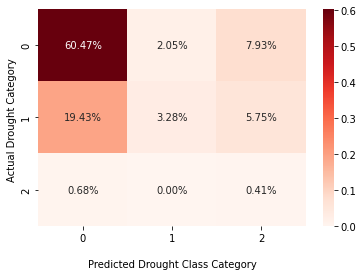

In [ ]:
cf_matrix2_1ny = confusion_matrix(y_test1_ny, classes2_1ny)

ax2_1 = sns.heatmap(cf_matrix2_1ny/np.sum(cf_matrix2_1ny), annot=True, 
            fmt='.2%', cmap='Reds')


ax2_1.set_xlabel('\nPredicted Drought Class Category')
ax2_1.set_ylabel('Actual Drought Category ')

ax2_1.xaxis.set_ticklabels(['0','1','2','3','4','5'])
ax2_1.yaxis.set_ticklabels(['0','1','2','3','4','5'])

plt.show()

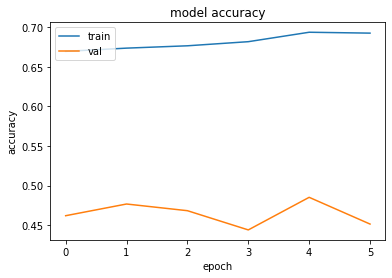

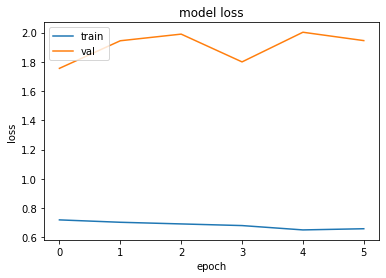

In [ ]:
history2_1ny = new_model1_ny.fit(X_ny_sm, y_ny_df_sm, validation_data = (X_val1_ny_sm,y_val1_ny_sm),
               epochs=100,batch_size=64, callbacks =[cp2_1ny,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history2_1ny.history['categorical_accuracy'])
plt.plot(history2_1ny.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2_1ny.history['loss'])
plt.plot(history2_1ny.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###MLP model with weather and soil data (without date variable) REGRESSION

####preprocessing data

In [ ]:
score_ny = train_ny['score']
score_val_ny = val_ny['score']
score_test_ny = test_ny['score']

In [ ]:
score_arr_ny = score_ny.copy()
score_val_arr_ny = score_val_ny.copy()
score_test_arr_ny = score_test_ny.copy()

In [ ]:
score_arr_ny = score_arr_ny.to_numpy()
score_val_arr_ny = score_val_arr_ny.to_numpy()
score_test_arr_ny = score_test_arr_ny.to_numpy()

In [ ]:
score_arr_ny

array([0., 0., 0., ..., 2., 2., 2.])

In [ ]:
score_arr_ny =pd.DataFrame(score_arr_ny, columns=['Score']) 
score_arr_ny

Score
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
...     ...
6205    2.0
6206    2.0
6207    2.0
6208    2.0
6209    2.0

[6210 rows x 1 columns]

In [ ]:
score_val_arr_ny =pd.DataFrame(score_val_arr_ny, columns=['Score']) 
score_val_arr_ny

Score
0    2.0000
1    2.0000
2    2.0000
3    2.0000
4    2.0000
..      ...
725  0.3505
726  0.3505
727  0.3505
728  0.3505
729  0.3505

[730 rows x 1 columns]

In [ ]:
score_test_arr_ny =pd.DataFrame(score_test_arr_ny, columns=['Score']) 
score_test_arr_ny

Score
0    0.250000
1    0.214286
2    0.178571
3    0.142857
4    0.107143
..        ...
726  0.943143
727  0.825171
728  0.707200
729  0.707200
730  0.707200

[731 rows x 1 columns]

In [ ]:
new_york_train = train_ny.copy()
new_york_val = val_ny.copy()
new_york_test = test_ny.copy()

In [ ]:
X1 = new_york_train.drop(columns=['fips','date','score'])
X_val = new_york_val.drop(columns=['fips','date','score'])
X_test = new_york_test.drop(columns=['fips','date','score'])

In [ ]:
X1_ny, y1_ny = X1, score_arr_ny
X_val_ny, y_val_ny = X_val, score_val_arr_ny
X_test_ny, y_test_ny = X_test, score_test_arr_ny
X1_ny.shape, y1_ny.shape, X_val_ny.shape, y_val_ny.shape, X_test_ny.shape, y_test_ny.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 1))

####build the model

In [ ]:
new_model_reg_ny1 = Sequential()
new_model_reg_ny1.add(tf.keras.Input(shape=(49,)))
new_model_reg_ny1.add(BatchNormalization())
new_model_reg_ny1.add(Dense(128, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_ny1.add(BatchNormalization())
new_model_reg_ny1.add(Dense(64, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_ny1.add(BatchNormalization())
new_model_reg_ny1.add((Dense(1, activation='linear')))
new_model_reg_ny1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_21 (Dense)            (None, 128)               6400      
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                      

In [ ]:
opt_reg_ny1 = keras.optimizers.Adam(learning_rate=0.001)
new_model_reg_ny1.compile(optimizer = opt_reg_ny1, loss =MeanSquaredError(), metrics =[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_reg_ny1.fit(X1_ny, y1_ny, validation_data = (X_val_ny,y_val_ny),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor])

Epoch 1/50
98/98 [==============================] - 3s 10ms/step - loss: 0.2846 - root_mean_squared_error: 0.5334 - val_loss: 1896.3281 - val_root_mean_squared_error: 43.5468
Epoch 2/50
98/98 [==============================] - 1s 7ms/step - loss: 0.2263 - root_mean_squared_error: 0.4757 - val_loss: 894.3450 - val_root_mean_squared_error: 29.9056
Epoch 3/50
98/98 [==============================] - 1s 7ms/step - loss: 0.2103 - root_mean_squared_error: 0.4586 - val_loss: 342.9627 - val_root_mean_squared_error: 18.5193
Epoch 4/50
98/98 [==============================] - 1s 6ms/step - loss: 0.2088 - root_mean_squared_error: 0.4569 - val_loss: 88.7518 - val_root_mean_squared_error: 9.4208
Epoch 5/50
98/98 [==============================] - 1s 7ms/step - loss: 0.2054 - root_mean_squared_error: 0.4532 - val_loss: 48.4694 - val_root_mean_squared_error: 6.9620
Epoch 6/50
98/98 [==============================] - 1s 7ms/step - loss: 0.2050 - root_mean_squared_error: 0.4528 - val_loss: 8.4320 - val

In [ ]:
test_predictions_reg_ny1 = new_model_reg_ny1.predict(X_test_ny).flatten()
test_predictions_reg_ny1

23/23 [==============================] - 0s 2ms/step


array([ 3.88903052e-01,  4.15305883e-01,  2.58240819e-01,  4.42212403e-01,
        4.16929841e-01,  3.88570666e-01,  4.46269512e-01,  3.37497115e-01,
        2.42695227e-01,  5.39247930e-01,  1.96102440e-01,  3.41672838e-01,
        4.53740239e-01,  3.41188014e-01,  3.32921773e-01,  3.72066736e-01,
        4.06396449e-01,  4.07990158e-01,  4.63248014e-01,  1.28324509e-01,
        1.11351728e-01,  4.64982986e-01,  4.24051881e-01, -5.88577390e-02,
        3.64798337e-01,  3.93505633e-01,  3.49543273e-01,  2.80457795e-01,
        3.28624755e-01,  3.45518410e-01,  2.12185204e-01,  3.89741361e-01,
        4.38249290e-01,  3.77965569e-01,  3.79459023e-01,  4.27117079e-01,
        5.18288195e-01,  3.03640544e-01,  3.48243177e-01,  4.84690487e-01,
        5.72097123e-01,  4.63179350e-01,  3.91019762e-01,  3.60377550e-01,
        3.78902674e-01,  3.56669784e-01,  3.78766239e-01,  2.93728501e-01,
        3.22251260e-01,  4.61044252e-01,  5.54499805e-01,  4.79726732e-01,
        4.64555681e-01,  

In [ ]:
test_predictions_reg_ny1 =pd.DataFrame(test_predictions_reg_ny1, columns=['Test Predictions']) 
test_predictions_reg_ny1

Test Predictions
0            0.388903
1            0.415306
2            0.258241
3            0.442212
4            0.416930
..                ...
726          0.389600
727          0.465931
728          0.546438
729          0.472763
730          0.405878

[731 rows x 1 columns]

In [ ]:
test_predictions_reg_ny1 = test_predictions_reg_ny1.values.ravel()
y_test_ny = y_test_ny.values.ravel()

In [ ]:
test_results_reg_1 = pd.DataFrame(data={'predictions':test_predictions_reg_ny1, 'actuals':y_test_ny})
test_results_reg_1

predictions   actuals
0       0.388903  0.250000
1       0.415306  0.214286
2       0.258241  0.178571
3       0.442212  0.142857
4       0.416930  0.107143
..           ...       ...
726     0.389600  0.943143
727     0.465931  0.825171
728     0.546438  0.707200
729     0.472763  0.707200
730     0.405878  0.707200

[731 rows x 2 columns]

In [ ]:
test_results_reg_1[500:550]

predictions   actuals
500     0.151460  0.002786
501     0.376643  0.003714
502     0.292735  0.004643
503     0.159671  0.005571
504     0.168728  0.006500
505     0.345339  0.006500
506     0.393450  0.006500
507     0.401095  0.006500
508     0.313943  0.006500
509     0.329387  0.006500
510     0.246798  0.006500
511    -0.044134  0.006500
512     0.021114  0.066729
513     0.047225  0.126957
514    -0.193793  0.187186
515     0.157791  0.247414
516     0.430018  0.307643
517     0.315655  0.367871
518     0.113498  0.428100
519     0.065934  0.509800
520     0.150923  0.591500
521     0.099705  0.673200
522     0.211968  0.754900
523     0.211197  0.836600
524     0.278474  0.918300
525     0.184474  1.000000
526     0.152679  1.000000
527     0.115052  1.000000
528     0.223219  1.000000
529     0.232935  1.000000
530     0.258224  1.000000
531     0.345481  1.000000
532     0.576679  1.000000
533     0.416158  1.000000
534     0.455091  1.000000
535     0.056280  1.000000
536     0.206301  1.000000
537     0.121371  1.000000
538     0.086033  1.000000
539     0.149260  1.000000
540     0.216309  1.000000
541     0.273570  1.000000
542     0.265341  1.000000
543     0.110284  1.000000
544    -0.029309  1.000000
545    -0.126054  1.000000
546     0.111364  1.000000
547    -0.050181  1.049771
548     0.168572  1.099543
549     0.055529  1.149314

####model evaluation

In [ ]:
new_model_reg_ny1.evaluate(X1_ny,y1_ny)

195/195 [==============================] - 1s 3ms/step - loss: 0.1801 - root_mean_squared_error: 0.4244


[0.1800958514213562, 0.4243770241737366]

In [ ]:
new_model_reg_ny1.evaluate(X_test_ny,y_test_ny)

23/23 [==============================] - 0s 3ms/step - loss: 0.3138 - root_mean_squared_error: 0.5602


[0.31377220153808594, 0.5601537227630615]

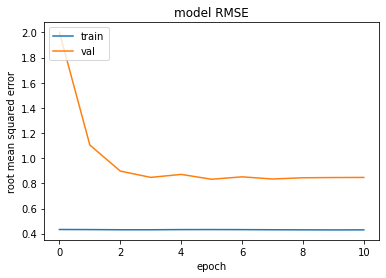

In [ ]:
history_reg_1 = new_model_reg_ny1.fit(X1_ny, y1_ny, validation_data = (X_val_ny,y_val_ny),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor], verbose=False)

# summarize history for accuracy
plt.plot(history_reg_1.history['root_mean_squared_error'])
plt.plot(history_reg_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_results_reg_1.predictions[test_results_reg_1.predictions <0.5] = 0
test_results_reg_1.predictions[(test_results_reg_1.predictions >=0.5)&(test_results_reg_1.predictions<1.5)] = 1
test_results_reg_1.predictions[(test_results_reg_1.predictions >=1.5)&(test_results_reg_1.predictions<2.5)] = 2
test_results_reg_1.predictions[(test_results_reg_1.predictions >=2.5)&(test_results_reg_1.predictions<3.5)] = 3
test_results_reg_1.predictions[(test_results_reg_1.predictions >=3.5)&(test_results_reg_1.predictions<4.5)] = 4
test_results_reg_1.predictions[(test_results_reg_1.predictions >=4.5)&(test_results_reg_1.predictions<5.5)] = 5
test_results_reg_1.actuals[test_results_reg_1.actuals <0.5] = 0
test_results_reg_1.actuals[(test_results_reg_1.actuals >=0.5)&(test_results_reg_1.actuals<1.5)] = 1
test_results_reg_1.actuals[(test_results_reg_1.actuals >=1.5)&(test_results_reg_1.actuals<2.5)] = 2
test_results_reg_1.actuals[(test_results_reg_1.actuals >=2.5)&(test_results_reg_1.actuals<3.5)] = 3
test_results_reg_1.actuals[(test_results_reg_1.actuals >=3.5)&(test_results_reg_1.actuals<4.5)] = 4
test_results_reg_1.actuals[(test_results_reg_1.actuals >=4.5)&(test_results_reg_1.actuals<5.5)] = 5
test_results_reg_1

predictions  actuals
0            0.0      0.0
1            0.0      0.0
2            0.0      0.0
3            0.0      0.0
4            0.0      0.0
..           ...      ...
726          0.0      1.0
727          0.0      1.0
728          1.0      1.0
729          0.0      1.0
730          0.0      1.0

[731 rows x 2 columns]

In [ ]:
test_results_reg_1[200:250]

predictions  actuals
200          0.0      0.0
201          0.0      0.0
202          0.0      0.0
203          0.0      0.0
204          0.0      0.0
205          0.0      0.0
206          0.0      0.0
207          0.0      0.0
208          0.0      0.0
209          0.0      0.0
210          0.0      0.0
211          0.0      0.0
212          0.0      0.0
213          1.0      0.0
214          0.0      0.0
215          0.0      0.0
216          0.0      0.0
217          0.0      0.0
218          0.0      0.0
219          0.0      0.0
220          0.0      0.0
221          0.0      0.0
222          0.0      0.0
223          0.0      0.0
224          0.0      0.0
225          0.0      0.0
226          0.0      0.0
227          0.0      0.0
228          0.0      0.0
229          0.0      0.0
230          0.0      0.0
231          0.0      0.0
232          0.0      0.0
233          0.0      0.0
234          0.0      0.0
235          0.0      0.0
236          0.0      0.0
237          0.0      1.0
238          0.0      1.0
239          0.0      1.0
240          0.0      1.0
241          0.0      0.0
242          0.0      0.0
243          0.0      0.0
244          0.0      0.0
245          0.0      0.0
246          0.0      0.0
247          0.0      0.0
248          0.0      0.0
249          0.0      0.0

In [ ]:
print(classification_report(test_results_reg_1['actuals'], test_results_reg_1['predictions']))

              precision    recall  f1-score   support

         0.0       0.70      0.93      0.80       515
         1.0       0.19      0.04      0.07       208
         2.0       0.00      0.00      0.00         8

    accuracy                           0.67       731
   macro avg       0.30      0.32      0.29       731
weighted avg       0.55      0.67      0.58       731



###MLP model with weather and soil data (without date variable)

####preprocessing data

In [ ]:
score_ny = train_ny['score']
score_val_ny = val_ny['score']
score_test_ny = test_ny['score']

In [ ]:
score_arr_ny = score_ny.copy()
score_val_arr_ny = score_val_ny.copy()
score_test_arr_ny = score_test_ny.copy()

In [ ]:
score_arr_ny = score_arr_ny.to_numpy()
score_val_arr_ny = score_val_arr_ny.to_numpy()
score_test_arr_ny = score_test_arr_ny.to_numpy()

In [ ]:
score_arr_ny

array([0., 0., 0., ..., 2., 2., 2.])

In [ ]:
score_arr_ny =pd.DataFrame(score_arr_ny, columns=['Score']) 
score_arr_ny

Score
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
...     ...
6205    2.0
6206    2.0
6207    2.0
6208    2.0
6209    2.0

[6210 rows x 1 columns]

In [ ]:
score_val_arr_ny =pd.DataFrame(score_val_arr_ny, columns=['Score']) 
score_val_arr_ny

Score
0      2.0
1      2.0
2      2.0
3      2.0
4      2.0
..     ...
725    0.0
726    0.0
727    0.0
728    0.0
729    0.0

[730 rows x 1 columns]

In [ ]:
#score_arr_ny = to_categorical(score_arr_ny,num_classes=6)
#score_val_arr_ny = to_categorical(score_val_arr_ny,num_classes=6)
score_test_arr_ny = to_categorical(score_test_arr_ny,num_classes=6)

In [ ]:
new_york_train = train_ny.copy()
new_york_val = val_ny.copy()
new_york_test = test_ny.copy()

In [ ]:
X1 = new_york_train.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_val = new_york_val.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_test = new_york_test.drop(columns=['fips','date','score','tahun','bulan','tanggal'])

In [ ]:
X1_ny, y1_ny = X1, score_arr_ny
X_val_ny, y_val_ny = X_val, score_val_arr_ny
X_test_ny, y_test_ny = X_test, score_test_arr_ny
X1_ny.shape, y1_ny.shape, X_val_ny.shape, y_val_ny.shape, X_test_ny.shape, y_test_ny.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 6))

In [ ]:
from imblearn.under_sampling import TomekLinks

tk= TomekLinks()
X1_ny2, y1_ny2= tk.fit_resample(X1_ny, y1_ny)
X_val_ny2, y_val_ny2= tk.fit_resample(X_val_ny, y_val_ny)

In [ ]:
X1_ny2, y1_ny2 = X1_ny2, to_categorical(y1_ny2,
                                                               num_classes=6)
X_val_ny2, y_val_ny2 = X_val_ny2, to_categorical(y_val_ny2,
                                                                     num_classes=6)

In [ ]:
from imblearn.over_sampling import SMOTE
sm1 = SMOTE(sampling_strategy={0:4911,1:4911,2:4911},random_state=42,k_neighbors=5)
sm2 = SMOTE(sampling_strategy={0:474,1:474,2:474},random_state=42,k_neighbors=5)
X1_ny_sm, y1_ny_df_sm = sm1.fit_resample(X1_ny, score_arr_ny.values.ravel())
X_val_ny_sm, y_val_ny_sm = sm2.fit_resample(X_val_ny,y_val_ny.values.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X1_ny_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y1_ny_df_sm.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_val_ny_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_val_ny_sm.shape))

After OverSampling, the shape of train_X: (14733, 49)
After OverSampling, the shape of train_y: (14733,) 

After OverSampling, the shape of train_X: (1422, 49)
After OverSampling, the shape of train_y: (1422,) 



In [ ]:
X1_ny_sm, y1_ny_df_sm = X1_ny_sm, to_categorical(y1_ny_df_sm,
                                                               num_classes=6)
X_val_ny_sm, y_val_ny_sm = X_val_ny_sm, to_categorical(y_val_ny_sm,
                                                                     num_classes=6)

In [ ]:
y1_ny_df_sm

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

####building the models using keras tuner

##### 1.objective : True Positive

In [ ]:
def build_model1(hp):
  model1 = Sequential()
  model1.add(BatchNormalization())
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model1.add(Dense(units=hp_units1, activation= LeakyReLU))
  model1.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model1.add(BatchNormalization())
  model1.add(Dense(units=hp_units2, activation= LeakyReLU))
  model1.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model1.add(BatchNormalization())
  model1.add(Dense(units=hp_units3, activation= LeakyReLU))
  model1.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model1.add(BatchNormalization())
  model1.add(Dense(6, activation='softmax'))

  hp_optimizer_ny=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ny == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ny', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ny == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ny', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model1.compile(
      optimizer= hp_optimizer_ny,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model1

# HyperBand algorithm from keras tuner
tuner1 = kt.Hyperband(
    build_model1,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs=50,
    directory='ny_dir',
    project_name='new_york',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner1.search(X1_ny_sm, y1_ny_df_sm, epochs=50, validation_data = (X_val_ny_sm,y_val_ny_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 01m 02s]
val_true_positives: 485.0

Best val_true_positives So Far: 540.0
Total elapsed time: 00h 38m 54s


In [ ]:
best_mlp_hyperparameters_ny = tuner1.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_ny.values

Best Hyper-parameters


{'units1': 160,
 'units2': 160,
 'units3': 416,
 'dropout_1': 0.0,
 'dropout_2': 0.1,
 'dropout_3': 0.0,
 'Optimizer': 'Adam',
 'learning_rate_ny': 0.001,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0047'}

In [ ]:
best_model_ny = tuner1.get_best_models()[0]
best_model_ny.build(X1_ny_sm.shape)
best_model_ny.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (14733, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (14733, 160)              8000      
                                                                 
 dropout (Dropout)           (14733, 160)              0         
                                                                 
 batch_normalization_1 (Batc  (14733, 160)             640       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (14733, 160)              25760     
                                                                 
 dropout_1 (Dropout)         (14733, 160)              0

In [ ]:
new_model_ny1 = Sequential()
new_model_ny1.add(tf.keras.Input(shape=(49,)))
new_model_ny1.add(BatchNormalization())
new_model_ny1.add(Dense(160, activation = LeakyReLU))
new_model_ny1.add(BatchNormalization())
new_model_ny1.add(Dense(160, activation = LeakyReLU))
new_model_ny1.add(Dropout(0.1))
new_model_ny1.add(BatchNormalization())
new_model_ny1.add(Dense(416, activation = LeakyReLU))
new_model_ny1.add(BatchNormalization())
new_model_ny1.add((Dense(6, activation='softmax')))
new_model_ny1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 160)               8000      
                                                                 
 batch_normalization_5 (Batc  (None, 160)              640       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 160)               25760     
                                                                 
 dropout_3 (Dropout)         (None, 160)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 160)             

In [ ]:
cp_ny1 = ModelCheckpoint('new_model_ny1/', save_best_only=True)
opt_ny1 = keras.optimizers.Adam(learning_rate=0.001)
new_model_ny1.compile(optimizer = opt_ny1, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_ny1.fit(X1_ny_sm, y1_ny_df_sm, validation_data = (X_val_ny_sm,y_val_ny_sm),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor])

Epoch 1/50
231/231 [==============================] - 3s 8ms/step - loss: 1.1672 - categorical_accuracy: 0.5267 - val_loss: 47.5983 - val_categorical_accuracy: 0.3333
Epoch 2/50
231/231 [==============================] - 2s 7ms/step - loss: 0.8466 - categorical_accuracy: 0.6008 - val_loss: 31.4847 - val_categorical_accuracy: 0.3333
Epoch 3/50
231/231 [==============================] - 2s 7ms/step - loss: 0.7825 - categorical_accuracy: 0.6250 - val_loss: 8.2515 - val_categorical_accuracy: 0.3333
Epoch 4/50
231/231 [==============================] - 3s 12ms/step - loss: 0.7433 - categorical_accuracy: 0.6524 - val_loss: 1.9983 - val_categorical_accuracy: 0.3945
Epoch 5/50
231/231 [==============================] - 2s 9ms/step - loss: 0.7152 - categorical_accuracy: 0.6640 - val_loss: 1.8298 - val_categorical_accuracy: 0.4072
Epoch 6/50
231/231 [==============================] - 1s 6ms/step - loss: 0.6859 - categorical_accuracy: 0.6796 - val_loss: 1.9571 - val_categorical_accuracy: 0.4135
E

In [ ]:
test_predictions_ny1 = new_model_ny1.predict(X_test_ny)
test_predictions_ny1

23/23 [==============================] - 0s 2ms/step


array([[9.4406098e-02, 9.0558577e-01, 1.5675995e-07, 2.8394318e-06,
        2.4257688e-06, 2.7597514e-06],
       [3.8410342e-01, 3.9157209e-01, 2.2406259e-01, 8.0504520e-05,
        5.5200078e-05, 1.2621285e-04],
       [6.0861832e-01, 3.9122972e-01, 1.1765462e-04, 8.8696224e-06,
        9.0204758e-06, 1.6289543e-05],
       ...,
       [1.7573756e-01, 7.9400945e-01, 3.0080831e-02, 5.3039414e-05,
        7.7788143e-05, 4.1371521e-05],
       [1.6644625e-01, 7.9451764e-01, 3.8896851e-02, 4.5446908e-05,
        5.1200161e-05, 4.2544820e-05],
       [3.6339095e-01, 6.2493795e-01, 1.1497388e-02, 6.5956257e-05,
        6.6634770e-05, 4.1234871e-05]], dtype=float32)

In [ ]:
classes_ny1 = np.argmax(test_predictions_ny1, axis=-1)
classes_ny1

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 2, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 1, 0, 2,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 2,

In [ ]:
classes_ny1 =pd.DataFrame(classes_ny1, columns=['Test Predictions']) 
classes_ny1

Test Predictions
0                   1
1                   1
2                   0
3                   1
4                   0
..                ...
726                 2
727                 1
728                 1
729                 1
730                 1

[731 rows x 1 columns]

In [ ]:
y_test_ny = np.argmax(y_test_ny, axis=-1)
y_test_ny

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
y_test_ny =pd.DataFrame(y_test_ny, columns=['Actuals']) 
y_test_ny

Actuals
0          0
1          0
2          0
3          0
4          0
..       ...
726        1
727        1
728        1
729        1
730        1

[731 rows x 1 columns]

In [ ]:
classes_ny1 = classes_ny1.values.ravel()
y_test_ny = y_test_ny.values.ravel()

In [ ]:
result_ny = pd.DataFrame({'Test Predictions':classes_ny1, 'Actuals':y_test_ny})
result_ny[0:31]

Test Predictions  Actuals
0                  1        0
1                  1        0
2                  0        0
3                  1        0
4                  0        0
5                  1        0
6                  1        0
7                  0        0
8                  0        0
9                  0        0
10                 0        0
11                 1        0
12                 0        0
13                 0        0
14                 1        0
15                 1        0
16                 1        0
17                 1        0
18                 2        0
19                 0        0
20                 0        0
21                 0        0
22                 1        0
23                 0        0
24                 1        0
25                 0        0
26                 1        0
27                 0        0
28                 0        0
29                 0        0
30                 0        0

######model 1 evaluation

In [ ]:
print(classification_report(y_test_ny, classes_ny1))

              precision    recall  f1-score   support

           0       0.72      0.54      0.62       515
           1       0.29      0.42      0.35       208
           2       0.02      0.12      0.04         8

    accuracy                           0.50       731
   macro avg       0.35      0.36      0.33       731
weighted avg       0.59      0.50      0.53       731



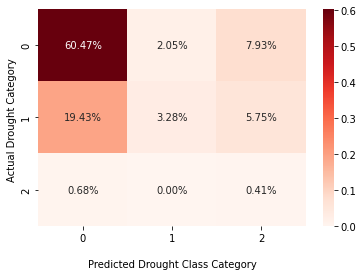

In [ ]:
cf_matrix1 = confusion_matrix(y_test_ny, classes_ny1)

ax1 = sns.heatmap(cf_matrix1/np.sum(cf_matrix1), annot=True, 
            fmt='.2%', cmap='Reds')


ax1.set_xlabel('\nPredicted Drought Class Category')
ax1.set_ylabel('Actual Drought Category ')

ax1.xaxis.set_ticklabels(['0','1','2','3','4','5'])
ax1.yaxis.set_ticklabels(['0','1','2','3','4','5'])

plt.show()

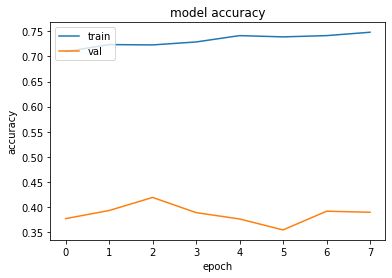

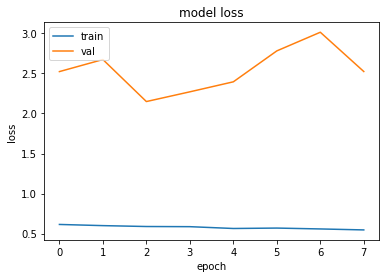

In [ ]:
history1 = new_model_ny1.fit(X1_ny_sm, y1_ny_df_sm, validation_data = (X_val_ny_sm,y_val_ny_sm),
               epochs=50,batch_size=64, callbacks =[cp_ny1,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history1.history['categorical_accuracy'])
plt.plot(history1.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 2.objective : False Negative

In [ ]:
def build_model2(hp):
  model2 = Sequential()
  model2.add(BatchNormalization())
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model2.add(Dense(units=hp_units1, activation= LeakyReLU))
  model2.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model2.add(BatchNormalization())
  model2.add(Dense(units=hp_units2, activation= LeakyReLU))
  model2.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model2.add(BatchNormalization())
  model2.add(Dense(units=hp_units3, activation= LeakyReLU))
  model2.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model2.add(BatchNormalization())
  model2.add(Dense(6, activation='softmax'))

  hp_optimizer_ny=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ny == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ny', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ny == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ny', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model2.compile(
      optimizer= hp_optimizer_ny,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.FalseNegatives(name='false_negatives'),
               'categorical_accuracy']
  )
  return model2

# HyperBand algorithm from keras tuner
tuner2 = kt.Hyperband(
    build_model2,
    objective= kt.Objective('val_false_negatives', direction="min"),
    max_epochs=50,
    directory='ny_dir2',
    project_name='new_york2',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner2.search(X1_ny_sm, y1_ny_df_sm, epochs=50, validation_data = (X_val_ny_sm,y_val_ny_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 52s]
val_false_negatives: 948.0

Best val_false_negatives So Far: 824.0
Total elapsed time: 00h 42m 00s


In [ ]:
best_mlp_hyperparameters_ny2 = tuner2.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_ny2.values

Best Hyper-parameters


{'units1': 96,
 'units2': 224,
 'units3': 64,
 'dropout_1': 0.0,
 'dropout_2': 0.1,
 'dropout_3': 0.2,
 'Optimizer': 'SGD',
 'learning_rate_ny': 0.1,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 3,
 'tuner/round': 0}

In [ ]:
best_model_ny2 = tuner2.get_best_models()[0]
best_model_ny2.build(X1_ny_sm.shape)
best_model_ny2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (14733, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (14733, 96)               4800      
                                                                 
 dropout (Dropout)           (14733, 96)               0         
                                                                 
 batch_normalization_1 (Batc  (14733, 96)              384       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (14733, 224)              21728     
                                                                 
 dropout_1 (Dropout)         (14733, 224)              0

In [ ]:
new_model_ny2 = Sequential()
new_model_ny2.add(tf.keras.Input(shape=(49,)))
new_model_ny2.add(BatchNormalization())
new_model_ny2.add(Dense(96, activation = LeakyReLU))
new_model_ny2.add(BatchNormalization())
new_model_ny2.add(Dense(224, activation = LeakyReLU))
new_model_ny2.add(Dropout(0.1))
new_model_ny2.add(BatchNormalization())
new_model_ny2.add(Dense(64, activation = LeakyReLU))
new_model_ny2.add(Dropout(0.2))
new_model_ny2.add(BatchNormalization())
new_model_ny2.add((Dense(6, activation='softmax')))
new_model_ny2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 96)                4800      
                                                                 
 batch_normalization_5 (Batc  (None, 96)               384       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 224)               21728     
                                                                 
 dropout_3 (Dropout)         (None, 224)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 224)             

In [ ]:
cp_ny2 = ModelCheckpoint('new_model_ny2/', save_best_only=True)
opt_ny2 = keras.optimizers.SGD(learning_rate=0.1)
new_model_ny2.compile(optimizer = opt_ny2, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_ny2.fit(X1_ny_sm, y1_ny_df_sm, validation_data = (X_val_ny_sm,y_val_ny_sm),
               epochs=50,batch_size=64, callbacks =[cp_ny2,early_stopping_monitor])

Epoch 1/50
226/231 [============================>.] - ETA: 0s - loss: 1.1098 - categorical_accuracy: 0.4947

231/231 [==============================] - 4s 14ms/step - loss: 1.1074 - categorical_accuracy: 0.4957 - val_loss: 64.4048 - val_categorical_accuracy: 0.3333
Epoch 2/50
224/231 [============================>.] - ETA: 0s - loss: 0.9155 - categorical_accuracy: 0.5481

231/231 [==============================] - 3s 14ms/step - loss: 0.9142 - categorical_accuracy: 0.5497 - val_loss: 44.7949 - val_categorical_accuracy: 0.3333
Epoch 3/50
218/231 [===========================>..] - ETA: 0s - loss: 0.8743 - categorical_accuracy: 0.5766

231/231 [==============================] - 3s 15ms/step - loss: 0.8746 - categorical_accuracy: 0.5762 - val_loss: 7.9527 - val_categorical_accuracy: 0.3333
Epoch 4/50
231/231 [==============================] - ETA: 0s - loss: 0.8460 - categorical_accuracy: 0.5885

231/231 [==============================] - 4s 16ms/step - loss: 0.8460 - categorical_accuracy: 0.5885 - val_loss: 3.0328 - val_categorical_accuracy: 0.3087
Epoch 5/50
231/231 [==============================] - ETA: 0s - loss: 0.8248 - categorical_accuracy: 0.5974

231/231 [==============================] - 3s 14ms/step - loss: 0.8248 - categorical_accuracy: 0.5974 - val_loss: 2.6846 - val_categorical_accuracy: 0.3706
Epoch 6/50
227/231 [============================>.] - ETA: 0s - loss: 0.7994 - categorical_accuracy: 0.6114

231/231 [==============================] - 3s 14ms/step - loss: 0.7985 - categorical_accuracy: 0.6126 - val_loss: 1.7776 - val_categorical_accuracy: 0.4262
Epoch 7/50
227/231 [============================>.] - ETA: 0s - loss: 0.7863 - categorical_accuracy: 0.6209

231/231 [==============================] - 3s 14ms/step - loss: 0.7872 - categorical_accuracy: 0.6204 - val_loss: 1.6401 - val_categorical_accuracy: 0.4838
Epoch 8/50
231/231 [==============================] - 1s 5ms/step - loss: 0.7701 - categorical_accuracy: 0.6268 - val_loss: 2.2296 - val_categorical_accuracy: 0.4473
Epoch 9/50
231/231 [==============================] - 1s 4ms/step - loss: 0.7593 - categorical_accuracy: 0.6350 - val_loss: 2.6148 - val_categorical_accuracy: 0.3235
Epoch 10/50
231/231 [==============================] - 1s 4ms/step - loss: 0.7428 - categorical_accuracy: 0.6443 - val_loss: 3.8810 - val_categorical_accuracy: 0.3474
Epoch 11/50
231/231 [==============================] - 1s 4ms/step - loss: 0.7395 - categorical_accuracy: 0.6467 - val_loss: 3.2945 - val_categorical_accuracy: 0.3973
Epoch 12/50
231/231 [==============================] - 1s 4ms/step - loss: 0.7265 - categorical_accuracy: 0.6570 - val_loss: 3.3933 - val_categorical_accuracy: 0.3769


In [ ]:
test_predictions_ny2 = new_model_ny2.predict(X_test_ny)
test_predictions_ny2

23/23 [==============================] - 0s 2ms/step


array([[6.8285728e-01, 3.1048900e-01, 6.5792603e-03, 3.3517412e-05,
        8.7850885e-06, 3.2054115e-05],
       [2.3402014e-01, 7.1223003e-01, 5.2091252e-02, 2.8641208e-04,
        5.4494606e-04, 8.2733860e-04],
       [3.4663543e-01, 6.5233940e-01, 7.9998776e-04, 8.0980179e-05,
        6.6526773e-05, 7.7850549e-05],
       ...,
       [2.7405983e-01, 5.8203733e-01, 1.4322965e-01, 2.0502704e-04,
        1.5494239e-04, 3.1329552e-04],
       [1.1396224e-01, 1.4824286e-01, 7.3658711e-01, 5.1200564e-04,
        3.5209020e-04, 3.4370401e-04],
       [2.4990785e-01, 3.3556247e-01, 4.1379508e-01, 2.5972081e-04,
        2.5211048e-04, 2.2276920e-04]], dtype=float32)

In [ ]:
classes_ny2 = np.argmax(test_predictions_ny2, axis=-1)
classes_ny2

array([0, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 2, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 2,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 2,
       1, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 2, 1, 1, 2, 0, 1, 1, 0, 1,

In [ ]:
classes_ny2 =pd.DataFrame(classes_ny2, columns=['Test Predictions']) 
classes_ny2

Test Predictions
0                   0
1                   1
2                   1
3                   2
4                   1
..                ...
726                 1
727                 1
728                 1
729                 2
730                 2

[731 rows x 1 columns]

In [ ]:
classes_ny2 = classes_ny2.values.ravel()

######model 2 evaluation

In [ ]:
print(classification_report(y_test_ny, classes_ny2))

              precision    recall  f1-score   support

           0       0.72      0.48      0.58       515
           1       0.26      0.38      0.31       208
           2       0.01      0.12      0.02         8

    accuracy                           0.45       731
   macro avg       0.33      0.33      0.30       731
weighted avg       0.58      0.45      0.49       731



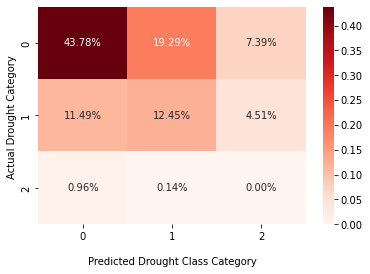

In [ ]:
cf_matrix2 = confusion_matrix(y_test_ny, classes_ny2)

ax2 = sns.heatmap(cf_matrix2/np.sum(cf_matrix2), annot=True, 
            fmt='.2%', cmap='Reds')


ax2.set_xlabel('\nPredicted Drought Class Category')
ax2.set_ylabel('Actual Drought Category ')

ax2.xaxis.set_ticklabels(['0','1','2','3','4','5'])
ax2.yaxis.set_ticklabels(['0','1','2','3','4','5'])

plt.show()

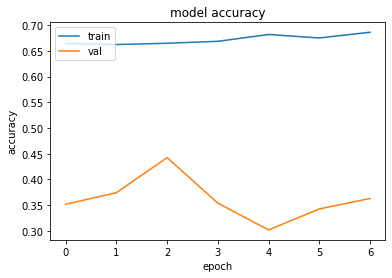

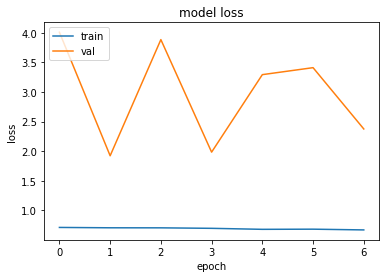

In [ ]:
history2 = new_model_ny2.fit(X1_ny_sm, y1_ny_df_sm, validation_data = (X_val_ny_sm,y_val_ny_sm),
               epochs=50,batch_size=64, callbacks =[cp_ny2,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####perbandingan model

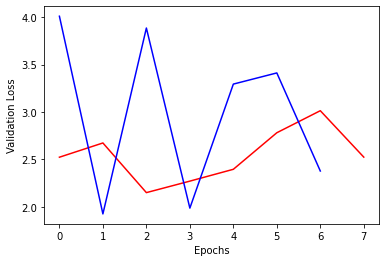

In [ ]:
plt.plot(history1.history['val_loss'], 'r', history2.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

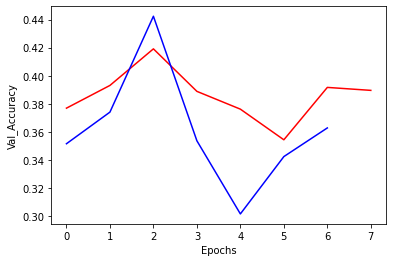

In [ ]:
plt.plot(history1.history['val_categorical_accuracy'], 'r', history2.history['val_categorical_accuracy'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Val_Accuracy')
plt.show()

The model with the lower loss value is the better model

####coba undersampling

In [ ]:
def build_model1_2(hp):
  model1_2 = Sequential()
  model1_2.add(BatchNormalization())
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model1_2.add(Dense(units=hp_units1, activation= LeakyReLU))
  model1_2.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model1_2.add(BatchNormalization())
  model1_2.add(Dense(units=hp_units2, activation= LeakyReLU))
  model1_2.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model1_2.add(BatchNormalization())
  model1_2.add(Dense(units=hp_units3, activation= LeakyReLU))
  model1_2.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model1_2.add(BatchNormalization())
  model1_2.add(Dense(6, activation='softmax'))

  hp_optimizer_ny=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_ny == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_ny', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_ny == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_ny', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model1_2.compile(
      optimizer= hp_optimizer_ny,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model1_2

# HyperBand algorithm from keras tuner
tuner1_2 = kt.Hyperband(
    build_model1_2,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs=50,
    directory='ny_dir',
    project_name='new_york',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner1_2.search(X1_ny2, y1_ny2, epochs=50, validation_data = (X_val_ny2,y_val_ny2),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 30s]
val_true_positives: 419.0

Best val_true_positives So Far: 422.0
Total elapsed time: 00h 21m 12s


In [ ]:
best_mlp_hyperparameters1_ny2 = tuner1_2.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters1_ny2.values

Best Hyper-parameters


{'units1': 224,
 'units2': 512,
 'units3': 512,
 'dropout_1': 0.3,
 'dropout_2': 0.2,
 'dropout_3': 0.3,
 'Optimizer': 'SGD',
 'learning_rate_ny': 0.01,
 'tuner/epochs': 17,
 'tuner/initial_epoch': 6,
 'tuner/bracket': 3,
 'tuner/round': 2,
 'tuner/trial_id': '0043'}

In [ ]:
best_model1_ny2 = tuner1_2.get_best_models()[0]
best_model1_ny2.build(X1_ny2.shape)
best_model1_ny2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (5371, 49)               196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (5371, 224)               11200     
                                                                 
 dropout (Dropout)           (5371, 224)               0         
                                                                 
 batch_normalization_1 (Batc  (5371, 224)              896       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (5371, 512)               115200    
                                                                 
 dropout_1 (Dropout)         (5371, 512)               0

In [ ]:
new_model1_ny2 = Sequential()
new_model1_ny2.add(tf.keras.Input(shape=(49,)))
new_model1_ny2.add(BatchNormalization())
new_model1_ny2.add(Dense(224, activation = LeakyReLU))
new_model1_ny2.add(Dropout(0.3))
new_model1_ny2.add(BatchNormalization())
new_model1_ny2.add(Dense(512, activation = LeakyReLU))
new_model1_ny2.add(Dropout(0.2))
new_model1_ny2.add(BatchNormalization())
new_model1_ny2.add(Dense(512, activation = LeakyReLU))
new_model1_ny2.add(Dropout(0.3))
new_model1_ny2.add(BatchNormalization())
new_model1_ny2.add((Dense(6, activation='softmax')))
new_model1_ny2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 224)               11200     
                                                                 
 dropout_6 (Dropout)         (None, 224)               0         
                                                                 
 batch_normalization_9 (Batc  (None, 224)              896       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 512)               115200    
                                                                 
 dropout_7 (Dropout)         (None, 512)              

In [ ]:
cp1_ny2 = ModelCheckpoint('new_model1_ny/', save_best_only=True)
opt1_ny2 = keras.optimizers.SGD(learning_rate=0.01)
new_model1_ny2.compile(optimizer = opt1_ny2, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model1_ny2.fit(X1_ny2, y1_ny2, validation_data = (X_val_ny2,y_val_ny2),
               epochs=50,batch_size=64, callbacks =[cp1_ny2,early_stopping_monitor])

Epoch 1/50
82/84 [============================>.] - ETA: 0s - loss: 1.7915 - categorical_accuracy: 0.3458

84/84 [==============================] - 5s 48ms/step - loss: 1.7807 - categorical_accuracy: 0.3500 - val_loss: 14.0068 - val_categorical_accuracy: 0.6557
Epoch 2/50
84/84 [==============================] - 1s 14ms/step - loss: 1.0910 - categorical_accuracy: 0.6584 - val_loss: 15.6283 - val_categorical_accuracy: 0.6557
Epoch 3/50
84/84 [==============================] - 1s 14ms/step - loss: 0.8421 - categorical_accuracy: 0.7723 - val_loss: 16.2770 - val_categorical_accuracy: 0.6557
Epoch 4/50
83/84 [============================>.] - ETA: 0s - loss: 0.7584 - categorical_accuracy: 0.8016

84/84 [==============================] - 4s 44ms/step - loss: 0.7583 - categorical_accuracy: 0.8019 - val_loss: 9.6163 - val_categorical_accuracy: 0.6557
Epoch 5/50
81/84 [===========================>..] - ETA: 0s - loss: 0.6984 - categorical_accuracy: 0.8100

84/84 [==============================] - 4s 46ms/step - loss: 0.7035 - categorical_accuracy: 0.8092 - val_loss: 6.8688 - val_categorical_accuracy: 0.6557
Epoch 6/50
82/84 [============================>.] - ETA: 0s - loss: 0.6686 - categorical_accuracy: 0.8152

84/84 [==============================] - 4s 43ms/step - loss: 0.6682 - categorical_accuracy: 0.8151 - val_loss: 4.4903 - val_categorical_accuracy: 0.6557
Epoch 7/50
81/84 [===========================>..] - ETA: 0s - loss: 0.6500 - categorical_accuracy: 0.8166

84/84 [==============================] - 4s 43ms/step - loss: 0.6464 - categorical_accuracy: 0.8177 - val_loss: 2.7375 - val_categorical_accuracy: 0.6557
Epoch 8/50
82/84 [============================>.] - ETA: 0s - loss: 0.6133 - categorical_accuracy: 0.8232

84/84 [==============================] - 4s 47ms/step - loss: 0.6129 - categorical_accuracy: 0.8228 - val_loss: 1.9744 - val_categorical_accuracy: 0.6557
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.6119 - categorical_accuracy: 0.8209

84/84 [==============================] - 4s 43ms/step - loss: 0.6119 - categorical_accuracy: 0.8209 - val_loss: 1.4989 - val_categorical_accuracy: 0.6557
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.6005 - categorical_accuracy: 0.8235

84/84 [==============================] - 4s 43ms/step - loss: 0.6005 - categorical_accuracy: 0.8235 - val_loss: 1.2616 - val_categorical_accuracy: 0.6557
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.5879 - categorical_accuracy: 0.8250

84/84 [==============================] - 4s 47ms/step - loss: 0.5879 - categorical_accuracy: 0.8250 - val_loss: 1.1763 - val_categorical_accuracy: 0.6557
Epoch 12/50
84/84 [==============================] - 1s 14ms/step - loss: 0.5691 - categorical_accuracy: 0.8278 - val_loss: 1.1951 - val_categorical_accuracy: 0.6557
Epoch 13/50
84/84 [==============================] - 1s 15ms/step - loss: 0.5678 - categorical_accuracy: 0.8291 - val_loss: 1.1932 - val_categorical_accuracy: 0.6557
Epoch 14/50
84/84 [==============================] - 1s 15ms/step - loss: 0.5609 - categorical_accuracy: 0.8296 - val_loss: 1.1875 - val_categorical_accuracy: 0.6557
Epoch 15/50
84/84 [==============================] - 1s 15ms/step - loss: 0.5581 - categorical_accuracy: 0.8280 - val_loss: 1.1997 - val_categorical_accuracy: 0.6557
Epoch 16/50
84/84 [==============================] - 1s 14ms/step - loss: 0.5546 - categorical_accuracy: 0.8300 - val_loss: 1.1991 - val_categorical_accuracy: 0.6557


In [ ]:
test_predictions1_ny2 = new_model1_ny2.predict(X_test_ny)
test_predictions1_ny2

23/23 [==============================] - 0s 5ms/step


array([[0.71178395, 0.27668923, 0.00438996, 0.00288523, 0.00194539,
        0.00230627],
       [0.83798707, 0.14720619, 0.00630423, 0.00308793, 0.00247376,
        0.00294084],
       [0.72427076, 0.2287733 , 0.02856287, 0.00576913, 0.00630533,
        0.00631856],
       ...,
       [0.715613  , 0.24790373, 0.01742414, 0.00543689, 0.00607885,
        0.00754343],
       [0.7158873 , 0.263389  , 0.00820259, 0.00420693, 0.00345493,
        0.00485917],
       [0.7044645 , 0.24131182, 0.03429531, 0.00790194, 0.00503792,
        0.00698857]], dtype=float32)

In [ ]:
classes1_ny2 = np.argmax(test_predictions1_ny2, axis=-1)
classes1_ny2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
classes1_ny2 =pd.DataFrame(classes1_ny2, columns=['Test Predictions']) 
classes1_ny2

Test Predictions
0                   0
1                   0
2                   0
3                   0
4                   0
..                ...
726                 0
727                 0
728                 0
729                 0
730                 0

[731 rows x 1 columns]

In [ ]:
y_test_ny = np.argmax(y_test_ny, axis=-1)
y_test_ny

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
y_test_ny =pd.DataFrame(y_test_ny, columns=['Actuals']) 
y_test_ny

Actuals
0          0
1          0
2          0
3          0
4          0
..       ...
726        1
727        1
728        1
729        1
730        1

[731 rows x 1 columns]

In [ ]:
classes1_ny2 = classes1_ny2.values.ravel()
y_test_ny = y_test_ny.values.ravel()

In [ ]:
result1_ny2 = pd.DataFrame({'Test Predictions':classes1_ny2, 'Actuals':y_test_ny})
result1_ny2[0:31]

Test Predictions  Actuals
0                  0        0
1                  0        0
2                  0        0
3                  0        0
4                  0        0
5                  0        0
6                  0        0
7                  0        0
8                  0        0
9                  0        0
10                 0        0
11                 0        0
12                 0        0
13                 0        0
14                 0        0
15                 0        0
16                 0        0
17                 0        0
18                 0        0
19                 0        0
20                 0        0
21                 0        0
22                 0        0
23                 0        0
24                 0        0
25                 0        0
26                 0        0
27                 0        0
28                 0        0
29                 0        0
30                 0        0

######model 1 evaluation

In [ ]:
print(classification_report(y_test_ny, classes1_ny2))

              precision    recall  f1-score   support

           0       0.70      1.00      0.83       515
           1       0.00      0.00      0.00       208
           2       0.00      0.00      0.00         8

    accuracy                           0.70       731
   macro avg       0.23      0.33      0.28       731
weighted avg       0.50      0.70      0.58       731



###LSTM model without weather and soil data, only using previous drought scores

In [ ]:
def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_ny, y_train_ny = df_to_X_y(score_ny, WINDOW_SIZE)
X_val1_ny, y_val1_ny = df_to_X_y(score_val_ny, WINDOW_SIZE)
X_test1_ny, y_test1_ny = df_to_X_y(score_test_ny, WINDOW_SIZE)
X_train_ny.shape, y_train_ny.shape, X_val1_ny.shape, y_val1_ny.shape, X_test1_ny.shape, y_test1_ny.shape

((6203, 7, 1), (6203,), (723, 7, 1), (723,), (724, 7, 1), (724,))

In [ ]:
model_1 = Sequential()
model_1.add(InputLayer((7,1)))
model_1.add(LSTM(64))
model_1.add(Dense(8, 'relu'))
model_1.add(Dense(1, 'linear'))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

model_1.fit(X_train_ny, y_train_ny, validation_data=(X_val1_ny, y_val1_ny), epochs=50, 
           callbacks = [early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 4s 9ms/step - loss: 0.1159 - root_mean_squared_error: 0.3405 - val_loss: 0.0699 - val_root_mean_squared_error: 0.2644
Epoch 2/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0253 - root_mean_squared_error: 0.1591 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1821
Epoch 3/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0227 - root_mean_squared_error: 0.1508 - val_loss: 0.0304 - val_root_mean_squared_error: 0.1742
Epoch 4/50
194/194 [==============================] - 1s 8ms/step - loss: 0.0213 - root_mean_squared_error: 0.1459 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1686
Epoch 5/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0198 - root_mean_squared_error: 0.1408 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1608
Epoch 6/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0185 - root_mean_squared_error: 0.1361 - val_loss: 0.0247 - val_

####using the model to predict the test dataset

In [ ]:
test_prediction_1 = model_1.predict(X_test1_ny).flatten()
test_results_1 = pd.DataFrame(data={'predictions':test_prediction_1, 'actuals':y_test1_ny})
test_results_1

23/23 [==============================] - 1s 4ms/step


predictions  actuals
0      -0.003164      0.0
1      -0.003164      0.0
2      -0.003164      0.0
3      -0.003164      0.0
4      -0.003164      0.0
..           ...      ...
719     0.973184      1.0
720     0.970097      1.0
721     0.961702      1.0
722     0.951547      1.0
723     0.951547      1.0

[724 rows x 2 columns]

In [ ]:
test_results_1.predictions[test_results_1.predictions <0.5] = 0
test_results_1.predictions[(test_results_1.predictions >=0.5)&(test_results_1.predictions<1.5)] = 1
test_results_1.predictions[(test_results_1.predictions >=1.5)&(test_results_1.predictions<2.5)] = 2
test_results_1.predictions[(test_results_1.predictions >=2.5)&(test_results_1.predictions<3.5)] = 3
test_results_1.predictions[(test_results_1.predictions >=3.5)&(test_results_1.predictions<4.5)] = 4
test_results_1.predictions[(test_results_1.predictions >=4.5)&(test_results_1.predictions<5.5)] = 5
test_results_1

predictions  actuals
0            0.0      0.0
1            0.0      0.0
2            0.0      0.0
3            0.0      0.0
4            0.0      0.0
..           ...      ...
719          1.0      1.0
720          1.0      1.0
721          1.0      1.0
722          1.0      1.0
723          1.0      1.0

[724 rows x 2 columns]

In [ ]:
test_results_1.actuals[test_results_1.actuals <0.5] = 0
test_results_1.actuals[(test_results_1.actuals >=0.5)&(test_results_1.actuals<1.5)] = 1
test_results_1.actuals[(test_results_1.actuals >=1.5)&(test_results_1.actuals<2.5)] = 2
test_results_1.actuals[(test_results_1.actuals >=2.5)&(test_results_1.actuals<3.5)] = 3
test_results_1.actuals[(test_results_1.actuals >=3.5)&(test_results_1.actuals<4.5)] = 4
test_results_1.actuals[(test_results_1.actuals >=4.5)&(test_results_1.actuals<5.5)] = 5
test_results_1

predictions  actuals
0            0.0      0.0
1            0.0      0.0
2            0.0      0.0
3            0.0      0.0
4            0.0      0.0
..           ...      ...
719          1.0      1.0
720          1.0      1.0
721          1.0      1.0
722          1.0      1.0
723          1.0      1.0

[724 rows x 2 columns]

####model evaluation

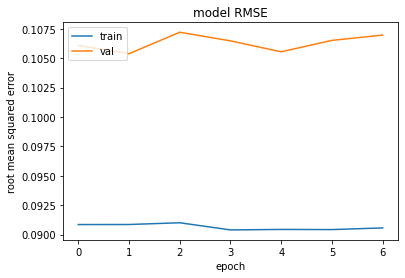

In [ ]:
history_1 = model_1.fit(X_train_ny, y_train_ny, validation_data=(X_val1_ny, y_val1_ny), epochs=50, 
           callbacks = [early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history_1.history['root_mean_squared_error'])
plt.plot(history_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(classification_report(test_results_1['actuals'], test_results_1['predictions']))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       508
         1.0       0.99      0.99      0.99       208
         2.0       0.88      0.88      0.88         8

    accuracy                           0.99       724
   macro avg       0.95      0.95      0.95       724
weighted avg       0.99      0.99      0.99       724



hasil : RMSE train dan test tidak jauh berbeda

###LSTM model with only score data and time data but the time data is transformed using sine and cosine

####train

In [ ]:
train_ny1 = train_ny.copy()
train_ny1.index = pd.to_datetime(train_ny1['date'], format='%Y.%m.%d')
train_ny1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                         
2000-01-01  36031  2000-01-01     0.85  96.76  2.88  -3.67   -4.33   -4.32   
2000-01-02  36031  2000-01-02     4.54  96.38  3.93  -0.01   -0.38   -0.38   
2000-01-03  36031  2000-01-03     6.24  96.65  4.14   1.51    0.11    0.12   
2000-01-04  36031  2000-01-04    15.38  95.30  4.89   3.14    2.13    2.13   
2000-01-05  36031  2000-01-05     0.29  96.77  1.25  -8.95  -13.91  -13.53   
2000-01-06  36031  2000-01-06     0.14  97.66  1.73  -7.05  -10.44  -10.29   
2000-01-07  36031  2000-01-07     1.13  96.66  2.66  -3.11   -5.27   -5.23   
2000-01-08  36031  2000-01-08     0.06  96.81  2.01  -5.17   -8.53   -8.44   
2000-01-09  36031  2000-01-09     0.47  96.33  3.23  -0.94   -2.84   -2.82   
2000-01-10  36031  2000-01-10    15.30  95.42  3.77  -0.53   -0.80   -0.80   
2000-01-11  36031  2000-01-11     2.60  94.35  3.89   0.56   -0.51   -0.51   
2000-01-12  36031  2000-01-12     0.30  96.23  1.85  -6.43   -9.65   -9.54   
2000-01-13  36031  2000-01-13     0.33  96.44  0.92 -14.55  -17.20  -16.84   
2000-01-14  36031  2000-01-14     0.03  97.50  0.54 -19.79  -22.16  -21.54   
2000-01-15  36031  2000-01-15     0.15  98.01  0.65 -17.88  -20.79  -20.22   
2000-01-16  36031  2000-01-16     2.89  96.15  1.62 -10.21  -12.19  -12.02   
2000-01-17  36031  2000-01-17     0.06  97.44  0.42 -22.69  -24.59  -23.94   
2000-01-18  36031  2000-01-18     0.03  96.69  0.55 -21.12  -22.55  -22.22   
2000-01-19  36031  2000-01-19     0.01  95.92  0.78 -16.64  -18.71  -18.43   
2000-01-20  36031  2000-01-20     2.06  95.32  1.36 -12.25  -13.13  -13.07   
2000-01-21  36031  2000-01-21     0.39  95.27  0.67 -18.74  -20.52  -20.13   
2000-01-22  36031  2000-01-22     0.03  96.26  0.40 -23.84  -25.26  -24.78   
2000-01-23  36031  2000-01-23     0.17  96.77  0.91 -17.17  -18.23  -18.08   
2000-01-24  36031  2000-01-24     0.48  96.59  1.57 -10.40  -11.50  -11.46   
2000-01-25  36031  2000-01-25     7.36  95.64  1.51 -11.23  -11.85  -11.82   
2000-01-26  36031  2000-01-26     3.72  95.27  1.41 -11.70  -12.69  -12.63   
2000-01-27  36031  2000-01-27     0.42  96.27  0.74 -18.32  -19.12  -18.99   
2000-01-28  36031  2000-01-28     0.22  97.06  0.71 -18.77  -19.52  -19.38   
2000-01-29  36031  2000-01-29     0.00  97.96  1.03 -15.41  -16.61  -16.47   
2000-01-30  36031  2000-01-30     1.19  97.29  1.84  -8.08  -10.65  -10.40   
2000-01-31  36031  2000-01-31     8.73  95.28  2.69  -4.56   -5.24   -5.23   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2000-01-01     1.33    -9.32      10.65  -4.04   2.69       3.78       1.90   
2000-01-02     5.28    -4.24       9.53  -0.26   2.55       6.21       1.08   
2000-01-03     5.83    -2.82       8.66   1.35   3.13       5.30       1.67   
2000-01-04     9.66    -2.23      11.89   2.89   5.55       6.32       3.68   
2000-01-05    -3.77   -12.74       8.97  -9.27   3.88       5.34       1.10   
2000-01-06    -3.29   -12.42       9.13  -7.52   3.29       4.77       0.99   
2000-01-07     0.92    -5.85       6.76  -3.32   3.60       5.85       2.34   
2000-01-08    -0.97    -9.38       8.41  -5.52   3.32       4.38       2.16   
2000-01-09     2.88    -3.72       6.60  -1.70   2.62       3.71       1.29   
2000-01-10     1.61    -3.12       4.72  -0.75   3.67       5.59       1.79   
2000-01-11     1.94    -1.58       3.53   0.26   4.94       6.09       3.14   
2000-01-12    -2.52   -11.93       9.42  -6.82   4.92       6.26       2.59   
2000-01-13   -12.09   -20.17       8.08 -14.88   3.91       5.83       2.43   
2000-01-14   -17.11   -22.54       5.44 -20.01   5.19       5.82       4.08   
2000-01-15   -10.49   -24.35      13.86 -18.83   2.29       4.14       0.16   
2000-01-16     0.02   -19.95      19.97 -10.31   6.17       7.70       4.20   
2000-01-17   -20

In [ ]:
scoreny = train_ny1['score']
scoreny_df = pd.DataFrame({'score':scoreny})
scoreny_df['Seconds'] = scoreny_df.index.map(pd.Timestamp.timestamp)
scoreny_df

score       Seconds
date                           
2000-01-01    0.0  9.466848e+08
2000-01-02    0.0  9.467712e+08
2000-01-03    0.0  9.468576e+08
2000-01-04    0.0  9.469440e+08
2000-01-05    0.0  9.470304e+08
...           ...           ...
2016-12-27    2.0  1.482797e+09
2016-12-28    2.0  1.482883e+09
2016-12-29    2.0  1.482970e+09
2016-12-30    2.0  1.483056e+09
2016-12-31    2.0  1.483142e+09

[6210 rows x 2 columns]

In [ ]:
day = 60*60*24
month = 30.437*day
year = 365.2425*day

scoreny_df['Day sin'] = np.sin(scoreny_df['Seconds'] * (2* np.pi / day))
scoreny_df['Day cos'] = np.cos(scoreny_df['Seconds'] * (2 * np.pi / day))
scoreny_df['Month sin'] = np.sin(scoreny_df['Seconds'] * (2* np.pi / month))
scoreny_df['Month cos'] = np.cos(scoreny_df['Seconds'] * (2 * np.pi / month))
scoreny_df['Year sin'] = np.sin(scoreny_df['Seconds'] * (2 * np.pi / year))
scoreny_df['Year cos'] = np.cos(scoreny_df['Seconds'] * (2 * np.pi / year))
scoreny_df.head()

score      Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                          
2000-01-01    0.0  946684800.0 -5.461913e-12      1.0  -0.066010   0.997819   
2000-01-02    0.0  946771200.0 -1.163374e-12      1.0   0.139914   0.990164   
2000-01-03    0.0  946857600.0  3.135164e-12      1.0   0.339896   0.940463   
2000-01-04    0.0  946944000.0 -7.118212e-12      1.0   0.525446   0.850827   
2000-01-05    0.0  947030400.0 -2.819674e-12      1.0   0.688683   0.725062   

            Year sin  Year cos  
date                            
2000-01-01 -0.004731  0.999989  
2000-01-02  0.012472  0.999922  
2000-01-03  0.029670  0.999560  
2000-01-04  0.046860  0.998901  
2000-01-05  0.064036  0.997948

In [ ]:
scoreny_df = scoreny_df.drop('Seconds', axis=1)
scoreny_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2000-01-01    0.0 -5.461913e-12      1.0  -0.066010   0.997819 -0.004731   
2000-01-02    0.0 -1.163374e-12      1.0   0.139914   0.990164  0.012472   
2000-01-03    0.0  3.135164e-12      1.0   0.339896   0.940463  0.029670   
2000-01-04    0.0 -7.118212e-12      1.0   0.525446   0.850827  0.046860   
2000-01-05    0.0 -2.819674e-12      1.0   0.688683   0.725062  0.064036   

            Year cos  
date                  
2000-01-01  0.999989  
2000-01-02  0.999922  
2000-01-03  0.999560  
2000-01-04  0.998901  
2000-01-05  0.997948

####val

In [ ]:
val_ny1 = val_ny.copy()
val_ny1.index = pd.to_datetime(val_ny1['date'], format='%Y.%m.%d')
val_ny1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                         
2017-01-01  36031  2017-01-01     0.29  96.65  2.62  -3.77   -5.50   -5.47   
2017-01-02  36031  2017-01-02     0.01  97.81  2.42  -4.65   -6.22   -6.20   
2017-01-03  36031  2017-01-03     9.28  96.26  3.49  -1.07   -1.75   -1.75   
2017-01-04  36031  2017-01-04     3.27  94.45  3.15  -2.37   -3.63   -3.61   
2017-01-05  36031  2017-01-05     0.51  95.47  1.76  -7.95  -10.14  -10.06   
2017-01-06  36031  2017-01-06     0.09  96.48  1.39 -10.55  -12.68  -12.55   
2017-01-07  36031  2017-01-07     0.04  97.16  1.17 -12.44  -14.57  -14.37   
2017-01-08  36031  2017-01-08     0.25  97.13  0.84 -15.25  -17.96  -17.54   
2017-01-09  36031  2017-01-09     0.15  97.99  0.94 -15.88  -17.21  -17.03   
2017-01-10  36031  2017-01-10     1.83  97.40  1.70  -9.82  -11.07  -11.02   
2017-01-11  36031  2017-01-11     4.38  96.50  3.82   0.85   -0.47   -0.46   
2017-01-12  36031  2017-01-12     6.33  96.00  4.76   2.47    2.43    2.43   
2017-01-13  36031  2017-01-13     0.17  97.80  1.67  -6.95  -11.34  -11.05   
2017-01-14  36031  2017-01-14     0.03  97.96  1.08 -12.23  -15.49  -15.14   
2017-01-15  36031  2017-01-15     0.14  97.39  1.43  -9.75  -12.26  -12.10   
2017-01-16  36031  2017-01-16     0.01  97.31  2.02  -6.98   -8.76   -8.72   
2017-01-17  36031  2017-01-17     3.88  96.90  2.81  -3.47   -4.53   -4.52   
2017-01-18  36031  2017-01-18     4.10  96.27  3.46  -1.09   -1.81   -1.81   
2017-01-19  36031  2017-01-19     0.32  96.43  3.34  -1.46   -2.30   -2.30   
2017-01-20  36031  2017-01-20     0.04  96.20  3.17  -1.85   -3.00   -3.00   
2017-01-21  36031  2017-01-21     0.20  95.79  4.30   1.15    1.04    1.04   
2017-01-22  36031  2017-01-22     0.41  95.91  4.04   0.54    0.22    0.22   
2017-01-23  36031  2017-01-23     0.91  96.35  2.79  -2.14   -4.60   -4.56   
2017-01-24  36031  2017-01-24    20.22  95.26  2.67  -4.37   -5.31   -5.29   
2017-01-25  36031  2017-01-25     0.88  94.87  2.73  -4.48   -5.19   -5.18   
2017-01-26  36031  2017-01-26     2.71  94.21  3.65  -0.89   -1.47   -1.47   
2017-01-27  36031  2017-01-27     2.20  94.47  2.90  -2.95   -4.32   -4.31   
2017-01-28  36031  2017-01-28     0.69  94.82  2.59  -4.35   -5.73   -5.71   
2017-01-29  36031  2017-01-29     0.56  95.11  2.33  -5.86   -7.13   -7.11   
2017-01-30  36031  2017-01-30     0.06  95.71  1.23 -12.79  -14.22  -14.11   
2017-01-31  36031  2017-01-31     0.11  95.92  1.25 -13.02  -14.18  -14.11   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2017-01-01    -0.52    -8.19       7.67  -4.54   3.34       4.53       1.85   
2017-01-02     1.18    -8.24       9.43  -5.32   2.03       2.75       1.12   
2017-01-03     0.50    -4.02       4.52  -1.22   3.14       4.40       1.42   
2017-01-04     1.38    -8.07       9.45  -2.67   3.78       6.35       0.39   
2017-01-05    -6.70    -8.83       2.13  -8.15   4.37       5.85       2.58   
2017-01-06    -7.99   -13.42       5.43 -11.35   2.26       2.79       1.81   
2017-01-07    -9.04   -16.91       7.87 -14.70   1.75       2.58       1.14   
2017-01-08   -11.27   -18.81       7.55 -17.58   2.22       4.25       0.46   
2017-01-09   -10.99   -22.15      11.15 -17.12   3.01       3.96       2.22   
2017-01-10    -1.73   -17.02      15.29 -10.16   4.84       8.17       2.58   
2017-01-11     2.08    -1.18       3.25   0.59   5.74       8.28       3.33   
2017-01-12     5.26    -0.07       5.33   2.15   4.13       5.95       2.10   
2017-01-13    -0.87   -15.16      14.30  -6.93   5.08       6.79       2.79   
2017-01-14    -6.44   -17.40      10.96 -13.16   1.90       2.66       0.77   
2017-01-15    -5.51   -12.43       6.92 -10.60   2.30       3.61       0.74   
2017-01-16     0.98   -13.46      14.44  -7.42   2.91       3.83       2.04   
2017-01-17    -0

In [ ]:
scoreny_val = val_ny1['score']
scoreny_val_df = pd.DataFrame({'score':scoreny_val})
scoreny_val_df['Seconds'] = scoreny_val_df.index.map(pd.Timestamp.timestamp)
scoreny_val_df

score       Seconds
date                           
2017-01-01    2.0  1.483229e+09
2017-01-02    2.0  1.483315e+09
2017-01-03    2.0  1.483402e+09
2017-01-04    2.0  1.483488e+09
2017-01-05    2.0  1.483574e+09
...           ...           ...
2018-12-27    0.0  1.545869e+09
2018-12-28    0.0  1.545955e+09
2018-12-29    0.0  1.546042e+09
2018-12-30    0.0  1.546128e+09
2018-12-31    0.0  1.546214e+09

[730 rows x 2 columns]

In [ ]:
scoreny_val_df['Day sin'] = np.sin(scoreny_val_df['Seconds'] * (2* np.pi / day))
scoreny_val_df['Day cos'] = np.cos(scoreny_val_df['Seconds'] * (2 * np.pi / day))
scoreny_val_df['Month sin'] = np.sin(scoreny_val_df['Seconds'] * (2* np.pi / month))
scoreny_val_df['Month cos'] = np.cos(scoreny_val_df['Seconds'] * (2 * np.pi / month))
scoreny_val_df['Year sin'] = np.sin(scoreny_val_df['Seconds'] * (2 * np.pi / year))
scoreny_val_df['Year cos'] = np.cos(scoreny_val_df['Seconds'] * (2 * np.pi / year))
scoreny_val_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2017-01-01    2.0  1.483229e+09  2.504006e-13      1.0   0.109601   0.993976   
2017-01-02    2.0  1.483315e+09 -1.000298e-11      1.0   0.311009   0.950407   
2017-01-03    2.0  1.483402e+09 -5.704437e-12      1.0   0.499210   0.866481   
2017-01-04    2.0  1.483488e+09 -1.405899e-12      1.0   0.666213   0.745761   
2017-01-05    2.0  1.483574e+09 -1.165928e-11      1.0   0.804927   0.593374   

            Year sin  Year cos  
date                            
2017-01-01  0.010364  0.999946  
2017-01-02  0.027564  0.999620  
2017-01-03  0.044755  0.998998  
2017-01-04  0.061933  0.998080  
2017-01-05  0.079093  0.996867

In [ ]:
scoreny_val_df = scoreny_val_df.drop('Seconds', axis=1)
scoreny_val_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2017-01-01    2.0  2.504006e-13      1.0   0.109601   0.993976  0.010364   
2017-01-02    2.0 -1.000298e-11      1.0   0.311009   0.950407  0.027564   
2017-01-03    2.0 -5.704437e-12      1.0   0.499210   0.866481  0.044755   
2017-01-04    2.0 -1.405899e-12      1.0   0.666213   0.745761  0.061933   
2017-01-05    2.0 -1.165928e-11      1.0   0.804927   0.593374  0.079093   

            Year cos  
date                  
2017-01-01  0.999946  
2017-01-02  0.999620  
2017-01-03  0.998998  
2017-01-04  0.998080  
2017-01-05  0.996867

####test

In [ ]:
test_ny1 = test_ny.copy()
test_ny1.index = pd.to_datetime(test_ny1['date'], format='%Y.%m.%d')
test_ny1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                         
2019-01-01  36031  2019-01-01     4.15  95.77  2.93  -3.41   -4.19   -5.11   
2019-01-02  36031  2019-01-02     0.50  97.14  1.24 -10.16  -14.88  -13.75   
2019-01-03  36031  2019-01-03     3.48  96.00  2.54  -4.65   -6.00   -5.80   
2019-01-04  36031  2019-01-04     0.31  95.75  3.21  -2.06   -2.95   -2.94   
2019-01-05  36031  2019-01-05     0.34  95.33  3.47  -1.30   -1.95   -1.95   
2019-01-06  36031  2019-01-06     0.96  96.32  2.25  -5.96   -7.57   -7.91   
2019-01-07  36031  2019-01-07     0.70  97.60  0.89 -14.12  -18.68  -16.84   
2019-01-08  36031  2019-01-08     8.65  95.77  2.98  -3.46   -3.96   -4.17   
2019-01-09  36031  2019-01-09     3.30  94.56  3.22  -2.39   -3.07   -3.03   
2019-01-10  36031  2019-01-10     1.41  95.38  1.77  -9.26  -10.75  -10.53   
2019-01-11  36031  2019-01-11     0.20  96.93  0.76 -17.50  -20.64  -18.54   
2019-01-12  36031  2019-01-12     0.05  97.86  0.70 -18.91  -21.53  -19.82   
2019-01-13  36031  2019-01-13     0.31  97.85  0.86 -17.10  -19.11  -17.74   
2019-01-14  36031  2019-01-14     0.10  97.14  1.30 -12.61  -14.35  -13.67   
2019-01-15  36031  2019-01-15     0.18  96.60  2.03  -7.81   -8.82   -8.63   
2019-01-16  36031  2019-01-16     0.62  96.23  1.95  -8.28   -9.36   -9.51   
2019-01-17  36031  2019-01-17     0.08  97.30  0.89 -15.41  -18.74  -17.25   
2019-01-18  36031  2019-01-18     0.78  96.49  2.01  -7.93   -8.97   -8.84   
2019-01-19  36031  2019-01-19     3.35  97.19  0.75 -17.78  -20.77  -18.84   
2019-01-20  36031  2019-01-20    16.15  95.38  0.75 -19.20  -21.11  -19.44   
2019-01-21  36031  2019-01-21     1.72  96.26  0.41 -24.83  -27.59  -24.97   
2019-01-22  36031  2019-01-22     0.11  97.88  0.82 -18.77  -19.75  -19.17   
2019-01-23  36031  2019-01-23     7.75  96.43  2.60  -5.70   -5.70   -6.19   
2019-01-24  36031  2019-01-24    21.48  94.85  3.63  -1.33   -1.38   -1.63   
2019-01-25  36031  2019-01-25     1.28  95.83  1.79  -9.22  -10.50  -10.12   
2019-01-26  36031  2019-01-26     0.48  96.81  1.26 -13.07  -14.77  -13.80   
2019-01-27  36031  2019-01-27     2.45  96.17  1.80  -9.70  -10.41  -10.36   
2019-01-28  36031  2019-01-28     0.09  96.69  0.66 -20.02  -22.30  -20.44   
2019-01-29  36031  2019-01-29     6.64  95.90  1.63 -10.94  -11.69  -11.51   
2019-01-30  36031  2019-01-30     1.23  95.70  1.25 -13.41  -14.96  -14.14   
2019-01-31  36031  2019-01-31     0.24  96.51  0.84 -17.35  -19.53  -17.80   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2019-01-01     3.55   -14.11      17.66  -3.65   5.04       6.69       2.45   
2019-01-02    -4.66   -14.93      10.28 -10.84   1.59       2.73       0.63   
2019-01-03    -1.71    -7.60       5.89  -4.88   2.50       3.27       1.58   
2019-01-04     2.22    -4.62       6.85  -2.29   2.86       3.96       2.01   
2019-01-05     2.87    -4.12       6.99  -1.92   1.65       2.71       0.53   
2019-01-06    -1.96   -14.31      12.34  -6.28   4.29       5.73       2.14   
2019-01-07   -10.43   -18.42       8.00 -14.55   2.45       4.54       0.25   
2019-01-08    -0.30    -9.74       9.44  -3.54   3.88       6.83       1.74   
2019-01-09    -0.75    -4.11       3.37  -2.58   4.01       5.77       0.88   
2019-01-10    -4.22   -15.01      10.79  -9.38   5.72       6.32       5.00   
2019-01-11   -15.24   -18.73       3.48 -17.70   4.52       5.10       3.51   
2019-01-12   -12.07   -23.26      11.19 -20.42   2.82       3.37       2.33   
2019-01-13   -10.66   -21.37      10.71 -20.13   1.63       2.25       1.03   
2019-01-14    -5.70   -17.70      12.00 -15.22   1.34       2.10       0.24   
2019-01-15    -2.94   -12.44       9.50  -8.52   2.13       2.57       1.43   
2019-01-16    -1.44   -16.72      15.28  -8.55   4.05       5.74       2.64   
2019-01-17   -10

In [ ]:
scoreny_test = test_ny1['score']
scoreny_test_df = pd.DataFrame({'score':scoreny_test})
scoreny_test_df['Seconds'] = scoreny_test_df.index.map(pd.Timestamp.timestamp)
scoreny_test_df

score       Seconds
date                           
2019-01-01    0.0  1.546301e+09
2019-01-02    0.0  1.546387e+09
2019-01-03    0.0  1.546474e+09
2019-01-04    0.0  1.546560e+09
2019-01-05    0.0  1.546646e+09
...           ...           ...
2020-12-27    1.0  1.609027e+09
2020-12-28    1.0  1.609114e+09
2020-12-29    1.0  1.609200e+09
2020-12-30    1.0  1.609286e+09
2020-12-31    1.0  1.609373e+09

[731 rows x 2 columns]

In [ ]:
scoreny_test_df['Day sin'] = np.sin(scoreny_test_df['Seconds'] * (2* np.pi / day))
scoreny_test_df['Day cos'] = np.cos(scoreny_test_df['Seconds'] * (2 * np.pi / day))
scoreny_test_df['Month sin'] = np.sin(scoreny_test_df['Seconds'] * (2* np.pi / month))
scoreny_test_df['Month cos'] = np.cos(scoreny_test_df['Seconds'] * (2 * np.pi / month))
scoreny_test_df['Year sin'] = np.sin(scoreny_test_df['Seconds'] * (2 * np.pi / year))
scoreny_test_df['Year cos'] = np.cos(scoreny_test_df['Seconds'] * (2 * np.pi / year))
scoreny_test_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2019-01-01    0.0  1.546301e+09 -5.030095e-12      1.0   0.009083   0.999959   
2019-01-02    0.0  1.546387e+09 -7.315560e-13      1.0   0.213851   0.976866   
2019-01-03    0.0  1.546474e+09 -1.098493e-11      1.0   0.409538   0.912293   
2019-01-04    0.0  1.546560e+09 -6.686394e-12      1.0   0.587835   0.808981   
2019-01-05    0.0  1.546646e+09 -2.387855e-12      1.0   0.741171   0.671316   

            Year sin  Year cos  
date                            
2019-01-01  0.002021  0.999998  
2019-01-02  0.019223  0.999815  
2019-01-03  0.036419  0.999337  
2019-01-04  0.053604  0.998562  
2019-01-05  0.070773  0.997492

In [ ]:
scoreny_test_df = scoreny_test_df.drop('Seconds', axis=1)
scoreny_test_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2019-01-01    0.0 -5.030095e-12      1.0   0.009083   0.999959  0.002021   
2019-01-02    0.0 -7.315560e-13      1.0   0.213851   0.976866  0.019223   
2019-01-03    0.0 -1.098493e-11      1.0   0.409538   0.912293  0.036419   
2019-01-04    0.0 -6.686394e-12      1.0   0.587835   0.808981  0.053604   
2019-01-05    0.0 -2.387855e-12      1.0   0.741171   0.671316  0.070773   

            Year cos  
date                  
2019-01-01  0.999998  
2019-01-02  0.999815  
2019-01-03  0.999337  
2019-01-04  0.998562  
2019-01-05  0.997492

In [ ]:
def df_to_X_y2(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_ny2, y_train_ny2 = df_to_X_y2(scoreny_df, WINDOW_SIZE)
X_val1_ny2, y_val1_ny2 = df_to_X_y2(scoreny_val_df, WINDOW_SIZE)
X_test1_ny2, y_test1_ny2 = df_to_X_y2(scoreny_test_df, WINDOW_SIZE)
X_train_ny2.shape, y_train_ny2.shape, X_val1_ny2.shape, y_val1_ny2.shape, X_test1_ny2.shape, y_test1_ny2.shape

((6203, 7, 7), (6203,), (723, 7, 7), (723,), (724, 7, 7), (724,))

In [ ]:
y_train_ny2

array([0., 0., 0., ..., 2., 2., 2.])

In [ ]:
X_train_ny2

array([[[ 0.00000000e+00, -5.46191309e-12,  1.00000000e+00,
         -4.73074605e-03,  9.99988810e-01],
        [ 0.00000000e+00, -1.16337447e-12,  1.00000000e+00,
          1.24716900e-02,  9.99922225e-01],
        [ 0.00000000e+00,  3.13516415e-12,  1.00000000e+00,
          2.96704354e-02,  9.99559736e-01],
        ...,
        [ 0.00000000e+00, -2.81967383e-12,  1.00000000e+00,
          6.40364982e-02,  9.97947557e-01],
        [ 0.00000000e+00,  1.47886479e-12,  1.00000000e+00,
          8.11936457e-02,  9.96698345e-01],
        [ 0.00000000e+00, -8.77451182e-12,  1.00000000e+00,
          9.83267658e-02,  9.95154183e-01]],

       [[ 0.00000000e+00, -1.16337447e-12,  1.00000000e+00,
          1.24716900e-02,  9.99922225e-01],
        [ 0.00000000e+00,  3.13516415e-12,  1.00000000e+00,
          2.96704354e-02,  9.99559736e-01],
        [ 0.00000000e+00, -7.11821245e-12,  1.00000000e+00,
          4.68604005e-02,  9.98901448e-01],
        ...,
        [ 0.00000000e+00,  1.4788647

In [ ]:
temp_training_mean = np.mean(X_train_ny2[:, :, 0])
temp_training_std = np.std(X_train_ny2[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
preprocess(X_train_ny2)
preprocess(X_val1_ny2)
preprocess(X_test1_ny2)

array([[[-4.91276851e-01, -5.03009464e-12,  1.00000000e+00, ...,
          9.99958750e-01,  2.02132493e-03,  9.99997957e-01],
        [-4.91276851e-01, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [-4.91276851e-01, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e-02,  9.99336615e-01],
        ...,
        [-4.91276851e-01, -2.38785538e-12,  1.00000000e+00, ...,
          6.71316340e-01,  7.07732190e-02,  9.97492432e-01],
        [-4.91276851e-01, -1.26412320e-11,  1.00000000e+00, ...,
          5.05145814e-01,  8.79215407e-02,  9.96127403e-01],
        [-4.91276851e-01, -8.34269337e-12,  1.00000000e+00, ...,
          3.17525155e-01,  1.05043844e-01,  9.94467592e-01]],

       [[-4.91276851e-01, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [-4.91276851e-01, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e

In [ ]:
model_2 = Sequential()
model_2.add(InputLayer((7, 7)))
model_2.add(LSTM(64))
model_2.add(Dense(8, 'relu'))
model_2.add(Dense(1, 'linear'))

model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                18432     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)
model_2.fit(X_train_ny2, y_train_ny2, validation_data=(X_val1_ny2, y_val1_ny2), epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 6s 16ms/step - loss: 0.2765 - root_mean_squared_error: 0.5258 - val_loss: 0.7587 - val_root_mean_squared_error: 0.8711
Epoch 2/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0692 - root_mean_squared_error: 0.2631 - val_loss: 0.0781 - val_root_mean_squared_error: 0.2795
Epoch 3/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0239 - root_mean_squared_error: 0.1548 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2051
Epoch 4/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0192 - root_mean_squared_error: 0.1386 - val_loss: 0.0296 - val_root_mean_squared_error: 0.1720
Epoch 5/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1556
Epoch 6/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - val_loss: 0.0210 - val

####using the model to predict the test dataset

In [ ]:
test_prediction_2 = model_2.predict(X_test1_ny2).flatten()
test_results_2 = pd.DataFrame(data={'predictions':test_prediction_2, 'actuals':y_test1_ny2})
test_results_2

23/23 [==============================] - 1s 3ms/step


predictions  actuals
0      -0.003469      0.0
1      -0.001592      0.0
2       0.000123      0.0
3       0.001484      0.0
4       0.002313      0.0
..           ...      ...
719     0.953123      1.0
720     0.962259      1.0
721     0.971377      1.0
722     0.979832      1.0
723     0.980356      1.0

[724 rows x 2 columns]

In [ ]:
test_results_2.predictions[test_results_2.predictions <0.5] = 0
test_results_2.predictions[(test_results_2.predictions >=0.5)&(test_results_2.predictions<1.5)] = 1
test_results_2.predictions[(test_results_2.predictions >=1.5)&(test_results_2.predictions<2.5)] = 2
test_results_2.predictions[(test_results_2.predictions >=2.5)&(test_results_2.predictions<3.5)] = 3
test_results_2.predictions[(test_results_2.predictions >=3.5)&(test_results_2.predictions<4.5)] = 4
test_results_2.predictions[(test_results_2.predictions >=4.5)&(test_results_2.predictions<5.5)] = 5
test_results_2.actuals[test_results_2.actuals <0.5] = 0
test_results_2.actuals[(test_results_2.actuals >=0.5)&(test_results_2.actuals<1.5)] = 1
test_results_2.actuals[(test_results_2.actuals >=1.5)&(test_results_2.actuals<2.5)] = 2
test_results_2.actuals[(test_results_2.actuals >=2.5)&(test_results_2.actuals<3.5)] = 3
test_results_2.actuals[(test_results_2.actuals >=3.5)&(test_results_2.actuals<4.5)] = 4
test_results_2.actuals[(test_results_2.actuals >=4.5)&(test_results_2.actuals<5.5)] = 5
test_results_2

predictions  actuals
0            0.0      0.0
1            0.0      0.0
2            0.0      0.0
3            0.0      0.0
4            0.0      0.0
..           ...      ...
719          1.0      1.0
720          1.0      1.0
721          1.0      1.0
722          1.0      1.0
723          1.0      1.0

[724 rows x 2 columns]

####model evaluation

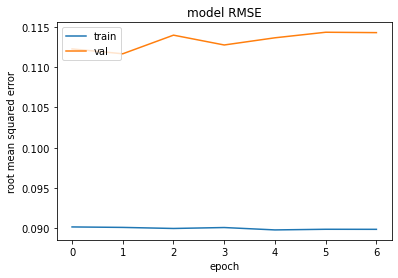

In [ ]:
history_2 = model_2.fit(X_train_ny2, y_train_ny2, validation_data=(X_val1_ny2, y_val1_ny2), epochs=50, callbacks=[early_stopping_monitor],verbose=False)

# summarize history for rmse
plt.plot(history_2.history['root_mean_squared_error'])
plt.plot(history_2.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
print(classification_report(test_results_2['actuals'], test_results_2['predictions']))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       508
         1.0       0.99      0.99      0.99       208
         2.0       0.88      0.88      0.88         8

    accuracy                           0.99       724
   macro avg       0.95      0.95      0.95       724
weighted avg       0.99      0.99      0.99       724



###comparing all the LSTM models

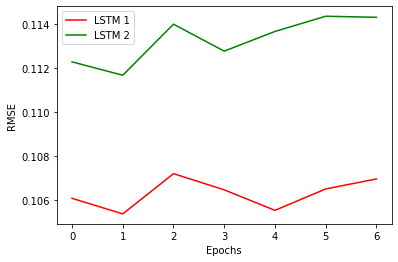

In [ ]:
plt.plot(history_1.history['val_root_mean_squared_error'], 'r',
         history_2.history['val_root_mean_squared_error'],'g')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['LSTM 1', 'LSTM 2'], loc='upper left')
plt.show()

####predicting for 1 jan 2021 until 1 feb 2021 using the 2nd model

In [ ]:
df_date = pd.DataFrame({
    'date':pd.date_range(start='2021-01-01', end='2021-02-01')
})
df_date

date
0  2021-01-01
1  2021-01-02
2  2021-01-03
3  2021-01-04
4  2021-01-05
5  2021-01-06
6  2021-01-07
7  2021-01-08
8  2021-01-09
9  2021-01-10
10 2021-01-11
11 2021-01-12
12 2021-01-13
13 2021-01-14
14 2021-01-15
15 2021-01-16
16 2021-01-17
17 2021-01-18
18 2021-01-19
19 2021-01-20
20 2021-01-21
21 2021-01-22
22 2021-01-23
23 2021-01-24
24 2021-01-25
25 2021-01-26
26 2021-01-27
27 2021-01-28
28 2021-01-29
29 2021-01-30
30 2021-01-31
31 2021-02-01

In [ ]:
df_date.index = pd.to_datetime(df_date['date'], format='%Y.%m.%d')
df_date

date
date                 
2021-01-01 2021-01-01
2021-01-02 2021-01-02
2021-01-03 2021-01-03
2021-01-04 2021-01-04
2021-01-05 2021-01-05
2021-01-06 2021-01-06
2021-01-07 2021-01-07
2021-01-08 2021-01-08
2021-01-09 2021-01-09
2021-01-10 2021-01-10
2021-01-11 2021-01-11
2021-01-12 2021-01-12
2021-01-13 2021-01-13
2021-01-14 2021-01-14
2021-01-15 2021-01-15
2021-01-16 2021-01-16
2021-01-17 2021-01-17
2021-01-18 2021-01-18
2021-01-19 2021-01-19
2021-01-20 2021-01-20
2021-01-21 2021-01-21
2021-01-22 2021-01-22
2021-01-23 2021-01-23
2021-01-24 2021-01-24
2021-01-25 2021-01-25
2021-01-26 2021-01-26
2021-01-27 2021-01-27
2021-01-28 2021-01-28
2021-01-29 2021-01-29
2021-01-30 2021-01-30
2021-01-31 2021-01-31
2021-02-01 2021-02-01

In [ ]:
df_date['Seconds'] = df_date.index.map(pd.Timestamp.timestamp)
df_date

date       Seconds
date                               
2021-01-01 2021-01-01  1.609459e+09
2021-01-02 2021-01-02  1.609546e+09
2021-01-03 2021-01-03  1.609632e+09
2021-01-04 2021-01-04  1.609718e+09
2021-01-05 2021-01-05  1.609805e+09
2021-01-06 2021-01-06  1.609891e+09
2021-01-07 2021-01-07  1.609978e+09
2021-01-08 2021-01-08  1.610064e+09
2021-01-09 2021-01-09  1.610150e+09
2021-01-10 2021-01-10  1.610237e+09
2021-01-11 2021-01-11  1.610323e+09
2021-01-12 2021-01-12  1.610410e+09
2021-01-13 2021-01-13  1.610496e+09
2021-01-14 2021-01-14  1.610582e+09
2021-01-15 2021-01-15  1.610669e+09
2021-01-16 2021-01-16  1.610755e+09
2021-01-17 2021-01-17  1.610842e+09
2021-01-18 2021-01-18  1.610928e+09
2021-01-19 2021-01-19  1.611014e+09
2021-01-20 2021-01-20  1.611101e+09
2021-01-21 2021-01-21  1.611187e+09
2021-01-22 2021-01-22  1.611274e+09
2021-01-23 2021-01-23  1.611360e+09
2021-01-24 2021-01-24  1.611446e+09
2021-01-25 2021-01-25  1.611533e+09
2021-01-26 2021-01-26  1.611619e+09
2021-01-27 2021-01-27  1.611706e+09
2021-01-28 2021-01-28  1.611792e+09
2021-01-29 2021-01-29  1.611878e+09
2021-01-30 2021-01-30  1.611965e+09
2021-01-31 2021-01-31  1.612051e+09
2021-02-01 2021-02-01  1.612138e+09

In [ ]:
df_date['Day sin'] = np.sin(df_date['Seconds'] * (2* np.pi / day))
df_date['Day cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / day))
df_date['Month sin'] = np.sin(df_date['Seconds'] * (2* np.pi / month))
df_date['Month cos'] = np.cos(df_date['Seconds'] * (2* np.pi / month))
df_date['Year sin'] = np.sin(df_date['Seconds'] * (2 * np.pi / year))
df_date['Year cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / year))
df_date.head()

date       Seconds       Day sin  Day cos  Month sin  \
date                                                                    
2021-01-01 2021-01-01  1.609459e+09 -6.012051e-12      1.0   0.114525   
2021-01-02 2021-01-02  1.609546e+09 -1.713513e-12      1.0   0.315714   
2021-01-03 2021-01-03  1.609632e+09 -1.196689e-11      1.0   0.503497   
2021-01-04 2021-01-04  1.609718e+09 -7.668351e-12      1.0   0.669900   
2021-01-05 2021-01-05  1.609805e+09 -3.369812e-12      1.0   0.807857   

            Month cos  Year sin  Year cos  
date                                       
2021-01-01   0.993420  0.010881  0.999941  
2021-01-02   0.948854  0.028080  0.999606  
2021-01-03   0.863997  0.045271  0.998975  
2021-01-04   0.742451  0.062448  0.998048  
2021-01-05   0.589379  0.079608  0.996826

In [ ]:
df_date = df_date.drop('Seconds', axis=1)
df_date = df_date.drop('date',axis=1)
df_date.head()

Day sin  Day cos  Month sin  Month cos  Year sin  Year cos
date                                                                       
2021-01-01 -6.012051e-12      1.0   0.114525   0.993420  0.010881  0.999941
2021-01-02 -1.713513e-12      1.0   0.315714   0.948854  0.028080  0.999606
2021-01-03 -1.196689e-11      1.0   0.503497   0.863997  0.045271  0.998975
2021-01-04 -7.668351e-12      1.0   0.669900   0.742451  0.062448  0.998048
2021-01-05 -3.369812e-12      1.0   0.807857   0.589379  0.079608  0.996826

In [ ]:
df_date.insert(0, "score", [0 for i in range(32)], True)
df_date

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2021-01-01      0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02      0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03      0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04      0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05      0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06      0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07      0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08      0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09      0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10      0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11      0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12      0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13      0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14      0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15      0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16      0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17      0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18      0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19      0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20      0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21      0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22      0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23      0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24      0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25      0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26      0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27      0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28      0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29      0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30      0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31      0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01      0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861  
2021-01-31  0.864338  
2021-02-01  0.855559

In [ ]:
x_test = scoreny_test_df.tail(7)
x_test

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    1.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    1.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    1.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    1.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    1.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    1.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    1.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980

In [ ]:
x_test1 = x_test.append(df_date)
x_test1

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    1.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    1.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    1.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    1.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    1.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    1.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    1.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   
2021-01-01    0.0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02    0.0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03    0.0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04    0.0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05    0.0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06    0.0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07    0.0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08    0.0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09    0.0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10    0.0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11    0.0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12    0.0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13    0.0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14    0.0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15    0.0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16    0.0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17    0.0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18    0.0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19    0.0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20    0.0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21    0.0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22    0.0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23    0.0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24    0.0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25    0.0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26    0.0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27    0.0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28    0.0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29    0.0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30    0.0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31    0.0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01    0.0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861 

In [ ]:
WINDOW_SIZE = 7
X_test1_ny2_new, y_test1_ny2_new = df_to_X_y2(x_test1, WINDOW_SIZE)
X_test1_ny2_new.shape

(32, 7, 7)

In [ ]:
test_prediction_2_new = model_2.predict(X_test1_ny2_new).flatten()
test_results_2_new = pd.DataFrame(data={'predictions':test_prediction_2_new})
test_results_2_new

1/1 [==============================] - 0s 19ms/step


predictions
0      0.673943
1      0.210589
2      0.211343
3      0.211937
4      0.218225
5      0.222911
6      0.225255
7      0.225791
8      0.225460
9      0.225114
10     0.224884
11     0.224766
12     0.224615
13     0.224206
14     0.223329
15     0.221884
16     0.219940
17     0.217723
18     0.215544
19     0.213694
20     0.212357
21     0.211565
22     0.211207
23     0.211094
24     0.211044
25     0.210965
26     0.210885
27     0.210946
28     0.211349
29     0.212275
30     0.213813
31     0.215917

#####result

In [ ]:
test_results_2_new.predictions[test_results_2_new.predictions <0.5] = 0
test_results_2_new.predictions[(test_results_2_new.predictions >=0.5)&(test_results_2_new.predictions<1.5)] = 1
test_results_2_new.predictions[(test_results_2_new.predictions >=1.5)&(test_results_2_new.predictions<2.5)] = 2
test_results_2_new.predictions[(test_results_2_new.predictions >=2.5)&(test_results_2_new.predictions<3.5)] = 3
test_results_2_new.predictions[(test_results_2_new.predictions >=3.5)&(test_results_2_new.predictions<4.5)] = 4
test_results_2_new.predictions[(test_results_2_new.predictions >=4.5)&(test_results_2_new.predictions<5.5)] = 5
test_results_2_new

predictions
0           1.0
1           0.0
2           0.0
3           0.0
4           0.0
5           0.0
6           0.0
7           0.0
8           0.0
9           0.0
10          0.0
11          0.0
12          0.0
13          0.0
14          0.0
15          0.0
16          0.0
17          0.0
18          0.0
19          0.0
20          0.0
21          0.0
22          0.0
23          0.0
24          0.0
25          0.0
26          0.0
27          0.0
28          0.0
29          0.0
30          0.0
31          0.0

##Dakota, Minnesota

###train

In [ ]:
mn = train[train['fips']==27037]

#using interpolation to fill in the NaN values
mn = mn.interpolate().fillna(method='bfill')
mn.score[mn.score <0.5] = 0
mn.score[(mn.score >=0.5)&(mn.score<1.5)] = 1
mn.score[(mn.score >=1.5)&(mn.score<2.5)] = 2
mn.score[(mn.score >=2.5)&(mn.score<3.5)] = 3
mn.score[(mn.score >=3.5)&(mn.score<4.5)] = 4
mn.score[(mn.score >=4.5)&(mn.score<5.5)] = 5

mn.head()

fips        date  PRECTOT     PS  QV2M   T2M  T2MDEW  T2MWET  \
8060580  27037  2000-01-01     0.11  97.79  2.52 -3.57   -5.75   -5.71   
8060581  27037  2000-01-02     2.15  97.37  2.93 -2.17   -3.90   -3.88   
8060582  27037  2000-01-03     0.34  98.25  2.09 -5.80   -7.85   -7.80   
8060583  27037  2000-01-04     0.41  98.47  1.34 -9.46  -13.10  -12.82   
8060584  27037  2000-01-05     2.86  97.92  1.81 -8.14  -10.23  -10.12   

         T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
8060580    -0.57    -7.88       7.31  -3.71   4.99       6.05       3.80   
8060581     0.94    -6.53       7.47  -2.41   5.50       8.08       3.36   
8060582    -3.72    -7.48       3.75  -5.82   4.33       6.68       2.96   
8060583    -6.16   -13.93       7.77 -10.01   5.66       8.54       1.07   
8060584    -3.76   -14.39      10.62  -8.47   7.09       9.92       3.27   

         WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
8060580         2.26   7.18       8.98       5.35         3.63    1.0  
8060581         4.72   7.76       9.85       6.25         3.60    1.0  
8060582         3.72   6.00       8.94       3.30         5.63    1.0  
8060583         7.47   7.27      10.64       1.55         9.09    1.0  
8060584         6.65   9.51      12.64       6.05         6.59    1.0

In [ ]:
dakota = train[train['fips']==27037]

#using interpolation to fill in the NaN values
dakota = dakota.interpolate().fillna(method='bfill')
dakota.score[dakota.score <0.5] = 0
dakota.score[(dakota.score >=0.5)&(dakota.score<1.5)] = 1
dakota.score[(dakota.score >=1.5)&(dakota.score<2.5)] = 2
dakota.score[(dakota.score >=2.5)&(dakota.score<3.5)] = 3
dakota.score[(dakota.score >=3.5)&(dakota.score<4.5)] = 4
dakota.score[(dakota.score >=4.5)&(dakota.score<5.5)] = 5

#merging the weather data with the soil data
dakota = dakota.merge(soil, left_on='fips', right_on='fips')
train_mn = dakota.copy()
dakota['date'] = pd.to_datetime(dakota['date'], format='%Y.%m.%d')
train_mn['tahun'] = dakota['date'].dt.year
train_mn['bulan'] = dakota['date'].dt.month
train_mn['tanggal'] = dakota['date'].dt.day
train_mn[0:31]

fips        date  PRECTOT      PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   27037  2000-01-01     0.11   97.79  2.52  -3.57   -5.75   -5.71    -0.57   
1   27037  2000-01-02     2.15   97.37  2.93  -2.17   -3.90   -3.88     0.94   
2   27037  2000-01-03     0.34   98.25  2.09  -5.80   -7.85   -7.80    -3.72   
3   27037  2000-01-04     0.41   98.47  1.34  -9.46  -13.10  -12.82    -6.16   
4   27037  2000-01-05     2.86   97.92  1.81  -8.14  -10.23  -10.12    -3.76   
5   27037  2000-01-06     0.07   98.40  1.72  -7.37  -10.32  -10.18    -4.48   
6   27037  2000-01-07     0.11   98.69  1.53  -9.92  -11.96  -11.85    -4.60   
7   27037  2000-01-08     0.01   97.51  2.65  -3.49   -5.13   -5.11     3.43   
8   27037  2000-01-09     0.66   96.83  3.42  -1.77   -2.14   -2.14     1.94   
9   27037  2000-01-10     0.88   95.83  3.44  -0.41   -1.99   -1.97     2.99   
10  27037  2000-01-11     0.04   97.93  1.15  -9.61  -14.90  -14.39    -2.34   
11  27037  2000-01-12     6.90   98.56  1.21 -11.18  -14.00  -13.75    -9.22   
12  27037  2000-01-13     0.04   99.94  1.27 -11.67  -13.25  -13.16    -6.38   
13  27037  2000-01-14     0.19   99.37  1.79  -7.88   -9.94   -9.88    -0.00   
14  27037  2000-01-15     0.00   98.21  2.47  -4.11   -6.11   -6.06     2.36   
15  27037  2000-01-16     0.06  100.01  1.05 -11.95  -15.25  -14.94    -7.36   
16  27037  2000-01-17     0.17   99.04  1.90  -6.66   -9.07   -8.98    -1.84   
17  27037  2000-01-18     0.00   98.67  1.42  -9.26  -12.39  -12.18    -5.53   
18  27037  2000-01-19     6.79   98.24  1.17 -12.61  -14.66  -14.46   -10.00   
19  27037  2000-01-20     0.11   98.73  0.64 -19.62  -20.98  -20.76   -11.31   
20  27037  2000-01-21     0.56   98.56  0.65 -19.11  -20.55  -20.31   -14.81   
21  27037  2000-01-22     0.10   97.64  1.38 -11.08  -12.90  -12.79    -4.66   
22  27037  2000-01-23     0.02   98.40  0.76 -16.58  -18.66  -18.34   -14.18   
23  27037  2000-01-24     0.15   98.19  1.18 -13.49  -14.89  -14.80    -6.99   
24  27037  2000-01-25     0.07   98.99  0.94 -14.28  -16.72  -16.42   -10.69   
25  27037  2000-01-26     0.00   99.38  0.78 -16.42  -18.38  -18.14    -9.81   
26  27037  2000-01-27     0.00   99.82  0.97 -15.45  -16.31  -16.27    -7.94   
27  27037  2000-01-28     0.00  100.02  1.25 -12.84  -13.74  -13.71    -5.01   
28  27037  2000-01-29     0.03   99.77  1.29 -11.55  -13.24  -13.15    -5.30   
29  27037  2000-01-30     0.05   98.91  1.44 -10.59  -12.21  -12.14    -3.79   
30  27037  2000-01-31     0.04   98.11  1.74  -8.65  -10.17  -10.12    -3.52   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0     -7.88       7.31  -3.71   4.99       6.05       3.80         2.26   
1     -6.53       7.47  -2.41   5.50       8.08       3.36         4.72   
2     -7.48       3.75  -5.82   4.33       6.68       2.96         3.72   
3    -13.93       7.77 -10.01   5.66       8.54       1.07         7.47   
4    -14.39      10.62  -8.47   7.09       9.92       3.27         6.65   
5    -13.77       9.29  -7.67   6.53       8.14       4.80         3.35   
6    -16.19      11.58 -10.82   5.46       8.39       2.77         5.61   
7     -7.26      10.69  -4.30   4.49       5.60       2.92         2.68   
8     -7.18       9.12  -2.59   4.53       5.99       2.68         3.30   
9     -3.06       6.05  -0.53   5.23       8.61       2.06         6.55   
10   -12.39      10.05  -9.18   6.84      12.47       2.68         9.78   
11   -12.64       3.42 -10.77   6.05       8.32       3.34         4.98   
12   -15.15       8.77 -12.81   2.90       4.32       1.49         2.83   
13   -15.29      15.29  -8.91   5.65      11.22       0.82        10.40   
14   -10.76      13.12  -4.40   4.78      10.13       2.59         7.54   
15   -16.44       9.08 -11.56   6.32       9.70       5.09         4.61   
16   -10.75       8.91  -6.97   7.11       9.91       4.13         5.78   
17   -12.89       7.36 -10.24   4.66       7.08       0.48         6.60   
18   -21.17      11

In [ ]:
train_mn['score'].value_counts()

0.0    3841
2.0    1014
1.0     946
3.0     409
Name: score, dtype: int64

In [ ]:
#For Regression

dakota = train[train['fips']==27037]

#using interpolation to fill in the NaN values
dakota = dakota.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
dakota = dakota.merge(soil, left_on='fips', right_on='fips')
train_mn = dakota.copy()
train_mn[2000:2050]

fips        date  PRECTOT     PS   QV2M    T2M  T2MDEW  T2MWET  \
2000  27037  2005-06-23     0.00  97.51  14.01  28.99   18.86   18.86   
2001  27037  2005-06-24     2.53  97.91  10.75  23.81   14.48   14.48   
2002  27037  2005-06-25     0.61  98.26  10.69  22.51   14.55   14.55   
2003  27037  2005-06-26     2.59  97.88  15.67  25.22   20.70   20.70   
2004  27037  2005-06-27    10.14  97.73  15.63  25.52   20.61   20.61   
2005  27037  2005-06-28     1.19  98.00  14.26  24.16   19.20   19.20   
2006  27037  2005-06-29     5.09  97.50  15.65  24.65   20.59   20.59   
2007  27037  2005-06-30     0.09  97.27   9.60  21.01   12.91   12.91   
2008  27037  2005-07-01     0.00  97.95   7.29  19.41    8.90    8.90   
2009  27037  2005-07-02     2.20  97.77   9.27  21.07   12.27   12.27   
2010  27037  2005-07-03     1.07  97.24  11.90  23.38   16.10   16.10   
2011  27037  2005-07-04     0.05  97.86   9.49  22.96   12.80   12.80   
2012  27037  2005-07-05     0.15  98.39   9.73  20.10   13.33   13.33   
2013  27037  2005-07-06     0.00  98.46   8.72  20.81   11.67   11.67   
2014  27037  2005-07-07     0.32  98.36  10.90  23.68   15.01   15.01   
2015  27037  2005-07-08     0.19  98.23  12.06  25.07   16.60   16.60   
2016  27037  2005-07-09     0.00  98.14  12.27  26.92   16.88   16.88   
2017  27037  2005-07-10     0.00  98.20  11.75  27.50   16.20   16.20   
2018  27037  2005-07-11     0.11  98.18  10.64  27.08   14.64   14.64   
2019  27037  2005-07-12     0.19  98.29  10.90  27.09   14.94   14.94   
2020  27037  2005-07-13     0.03  98.25  12.27  28.13   16.88   16.88   
2021  27037  2005-07-14     0.00  98.08  12.36  28.92   16.93   16.93   
2022  27037  2005-07-15     0.44  98.03  12.80  29.40   17.51   17.51   
2023  27037  2005-07-16     0.00  97.80  12.94  30.23   17.63   17.63   
2024  27037  2005-07-17     4.83  97.35  13.42  29.56   18.08   18.09   
2025  27037  2005-07-18     0.35  97.52   9.25  23.55   12.19   12.19   
2026  27037  2005-07-19     0.01  97.96   9.02  24.66   12.03   12.03   
2027  27037  2005-07-20     7.47  97.74  14.17  26.72   18.78   18.78   
2028  27037  2005-07-21     0.85  98.15  10.58  27.06   14.26   14.26   
2029  27037  2005-07-22     0.00  98.39  10.84  26.90   14.84   14.84   
2030  27037  2005-07-23     5.06  97.77  14.80  28.33   19.74   19.74   
2031  27037  2005-07-24     0.42  97.68  12.57  28.55   16.87   16.87   
2032  27037  2005-07-25    18.99  97.54  14.45  23.69   19.06   19.06   
2033  27037  2005-07-26     0.12  98.11   7.75  17.54    9.67    9.67   
2034  27037  2005-07-27     0.02  98.50   6.52  18.74    7.37    7.38   
2035  27037  2005-07-28     0.20  98.22   7.68  21.25    9.69    9.69   
2036  27037  2005-07-29     0.00  98.66   9.01  21.73   12.13   12.13   
2037  27037  2005-07-30     0.06  98.36  10.54  25.76   14.50   14.50   
2038  27037  2005-07-31     0.01  98.24  11.88  26.86   16.38   16.38   
2039  27037  2005-08-01     0.00  98.19  12.46  27.12   17.11   17.11   
2040  27037  2005-08-02     0.02  97.76  12.30  28.59   16.80   16.80   
2041  27037  2005-08-03     6.20  97.51  14.71  27.15   19.60   19.60   
2042  27037  2005-08-04     0.04  98.44   7.47  23.50    8.86    8.87   
2043  27037  2005-08-05     0.01  98.91   6.23  22.24    6.65    6.67   
2044  27037  2005-08-06     0.00  98.47   6.40  22.90    7.03    7.05   
2045  27037  2005-08-07     1.78  98.07  10.11  25.98   13.60   13.60   
2046  27037  2005-08-08     1.33  97.83  11.40  27.85   15.63   15.63   
2047  27037  2005-08-09    10.69  97.84  13.67  24.87   18.45   18.45   
2048  27037  2005-08-10     0.00  98.27   8.92  23.11   11.73   11.74   
2049  27037  2005-08-11     4.23  97.92  10.84  20.66   14.56   14.56   

      T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
2000    35.38    23.06      12.32  28.96   7.69      10.07       5.79   
2001    27.99    19.10       8.89  24.14   3.73       7.69       1.68   
2002    28.83    15.23      13.60  23.02   3.46       5.11      

###validation

In [ ]:
mn_val = validation[validation['fips']==27037]

#using interpolation to fill in the NaN values
mn_val = mn_val.interpolate().fillna(method='bfill')
mn_val.score[mn_val.score <0.5] = 0
mn_val.score[(mn_val.score >=0.5)&(mn_val.score<1.5)] = 1
mn_val.score[(mn_val.score >=1.5)&(mn_val.score<2.5)] = 2
mn_val.score[(mn_val.score >=2.5)&(mn_val.score<3.5)] = 3
mn_val.score[(mn_val.score >=3.5)&(mn_val.score<4.5)] = 4
mn_val.score[(mn_val.score >=4.5)&(mn_val.score<5.5)] = 5

mn_val.head()

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
947540  27037  2017-01-01     0.03  98.07  1.97  -7.26   -8.78   -8.74   
947541  27037  2017-01-02     1.58  98.14  2.73  -3.81   -4.76   -4.75   
947542  27037  2017-01-03     0.08  98.29  1.47 -11.36  -12.76  -12.64   
947543  27037  2017-01-04     0.01  98.63  0.52 -21.40  -22.63  -22.31   
947544  27037  2017-01-05     0.02  98.49  0.47 -22.39  -23.69  -23.30   

        T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
947540    -2.34   -12.83      10.49  -7.94   3.68       6.50       1.69   
947541    -1.04    -6.71       5.67  -4.21   4.61       5.81       0.34   
947542    -3.16   -18.31      15.16 -11.61   8.35      10.50       0.80   
947543   -18.01   -25.28       7.26 -21.98   6.82       9.47       3.85   
947544   -18.16   -24.96       6.80 -22.59   4.20       5.33       3.28   

        WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
947540         4.80   6.17      10.13       1.97         8.16    0.0  
947541         5.47   6.63       8.22       0.54         7.68    0.0  
947542         9.70  10.67      12.93       1.32        11.61    0.0  
947543         5.63   9.34      12.14       6.51         5.63    0.0  
947544         2.05   6.37       8.13       5.46         2.67    0.0

In [ ]:
dakota_val = validation[validation['fips']==27037]

#using interpolation to fill in the NaN values
dakota_val = dakota_val.interpolate().fillna(method='bfill')
dakota_val.score[dakota_val.score <0.5] = 0
dakota_val.score[(dakota_val.score >=0.5)&(dakota_val.score<1.5)] = 1
dakota_val.score[(dakota_val.score >=1.5)&(dakota_val.score<2.5)] = 2
dakota_val.score[(dakota_val.score >=2.5)&(dakota_val.score<3.5)] = 3
dakota_val.score[(dakota_val.score >=3.5)&(dakota_val.score<4.5)] = 4
dakota_val.score[(dakota_val.score >=4.5)&(dakota_val.score<5.5)] = 5

#merging the weather data with the soil data
dakota_val = dakota_val.merge(soil, left_on='fips', right_on='fips')
val_mn = dakota_val.copy()
dakota_val['date'] = pd.to_datetime(dakota_val['date'], format='%Y.%m.%d')
val_mn['tahun'] = dakota_val['date'].dt.year
val_mn['bulan'] = dakota_val['date'].dt.month
val_mn['tanggal'] = dakota_val['date'].dt.day
val_mn[0:31]

fips        date  PRECTOT      PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   27037  2017-01-01     0.03   98.07  1.97  -7.26   -8.78   -8.74    -2.34   
1   27037  2017-01-02     1.58   98.14  2.73  -3.81   -4.76   -4.75    -1.04   
2   27037  2017-01-03     0.08   98.29  1.47 -11.36  -12.76  -12.64    -3.16   
3   27037  2017-01-04     0.01   98.63  0.52 -21.40  -22.63  -22.31   -18.01   
4   27037  2017-01-05     0.02   98.49  0.47 -22.39  -23.69  -23.30   -18.16   
5   27037  2017-01-06     0.01   98.96  0.51 -22.29  -23.43  -23.19   -15.38   
6   27037  2017-01-07     0.00   99.97  0.55 -21.45  -22.06  -21.99   -14.50   
7   27037  2017-01-08     0.15   99.49  0.86 -17.68  -18.59  -18.59   -10.92   
8   27037  2017-01-09     2.14   98.07  1.74  -9.40  -10.57  -10.51    -4.53   
9   27037  2017-01-10     7.94   96.65  1.92  -8.63   -9.74   -9.68    -4.04   
10  27037  2017-01-11     1.18   97.78  0.84 -16.87  -17.89  -17.74   -12.54   
11  27037  2017-01-12     0.00   99.00  0.70 -18.62  -20.16  -19.87   -10.63   
12  27037  2017-01-13     0.00  100.47  0.52 -21.77  -22.97  -22.66   -15.04   
13  27037  2017-01-14     0.00   99.74  0.97 -16.10  -16.84  -16.77    -7.90   
14  27037  2017-01-15     0.01   99.12  1.48 -11.94  -12.52  -12.51    -2.89   
15  27037  2017-01-16     6.46   98.45  2.37  -5.76   -6.69   -6.67    -2.15   
16  27037  2017-01-17     1.06   98.07  2.25  -6.07   -7.23   -7.20    -2.64   
17  27037  2017-01-18     0.02   97.79  2.77  -4.05   -4.86   -4.84     0.49   
18  27037  2017-01-19     0.76   97.39  3.48  -1.18   -1.69   -1.68     0.58   
19  27037  2017-01-20     1.02   96.78  3.95   0.36    0.05    0.05     0.47   
20  27037  2017-01-21     1.99   96.34  3.96   0.48    0.01    0.01     1.25   
21  27037  2017-01-22     0.36   97.12  3.87   0.27   -0.18   -0.18     1.79   
22  27037  2017-01-23     0.14   97.57  3.21  -1.41   -2.61   -2.60     0.78   
23  27037  2017-01-24     1.26   97.59  3.02  -2.06   -3.44   -3.42     0.25   
24  27037  2017-01-25     3.52   97.24  2.80  -3.05   -4.41   -4.39    -2.20   
25  27037  2017-01-26     0.10   97.90  2.01  -6.20   -8.49   -8.42    -2.46   
26  27037  2017-01-27     0.01   97.70  1.96  -7.41   -8.92   -8.87    -2.45   
27  27037  2017-01-28     0.02   97.61  2.01  -6.47   -8.41   -8.36    -2.58   
28  27037  2017-01-29     0.04   97.89  1.47  -9.67  -12.04  -11.92    -4.77   
29  27037  2017-01-30     2.12   96.94  2.77  -4.07   -5.61   -5.57     3.71   
30  27037  2017-01-31     0.99   97.37  3.39  -0.34   -1.96   -1.94     2.03   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0    -12.83      10.49  -7.94   3.68       6.50       1.69         4.80   
1     -6.71       5.67  -4.21   4.61       5.81       0.34         5.47   
2    -18.31      15.16 -11.61   8.35      10.50       0.80         9.70   
3    -25.28       7.26 -21.98   6.82       9.47       3.85         5.63   
4    -24.96       6.80 -22.59   4.20       5.33       3.28         2.05   
5    -29.28      13.91 -24.01   2.95       4.06       1.40         2.65   
6    -25.35      10.84 -23.41   4.31       6.11       2.80         3.31   
7    -28.03      17.12 -20.06   5.20       7.88       0.41         7.48   
8    -16.23      11.70 -10.46   4.62       8.25       0.34         7.91   
9    -16.60      12.57  -9.01   6.81      12.54       1.06        11.48   
10   -21.02       8.48 -17.43   3.52       6.28       1.51         4.78   
11   -27.26      16.63 -19.72   5.11      10.32       1.62         8.70   
12   -30.08      15.04 -22.31   3.03       4.35       1.65         2.70   
13   -22.55      14.65 -18.77   3.66       4.76       2.25         2.51   
14   -18.86      15.97 -13.44   3.27       4.81       1.67         3.13   
15   -10.45       8.31  -6.61   3.24       4.15       1.51         2.64   
16   -10.29       7.65  -6.70   4.19       4.95       2.60         2.35   
17    -9.05       9.54  -4.74   5.49       6.70       4.44         2.26   
18    -4.18       4

In [ ]:
val_mn['score'].value_counts()

0.0    709
1.0     21
Name: score, dtype: int64

In [ ]:
#For Regression

dakota_val = validation[validation['fips']==27037]

#using interpolation to fill in the NaN values
dakota_val = dakota_val.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
dakota_val = dakota_val.merge(soil, left_on='fips', right_on='fips')
val_mn = dakota_val.copy()
val_mn[0:31]

fips        date  PRECTOT      PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   27037  2017-01-01     0.03   98.07  1.97  -7.26   -8.78   -8.74    -2.34   
1   27037  2017-01-02     1.58   98.14  2.73  -3.81   -4.76   -4.75    -1.04   
2   27037  2017-01-03     0.08   98.29  1.47 -11.36  -12.76  -12.64    -3.16   
3   27037  2017-01-04     0.01   98.63  0.52 -21.40  -22.63  -22.31   -18.01   
4   27037  2017-01-05     0.02   98.49  0.47 -22.39  -23.69  -23.30   -18.16   
5   27037  2017-01-06     0.01   98.96  0.51 -22.29  -23.43  -23.19   -15.38   
6   27037  2017-01-07     0.00   99.97  0.55 -21.45  -22.06  -21.99   -14.50   
7   27037  2017-01-08     0.15   99.49  0.86 -17.68  -18.59  -18.59   -10.92   
8   27037  2017-01-09     2.14   98.07  1.74  -9.40  -10.57  -10.51    -4.53   
9   27037  2017-01-10     7.94   96.65  1.92  -8.63   -9.74   -9.68    -4.04   
10  27037  2017-01-11     1.18   97.78  0.84 -16.87  -17.89  -17.74   -12.54   
11  27037  2017-01-12     0.00   99.00  0.70 -18.62  -20.16  -19.87   -10.63   
12  27037  2017-01-13     0.00  100.47  0.52 -21.77  -22.97  -22.66   -15.04   
13  27037  2017-01-14     0.00   99.74  0.97 -16.10  -16.84  -16.77    -7.90   
14  27037  2017-01-15     0.01   99.12  1.48 -11.94  -12.52  -12.51    -2.89   
15  27037  2017-01-16     6.46   98.45  2.37  -5.76   -6.69   -6.67    -2.15   
16  27037  2017-01-17     1.06   98.07  2.25  -6.07   -7.23   -7.20    -2.64   
17  27037  2017-01-18     0.02   97.79  2.77  -4.05   -4.86   -4.84     0.49   
18  27037  2017-01-19     0.76   97.39  3.48  -1.18   -1.69   -1.68     0.58   
19  27037  2017-01-20     1.02   96.78  3.95   0.36    0.05    0.05     0.47   
20  27037  2017-01-21     1.99   96.34  3.96   0.48    0.01    0.01     1.25   
21  27037  2017-01-22     0.36   97.12  3.87   0.27   -0.18   -0.18     1.79   
22  27037  2017-01-23     0.14   97.57  3.21  -1.41   -2.61   -2.60     0.78   
23  27037  2017-01-24     1.26   97.59  3.02  -2.06   -3.44   -3.42     0.25   
24  27037  2017-01-25     3.52   97.24  2.80  -3.05   -4.41   -4.39    -2.20   
25  27037  2017-01-26     0.10   97.90  2.01  -6.20   -8.49   -8.42    -2.46   
26  27037  2017-01-27     0.01   97.70  1.96  -7.41   -8.92   -8.87    -2.45   
27  27037  2017-01-28     0.02   97.61  2.01  -6.47   -8.41   -8.36    -2.58   
28  27037  2017-01-29     0.04   97.89  1.47  -9.67  -12.04  -11.92    -4.77   
29  27037  2017-01-30     2.12   96.94  2.77  -4.07   -5.61   -5.57     3.71   
30  27037  2017-01-31     0.99   97.37  3.39  -0.34   -1.96   -1.94     2.03   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0    -12.83      10.49  -7.94   3.68       6.50       1.69         4.80   
1     -6.71       5.67  -4.21   4.61       5.81       0.34         5.47   
2    -18.31      15.16 -11.61   8.35      10.50       0.80         9.70   
3    -25.28       7.26 -21.98   6.82       9.47       3.85         5.63   
4    -24.96       6.80 -22.59   4.20       5.33       3.28         2.05   
5    -29.28      13.91 -24.01   2.95       4.06       1.40         2.65   
6    -25.35      10.84 -23.41   4.31       6.11       2.80         3.31   
7    -28.03      17.12 -20.06   5.20       7.88       0.41         7.48   
8    -16.23      11.70 -10.46   4.62       8.25       0.34         7.91   
9    -16.60      12.57  -9.01   6.81      12.54       1.06        11.48   
10   -21.02       8.48 -17.43   3.52       6.28       1.51         4.78   
11   -27.26      16.63 -19.72   5.11      10.32       1.62         8.70   
12   -30.08      15.04 -22.31   3.03       4.35       1.65         2.70   
13   -22.55      14.65 -18.77   3.66       4.76       2.25         2.51   
14   -18.86      15.97 -13.44   3.27       4.81       1.67         3.13   
15   -10.45       8.31  -6.61   3.24       4.15       1.51         2.64   
16   -10.29       7.65  -6.70   4.19       4.95       2.60         2.35   
17    -9.05       9.54  -4.74   5.49       6.70       4.44         2.26   
18    -4.18       4

###test

In [ ]:
mn_test = test[test['fips']==27037]

#using interpolation to fill in the NaN values
mn_test = mn_test.interpolate().fillna(method='bfill')
mn_test.score[mn_test.score <0.5] = 0
mn_test.score[(mn_test.score >=0.5)&(mn_test.score<1.5)] = 1
mn_test.score[(mn_test.score >=1.5)&(mn_test.score<2.5)] = 2
mn_test.score[(mn_test.score >=2.5)&(mn_test.score<3.5)] = 3
mn_test.score[(mn_test.score >=3.5)&(mn_test.score<4.5)] = 4
mn_test.score[(mn_test.score >=4.5)&(mn_test.score<5.5)] = 5

mn_test.head()

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
948838  27037  2019-01-01     0.00  99.37  0.55 -20.91  -24.14  -21.97   
948839  27037  2019-01-02     0.02  98.03  1.33 -12.71  -13.96  -13.85   
948840  27037  2019-01-03     0.00  97.44  2.62  -4.96   -5.41   -5.81   
948841  27037  2019-01-04     0.01  97.29  3.12  -2.41   -3.12   -3.13   
948842  27037  2019-01-05     0.01  97.82  3.10  -2.38   -3.11   -3.17   

        T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
948838   -15.74   -26.99      11.25 -22.80   3.48       7.48       0.85   
948839    -6.44   -24.31      17.87 -13.48   4.96       7.87       3.64   
948840     0.97   -11.65      12.61  -5.62   5.42       6.40       3.89   
948841     1.57    -6.00       7.57  -2.96   3.74       5.54       2.68   
948842     1.93    -7.41       9.34  -3.29   4.48       5.45       3.68   

        WS10M_RANGE  WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score  
948838         6.63   4.89       9.53       1.05         8.48    0.0  
948839         4.23   7.73       9.76       5.31         4.45    0.0  
948840         2.51   8.23       9.78       6.85         2.94    0.0  
948841         2.86   6.22       8.76       3.03         5.73    0.0  
948842         1.77   7.39       8.30       6.58         1.71    0.0

In [ ]:
dakota_test = test[test['fips']==27037]

#using interpolation to fill in the NaN values
dakota_test = dakota_test.interpolate().fillna(method='bfill')
dakota_test.score[dakota_test.score <0.5] = 0
dakota_test.score[(dakota_test.score >=0.5)&(dakota_test.score<1.5)] = 1
dakota_test.score[(dakota_test.score >=1.5)&(dakota_test.score<2.5)] = 2
dakota_test.score[(dakota_test.score >=2.5)&(dakota_test.score<3.5)] = 3
dakota_test.score[(dakota_test.score >=3.5)&(dakota_test.score<4.5)] = 4
dakota_test.score[(dakota_test.score >=4.5)&(dakota_test.score<5.5)] = 5

#merging the weather data with the soil data
dakota_test = dakota_test.merge(soil, left_on='fips', right_on='fips')
test_mn = dakota_test.copy()
dakota_test['date'] = pd.to_datetime(dakota_test['date'], format='%Y.%m.%d')
test_mn['tahun'] = dakota_test['date'].dt.year
test_mn['bulan'] = dakota_test['date'].dt.month
test_mn['tanggal'] = dakota_test['date'].dt.day
test_mn[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   27037  2019-01-01     0.00  99.37  0.55 -20.91  -24.14  -21.97   -15.74   
1   27037  2019-01-02     0.02  98.03  1.33 -12.71  -13.96  -13.85    -6.44   
2   27037  2019-01-03     0.00  97.44  2.62  -4.96   -5.41   -5.81     0.97   
3   27037  2019-01-04     0.01  97.29  3.12  -2.41   -3.12   -3.13     1.57   
4   27037  2019-01-05     0.01  97.82  3.10  -2.38   -3.11   -3.17     1.93   
5   27037  2019-01-06     0.31  98.17  2.74  -3.98   -4.72   -4.92     0.72   
6   27037  2019-01-07     0.18  96.69  4.07   0.85    0.43    0.43     2.84   
7   27037  2019-01-08     0.22  98.05  2.13  -5.52   -8.00   -8.41    -0.03   
8   27037  2019-01-09     0.00  99.49  0.93 -13.87  -17.98  -16.18   -10.64   
9   27037  2019-01-10     0.00  99.27  1.40  -9.80  -13.07  -12.32    -5.14   
10  27037  2019-01-11     0.00  98.75  2.21  -5.91   -7.49   -7.30    -0.48   
11  27037  2019-01-12     0.01  99.30  2.43  -4.72   -6.17   -5.92    -1.36   
12  27037  2019-01-13     0.01  99.40  2.38  -4.61   -6.42   -6.22     0.90   
13  27037  2019-01-14     0.06  98.86  2.63  -3.74   -5.17   -4.98    -0.80   
14  27037  2019-01-15     0.02  98.33  2.41  -4.54   -6.39   -6.45     1.51   
15  27037  2019-01-16     0.00  98.98  1.08 -12.21  -16.28  -14.90    -7.65   
16  27037  2019-01-17     0.15  98.54  1.45  -9.46  -12.75  -11.94    -5.11   
17  27037  2019-01-18     2.93  98.95  0.86 -14.88  -19.01  -17.05   -13.94   
18  27037  2019-01-19     0.03  99.33  0.68 -17.73  -21.72  -19.50   -13.03   
19  27037  2019-01-20     0.00  99.58  0.57 -19.64  -23.62  -21.16   -13.53   
20  27037  2019-01-21     0.27  98.97  1.03 -14.12  -16.84  -15.77    -9.80   
21  27037  2019-01-22     0.58  98.21  1.47 -10.21  -12.69  -11.80    -6.63   
22  27037  2019-01-23     0.14  97.77  1.41 -10.70  -13.23  -12.38    -5.91   
23  27037  2019-01-24     0.27  98.30  0.88 -16.23  -18.83  -18.07    -9.09   
24  27037  2019-01-25     0.01  98.66  0.52 -20.45  -24.66  -21.92   -15.92   
25  27037  2019-01-26     0.31  98.24  0.76 -17.84  -20.58  -18.93   -12.45   
26  27037  2019-01-27     7.66  97.96  0.63 -19.53  -22.67  -20.76   -14.94   
27  27037  2019-01-28     1.26  97.69  0.87 -16.07  -19.05  -17.34   -12.23   
28  27037  2019-01-29     0.04  98.28  0.34 -25.81  -29.53  -26.73   -21.62   
29  27037  2019-01-30     0.02  99.00  0.17 -32.35  -36.58  -32.93   -25.92   
30  27037  2019-01-31     0.13  98.92  0.35 -26.80  -29.15  -27.17   -21.29   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0    -26.99      11.25 -22.80   3.48       7.48       0.85         6.63   
1    -24.31      17.87 -13.48   4.96       7.87       3.64         4.23   
2    -11.65      12.61  -5.62   5.42       6.40       3.89         2.51   
3     -6.00       7.57  -2.96   3.74       5.54       2.68         2.86   
4     -7.41       9.34  -3.29   4.48       5.45       3.68         1.77   
5     -9.05       9.77  -4.31   7.73      13.60       3.72         9.88   
6     -1.13       3.97   0.06   5.59      12.29       3.10         9.19   
7    -12.57      12.53  -5.70   9.46      13.30       3.44         9.86   
8    -15.52       4.88 -13.81   6.63       8.93       2.84         6.09   
9    -14.42       9.29  -9.77   3.80       5.08       1.88         3.20   
10    -9.93       9.45  -6.52   3.19       4.81       0.92         3.89   
11    -6.53       5.17  -4.93   3.83       4.96       2.67         2.29   
12    -8.53       9.43  -5.24   3.34       4.88       2.39         2.49   
13    -5.94       5.15  -4.35   3.26       4.88       0.86         4.03   
14   -12.07      13.58  -5.25   5.90       9.04       0.65         8.39   
15   -16.88       9.24 -12.35   3.84       5.83       2.56         3.27   
16   -14.59       9.49 -10.08   3.14       4.88       0.59         4.29   
17   -16.33       2.39 -14.75   5.32       6.47       3.18         3.29   
18   -23.44      10.41 -17.57   4.92       5.66    

In [ ]:
test_mn['score'].value_counts()

0.0    689
1.0     42
Name: score, dtype: int64

In [ ]:
#For Regression

dakota_test = test[test['fips']==27037]

#using interpolation to fill in the NaN values
dakota_test = dakota_test.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
dakota_test = dakota_test.merge(soil, left_on='fips', right_on='fips')
test_mn = dakota_test.copy()
test_mn[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   27037  2019-01-01     0.00  99.37  0.55 -20.91  -24.14  -21.97   -15.74   
1   27037  2019-01-02     0.02  98.03  1.33 -12.71  -13.96  -13.85    -6.44   
2   27037  2019-01-03     0.00  97.44  2.62  -4.96   -5.41   -5.81     0.97   
3   27037  2019-01-04     0.01  97.29  3.12  -2.41   -3.12   -3.13     1.57   
4   27037  2019-01-05     0.01  97.82  3.10  -2.38   -3.11   -3.17     1.93   
5   27037  2019-01-06     0.31  98.17  2.74  -3.98   -4.72   -4.92     0.72   
6   27037  2019-01-07     0.18  96.69  4.07   0.85    0.43    0.43     2.84   
7   27037  2019-01-08     0.22  98.05  2.13  -5.52   -8.00   -8.41    -0.03   
8   27037  2019-01-09     0.00  99.49  0.93 -13.87  -17.98  -16.18   -10.64   
9   27037  2019-01-10     0.00  99.27  1.40  -9.80  -13.07  -12.32    -5.14   
10  27037  2019-01-11     0.00  98.75  2.21  -5.91   -7.49   -7.30    -0.48   
11  27037  2019-01-12     0.01  99.30  2.43  -4.72   -6.17   -5.92    -1.36   
12  27037  2019-01-13     0.01  99.40  2.38  -4.61   -6.42   -6.22     0.90   
13  27037  2019-01-14     0.06  98.86  2.63  -3.74   -5.17   -4.98    -0.80   
14  27037  2019-01-15     0.02  98.33  2.41  -4.54   -6.39   -6.45     1.51   
15  27037  2019-01-16     0.00  98.98  1.08 -12.21  -16.28  -14.90    -7.65   
16  27037  2019-01-17     0.15  98.54  1.45  -9.46  -12.75  -11.94    -5.11   
17  27037  2019-01-18     2.93  98.95  0.86 -14.88  -19.01  -17.05   -13.94   
18  27037  2019-01-19     0.03  99.33  0.68 -17.73  -21.72  -19.50   -13.03   
19  27037  2019-01-20     0.00  99.58  0.57 -19.64  -23.62  -21.16   -13.53   
20  27037  2019-01-21     0.27  98.97  1.03 -14.12  -16.84  -15.77    -9.80   
21  27037  2019-01-22     0.58  98.21  1.47 -10.21  -12.69  -11.80    -6.63   
22  27037  2019-01-23     0.14  97.77  1.41 -10.70  -13.23  -12.38    -5.91   
23  27037  2019-01-24     0.27  98.30  0.88 -16.23  -18.83  -18.07    -9.09   
24  27037  2019-01-25     0.01  98.66  0.52 -20.45  -24.66  -21.92   -15.92   
25  27037  2019-01-26     0.31  98.24  0.76 -17.84  -20.58  -18.93   -12.45   
26  27037  2019-01-27     7.66  97.96  0.63 -19.53  -22.67  -20.76   -14.94   
27  27037  2019-01-28     1.26  97.69  0.87 -16.07  -19.05  -17.34   -12.23   
28  27037  2019-01-29     0.04  98.28  0.34 -25.81  -29.53  -26.73   -21.62   
29  27037  2019-01-30     0.02  99.00  0.17 -32.35  -36.58  -32.93   -25.92   
30  27037  2019-01-31     0.13  98.92  0.35 -26.80  -29.15  -27.17   -21.29   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0    -26.99      11.25 -22.80   3.48       7.48       0.85         6.63   
1    -24.31      17.87 -13.48   4.96       7.87       3.64         4.23   
2    -11.65      12.61  -5.62   5.42       6.40       3.89         2.51   
3     -6.00       7.57  -2.96   3.74       5.54       2.68         2.86   
4     -7.41       9.34  -3.29   4.48       5.45       3.68         1.77   
5     -9.05       9.77  -4.31   7.73      13.60       3.72         9.88   
6     -1.13       3.97   0.06   5.59      12.29       3.10         9.19   
7    -12.57      12.53  -5.70   9.46      13.30       3.44         9.86   
8    -15.52       4.88 -13.81   6.63       8.93       2.84         6.09   
9    -14.42       9.29  -9.77   3.80       5.08       1.88         3.20   
10    -9.93       9.45  -6.52   3.19       4.81       0.92         3.89   
11    -6.53       5.17  -4.93   3.83       4.96       2.67         2.29   
12    -8.53       9.43  -5.24   3.34       4.88       2.39         2.49   
13    -5.94       5.15  -4.35   3.26       4.88       0.86         4.03   
14   -12.07      13.58  -5.25   5.90       9.04       0.65         8.39   
15   -16.88       9.24 -12.35   3.84       5.83       2.56         3.27   
16   -14.59       9.49 -10.08   3.14       4.88       0.59         4.29   
17   -16.33       2.39 -14.75   5.32       6.47       3.18         3.29   
18   -23.44      10.41 -17.57   4.92       5.66    

###MLP model with weather and soil data (without date variable) REGRESSION

####preprocessing data

In [ ]:
score_mn = train_mn['score']
score_val_mn = val_mn['score']
score_test_mn = test_mn['score']

In [ ]:
score_arr_mn = score_mn.copy()
score_val_arr_mn = score_val_mn.copy()
score_test_arr_mn = score_test_mn.copy()

In [ ]:
score_arr_mn = score_arr_mn.to_numpy()
score_val_arr_mn = score_val_arr_mn.to_numpy()
score_test_arr_mn = score_test_arr_mn.to_numpy()

In [ ]:
score_arr_mn

array([0.9108, 0.9108, 0.9108, ..., 0.    , 0.    , 0.    ])

In [ ]:
score_arr_mn =pd.DataFrame(score_arr_mn, columns=['Score']) 
score_arr_mn

Score
0     0.910800
1     0.910800
2     0.910800
3     0.910800
4     0.923543
...        ...
6205  0.000000
6206  0.000000
6207  0.000000
6208  0.000000
6209  0.000000

[6210 rows x 1 columns]

In [ ]:
score_val_arr_mn =pd.DataFrame(score_val_arr_mn, columns=['Score']) 
score_val_arr_mn

Score
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
..     ...
725    0.0
726    0.0
727    0.0
728    0.0
729    0.0

[730 rows x 1 columns]

In [ ]:
score_test_arr_mn =pd.DataFrame(score_test_arr_mn, columns=['Score']) 
score_test_arr_mn

Score
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
..     ...
726    1.0
727    1.0
728    1.0
729    1.0
730    1.0

[731 rows x 1 columns]

In [ ]:
dakota_train = train_mn.copy()
dakota_val = val_mn.copy()
dakota_test = test_mn.copy()

In [ ]:
X1_mn = dakota_train.drop(columns=['fips','date','score'])
X_mn_val = dakota_val.drop(columns=['fips','date','score'])
X_mn_test = dakota_test.drop(columns=['fips','date','score'])

In [ ]:
X1_mn, y1_mn = X1_mn, score_arr_mn
X_val_mn, y_val_mn = X_mn_val, score_val_arr_mn
X_test_mn, y_test_mn = X_mn_test, score_test_arr_mn
X1_mn.shape, y1_mn.shape, X_val_mn.shape, y_val_mn.shape, X_test_mn.shape, y_test_mn.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 1))

####build the model

In [ ]:
new_model_reg_mn1 = Sequential()
new_model_reg_mn1.add(tf.keras.Input(shape=(49,)))
new_model_reg_mn1.add(BatchNormalization())
new_model_reg_mn1.add(Dense(128, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_mn1.add(BatchNormalization())
new_model_reg_mn1.add(Dense(64, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_mn1.add(BatchNormalization())
new_model_reg_mn1.add((Dense(1, activation='linear')))
new_model_reg_mn1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_24 (Dense)            (None, 128)               6400      
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_8 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                      

In [ ]:
opt_reg_mn1 = keras.optimizers.Adam(learning_rate=0.001)
new_model_reg_mn1.compile(optimizer = opt_reg_mn1, loss =MeanSquaredError(), metrics =[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_reg_mn1.fit(X1_mn, y1_mn, validation_data = (X_val_mn,y_val_mn),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor])

Epoch 1/50
98/98 [==============================] - 4s 13ms/step - loss: 1.0286 - root_mean_squared_error: 1.0142 - val_loss: 9213.7500 - val_root_mean_squared_error: 95.9883
Epoch 2/50
98/98 [==============================] - 1s 8ms/step - loss: 0.8450 - root_mean_squared_error: 0.9192 - val_loss: 3129.8879 - val_root_mean_squared_error: 55.9454
Epoch 3/50
98/98 [==============================] - 1s 7ms/step - loss: 0.8215 - root_mean_squared_error: 0.9064 - val_loss: 971.6794 - val_root_mean_squared_error: 31.1718
Epoch 4/50
98/98 [==============================] - 1s 7ms/step - loss: 0.8263 - root_mean_squared_error: 0.9090 - val_loss: 291.4009 - val_root_mean_squared_error: 17.0705
Epoch 5/50
98/98 [==============================] - 1s 5ms/step - loss: 0.8093 - root_mean_squared_error: 0.8996 - val_loss: 117.7388 - val_root_mean_squared_error: 10.8507
Epoch 6/50
98/98 [==============================] - 1s 6ms/step - loss: 0.8003 - root_mean_squared_error: 0.8946 - val_loss: 43.1431

In [ ]:
test_predictions_reg_mn1 = new_model_reg_mn1.predict(X_test_mn).flatten()
test_predictions_reg_mn1

23/23 [==============================] - 0s 3ms/step


array([ 9.60706055e-01,  6.76363170e-01,  7.82226920e-01,  8.23945224e-01,
        7.05578923e-01,  1.00510919e+00,  6.29965603e-01,  9.18271184e-01,
        9.06198800e-01,  8.22322130e-01,  5.86374938e-01,  5.40772796e-01,
        5.21328747e-01,  4.69876528e-01,  7.86183536e-01,  8.97456944e-01,
        7.51818955e-01,  7.50544369e-01,  7.59485126e-01,  9.42834795e-01,
        7.07961500e-01,  1.03019893e+00,  7.22656906e-01,  1.11901832e+00,
        9.78136897e-01,  1.05723929e+00,  1.35801864e+00,  9.11898077e-01,
        6.92635596e-01,  1.05099010e+00,  9.86996770e-01,  8.10861766e-01,
        7.41483271e-01,  7.23069668e-01,  1.10217643e+00,  8.53441298e-01,
        8.26978803e-01,  1.11674786e+00,  8.63993466e-01,  6.26020968e-01,
        7.58655608e-01,  8.94097209e-01,  8.59343231e-01,  1.12790132e+00,
        1.10018516e+00,  9.95201826e-01,  8.26769948e-01,  6.50341451e-01,
        6.79318011e-01,  6.99227035e-01,  1.01422536e+00,  8.18605959e-01,
        4.24621403e-01,  

In [ ]:
test_predictions_reg_mn1 =pd.DataFrame(test_predictions_reg_mn1, columns=['Test Predictions']) 
test_predictions_reg_mn1

Test Predictions
0            0.960706
1            0.676363
2            0.782227
3            0.823945
4            0.705579
..                ...
726          0.732014
727          0.774759
728          0.741193
729          0.832944
730          0.779288

[731 rows x 1 columns]

In [ ]:
test_predictions_reg_mn1 = test_predictions_reg_mn1.values.ravel()
y_test_mn = y_test_mn.values.ravel()

In [ ]:
test_results_reg_mn1 = pd.DataFrame(data={'predictions':test_predictions_reg_mn1, 'actuals':y_test_mn})
test_results_reg_mn1

predictions  actuals
0       0.960706      0.0
1       0.676363      0.0
2       0.782227      0.0
3       0.823945      0.0
4       0.705579      0.0
..           ...      ...
726     0.732014      1.0
727     0.774759      1.0
728     0.741193      1.0
729     0.832944      1.0
730     0.779288      1.0

[731 rows x 2 columns]

In [ ]:
test_results_reg_mn1[500:550]

predictions  actuals
500     0.433434      0.0
501     0.724372      0.0
502     0.665781      0.0
503     0.680046      0.0
504     0.162003      0.0
505     0.208838      0.0
506     0.322343      0.0
507     0.363018      0.0
508     0.400022      0.0
509     0.129051      0.0
510    -0.104183      0.0
511     0.203915      0.0
512     0.248815      0.0
513     0.129752      0.0
514     0.507314      0.0
515     0.506461      0.0
516     0.251614      0.0
517     0.401567      0.0
518     0.072140      0.0
519     0.299100      0.0
520     0.252020      0.0
521     0.349206      0.0
522     0.468984      0.0
523     0.852607      0.0
524     0.493069      0.0
525     0.505425      0.0
526     0.602996      0.0
527     0.367931      0.0
528     0.073590      0.0
529     0.305223      0.0
530     1.014468      0.0
531     0.753557      0.0
532     0.669237      0.0
533     0.601751      0.0
534     0.292998      0.0
535     0.443819      0.0
536     0.229682      0.0
537     0.324225      0.0
538     0.562423      0.0
539     0.476311      0.0
540     0.464370      0.0
541     0.091216      0.0
542     0.042786      0.0
543     0.076624      0.0
544     0.118669      0.0
545     0.183393      0.0
546     0.275687      0.0
547    -0.214985      0.0
548    -0.290459      0.0
549    -0.084767      0.0

####model evaluation

In [ ]:
new_model_reg_mn1.evaluate(X1_mn,y1_mn)

195/195 [==============================] - 1s 3ms/step - loss: 0.7650 - root_mean_squared_error: 0.8746


[0.7650041580200195, 0.8746451735496521]

In [ ]:
new_model_reg_mn1.evaluate(X_test_mn,y_test_mn)

23/23 [==============================] - 0s 4ms/step - loss: 0.3589 - root_mean_squared_error: 0.5991


[0.3588939309120178, 0.599077582359314]

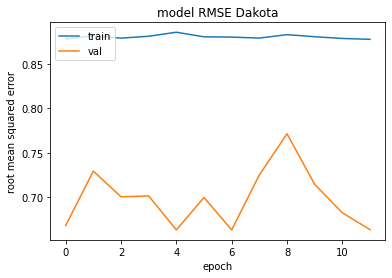

In [ ]:
history_reg_mn1 = new_model_reg_mn1.fit(X1_mn, y1_mn, validation_data = (X_val_mn,y_val_mn),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor], verbose=False)

# summarize history for accuracy
plt.plot(history_reg_mn1.history['root_mean_squared_error'])
plt.plot(history_reg_mn1.history['val_root_mean_squared_error'])
plt.title('model RMSE Dakota')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_results_reg_mn1.predictions[test_results_reg_mn1.predictions <0.5] = 0
test_results_reg_mn1.predictions[(test_results_reg_mn1.predictions >=0.5)&(test_results_reg_mn1.predictions<1.5)] = 1
test_results_reg_mn1.predictions[(test_results_reg_mn1.predictions >=1.5)&(test_results_reg_mn1.predictions<2.5)] = 2
test_results_reg_mn1.predictions[(test_results_reg_mn1.predictions >=2.5)&(test_results_reg_mn1.predictions<3.5)] = 3
test_results_reg_mn1.predictions[(test_results_reg_mn1.predictions >=3.5)&(test_results_reg_mn1.predictions<4.5)] = 4
test_results_reg_mn1.predictions[(test_results_reg_mn1.predictions >=4.5)&(test_results_reg_mn1.predictions<5.5)] = 5
test_results_reg_mn1.actuals[test_results_reg_mn1.actuals <0.5] = 0
test_results_reg_mn1.actuals[(test_results_reg_mn1.actuals >=0.5)&(test_results_reg_mn1.actuals<1.5)] = 1
test_results_reg_mn1.actuals[(test_results_reg_mn1.actuals >=1.5)&(test_results_reg_mn1.actuals<2.5)] = 2
test_results_reg_mn1.actuals[(test_results_reg_mn1.actuals >=2.5)&(test_results_reg_mn1.actuals<3.5)] = 3
test_results_reg_mn1.actuals[(test_results_reg_mn1.actuals >=3.5)&(test_results_reg_mn1.actuals<4.5)] = 4
test_results_reg_mn1.actuals[(test_results_reg_mn1.actuals >=4.5)&(test_results_reg_mn1.actuals<5.5)] = 5
test_results_reg_mn1

predictions  actuals
0            1.0      0.0
1            1.0      0.0
2            1.0      0.0
3            1.0      0.0
4            1.0      0.0
..           ...      ...
726          1.0      1.0
727          1.0      1.0
728          1.0      1.0
729          1.0      1.0
730          1.0      1.0

[731 rows x 2 columns]

In [ ]:
test_results_reg_1[200:250]

predictions  actuals
200          0.0      0.0
201          0.0      0.0
202          0.0      0.0
203          0.0      0.0
204          0.0      0.0
205          0.0      0.0
206          0.0      0.0
207          0.0      0.0
208          0.0      0.0
209          0.0      0.0
210          0.0      0.0
211          0.0      0.0
212          0.0      0.0
213          1.0      0.0
214          0.0      0.0
215          0.0      0.0
216          0.0      0.0
217          0.0      0.0
218          0.0      0.0
219          0.0      0.0
220          0.0      0.0
221          0.0      0.0
222          0.0      0.0
223          0.0      0.0
224          0.0      0.0
225          0.0      0.0
226          0.0      0.0
227          0.0      0.0
228          0.0      0.0
229          0.0      0.0
230          0.0      0.0
231          0.0      0.0
232          0.0      0.0
233          0.0      0.0
234          0.0      0.0
235          0.0      0.0
236          0.0      0.0
237          0.0      1.0
238          0.0      1.0
239          0.0      1.0
240          0.0      1.0
241          0.0      0.0
242          0.0      0.0
243          0.0      0.0
244          0.0      0.0
245          0.0      0.0
246          0.0      0.0
247          0.0      0.0
248          0.0      0.0
249          0.0      0.0

In [ ]:
print(classification_report(test_results_reg_mn1['actuals'], test_results_reg_mn1['predictions']))

              precision    recall  f1-score   support

         0.0       0.99      0.40      0.57       689
         1.0       0.09      0.93      0.16        42

    accuracy                           0.44       731
   macro avg       0.54      0.67      0.37       731
weighted avg       0.94      0.44      0.55       731



###MLP model with weather and soil data

####preprocessing data

In [ ]:
score_mn = train_mn['score']
score_val_mn = val_mn['score']
score_test_mn = test_mn['score']

In [ ]:
score_arr_mn = score_mn.copy()
score_val_arr_mn = score_val_mn.copy()
score_test_arr_mn = score_test_mn.copy()

In [ ]:
score_arr_mn = score_arr_mn.to_numpy()
score_val_arr_mn = score_val_arr_mn.to_numpy()
score_test_arr_mn = score_test_arr_mn.to_numpy()

In [ ]:
score_arr_mn =pd.DataFrame(score_arr_mn, columns=['Score']) 
score_arr_mn

Score
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
...     ...
6205    0.0
6206    0.0
6207    0.0
6208    0.0
6209    0.0

[6210 rows x 1 columns]

In [ ]:
score_val_arr_mn =pd.DataFrame(score_val_arr_mn, columns=['Score']) 
score_val_arr_mn

Score
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
..     ...
725    0.0
726    0.0
727    0.0
728    0.0
729    0.0

[730 rows x 1 columns]

In [ ]:
#score_arr_mn = to_categorical(score_arr_mn,num_classes=6)
#score_val_arr_mn = to_categorical(score_val_arr_mn,num_classes=6)
score_test_arr_mn = to_categorical(score_test_arr_mn,num_classes=6)

In [ ]:
dakota_train = train_mn.copy()
dakota_val = val_mn.copy()
dakota_test = test_mn.copy()

In [ ]:
X1_mn = dakota_train.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_val_mn = dakota_val.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_test_mn = dakota_test.drop(columns=['fips','date','score','tahun','bulan','tanggal'])

In [ ]:
X1_mn, y1_mn = X1_mn, score_arr_mn
X_val_mn, y_val_mn = X_val_mn, score_val_arr_mn
X_test_mn, y_test_mn = X_test_mn, score_test_arr_mn
X1_mn.shape, y1_mn.shape, X_val_mn.shape, y_val_mn.shape, X_test_mn.shape, y_test_mn.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 6))

In [ ]:
sm_mn1 = SMOTE(sampling_strategy={0:3841,1:3841,2:3841,3:3841},random_state=42,k_neighbors=5)
sm_mn2 = SMOTE(sampling_strategy={0:709,1:709},random_state=42,k_neighbors=5)
X1_mn_sm, y1_mn_df_sm = sm_mn1.fit_resample(X1_mn, score_arr_mn.values.ravel())
X_val_mn_sm, y_val_mn_sm = sm_mn2.fit_resample(X_val_mn,y_val_mn.values.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X1_mn_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y1_mn_df_sm.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_val_mn_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_val_mn_sm.shape))

After OverSampling, the shape of train_X: (15364, 49)
After OverSampling, the shape of train_y: (15364,) 

After OverSampling, the shape of train_X: (1418, 49)
After OverSampling, the shape of train_y: (1418,) 



In [ ]:
X1_mn_sm, y1_mn_df_sm = X1_mn_sm, to_categorical(y1_mn_df_sm,
                                                               num_classes=6)
X_val_mn_sm, y_val_mn_sm = X_val_mn_sm, to_categorical(y_val_mn_sm,
                                                                     num_classes=6)

####building the models using keras tuner

##### 1.objective: True Positive

In [ ]:
def build_model_mn1(hp):
  model_mn1 = Sequential()
  model_mn1.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_mn1.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_mn1.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_mn1.add(BatchNormalization())
  model_mn1.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_mn1.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_mn1.add(BatchNormalization())
  model_mn1.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_mn1.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_mn1.add(BatchNormalization())
  model_mn1.add(Dense(6, activation='softmax'))

  hp_optimizer_mn=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_mn == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_mn', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_mn == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_mn', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_mn1.compile(
      optimizer= hp_optimizer_mn,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model_mn1

# HyperBand algorithm from keras tuner
tuner_mn1 = kt.Hyperband(
    build_model_mn1,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs=50,
    directory='mn_dir',
    project_name='dakota',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_mn1.search(X1_mn_sm, y1_mn_df_sm, epochs=50, validation_data = (X_val_mn_sm,y_val_mn_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 31s]
val_true_positives: 709.0

Best val_true_positives So Far: 1192.0
Total elapsed time: 00h 40m 15s


In [ ]:
best_mlp_hyperparameters_mn = tuner_mn1.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_mn.values

Best Hyper-parameters


{'units1': 128,
 'units2': 320,
 'units3': 160,
 'dropout_1': 0.2,
 'dropout_2': 0.1,
 'dropout_3': 0.2,
 'Optimizer': 'Adam',
 'learning_rate_mn': 0.001,
 'tuner/epochs': 6,
 'tuner/initial_epoch': 2,
 'tuner/bracket': 3,
 'tuner/round': 1,
 'tuner/trial_id': '0003'}

In [ ]:
best_model_mn = tuner_mn1.get_best_models()[0]
best_model_mn.build(X1_mn_sm.shape)
best_model_mn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (15364, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (15364, 128)              6400      
                                                                 
 dropout (Dropout)           (15364, 128)              0         
                                                                 
 batch_normalization_1 (Batc  (15364, 128)             512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (15364, 320)              41280     
                                                                 
 dropout_1 (Dropout)         (15364, 320)              0

In [ ]:
new_model_mn1 = Sequential()
new_model_mn1.add(tf.keras.Input(shape=(49,)))
new_model_mn1.add(BatchNormalization())
new_model_mn1.add(Dense(128, activation = LeakyReLU,input_shape=(49,)))
new_model_mn1.add(Dropout(0.2))
new_model_mn1.add(BatchNormalization())
new_model_mn1.add(Dense(320, activation = LeakyReLU))
new_model_mn1.add(Dropout(0.1))
new_model_mn1.add(BatchNormalization())
new_model_mn1.add(Dense(160, activation = LeakyReLU))
new_model_mn1.add(Dropout(0.2))
new_model_mn1.add(BatchNormalization())
new_model_mn1.add((Dense(6, activation='softmax')))
new_model_mn1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 128)               6400      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 320)               41280     
                                                                 
 dropout_4 (Dropout)         (None, 320)              

In [ ]:
cp_mn1 = ModelCheckpoint('new_model_mn1/', save_best_only=True)
opt_mn1 = keras.optimizers.Adam(learning_rate=0.001)
new_model_mn1.compile(optimizer = opt_mn1, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_mn1.fit(X1_mn_sm, y1_mn_df_sm, validation_data = (X_val_mn_sm,y_val_mn_sm),
               epochs=50,batch_size=64, callbacks =[cp_mn1,early_stopping_monitor])

Epoch 1/50
239/241 [============================>.] - ETA: 0s - loss: 1.6423 - categorical_accuracy: 0.3196

241/241 [==============================] - 8s 27ms/step - loss: 1.6414 - categorical_accuracy: 0.3196 - val_loss: 6.1755 - val_categorical_accuracy: 0.4993
Epoch 2/50
236/241 [============================>.] - ETA: 0s - loss: 1.3734 - categorical_accuracy: 0.3660

241/241 [==============================] - 7s 28ms/step - loss: 1.3727 - categorical_accuracy: 0.3667 - val_loss: 1.0937 - val_categorical_accuracy: 0.4929
Epoch 3/50
241/241 [==============================] - 2s 8ms/step - loss: 1.3135 - categorical_accuracy: 0.3906 - val_loss: 1.1011 - val_categorical_accuracy: 0.3928
Epoch 4/50
241/241 [==============================] - 2s 8ms/step - loss: 1.2883 - categorical_accuracy: 0.3993 - val_loss: 1.3497 - val_categorical_accuracy: 0.2567
Epoch 5/50
241/241 [==============================] - 2s 8ms/step - loss: 1.2659 - categorical_accuracy: 0.4057 - val_loss: 1.2335 - val_categorical_accuracy: 0.4104
Epoch 6/50
241/241 [==============================] - 2s 8ms/step - loss: 1.2565 - categorical_accuracy: 0.4203 - val_loss: 1.1510 - val_categorical_accuracy: 0.4069
Epoch 7/50
241/241 [==============================] - 2s 8ms/step - loss: 1.2407 - categorical_accuracy: 0.4307 - val_loss: 1.3977 - val_categorical_accuracy: 0.2891


In [ ]:
test_predictions_mn1 = new_model_mn1.predict(X_test_mn)
test_predictions_mn1

23/23 [==============================] - 0s 3ms/step


array([[5.6021377e-02, 4.5091835e-01, 2.3081987e-01, 2.6214278e-01,
        7.0039423e-05, 2.7701723e-05],
       [1.0145261e-01, 4.3429789e-01, 2.4669892e-01, 2.1745570e-01,
        3.6265770e-05, 5.8563121e-05],
       [1.9988777e-01, 4.0952516e-01, 1.4875138e-01, 2.4172413e-01,
        3.8130132e-05, 7.3373798e-05],
       ...,
       [8.8827081e-02, 3.3032095e-01, 1.6466248e-01, 4.1592231e-01,
        1.7026908e-04, 9.6919117e-05],
       [7.0524067e-02, 2.5232446e-01, 1.5831421e-01, 5.1836735e-01,
        2.1830427e-04, 2.5158859e-04],
       [9.8193198e-02, 2.9029596e-01, 1.9833262e-01, 4.1238615e-01,
        4.6638714e-04, 3.2564535e-04]], dtype=float32)

In [ ]:
classes_mn1 = np.argmax(test_predictions_mn1, axis=-1)
classes_mn1

array([1, 1, 1, 2, 1, 3, 0, 3, 3, 1, 3, 1, 0, 2, 2, 1, 3, 3, 1, 1, 3, 3,
       1, 1, 1, 2, 2, 3, 1, 2, 2, 1, 3, 2, 2, 3, 3, 2, 1, 1, 1, 3, 3, 3,
       2, 1, 2, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       0, 2, 3, 1, 3, 0, 0, 3, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2,
       2, 2, 3, 2, 2, 1, 0, 0, 0, 2, 2, 3, 3, 2, 3, 3, 0, 0, 2, 3, 2, 0,
       0, 2, 0, 0, 0, 2, 3, 3, 0, 0, 0, 0, 2, 0, 3, 2, 0, 2, 2, 0, 2, 2,
       0, 0, 0, 0, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 2, 0,
       0, 3, 0, 0, 2, 0, 0, 0, 0, 1, 2, 2, 3, 3, 2,

In [ ]:
classes_mn1 =pd.DataFrame(classes_mn1, columns=['Test Predictions']) 
classes_mn1

Test Predictions
0                   1
1                   1
2                   1
3                   2
4                   1
..                ...
726                 1
727                 3
728                 3
729                 3
730                 3

[731 rows x 1 columns]

In [ ]:
y_test_mn= np.argmax(y_test_mn, axis=-1)
y_test_mn

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
y_test_mn =pd.DataFrame(y_test_mn, columns=['Actuals']) 
y_test_mn

Actuals
0          0
1          0
2          0
3          0
4          0
..       ...
726        1
727        1
728        1
729        1
730        1

[731 rows x 1 columns]

In [ ]:
classes_mn1 = classes_mn1.values.ravel()
y_test_mn = y_test_mn.values.ravel()

In [ ]:
result_mn1 = pd.DataFrame({'Test Predictions':classes_mn1, 'Actuals':y_test_mn})
result_mn1[0:31]

Test Predictions  Actuals
0                  1        0
1                  1        0
2                  1        0
3                  2        0
4                  1        0
5                  3        0
6                  0        0
7                  3        0
8                  3        0
9                  1        0
10                 3        0
11                 1        0
12                 0        0
13                 2        0
14                 2        0
15                 1        0
16                 3        0
17                 3        0
18                 1        0
19                 1        0
20                 3        0
21                 3        0
22                 1        0
23                 1        0
24                 1        0
25                 2        0
26                 2        0
27                 3        0
28                 1        0
29                 2        0
30                 2        0

######model 1 evaluation

In [ ]:
print(classification_report(y_test_mn, classes_mn1))

              precision    recall  f1-score   support

           0       0.97      0.52      0.68       689
           1       0.05      0.12      0.07        42
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.50       731
   macro avg       0.25      0.16      0.19       731
weighted avg       0.92      0.50      0.65       731



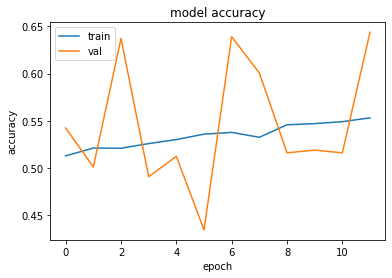

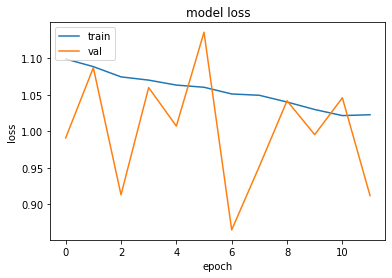

In [ ]:
history1_mn = new_model_mn1.fit(X1_scaled_mn_sm, y1_mn_df_sm, validation_data = (X_val_scaled_mn_sm,y_val_mn_sm),
               epochs=50,batch_size=64, callbacks =[cp_mn1,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history1_mn.history['categorical_accuracy'])
plt.plot(history1_mn.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1_mn.history['loss'])
plt.plot(history1_mn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 2.objective: False Negative

In [ ]:
def build_model_mn2(hp):
  model_mn2 = Sequential()
  model_mn2.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_mn2.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_mn2.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_mn2.add(BatchNormalization())
  model_mn2.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_mn2.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_mn2.add(BatchNormalization())
  model_mn2.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_mn2.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_mn2.add(BatchNormalization())
  model_mn2.add(Dense(6, activation='softmax'))

  hp_optimizer_mn=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_mn == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_mn', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_mn == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_mn', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_mn2.compile(
      optimizer= hp_optimizer_mn,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.FalseNegatives(name='false_negatives'),
               'categorical_accuracy']
  )
  return model_mn2

# HyperBand algorithm from keras tuner
tuner_mn2 = kt.Hyperband(
    build_model_mn2,
    objective= kt.Objective('val_false_negatives', direction="min"),
    max_epochs=50,
    directory='mn_dir2',
    project_name='dakota2',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_mn2.search(X1_mn_sm, y1_mn_df_sm, epochs=50, validation_data = (X_val_mn_sm,y_val_mn_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 29s]
val_false_negatives: 709.0

Best val_false_negatives So Far: 329.0
Total elapsed time: 00h 38m 36s


In [ ]:
best_mlp_hyperparameters_mn2 = tuner_mn2.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_mn2.values

Best Hyper-parameters


{'units1': 384,
 'units2': 256,
 'units3': 352,
 'dropout_1': 0.1,
 'dropout_2': 0.3,
 'dropout_3': 0.3,
 'Optimizer': 'Adam',
 'learning_rate_mn': 0.01,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 3,
 'tuner/round': 0}

In [ ]:
best_model_mn2 = tuner_mn2.get_best_models()[0]
best_model_mn2.build(X1_mn_sm.shape)
best_model_mn2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (15364, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (15364, 384)              19200     
                                                                 
 dropout (Dropout)           (15364, 384)              0         
                                                                 
 batch_normalization_1 (Batc  (15364, 384)             1536      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (15364, 256)              98560     
                                                                 
 dropout_1 (Dropout)         (15364, 256)              0

In [ ]:
new_model_mn2 = Sequential()
new_model_mn2.add(tf.keras.Input(shape=(49,)))
new_model_mn2.add(BatchNormalization())
new_model_mn2.add(Dense(384, activation = LeakyReLU))
new_model_mn2.add(Dropout(0.1))
new_model_mn2.add(BatchNormalization())
new_model_mn2.add(Dense(256, activation = LeakyReLU))
new_model_mn2.add(Dropout(0.3))
new_model_mn2.add(BatchNormalization())
new_model_mn2.add(Dense(352, activation = LeakyReLU))
new_model_mn2.add(Dropout(0.3))
new_model_mn2.add(BatchNormalization())
new_model_mn2.add((Dense(6, activation='softmax')))
new_model_mn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 384)               19200     
                                                                 
 dropout_3 (Dropout)         (None, 384)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 384)              1536      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 256)               98560     
                                                                 
 dropout_4 (Dropout)         (None, 256)              

In [ ]:
cp_mn2 = ModelCheckpoint('new_model_mn2/', save_best_only=True)
opt_mn2 = keras.optimizers.Adam(learning_rate=0.01)
new_model_mn2.compile(optimizer = opt_mn2, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_mn2.fit(X1_mn_sm, y1_mn_df_sm, validation_data = (X_val_mn_sm,y_val_mn_sm),
               epochs=50,batch_size=64, callbacks =[cp_mn2,early_stopping_monitor])

Epoch 1/50
239/241 [============================>.] - ETA: 0s - loss: 1.3974 - categorical_accuracy: 0.3388

241/241 [==============================] - 13s 46ms/step - loss: 1.3971 - categorical_accuracy: 0.3391 - val_loss: 15.5521 - val_categorical_accuracy: 0.5000
Epoch 2/50
240/241 [============================>.] - ETA: 0s - loss: 1.3337 - categorical_accuracy: 0.3663

241/241 [==============================] - 9s 35ms/step - loss: 1.3339 - categorical_accuracy: 0.3662 - val_loss: 1.3561 - val_categorical_accuracy: 0.5000
Epoch 3/50
241/241 [==============================] - 5s 20ms/step - loss: 1.3025 - categorical_accuracy: 0.3870 - val_loss: 1.7203 - val_categorical_accuracy: 0.4443
Epoch 4/50
240/241 [============================>.] - ETA: 0s - loss: 1.2842 - categorical_accuracy: 0.3943

241/241 [==============================] - 9s 36ms/step - loss: 1.2841 - categorical_accuracy: 0.3943 - val_loss: 1.2316 - val_categorical_accuracy: 0.3970
Epoch 5/50
240/241 [============================>.] - ETA: 0s - loss: 1.2733 - categorical_accuracy: 0.4059

241/241 [==============================] - 6s 26ms/step - loss: 1.2734 - categorical_accuracy: 0.4058 - val_loss: 1.1695 - val_categorical_accuracy: 0.3695
Epoch 6/50
239/241 [============================>.] - ETA: 0s - loss: 1.2738 - categorical_accuracy: 0.4025

241/241 [==============================] - 6s 26ms/step - loss: 1.2735 - categorical_accuracy: 0.4023 - val_loss: 1.0186 - val_categorical_accuracy: 0.3942
Epoch 7/50
241/241 [==============================] - 3s 11ms/step - loss: 1.2666 - categorical_accuracy: 0.4149 - val_loss: 1.5247 - val_categorical_accuracy: 0.2461
Epoch 8/50
241/241 [==============================] - 3s 11ms/step - loss: 1.2628 - categorical_accuracy: 0.4146 - val_loss: 1.2747 - val_categorical_accuracy: 0.2003
Epoch 9/50
241/241 [==============================] - 3s 11ms/step - loss: 1.2550 - categorical_accuracy: 0.4214 - val_loss: 1.1571 - val_categorical_accuracy: 0.4295
Epoch 10/50
241/241 [==============================] - 3s 11ms/step - loss: 1.2605 - categorical_accuracy: 0.4117 - val_loss: 1.2347 - val_categorical_accuracy: 0.3011
Epoch 11/50
241/241 [==============================] - 3s 11ms/step - loss: 1.2524 - categorical_accuracy: 0.4241 - val_loss: 1.4745 - val_categorical_accuracy: 0.2348


In [ ]:
test_predictions_mn2 = new_model_mn2.predict(X_test_mn)
test_predictions_mn2

23/23 [==============================] - 0s 3ms/step


array([[7.57703632e-02, 4.13519293e-01, 2.58802623e-01, 2.51664758e-01,
        1.26914310e-04, 1.16122421e-04],
       [2.03746349e-01, 2.81388760e-01, 3.71170580e-01, 1.43606409e-01,
        3.79514859e-05, 4.98949412e-05],
       [3.20466697e-01, 2.71196902e-01, 1.14230342e-01, 2.94036686e-01,
        2.96153794e-05, 3.97807635e-05],
       ...,
       [1.28688306e-01, 3.24262887e-01, 1.60000220e-01, 3.86767954e-01,
        1.40884236e-04, 1.39738288e-04],
       [1.27512366e-01, 2.42376059e-01, 1.53143615e-01, 4.76709962e-01,
        1.22624435e-04, 1.35359936e-04],
       [1.21626325e-01, 2.62256205e-01, 1.64274186e-01, 4.51566041e-01,
        1.37528041e-04, 1.39777068e-04]], dtype=float32)

In [ ]:
classes_mn2 = np.argmax(test_predictions_mn2, axis=-1)
classes_mn2

array([1, 2, 0, 3, 3, 3, 0, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3,
       3, 1, 3, 3, 2, 1, 2, 2, 2, 1, 3, 0, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3,
       2, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 0, 0, 3, 3, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 3, 2,
       2, 2, 2, 2, 2, 1, 0, 0, 0, 2, 2, 3, 0, 0, 3, 2, 2, 0, 1, 2, 2, 2,
       0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 1, 2, 2, 2, 2,
       0, 0, 0, 0, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 3, 3, 2,
       3, 2, 2, 2, 0, 0, 0, 0, 0, 3, 2, 2, 2, 2, 2,

In [ ]:
classes_mn2 =pd.DataFrame(classes_mn2, columns=['Test Predictions']) 
classes_mn2

Test Predictions
0                   1
1                   2
2                   0
3                   3
4                   3
..                ...
726                 3
727                 3
728                 3
729                 3
730                 3

[731 rows x 1 columns]

In [ ]:
classes_mn2 = classes_mn2.values.ravel()

In [ ]:
result_mn2 = pd.DataFrame({'Test Predictions':classes_mn2, 'Actuals':y_test_mn})
result_mn2[0:31]

Test Predictions  Actuals
0                  1        0
1                  2        0
2                  0        0
3                  3        0
4                  3        0
5                  3        0
6                  0        0
7                  3        0
8                  1        0
9                  3        0
10                 3        0
11                 1        0
12                 1        0
13                 3        0
14                 3        0
15                 3        0
16                 3        0
17                 3        0
18                 1        0
19                 1        0
20                 1        0
21                 3        0
22                 3        0
23                 1        0
24                 3        0
25                 3        0
26                 2        0
27                 1        0
28                 2        0
29                 2        0
30                 2        0

######model 2 evaluation

In [ ]:
print(classification_report(y_test_mn, classes_mn2))

              precision    recall  f1-score   support

           0       0.98      0.48      0.65       689
           1       0.01      0.02      0.02        42
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.46       731
   macro avg       0.25      0.13      0.17       731
weighted avg       0.92      0.46      0.61       731



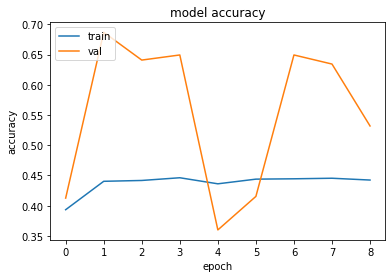

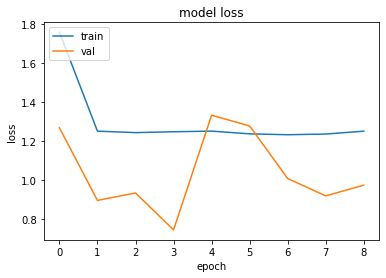

In [ ]:
history2_mn = new_model_mn2.fit(X1_mn_sm, y1_mn_df_sm, validation_data = (X_val_mn_sm,y_val_mn_sm),
               epochs=50,batch_size=64, callbacks =[cp_mn2,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history2_mn.history['categorical_accuracy'])
plt.plot(history2_mn.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2_mn.history['loss'])
plt.plot(history2_mn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 3.objective : Accuracy

In [ ]:
def build_model_mn3(hp):
  model_mn3 = Sequential()
  model_mn3.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_mn3.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_mn3.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_mn3.add(BatchNormalization())
  model_mn3.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_mn3.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_mn3.add(BatchNormalization())
  model_mn3.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_mn3.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_mn3.add(BatchNormalization())
  model_mn3.add(Dense(6, activation='softmax'))

  hp_optimizer_mn=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_mn == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_mn', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_mn == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_mn', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_mn3.compile(
      optimizer= hp_optimizer_mn,
      loss='categorical_crossentropy',
      metrics=['categorical_accuracy']
  )
  return model_mn3

# HyperBand algorithm from keras tuner
tuner_mn3 = kt.Hyperband(
    build_model_mn3,
    objective= kt.Objective("val_categorical_accuracy", direction="max"),
    max_epochs=50,
    directory='mn_dir3',
    project_name='dakota3',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_mn3.search(X1_mn_sm, y1_mn_df_sm, epochs=50, validation_data = (X_val_mn_sm,y_val_mn_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 44s]
val_categorical_accuracy: 0.5169252753257751

Best val_categorical_accuracy So Far: 0.7658674120903015
Total elapsed time: 00h 39m 17s


In [ ]:
best_mlp_hyperparameters_mn3 = tuner_mn3.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_mn3.values

Best Hyper-parameters


{'units1': 384,
 'units2': 448,
 'units3': 352,
 'dropout_1': 0.1,
 'dropout_2': 0.3,
 'dropout_3': 0.2,
 'Optimizer': 'Adam',
 'learning_rate_mn': 0.1,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 3,
 'tuner/round': 0}

In [ ]:
best_model_mn3 = tuner_mn3.get_best_models()[0]
best_model_mn3.build(X1_mn_sm.shape)
best_model_mn3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (15364, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (15364, 384)              19200     
                                                                 
 dropout (Dropout)           (15364, 384)              0         
                                                                 
 batch_normalization_1 (Batc  (15364, 384)             1536      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (15364, 448)              172480    
                                                                 
 dropout_1 (Dropout)         (15364, 448)              0

In [ ]:
new_model_mn3 = Sequential()
new_model_mn3.add(tf.keras.Input(shape=(49,)))
new_model_mn3.add(BatchNormalization())
new_model_mn3.add(Dense(384, activation = LeakyReLU))
new_model_mn3.add(Dropout(0.1))
new_model_mn3.add(BatchNormalization())
new_model_mn3.add(Dense(448, activation = LeakyReLU))
new_model_mn3.add(Dropout(0.3))
new_model_mn3.add(BatchNormalization())
new_model_mn3.add(Dense(352, activation = LeakyReLU))
new_model_mn3.add(Dropout(0.2))
new_model_mn3.add(BatchNormalization())
new_model_mn3.add((Dense(6, activation='softmax')))
new_model_mn3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 384)               19200     
                                                                 
 dropout_3 (Dropout)         (None, 384)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 384)              1536      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 448)               172480    
                                                                 
 dropout_4 (Dropout)         (None, 448)              

In [ ]:
cp_mn3 = ModelCheckpoint('new_model_mn3/', save_best_only=True)
opt_mn3 = keras.optimizers.Adam(learning_rate=0.1)
new_model_mn3.compile(optimizer = opt_mn3, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_mn3.fit(X1_mn_sm, y1_mn_df_sm, validation_data = (X_val_mn_sm,y_val_mn_sm),
               epochs=50,batch_size=64, callbacks =[cp_mn3,early_stopping_monitor])

Epoch 1/50
237/241 [============================>.] - ETA: 0s - loss: 1.7480 - categorical_accuracy: 0.3028

241/241 [==============================] - 8s 26ms/step - loss: 1.7428 - categorical_accuracy: 0.3027 - val_loss: 2.2127 - val_categorical_accuracy: 0.5000
Epoch 2/50
241/241 [==============================] - 3s 13ms/step - loss: 1.3803 - categorical_accuracy: 0.3222 - val_loss: 3.5561 - val_categorical_accuracy: 0.3463
Epoch 3/50
241/241 [==============================] - ETA: 0s - loss: 1.4530 - categorical_accuracy: 0.3155

241/241 [==============================] - 7s 30ms/step - loss: 1.4530 - categorical_accuracy: 0.3155 - val_loss: 2.1008 - val_categorical_accuracy: 0.4394
Epoch 4/50
239/241 [============================>.] - ETA: 0s - loss: 1.5280 - categorical_accuracy: 0.3081

241/241 [==============================] - 10s 43ms/step - loss: 1.5284 - categorical_accuracy: 0.3079 - val_loss: 1.4993 - val_categorical_accuracy: 0.3103
Epoch 5/50
241/241 [==============================] - 4s 18ms/step - loss: 1.7263 - categorical_accuracy: 0.2969 - val_loss: 1.8233 - val_categorical_accuracy: 0.4774
Epoch 6/50
241/241 [==============================] - 3s 14ms/step - loss: 1.7416 - categorical_accuracy: 0.3046 - val_loss: 1.8015 - val_categorical_accuracy: 0.2708
Epoch 7/50
241/241 [==============================] - 3s 13ms/step - loss: 1.6762 - categorical_accuracy: 0.3095 - val_loss: 2.8325 - val_categorical_accuracy: 0.2151
Epoch 8/50
241/241 [==============================] - 4s 17ms/step - loss: 1.6234 - categorical_accuracy: 0.3107 - val_loss: 1.7850 - val_categorical_accuracy: 0.1721
Epoch 9/50
241/241 [==============================] - 3s 13ms/step - loss: 1.5944 - categorical_accuracy: 0.3206 - val_loss: 2.3753 - val_categorical_accuracy: 0.0000e+00


In [ ]:
test_predictions_mn3 = new_model_mn3.predict(X_test_mn)
test_predictions_mn3

23/23 [==============================] - 0s 4ms/step


array([[3.25664245e-02, 1.32551819e-01, 5.84299266e-01, 2.50562131e-01,
        1.34029797e-05, 6.87952570e-06],
       [4.60656695e-02, 1.40158087e-01, 6.24595225e-01, 1.89156011e-01,
        1.27702251e-05, 1.22435722e-05],
       [1.05097808e-01, 1.42096713e-01, 5.75434327e-01, 1.77337363e-01,
        1.40226748e-05, 1.97743848e-05],
       ...,
       [5.28671406e-02, 9.74009410e-02, 6.51135802e-01, 1.98572397e-01,
        1.21976636e-05, 1.14508885e-05],
       [6.25957400e-02, 8.95321295e-02, 6.59955323e-01, 1.87893391e-01,
        1.11221407e-05, 1.22618858e-05],
       [8.48978087e-02, 1.15485504e-01, 5.77053905e-01, 2.22535327e-01,
        1.35933042e-05, 1.38602582e-05]], dtype=float32)

In [ ]:
classes_mn3 = np.argmax(test_predictions_mn3, axis=-1)
classes_mn3

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
classes_mn3 =pd.DataFrame(classes_mn3, columns=['Test Predictions']) 
classes_mn3

Test Predictions
0                   2
1                   2
2                   2
3                   2
4                   2
..                ...
726                 2
727                 2
728                 2
729                 2
730                 2

[731 rows x 1 columns]

In [ ]:
classes_mn3 = classes_mn3.values.ravel()

In [ ]:
result_mn3 = pd.DataFrame({'Test Predictions':classes_mn3, 'Actuals':y_test_mn})
result_mn3[0:31]

Test Predictions  Actuals
0                  2        0
1                  2        0
2                  2        0
3                  2        0
4                  2        0
5                  2        0
6                  2        0
7                  2        0
8                  2        0
9                  2        0
10                 2        0
11                 2        0
12                 2        0
13                 2        0
14                 2        0
15                 2        0
16                 2        0
17                 2        0
18                 3        0
19                 3        0
20                 2        0
21                 2        0
22                 2        0
23                 2        0
24                 2        0
25                 2        0
26                 2        0
27                 2        0
28                 2        0
29                 3        0
30                 2        0

######model 3 evaluation

In [ ]:
print(classification_report(y_test_mn, classes_mn3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     689.0
           1       0.00      0.00      0.00      42.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0

    accuracy                           0.00     731.0
   macro avg       0.00      0.00      0.00     731.0
weighted avg       0.00      0.00      0.00     731.0



In [ ]:
history3_mn = new_model_mn3.fit(X1_mn_sm, y1_mn_df_sm, validation_data = (X_val_mn_sm,y_val_mn_sm),
               epochs=50,batch_size=64, callbacks =[cp_mn3,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history3_mn.history['categorical_accuracy'])
plt.plot(history3_mn.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3_mn.history['loss'])
plt.plot(history3_mn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####comparing the models

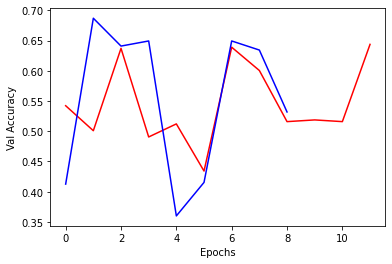

In [ ]:
plt.plot(history1_mn.history['val_categorical_accuracy'], 'r', history2_mn.history['val_categorical_accuracy'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

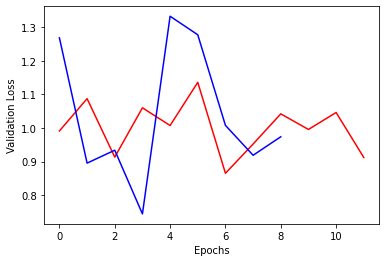

In [ ]:
plt.plot(history1_mn.history['val_loss'], 'r', history2_mn.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

###LSTM model without weather and soil data, only using previous drought scores

In [ ]:
def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_mn, y_train_mn = df_to_X_y(score_mn, WINDOW_SIZE)
X_val1_mn, y_val1_mn = df_to_X_y(score_val_mn, WINDOW_SIZE)
X_test1_mn, y_test1_mn = df_to_X_y(score_test_mn, WINDOW_SIZE)
X_train_mn.shape, y_train_mn.shape, X_val1_mn.shape, y_val1_mn.shape, X_test1_mn.shape, y_test1_mn.shape

((6203, 7, 1), (6203,), (723, 7, 1), (723,), (724, 7, 1), (724,))

In [ ]:
model_1 = Sequential()
model_1.add(InputLayer((7,1)))
model_1.add(LSTM(64))
model_1.add(Dense(8, 'relu'))
model_1.add(Dense(1, 'linear'))

model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

model_1.fit(X_train_mn, y_train_mn, validation_data=(X_val1_mn, y_val1_mn), epochs=50, 
           callbacks = [early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 4s 10ms/step - loss: 0.6293 - root_mean_squared_error: 0.7933 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1455
Epoch 2/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0623 - root_mean_squared_error: 0.2495 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0946
Epoch 3/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0435 - root_mean_squared_error: 0.2085 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 4/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0387 - root_mean_squared_error: 0.1968 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0859
Epoch 5/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0336 - root_mean_squared_error: 0.1832 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804
Epoch 6/50
194/194 [==============================] - 1s 6ms/step - loss: 0.0288 - root_mean_squared_error: 0.1696 - val_loss: 0.0060 - val

####using the model to predict the test dataset

In [ ]:
test_prediction_mn_1 = model_1.predict(X_test1_mn).flatten()
test_results_mn_1 = pd.DataFrame(data={'predictions':test_prediction_mn_1, 'actuals':y_test1_mn})
test_results_mn_1

23/23 [==============================] - 1s 3ms/step


predictions  actuals
0       0.014572      0.0
1       0.014572      0.0
2       0.014572      0.0
3       0.014572      0.0
4       0.014572      0.0
..           ...      ...
719     1.013403      1.0
720     1.013403      1.0
721     1.013403      1.0
722     1.013403      1.0
723     1.013403      1.0

[724 rows x 2 columns]

In [ ]:
test_results_mn_1.predictions[test_results_mn_1.predictions <0.5] = 0
test_results_mn_1.predictions[(test_results_mn_1.predictions >=0.5)&(test_results_mn_1.predictions<1.5)] = 1
test_results_mn_1.predictions[(test_results_mn_1.predictions >=1.5)&(test_results_mn_1.predictions<2.5)] = 2
test_results_mn_1.predictions[(test_results_mn_1.predictions >=2.5)&(test_results_mn_1.predictions<3.5)] = 3
test_results_mn_1.predictions[(test_results_mn_1.predictions >=3.5)&(test_results_mn_1.predictions<4.5)] = 4
test_results_mn_1.predictions[(test_results_mn_1.predictions >=4.5)&(test_results_mn_1.predictions<5.5)] = 5
test_results_mn_1

predictions  actuals
0            0.0      0.0
1            0.0      0.0
2            0.0      0.0
3            0.0      0.0
4            0.0      0.0
..           ...      ...
719          1.0      1.0
720          1.0      1.0
721          1.0      1.0
722          1.0      1.0
723          1.0      1.0

[724 rows x 2 columns]

In [ ]:
test_results_mn_1.actuals[test_results_mn_1.actuals <0.5] = 0
test_results_mn_1.actuals[(test_results_mn_1.actuals >=0.5)&(test_results_mn_1.actuals<1.5)] = 1
test_results_mn_1.actuals[(test_results_mn_1.actuals >=1.5)&(test_results_mn_1.actuals<2.5)] = 2
test_results_mn_1.actuals[(test_results_mn_1.actuals >=2.5)&(test_results_mn_1.actuals<3.5)] = 3
test_results_mn_1.actuals[(test_results_mn_1.actuals >=3.5)&(test_results_mn_1.actuals<4.5)] = 4
test_results_mn_1.actuals[(test_results_mn_1.actuals >=4.5)&(test_results_mn_1.actuals<5.5)] = 5
test_results_mn_1

predictions  actuals
0            0.0      0.0
1            0.0      0.0
2            0.0      0.0
3            0.0      0.0
4            0.0      0.0
..           ...      ...
719          1.0      1.0
720          1.0      1.0
721          1.0      1.0
722          1.0      1.0
723          1.0      1.0

[724 rows x 2 columns]

####model evaluation

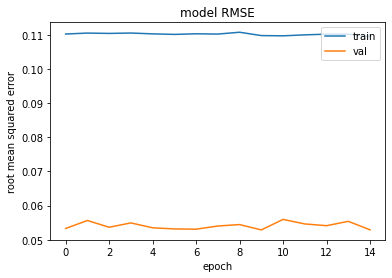

In [ ]:
history_mn_1 = model_1.fit(X_train_mn, y_train_mn, validation_data=(X_val1_mn, y_val1_mn), epochs=50, 
           callbacks = [early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history_mn_1.history['root_mean_squared_error'])
plt.plot(history_mn_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
print(classification_report(test_results_mn_1['actuals'], test_results_mn_1['predictions']))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       682
         1.0       0.98      0.95      0.96        42

    accuracy                           1.00       724
   macro avg       0.99      0.98      0.98       724
weighted avg       1.00      1.00      1.00       724



###LSTM model with only score data and time data but the time data is transformed using sine and cosine

####train

In [ ]:
train_mn1 = train_mn.copy()
train_mn1.index = pd.to_datetime(train_mn1['date'], format='%Y.%m.%d')
train_mn1[:31]

fips        date  PRECTOT      PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                          
2000-01-01  27037  2000-01-01     0.11   97.79  2.52  -3.57   -5.75   -5.71   
2000-01-02  27037  2000-01-02     2.15   97.37  2.93  -2.17   -3.90   -3.88   
2000-01-03  27037  2000-01-03     0.34   98.25  2.09  -5.80   -7.85   -7.80   
2000-01-04  27037  2000-01-04     0.41   98.47  1.34  -9.46  -13.10  -12.82   
2000-01-05  27037  2000-01-05     2.86   97.92  1.81  -8.14  -10.23  -10.12   
2000-01-06  27037  2000-01-06     0.07   98.40  1.72  -7.37  -10.32  -10.18   
2000-01-07  27037  2000-01-07     0.11   98.69  1.53  -9.92  -11.96  -11.85   
2000-01-08  27037  2000-01-08     0.01   97.51  2.65  -3.49   -5.13   -5.11   
2000-01-09  27037  2000-01-09     0.66   96.83  3.42  -1.77   -2.14   -2.14   
2000-01-10  27037  2000-01-10     0.88   95.83  3.44  -0.41   -1.99   -1.97   
2000-01-11  27037  2000-01-11     0.04   97.93  1.15  -9.61  -14.90  -14.39   
2000-01-12  27037  2000-01-12     6.90   98.56  1.21 -11.18  -14.00  -13.75   
2000-01-13  27037  2000-01-13     0.04   99.94  1.27 -11.67  -13.25  -13.16   
2000-01-14  27037  2000-01-14     0.19   99.37  1.79  -7.88   -9.94   -9.88   
2000-01-15  27037  2000-01-15     0.00   98.21  2.47  -4.11   -6.11   -6.06   
2000-01-16  27037  2000-01-16     0.06  100.01  1.05 -11.95  -15.25  -14.94   
2000-01-17  27037  2000-01-17     0.17   99.04  1.90  -6.66   -9.07   -8.98   
2000-01-18  27037  2000-01-18     0.00   98.67  1.42  -9.26  -12.39  -12.18   
2000-01-19  27037  2000-01-19     6.79   98.24  1.17 -12.61  -14.66  -14.46   
2000-01-20  27037  2000-01-20     0.11   98.73  0.64 -19.62  -20.98  -20.76   
2000-01-21  27037  2000-01-21     0.56   98.56  0.65 -19.11  -20.55  -20.31   
2000-01-22  27037  2000-01-22     0.10   97.64  1.38 -11.08  -12.90  -12.79   
2000-01-23  27037  2000-01-23     0.02   98.40  0.76 -16.58  -18.66  -18.34   
2000-01-24  27037  2000-01-24     0.15   98.19  1.18 -13.49  -14.89  -14.80   
2000-01-25  27037  2000-01-25     0.07   98.99  0.94 -14.28  -16.72  -16.42   
2000-01-26  27037  2000-01-26     0.00   99.38  0.78 -16.42  -18.38  -18.14   
2000-01-27  27037  2000-01-27     0.00   99.82  0.97 -15.45  -16.31  -16.27   
2000-01-28  27037  2000-01-28     0.00  100.02  1.25 -12.84  -13.74  -13.71   
2000-01-29  27037  2000-01-29     0.03   99.77  1.29 -11.55  -13.24  -13.15   
2000-01-30  27037  2000-01-30     0.05   98.91  1.44 -10.59  -12.21  -12.14   
2000-01-31  27037  2000-01-31     0.04   98.11  1.74  -8.65  -10.17  -10.12   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2000-01-01    -0.57    -7.88       7.31  -3.71   4.99       6.05       3.80   
2000-01-02     0.94    -6.53       7.47  -2.41   5.50       8.08       3.36   
2000-01-03    -3.72    -7.48       3.75  -5.82   4.33       6.68       2.96   
2000-01-04    -6.16   -13.93       7.77 -10.01   5.66       8.54       1.07   
2000-01-05    -3.76   -14.39      10.62  -8.47   7.09       9.92       3.27   
2000-01-06    -4.48   -13.77       9.29  -7.67   6.53       8.14       4.80   
2000-01-07    -4.60   -16.19      11.58 -10.82   5.46       8.39       2.77   
2000-01-08     3.43    -7.26      10.69  -4.30   4.49       5.60       2.92   
2000-01-09     1.94    -7.18       9.12  -2.59   4.53       5.99       2.68   
2000-01-10     2.99    -3.06       6.05  -0.53   5.23       8.61       2.06   
2000-01-11    -2.34   -12.39      10.05  -9.18   6.84      12.47       2.68   
2000-01-12    -9.22   -12.64       3.42 -10.77   6.05       8.32       3.34   
2000-01-13    -6.38   -15.15       8.77 -12.81   2.90       4.32       1.49   
2000-01-14    -0.00   -15.29      15.29  -8.91   5.65      11.22       0.82   
2000-01-15     2.36   -10.76      13.12  -4.40   4.78      10.13       2.59   
2000-01-16    -7.36   -16.44       9.08 -11.56   6.32       9.

In [ ]:
scoremn = train_mn1['score']
scoremn_df = pd.DataFrame({'score':scoremn})
scoremn_df['Seconds'] = scoremn_df.index.map(pd.Timestamp.timestamp)
scoremn_df

score       Seconds
date                           
2000-01-01    1.0  9.466848e+08
2000-01-02    1.0  9.467712e+08
2000-01-03    1.0  9.468576e+08
2000-01-04    1.0  9.469440e+08
2000-01-05    1.0  9.470304e+08
...           ...           ...
2016-12-27    0.0  1.482797e+09
2016-12-28    0.0  1.482883e+09
2016-12-29    0.0  1.482970e+09
2016-12-30    0.0  1.483056e+09
2016-12-31    0.0  1.483142e+09

[6210 rows x 2 columns]

In [ ]:
day = 60*60*24
month = 30.437*day
year = 365.2425*day

scoremn_df['Day sin'] = np.sin(scoremn_df['Seconds'] * (2* np.pi / day))
scoremn_df['Day cos'] = np.cos(scoremn_df['Seconds'] * (2 * np.pi / day))
scoremn_df['Month sin'] = np.sin(scoremn_df['Seconds'] * (2* np.pi / month))
scoremn_df['Month cos'] = np.cos(scoremn_df['Seconds'] * (2 * np.pi / month))
scoremn_df['Year sin'] = np.sin(scoremn_df['Seconds'] * (2 * np.pi / year))
scoremn_df['Year cos'] = np.cos(scoremn_df['Seconds'] * (2 * np.pi / year))
scoremn_df.head()

score      Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                          
2000-01-01    1.0  946684800.0 -5.461913e-12      1.0  -0.066010   0.997819   
2000-01-02    1.0  946771200.0 -1.163374e-12      1.0   0.139914   0.990164   
2000-01-03    1.0  946857600.0  3.135164e-12      1.0   0.339896   0.940463   
2000-01-04    1.0  946944000.0 -7.118212e-12      1.0   0.525446   0.850827   
2000-01-05    1.0  947030400.0 -2.819674e-12      1.0   0.688683   0.725062   

            Year sin  Year cos  
date                            
2000-01-01 -0.004731  0.999989  
2000-01-02  0.012472  0.999922  
2000-01-03  0.029670  0.999560  
2000-01-04  0.046860  0.998901  
2000-01-05  0.064036  0.997948

In [ ]:
scoremn_df = scoremn_df.drop('Seconds', axis=1)
scoremn_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2000-01-01    1.0 -5.461913e-12      1.0  -0.066010   0.997819 -0.004731   
2000-01-02    1.0 -1.163374e-12      1.0   0.139914   0.990164  0.012472   
2000-01-03    1.0  3.135164e-12      1.0   0.339896   0.940463  0.029670   
2000-01-04    1.0 -7.118212e-12      1.0   0.525446   0.850827  0.046860   
2000-01-05    1.0 -2.819674e-12      1.0   0.688683   0.725062  0.064036   

            Year cos  
date                  
2000-01-01  0.999989  
2000-01-02  0.999922  
2000-01-03  0.999560  
2000-01-04  0.998901  
2000-01-05  0.997948

####val

In [ ]:
val_mn1 = val_mn.copy()
val_mn1.index = pd.to_datetime(val_mn1['date'], format='%Y.%m.%d')
val_mn1[:31]

fips        date  PRECTOT      PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                          
2017-01-01  27037  2017-01-01     0.03   98.07  1.97  -7.26   -8.78   -8.74   
2017-01-02  27037  2017-01-02     1.58   98.14  2.73  -3.81   -4.76   -4.75   
2017-01-03  27037  2017-01-03     0.08   98.29  1.47 -11.36  -12.76  -12.64   
2017-01-04  27037  2017-01-04     0.01   98.63  0.52 -21.40  -22.63  -22.31   
2017-01-05  27037  2017-01-05     0.02   98.49  0.47 -22.39  -23.69  -23.30   
2017-01-06  27037  2017-01-06     0.01   98.96  0.51 -22.29  -23.43  -23.19   
2017-01-07  27037  2017-01-07     0.00   99.97  0.55 -21.45  -22.06  -21.99   
2017-01-08  27037  2017-01-08     0.15   99.49  0.86 -17.68  -18.59  -18.59   
2017-01-09  27037  2017-01-09     2.14   98.07  1.74  -9.40  -10.57  -10.51   
2017-01-10  27037  2017-01-10     7.94   96.65  1.92  -8.63   -9.74   -9.68   
2017-01-11  27037  2017-01-11     1.18   97.78  0.84 -16.87  -17.89  -17.74   
2017-01-12  27037  2017-01-12     0.00   99.00  0.70 -18.62  -20.16  -19.87   
2017-01-13  27037  2017-01-13     0.00  100.47  0.52 -21.77  -22.97  -22.66   
2017-01-14  27037  2017-01-14     0.00   99.74  0.97 -16.10  -16.84  -16.77   
2017-01-15  27037  2017-01-15     0.01   99.12  1.48 -11.94  -12.52  -12.51   
2017-01-16  27037  2017-01-16     6.46   98.45  2.37  -5.76   -6.69   -6.67   
2017-01-17  27037  2017-01-17     1.06   98.07  2.25  -6.07   -7.23   -7.20   
2017-01-18  27037  2017-01-18     0.02   97.79  2.77  -4.05   -4.86   -4.84   
2017-01-19  27037  2017-01-19     0.76   97.39  3.48  -1.18   -1.69   -1.68   
2017-01-20  27037  2017-01-20     1.02   96.78  3.95   0.36    0.05    0.05   
2017-01-21  27037  2017-01-21     1.99   96.34  3.96   0.48    0.01    0.01   
2017-01-22  27037  2017-01-22     0.36   97.12  3.87   0.27   -0.18   -0.18   
2017-01-23  27037  2017-01-23     0.14   97.57  3.21  -1.41   -2.61   -2.60   
2017-01-24  27037  2017-01-24     1.26   97.59  3.02  -2.06   -3.44   -3.42   
2017-01-25  27037  2017-01-25     3.52   97.24  2.80  -3.05   -4.41   -4.39   
2017-01-26  27037  2017-01-26     0.10   97.90  2.01  -6.20   -8.49   -8.42   
2017-01-27  27037  2017-01-27     0.01   97.70  1.96  -7.41   -8.92   -8.87   
2017-01-28  27037  2017-01-28     0.02   97.61  2.01  -6.47   -8.41   -8.36   
2017-01-29  27037  2017-01-29     0.04   97.89  1.47  -9.67  -12.04  -11.92   
2017-01-30  27037  2017-01-30     2.12   96.94  2.77  -4.07   -5.61   -5.57   
2017-01-31  27037  2017-01-31     0.99   97.37  3.39  -0.34   -1.96   -1.94   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2017-01-01    -2.34   -12.83      10.49  -7.94   3.68       6.50       1.69   
2017-01-02    -1.04    -6.71       5.67  -4.21   4.61       5.81       0.34   
2017-01-03    -3.16   -18.31      15.16 -11.61   8.35      10.50       0.80   
2017-01-04   -18.01   -25.28       7.26 -21.98   6.82       9.47       3.85   
2017-01-05   -18.16   -24.96       6.80 -22.59   4.20       5.33       3.28   
2017-01-06   -15.38   -29.28      13.91 -24.01   2.95       4.06       1.40   
2017-01-07   -14.50   -25.35      10.84 -23.41   4.31       6.11       2.80   
2017-01-08   -10.92   -28.03      17.12 -20.06   5.20       7.88       0.41   
2017-01-09    -4.53   -16.23      11.70 -10.46   4.62       8.25       0.34   
2017-01-10    -4.04   -16.60      12.57  -9.01   6.81      12.54       1.06   
2017-01-11   -12.54   -21.02       8.48 -17.43   3.52       6.28       1.51   
2017-01-12   -10.63   -27.26      16.63 -19.72   5.11      10.32       1.62   
2017-01-13   -15.04   -30.08      15.04 -22.31   3.03       4.35       1.65   
2017-01-14    -7.90   -22.55      14.65 -18.77   3.66       4.76       2.25   
2017-01-15    -2.89   -18.86      15.97 -13.44   3.27       4.81       1.67   
2017-01-16    -2.15   -10.45       8.31  -6.61   3.24       4.

In [ ]:
scoremn_val = val_mn1['score']
scoremn_val_df = pd.DataFrame({'score':scoremn_val})
scoremn_val_df['Seconds'] = scoremn_val_df.index.map(pd.Timestamp.timestamp)
scoremn_val_df

score       Seconds
date                           
2017-01-01    0.0  1.483229e+09
2017-01-02    0.0  1.483315e+09
2017-01-03    0.0  1.483402e+09
2017-01-04    0.0  1.483488e+09
2017-01-05    0.0  1.483574e+09
...           ...           ...
2018-12-27    0.0  1.545869e+09
2018-12-28    0.0  1.545955e+09
2018-12-29    0.0  1.546042e+09
2018-12-30    0.0  1.546128e+09
2018-12-31    0.0  1.546214e+09

[730 rows x 2 columns]

In [ ]:
scoremn_val_df['Day sin'] = np.sin(scoremn_val_df['Seconds'] * (2* np.pi / day))
scoremn_val_df['Day cos'] = np.cos(scoremn_val_df['Seconds'] * (2 * np.pi / day))
scoremn_val_df['Month sin'] = np.sin(scoremn_val_df['Seconds'] * (2* np.pi / month))
scoremn_val_df['Month cos'] = np.cos(scoremn_val_df['Seconds'] * (2 * np.pi / month))
scoremn_val_df['Year sin'] = np.sin(scoremn_val_df['Seconds'] * (2 * np.pi / year))
scoremn_val_df['Year cos'] = np.cos(scoremn_val_df['Seconds'] * (2 * np.pi / year))
scoremn_val_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2017-01-01    0.0  1.483229e+09  2.504006e-13      1.0   0.109601   0.993976   
2017-01-02    0.0  1.483315e+09 -1.000298e-11      1.0   0.311009   0.950407   
2017-01-03    0.0  1.483402e+09 -5.704437e-12      1.0   0.499210   0.866481   
2017-01-04    0.0  1.483488e+09 -1.405899e-12      1.0   0.666213   0.745761   
2017-01-05    0.0  1.483574e+09 -1.165928e-11      1.0   0.804927   0.593374   

            Year sin  Year cos  
date                            
2017-01-01  0.010364  0.999946  
2017-01-02  0.027564  0.999620  
2017-01-03  0.044755  0.998998  
2017-01-04  0.061933  0.998080  
2017-01-05  0.079093  0.996867

In [ ]:
scoremn_val_df = scoremn_val_df.drop('Seconds', axis=1)
scoremn_val_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2017-01-01    0.0  2.504006e-13      1.0   0.109601   0.993976  0.010364   
2017-01-02    0.0 -1.000298e-11      1.0   0.311009   0.950407  0.027564   
2017-01-03    0.0 -5.704437e-12      1.0   0.499210   0.866481  0.044755   
2017-01-04    0.0 -1.405899e-12      1.0   0.666213   0.745761  0.061933   
2017-01-05    0.0 -1.165928e-11      1.0   0.804927   0.593374  0.079093   

            Year cos  
date                  
2017-01-01  0.999946  
2017-01-02  0.999620  
2017-01-03  0.998998  
2017-01-04  0.998080  
2017-01-05  0.996867

####test

In [ ]:
test_mn1 = test_mn.copy()
test_mn1.index = pd.to_datetime(test_mn1['date'], format='%Y.%m.%d')
test_mn1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                         
2019-01-01  27037  2019-01-01     0.00  99.37  0.55 -20.91  -24.14  -21.97   
2019-01-02  27037  2019-01-02     0.02  98.03  1.33 -12.71  -13.96  -13.85   
2019-01-03  27037  2019-01-03     0.00  97.44  2.62  -4.96   -5.41   -5.81   
2019-01-04  27037  2019-01-04     0.01  97.29  3.12  -2.41   -3.12   -3.13   
2019-01-05  27037  2019-01-05     0.01  97.82  3.10  -2.38   -3.11   -3.17   
2019-01-06  27037  2019-01-06     0.31  98.17  2.74  -3.98   -4.72   -4.92   
2019-01-07  27037  2019-01-07     0.18  96.69  4.07   0.85    0.43    0.43   
2019-01-08  27037  2019-01-08     0.22  98.05  2.13  -5.52   -8.00   -8.41   
2019-01-09  27037  2019-01-09     0.00  99.49  0.93 -13.87  -17.98  -16.18   
2019-01-10  27037  2019-01-10     0.00  99.27  1.40  -9.80  -13.07  -12.32   
2019-01-11  27037  2019-01-11     0.00  98.75  2.21  -5.91   -7.49   -7.30   
2019-01-12  27037  2019-01-12     0.01  99.30  2.43  -4.72   -6.17   -5.92   
2019-01-13  27037  2019-01-13     0.01  99.40  2.38  -4.61   -6.42   -6.22   
2019-01-14  27037  2019-01-14     0.06  98.86  2.63  -3.74   -5.17   -4.98   
2019-01-15  27037  2019-01-15     0.02  98.33  2.41  -4.54   -6.39   -6.45   
2019-01-16  27037  2019-01-16     0.00  98.98  1.08 -12.21  -16.28  -14.90   
2019-01-17  27037  2019-01-17     0.15  98.54  1.45  -9.46  -12.75  -11.94   
2019-01-18  27037  2019-01-18     2.93  98.95  0.86 -14.88  -19.01  -17.05   
2019-01-19  27037  2019-01-19     0.03  99.33  0.68 -17.73  -21.72  -19.50   
2019-01-20  27037  2019-01-20     0.00  99.58  0.57 -19.64  -23.62  -21.16   
2019-01-21  27037  2019-01-21     0.27  98.97  1.03 -14.12  -16.84  -15.77   
2019-01-22  27037  2019-01-22     0.58  98.21  1.47 -10.21  -12.69  -11.80   
2019-01-23  27037  2019-01-23     0.14  97.77  1.41 -10.70  -13.23  -12.38   
2019-01-24  27037  2019-01-24     0.27  98.30  0.88 -16.23  -18.83  -18.07   
2019-01-25  27037  2019-01-25     0.01  98.66  0.52 -20.45  -24.66  -21.92   
2019-01-26  27037  2019-01-26     0.31  98.24  0.76 -17.84  -20.58  -18.93   
2019-01-27  27037  2019-01-27     7.66  97.96  0.63 -19.53  -22.67  -20.76   
2019-01-28  27037  2019-01-28     1.26  97.69  0.87 -16.07  -19.05  -17.34   
2019-01-29  27037  2019-01-29     0.04  98.28  0.34 -25.81  -29.53  -26.73   
2019-01-30  27037  2019-01-30     0.02  99.00  0.17 -32.35  -36.58  -32.93   
2019-01-31  27037  2019-01-31     0.13  98.92  0.35 -26.80  -29.15  -27.17   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2019-01-01   -15.74   -26.99      11.25 -22.80   3.48       7.48       0.85   
2019-01-02    -6.44   -24.31      17.87 -13.48   4.96       7.87       3.64   
2019-01-03     0.97   -11.65      12.61  -5.62   5.42       6.40       3.89   
2019-01-04     1.57    -6.00       7.57  -2.96   3.74       5.54       2.68   
2019-01-05     1.93    -7.41       9.34  -3.29   4.48       5.45       3.68   
2019-01-06     0.72    -9.05       9.77  -4.31   7.73      13.60       3.72   
2019-01-07     2.84    -1.13       3.97   0.06   5.59      12.29       3.10   
2019-01-08    -0.03   -12.57      12.53  -5.70   9.46      13.30       3.44   
2019-01-09   -10.64   -15.52       4.88 -13.81   6.63       8.93       2.84   
2019-01-10    -5.14   -14.42       9.29  -9.77   3.80       5.08       1.88   
2019-01-11    -0.48    -9.93       9.45  -6.52   3.19       4.81       0.92   
2019-01-12    -1.36    -6.53       5.17  -4.93   3.83       4.96       2.67   
2019-01-13     0.90    -8.53       9.43  -5.24   3.34       4.88       2.39   
2019-01-14    -0.80    -5.94       5.15  -4.35   3.26       4.88       0.86   
2019-01-15     1.51   -12.07      13.58  -5.25   5.90       9.04       0.65   
2019-01-16    -7.65   -16.88       9.24 -12.35   3.84       5.83       2.56   
2019-01-17    -5

In [ ]:
scoremn_test = test_mn1['score']
scoremn_test_df = pd.DataFrame({'score':scoremn_test})
scoremn_test_df['Seconds'] = scoremn_test_df.index.map(pd.Timestamp.timestamp)
scoremn_test_df

score       Seconds
date                           
2019-01-01    0.0  1.546301e+09
2019-01-02    0.0  1.546387e+09
2019-01-03    0.0  1.546474e+09
2019-01-04    0.0  1.546560e+09
2019-01-05    0.0  1.546646e+09
...           ...           ...
2020-12-27    1.0  1.609027e+09
2020-12-28    1.0  1.609114e+09
2020-12-29    1.0  1.609200e+09
2020-12-30    1.0  1.609286e+09
2020-12-31    1.0  1.609373e+09

[731 rows x 2 columns]

In [ ]:
scoremn_test_df['Day sin'] = np.sin(scoremn_test_df['Seconds'] * (2* np.pi / day))
scoremn_test_df['Day cos'] = np.cos(scoremn_test_df['Seconds'] * (2 * np.pi / day))
scoremn_test_df['Month sin'] = np.sin(scoremn_test_df['Seconds'] * (2* np.pi / month))
scoremn_test_df['Month cos'] = np.cos(scoremn_test_df['Seconds'] * (2 * np.pi / month))
scoremn_test_df['Year sin'] = np.sin(scoremn_test_df['Seconds'] * (2 * np.pi / year))
scoremn_test_df['Year cos'] = np.cos(scoremn_test_df['Seconds'] * (2 * np.pi / year))
scoremn_test_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2019-01-01    0.0  1.546301e+09 -5.030095e-12      1.0   0.009083   0.999959   
2019-01-02    0.0  1.546387e+09 -7.315560e-13      1.0   0.213851   0.976866   
2019-01-03    0.0  1.546474e+09 -1.098493e-11      1.0   0.409538   0.912293   
2019-01-04    0.0  1.546560e+09 -6.686394e-12      1.0   0.587835   0.808981   
2019-01-05    0.0  1.546646e+09 -2.387855e-12      1.0   0.741171   0.671316   

            Year sin  Year cos  
date                            
2019-01-01  0.002021  0.999998  
2019-01-02  0.019223  0.999815  
2019-01-03  0.036419  0.999337  
2019-01-04  0.053604  0.998562  
2019-01-05  0.070773  0.997492

In [ ]:
scoremn_test_df = scoremn_test_df.drop('Seconds', axis=1)
scoremn_test_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2019-01-01    0.0 -5.030095e-12      1.0   0.009083   0.999959  0.002021   
2019-01-02    0.0 -7.315560e-13      1.0   0.213851   0.976866  0.019223   
2019-01-03    0.0 -1.098493e-11      1.0   0.409538   0.912293  0.036419   
2019-01-04    0.0 -6.686394e-12      1.0   0.587835   0.808981  0.053604   
2019-01-05    0.0 -2.387855e-12      1.0   0.741171   0.671316  0.070773   

            Year cos  
date                  
2019-01-01  0.999998  
2019-01-02  0.999815  
2019-01-03  0.999337  
2019-01-04  0.998562  
2019-01-05  0.997492

In [ ]:
def df_to_X_y2(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_mn2, y_train_mn2 = df_to_X_y2(scoremn_df, WINDOW_SIZE)
X_val1_mn2, y_val1_mn2 = df_to_X_y2(scoremn_val_df, WINDOW_SIZE)
X_test1_mn2, y_test1_mn2 = df_to_X_y2(scoremn_test_df, WINDOW_SIZE)
X_train_mn2.shape, y_train_mn2.shape, X_val1_mn2.shape, y_val1_mn2.shape, X_test1_mn2.shape, y_test1_mn2.shape

((6203, 7, 7), (6203,), (723, 7, 7), (723,), (724, 7, 7), (724,))

In [ ]:
temp_training_mean = np.mean(X_train_mn2[:, :, 0])
temp_training_std = np.std(X_train_mn2[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
preprocess(X_train_mn2)
preprocess(X_val1_mn2)
preprocess(X_test1_mn2)

array([[[-6.97549754e-01, -5.03009464e-12,  1.00000000e+00, ...,
          9.99958750e-01,  2.02132493e-03,  9.99997957e-01],
        [-6.97549754e-01, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [-6.97549754e-01, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e-02,  9.99336615e-01],
        ...,
        [-6.97549754e-01, -2.38785538e-12,  1.00000000e+00, ...,
          6.71316340e-01,  7.07732190e-02,  9.97492432e-01],
        [-6.97549754e-01, -1.26412320e-11,  1.00000000e+00, ...,
          5.05145814e-01,  8.79215407e-02,  9.96127403e-01],
        [-6.97549754e-01, -8.34269337e-12,  1.00000000e+00, ...,
          3.17525155e-01,  1.05043844e-01,  9.94467592e-01]],

       [[-6.97549754e-01, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [-6.97549754e-01, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e

In [ ]:
model_2 = Sequential()
model_2.add(InputLayer((7, 7)))
model_2.add(LSTM(64))
model_2.add(Dense(8, 'relu'))
model_2.add(Dense(1, 'linear'))

model_2.summary()

                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)
model_2.fit(X_train_mn2, y_train_mn2, validation_data=(X_val1_mn2, y_val1_mn2), epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 4s 10ms/step - loss: 0.9617 - root_mean_squared_error: 0.9807 - val_loss: 0.0501 - val_root_mean_squared_error: 0.2237
Epoch 2/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0887 - root_mean_squared_error: 0.2979 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 3/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0425 - root_mean_squared_error: 0.2062 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0984
Epoch 4/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0402 - root_mean_squared_error: 0.2005 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0964
Epoch 5/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0383 - root_mean_squared_error: 0.1957 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0933
Epoch 6/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0366 - root_mean_squared_error: 0.1913 - val_loss: 0.0085 - val

####using the model to predict the test dataset

In [ ]:
test_prediction_mn_2 = model_2.predict(X_test1_mn2).flatten()
test_results_mn_2 = pd.DataFrame(data={'predictions':test_prediction_mn_2, 'actuals':y_test1_mn2})
test_results_mn_2

23/23 [==============================] - 1s 3ms/step


predictions  actuals
0       0.002013      0.0
1       0.001475      0.0
2       0.000630      0.0
3      -0.000503      0.0
4      -0.001884      0.0
..           ...      ...
719     0.985856      1.0
720     0.988327      1.0
721     0.989835      1.0
722     0.990113      1.0
723     0.989197      1.0

[724 rows x 2 columns]

In [ ]:
test_results_mn_2.predictions[test_results_mn_2.predictions <0.5] = 0
test_results_mn_2.predictions[(test_results_mn_2.predictions >=0.5)&(test_results_mn_2.predictions<1.5)] = 1
test_results_mn_2.predictions[(test_results_mn_2.predictions >=1.5)&(test_results_mn_2.predictions<2.5)] = 2
test_results_mn_2.predictions[(test_results_mn_2.predictions >=2.5)&(test_results_mn_2.predictions<3.5)] = 3
test_results_mn_2.predictions[(test_results_mn_2.predictions >=3.5)&(test_results_mn_2.predictions<4.5)] = 4
test_results_mn_2.predictions[(test_results_mn_2.predictions >=4.5)&(test_results_mn_2.predictions<5.5)] = 5
test_results_mn_2.actuals[test_results_mn_2.actuals <0.5] = 0
test_results_mn_2.actuals[(test_results_mn_2.actuals >=0.5)&(test_results_mn_2.actuals<1.5)] = 1
test_results_mn_2.actuals[(test_results_mn_2.actuals >=1.5)&(test_results_mn_2.actuals<2.5)] = 2
test_results_mn_2.actuals[(test_results_mn_2.actuals >=2.5)&(test_results_mn_2.actuals<3.5)] = 3
test_results_mn_2.actuals[(test_results_mn_2.actuals >=3.5)&(test_results_mn_2.actuals<4.5)] = 4
test_results_mn_2.actuals[(test_results_mn_2.actuals >=4.5)&(test_results_mn_2.actuals<5.5)] = 5
test_results_mn_2

predictions  actuals
0            0.0      0.0
1            0.0      0.0
2            0.0      0.0
3            0.0      0.0
4            0.0      0.0
..           ...      ...
719          1.0      1.0
720          1.0      1.0
721          1.0      1.0
722          1.0      1.0
723          1.0      1.0

[724 rows x 2 columns]

####model evaluation

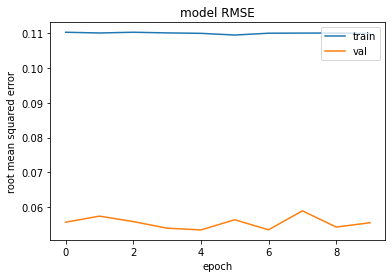

In [ ]:
history_mn_2 = model_2.fit(X_train_mn2, y_train_mn2, validation_data=(X_val1_mn2, y_val1_mn2), epochs=50, callbacks=[early_stopping_monitor],verbose=False)

# summarize history for rmse
plt.plot(history_mn_2.history['root_mean_squared_error'])
plt.plot(history_mn_2.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


In [ ]:
print(classification_report(test_results_mn_2['actuals'], test_results_mn_2['predictions']))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       682
         1.0       0.98      0.95      0.96        42

    accuracy                           1.00       724
   macro avg       0.99      0.98      0.98       724
weighted avg       1.00      1.00      1.00       724



###comparing all LSTM models

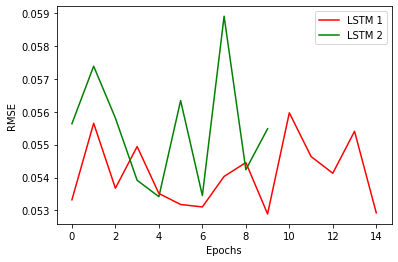

In [ ]:
plt.plot(history_mn_1.history['val_root_mean_squared_error'], 'r',
         history_mn_2.history['val_root_mean_squared_error'],'g')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['LSTM 1', 'LSTM 2'], loc='upper right')
plt.show()

####predicting for 1 jan 2021 until 1 feb 2021 using the 2nd model

In [ ]:
df_date = pd.DataFrame({
    'date':pd.date_range(start='2021-01-01', end='2021-02-01')
})
df_date

date
0  2021-01-01
1  2021-01-02
2  2021-01-03
3  2021-01-04
4  2021-01-05
5  2021-01-06
6  2021-01-07
7  2021-01-08
8  2021-01-09
9  2021-01-10
10 2021-01-11
11 2021-01-12
12 2021-01-13
13 2021-01-14
14 2021-01-15
15 2021-01-16
16 2021-01-17
17 2021-01-18
18 2021-01-19
19 2021-01-20
20 2021-01-21
21 2021-01-22
22 2021-01-23
23 2021-01-24
24 2021-01-25
25 2021-01-26
26 2021-01-27
27 2021-01-28
28 2021-01-29
29 2021-01-30
30 2021-01-31
31 2021-02-01

In [ ]:
df_date.index = pd.to_datetime(df_date['date'], format='%Y.%m.%d')
df_date

date
date                 
2021-01-01 2021-01-01
2021-01-02 2021-01-02
2021-01-03 2021-01-03
2021-01-04 2021-01-04
2021-01-05 2021-01-05
2021-01-06 2021-01-06
2021-01-07 2021-01-07
2021-01-08 2021-01-08
2021-01-09 2021-01-09
2021-01-10 2021-01-10
2021-01-11 2021-01-11
2021-01-12 2021-01-12
2021-01-13 2021-01-13
2021-01-14 2021-01-14
2021-01-15 2021-01-15
2021-01-16 2021-01-16
2021-01-17 2021-01-17
2021-01-18 2021-01-18
2021-01-19 2021-01-19
2021-01-20 2021-01-20
2021-01-21 2021-01-21
2021-01-22 2021-01-22
2021-01-23 2021-01-23
2021-01-24 2021-01-24
2021-01-25 2021-01-25
2021-01-26 2021-01-26
2021-01-27 2021-01-27
2021-01-28 2021-01-28
2021-01-29 2021-01-29
2021-01-30 2021-01-30
2021-01-31 2021-01-31
2021-02-01 2021-02-01

In [ ]:
df_date['Seconds'] = df_date.index.map(pd.Timestamp.timestamp)
df_date

date       Seconds
date                               
2021-01-01 2021-01-01  1.609459e+09
2021-01-02 2021-01-02  1.609546e+09
2021-01-03 2021-01-03  1.609632e+09
2021-01-04 2021-01-04  1.609718e+09
2021-01-05 2021-01-05  1.609805e+09
2021-01-06 2021-01-06  1.609891e+09
2021-01-07 2021-01-07  1.609978e+09
2021-01-08 2021-01-08  1.610064e+09
2021-01-09 2021-01-09  1.610150e+09
2021-01-10 2021-01-10  1.610237e+09
2021-01-11 2021-01-11  1.610323e+09
2021-01-12 2021-01-12  1.610410e+09
2021-01-13 2021-01-13  1.610496e+09
2021-01-14 2021-01-14  1.610582e+09
2021-01-15 2021-01-15  1.610669e+09
2021-01-16 2021-01-16  1.610755e+09
2021-01-17 2021-01-17  1.610842e+09
2021-01-18 2021-01-18  1.610928e+09
2021-01-19 2021-01-19  1.611014e+09
2021-01-20 2021-01-20  1.611101e+09
2021-01-21 2021-01-21  1.611187e+09
2021-01-22 2021-01-22  1.611274e+09
2021-01-23 2021-01-23  1.611360e+09
2021-01-24 2021-01-24  1.611446e+09
2021-01-25 2021-01-25  1.611533e+09
2021-01-26 2021-01-26  1.611619e+09
2021-01-27 2021-01-27  1.611706e+09
2021-01-28 2021-01-28  1.611792e+09
2021-01-29 2021-01-29  1.611878e+09
2021-01-30 2021-01-30  1.611965e+09
2021-01-31 2021-01-31  1.612051e+09
2021-02-01 2021-02-01  1.612138e+09

In [ ]:
df_date['Day sin'] = np.sin(df_date['Seconds'] * (2* np.pi / day))
df_date['Day cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / day))
df_date['Month sin'] = np.sin(df_date['Seconds'] * (2* np.pi / month))
df_date['Month cos'] = np.cos(df_date['Seconds'] * (2* np.pi / month))
df_date['Year sin'] = np.sin(df_date['Seconds'] * (2 * np.pi / year))
df_date['Year cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / year))
df_date.head()

date       Seconds       Day sin  Day cos  Month sin  \
date                                                                    
2021-01-01 2021-01-01  1.609459e+09 -6.012051e-12      1.0   0.114525   
2021-01-02 2021-01-02  1.609546e+09 -1.713513e-12      1.0   0.315714   
2021-01-03 2021-01-03  1.609632e+09 -1.196689e-11      1.0   0.503497   
2021-01-04 2021-01-04  1.609718e+09 -7.668351e-12      1.0   0.669900   
2021-01-05 2021-01-05  1.609805e+09 -3.369812e-12      1.0   0.807857   

            Month cos  Year sin  Year cos  
date                                       
2021-01-01   0.993420  0.010881  0.999941  
2021-01-02   0.948854  0.028080  0.999606  
2021-01-03   0.863997  0.045271  0.998975  
2021-01-04   0.742451  0.062448  0.998048  
2021-01-05   0.589379  0.079608  0.996826

In [ ]:
df_date = df_date.drop('Seconds', axis=1)
df_date = df_date.drop('date',axis=1)
df_date.head()

Day sin  Day cos  Month sin  Month cos  Year sin  Year cos
date                                                                       
2021-01-01 -6.012051e-12      1.0   0.114525   0.993420  0.010881  0.999941
2021-01-02 -1.713513e-12      1.0   0.315714   0.948854  0.028080  0.999606
2021-01-03 -1.196689e-11      1.0   0.503497   0.863997  0.045271  0.998975
2021-01-04 -7.668351e-12      1.0   0.669900   0.742451  0.062448  0.998048
2021-01-05 -3.369812e-12      1.0   0.807857   0.589379  0.079608  0.996826

In [ ]:
df_date.insert(0, "score", [0 for i in range(32)], True)
df_date

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2021-01-01      0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02      0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03      0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04      0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05      0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06      0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07      0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08      0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09      0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10      0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11      0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12      0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13      0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14      0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15      0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16      0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17      0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18      0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19      0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20      0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21      0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22      0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23      0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24      0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25      0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26      0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27      0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28      0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29      0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30      0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31      0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01      0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861  
2021-01-31  0.864338  
2021-02-01  0.855559

In [ ]:
x_test_mn = scoremn_test_df.tail(7)
x_test_mn

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    1.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    1.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    1.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    1.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    1.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    1.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    1.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980

In [ ]:
x_test1_mn = x_test_mn.append(df_date)
x_test1_mn

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    1.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    1.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    1.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    1.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    1.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    1.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    1.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   
2021-01-01    0.0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02    0.0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03    0.0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04    0.0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05    0.0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06    0.0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07    0.0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08    0.0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09    0.0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10    0.0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11    0.0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12    0.0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13    0.0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14    0.0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15    0.0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16    0.0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17    0.0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18    0.0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19    0.0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20    0.0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21    0.0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22    0.0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23    0.0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24    0.0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25    0.0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26    0.0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27    0.0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28    0.0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29    0.0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30    0.0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31    0.0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01    0.0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861 

In [ ]:
WINDOW_SIZE = 7
X_test1_mn2_new, y_test1_mn2_new = df_to_X_y2(x_test1_mn, WINDOW_SIZE)
X_test1_mn2_new.shape

(32, 7, 7)

In [ ]:
test_prediction_2_new_mn = model_2.predict(X_test1_mn2_new).flatten()
test_results_2_new_mn = pd.DataFrame(data={'predictions':test_prediction_2_new_mn})
test_results_2_new_mn

1/1 [==============================] - 0s 25ms/step


predictions
0      1.646940
1      0.773638
2      0.645217
3      0.620636
4      0.628862
5      0.643890
6      0.656167
7      0.663593
8      0.663878
9      0.664638
10     0.665769
11     0.667102
12     0.668424
13     0.669545
14     0.670383
15     0.670998
16     0.671576
17     0.672347
18     0.673486
19     0.675040
20     0.676928
21     0.678990
22     0.681059
23     0.682992
24     0.684638
25     0.685789
26     0.686154
27     0.685425
28     0.683411
29     0.680175
30     0.676075
31     0.671674

#####result

In [ ]:
test_results_2_new_mn.predictions[test_results_2_new_mn.predictions <0.5] = 0
test_results_2_new_mn.predictions[(test_results_2_new_mn.predictions >=0.5)&(test_results_2_new_mn.predictions<1.5)] = 1
test_results_2_new_mn.predictions[(test_results_2_new_mn.predictions >=1.5)&(test_results_2_new_mn.predictions<2.5)] = 2
test_results_2_new_mn.predictions[(test_results_2_new_mn.predictions >=2.5)&(test_results_2_new_mn.predictions<3.5)] = 3
test_results_2_new_mn.predictions[(test_results_2_new_mn.predictions >=3.5)&(test_results_2_new_mn.predictions<4.5)] = 4
test_results_2_new_mn.predictions[(test_results_2_new_mn.predictions >=4.5)&(test_results_2_new_mn.predictions<5.5)] = 5
test_results_2_new_mn

predictions
0           2.0
1           1.0
2           1.0
3           1.0
4           1.0
5           1.0
6           1.0
7           1.0
8           1.0
9           1.0
10          1.0
11          1.0
12          1.0
13          1.0
14          1.0
15          1.0
16          1.0
17          1.0
18          1.0
19          1.0
20          1.0
21          1.0
22          1.0
23          1.0
24          1.0
25          1.0
26          1.0
27          1.0
28          1.0
29          1.0
30          1.0
31          1.0

##Los Angeles, California

###train

In [ ]:
los_angeles = train[train['fips']==6037]

#using interpolation to fill in the NaN values
los_angeles = los_angeles.interpolate().fillna(method='bfill')
los_angeles.score[los_angeles.score <0.5] = 0
los_angeles.score[(los_angeles.score >=0.5)&(los_angeles.score<1.5)] = 1
los_angeles.score[(los_angeles.score >=1.5)&(los_angeles.score<2.5)] = 2
los_angeles.score[(los_angeles.score >=2.5)&(los_angeles.score<3.5)] = 3
los_angeles.score[(los_angeles.score >=3.5)&(los_angeles.score<4.5)] = 4
los_angeles.score[(los_angeles.score >=4.5)&(los_angeles.score<5.5)] = 5

#merging the weather data with the soil data
los_angeles = los_angeles.merge(soil, left_on='fips', right_on='fips')
train_la = los_angeles.copy()
los_angeles['date'] = pd.to_datetime(los_angeles['date'], format='%Y.%m.%d')
train_la['tahun'] = los_angeles['date'].dt.year
train_la['bulan'] = los_angeles['date'].dt.month
train_la['tanggal'] = los_angeles['date'].dt.day
train_la[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   6037  2000-01-01     0.25  95.11  5.46   7.08    4.13    4.14    11.71   
1   6037  2000-01-02     0.11  95.44  3.81   6.37   -1.17   -1.07    12.00   
2   6037  2000-01-03     0.00  96.04  3.02   7.72   -3.92   -3.78    15.91   
3   6037  2000-01-04     0.28  95.92  3.21   9.38   -3.31   -3.16    17.87   
4   6037  2000-01-05     0.05  95.38  2.85   9.77   -5.15   -4.86    17.69   
5   6037  2000-01-06     0.02  95.98  2.08   9.32   -8.93   -8.35    17.11   
6   6037  2000-01-07     0.02  95.75  2.68   9.77   -6.54   -6.11    18.31   
7   6037  2000-01-08     0.15  95.48  2.68   9.64   -6.40   -6.00    19.09   
8   6037  2000-01-09     0.07  95.44  3.86  10.15   -1.14   -1.02    20.01   
9   6037  2000-01-10     0.12  95.29  4.55   8.74    1.51    1.55    18.00   
10  6037  2000-01-11     1.91  95.29  5.45   9.94    4.00    4.01    18.70   
11  6037  2000-01-12     0.33  95.48  6.42  11.01    6.42    6.43    18.35   
12  6037  2000-01-13     0.11  95.65  4.90  13.84    2.22    2.29    23.37   
13  6037  2000-01-14     0.15  95.44  3.84  15.88   -0.99   -0.85    24.05   
14  6037  2000-01-15     0.13  95.21  5.07  13.87    2.73    2.77    18.51   
15  6037  2000-01-16     0.76  95.48  6.96  11.64    7.70    7.71    13.50   
16  6037  2000-01-17     1.84  95.51  8.89  14.01   11.48   11.48    18.13   
17  6037  2000-01-18     0.45  95.39  8.13  15.62   10.07   10.07    21.89   
18  6037  2000-01-19     1.09  95.40  7.93  14.74    9.70    9.70    20.93   
19  6037  2000-01-20     0.84  95.26  8.41  13.38   10.61   10.62    18.69   
20  6037  2000-01-21     0.05  95.14  6.45  11.34    6.26    6.27    16.26   
21  6037  2000-01-22     0.23  95.15  5.55  10.10    4.20    4.22    16.36   
22  6037  2000-01-23     1.16  95.34  6.82  12.22    7.27    7.28    17.90   
23  6037  2000-01-24     3.51  95.34  8.24  13.65   10.28   10.28    18.26   
24  6037  2000-01-25     9.90  95.10  8.59  11.92   10.88   10.88    14.14   
25  6037  2000-01-26     0.41  95.22  5.50   9.74    4.13    4.15    16.50   
26  6037  2000-01-27     0.00  95.45  4.41  10.45    0.74    0.81    18.33   
27  6037  2000-01-28     0.02  95.43  3.27   9.92   -3.78   -3.55    17.82   
28  6037  2000-01-29     0.20  95.28  4.18   9.71   -1.09   -0.91    16.62   
29  6037  2000-01-30     3.20  95.40  7.49   9.85    8.88    8.88    11.57   
30  6037  2000-01-31     1.37  95.54  5.97  10.29    5.30    5.31    15.50   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0      4.50       7.22   7.81   3.20       4.73       1.17         3.56   
1      3.34       8.66   6.68   6.24       8.31       4.42         3.88   
2      2.29      13.63   7.76   4.59       6.61       2.27         4.34   
3      4.07      13.80   9.22   3.96       6.11       1.38         4.74   
4      4.62      13.07   9.60   6.86       7.95       5.72         2.24   
5      5.04      12.07   8.78   5.87       9.96       2.38         7.58   
6      4.71      13.60   9.09   2.68       4.26       0.31         3.95   
7      3.30      15.79   9.25   3.09       5.29       0.07         5.21   
8      4.54      15.47   9.95   3.84       5.44       2.50         2.94   
9      3.10      14.90   8.85   3.99       4.82       3.11         1.72   
10     4.30      14.39   9.77   3.05       5.26       1.58         3.68   
11     6.78      11.56  10.91   2.32       4.40       0.69         3.72   
12     6.46      16.90  11.67   2.25       3.58       0.91         2.67   
13    10.20      13.85  13.55   2.48       3.34       0.68         2.65   
14    11.32       7.18  11.97   2.60       3.66       1.87         1.80   
15    10.17       3.32  10.61   1.87       3.52       0.87         2.65   
16    11.28       6.85  12.70   1.45       3.20       0.60         2.60   
17    12.75       9.14  14.86   2.72       4.69       1.72         2.97   
18    10.48      10.45  14.22   2.54       4.59       1.33         3.26   
19    1

In [ ]:
train_la['score'].value_counts()

0.0    2411
1.0     954
5.0     918
2.0     787
3.0     675
4.0     465
Name: score, dtype: int64

In [ ]:
#For Regression

los_angeles = train[train['fips']==6037]

#using interpolation to fill in the NaN values
los_angeles = los_angeles.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
los_angeles = los_angeles.merge(soil, left_on='fips', right_on='fips')
train_la = los_angeles.copy()
train_la[2000:2050]

fips        date  PRECTOT     PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
2000  6037  2005-06-23     0.00  94.83   6.69  20.40    6.37    6.41    27.83   
2001  6037  2005-06-24     0.00  94.80   6.23  19.94    5.24    5.30    28.48   
2002  6037  2005-06-25     0.00  94.70   6.68  17.68    6.54    6.57    24.89   
2003  6037  2005-06-26     0.00  94.71   7.57  17.75    8.79    8.80    25.31   
2004  6037  2005-06-27     0.00  94.77   7.28  17.73    8.05    8.07    25.34   
2005  6037  2005-06-28     0.00  94.80   8.10  19.00    9.84    9.85    27.61   
2006  6037  2005-06-29     0.00  94.75   8.15  21.94    9.73    9.74    30.35   
2007  6037  2005-06-30     0.00  94.76   8.37  23.10   10.24   10.24    31.40   
2008  6037  2005-07-01     0.00  94.76   8.23  23.52    9.97    9.97    31.85   
2009  6037  2005-07-02     0.05  94.77   9.14  22.31   11.59   11.59    29.61   
2010  6037  2005-07-03     0.01  94.83   7.99  21.61    9.43    9.44    30.13   
2011  6037  2005-07-04     0.01  94.94   7.61  21.71    8.61    8.62    29.62   
2012  6037  2005-07-05     0.00  94.84   7.68  21.89    8.87    8.88    29.87   
2013  6037  2005-07-06     0.00  94.77   8.08  22.20    9.68    9.69    29.97   
2014  6037  2005-07-07     0.00  94.85   8.72  22.91   10.97   10.97    30.70   
2015  6037  2005-07-08     0.00  94.87   9.45  22.22   12.18   12.18    29.66   
2016  6037  2005-07-09     0.00  94.79   9.77  21.67   12.66   12.66    29.13   
2017  6037  2005-07-10     0.01  94.77   9.83  22.15   12.79   12.79    30.13   
2018  6037  2005-07-11     0.00  94.79   9.12  24.29   11.51   11.51    32.71   
2019  6037  2005-07-12     0.00  94.96   8.15  25.57    9.82    9.82    33.41   
2020  6037  2005-07-13     0.00  94.91   7.55  27.85    8.35    8.35    35.95   
2021  6037  2005-07-14     0.00  94.68   8.02  28.77    9.05    9.05    36.17   
2022  6037  2005-07-15     0.00  94.61  10.55  27.14   13.50   13.50    34.96   
2023  6037  2005-07-16     0.00  94.65  10.24  26.80   13.18   13.19    33.58   
2024  6037  2005-07-17     0.00  94.69   9.43  26.82   12.00   12.00    33.99   
2025  6037  2005-07-18     0.00  94.46   8.96  28.53   11.10   11.09    37.53   
2026  6037  2005-07-19     0.00  94.44  10.58  29.27   13.58   13.58    36.96   
2027  6037  2005-07-20     0.05  94.74  10.54  28.63   13.84   13.84    35.30   
2028  6037  2005-07-21     0.00  94.75  10.39  29.28   13.71   13.71    36.07   
2029  6037  2005-07-22     0.06  94.76  10.49  29.89   13.83   13.83    36.94   
2030  6037  2005-07-23     0.20  94.93  12.30  27.74   16.29   16.29    34.66   
2031  6037  2005-07-24     1.37  94.97  13.46  25.89   17.72   17.72    31.91   
2032  6037  2005-07-25     0.02  94.86  10.19  25.25   12.87   12.88    33.16   
2033  6037  2005-07-26     0.00  94.85   9.65  25.89   12.13   12.14    34.23   
2034  6037  2005-07-27     0.00  94.87   9.29  26.54   11.87   11.88    34.21   
2035  6037  2005-07-28     0.00  94.87   9.43  26.59   12.16   12.17    33.61   
2036  6037  2005-07-29     0.00  94.97   8.62  26.37   10.63   10.64    33.61   
2037  6037  2005-07-30     0.02  95.09   8.86  26.85   11.09   11.09    34.02   
2038  6037  2005-07-31     0.01  95.02   9.19  27.41   11.69   11.69    34.62   
2039  6037  2005-08-01     0.01  94.88   7.97  25.97    9.36    9.37    33.85   
2040  6037  2005-08-02     0.01  94.88   7.97  25.19    9.33    9.34    32.92   
2041  6037  2005-08-03     0.01  94.96   7.53  25.39    8.44    8.45    33.09   
2042  6037  2005-08-04     0.07  94.99   7.31  26.80    8.05    8.06    34.81   
2043  6037  2005-08-05     0.05  95.01   8.30  27.53    9.99   10.00    34.36   
2044  6037  2005-08-06     0.25  94.97   9.60  28.24   12.46   12.46    34.60   
2045  6037  2005-08-07     0.03  94.88   9.11  27.01   11.61   11.61    33.90   
2046  6037  2005-08-08     0.00  94.84   8.21  26.60   10.07   10.07    34.48   
2047  6037  2005-08-09     0.01  95.01   8.82  25.70   10.98   10.98    32.48   
2048  6037  2005-08-10     0.00  95.0

###validation

In [ ]:
los_angeles_val = validation[validation['fips']==6037]

#using interpolation to fill in the NaN values
los_angeles_val = los_angeles_val.interpolate().fillna(method='bfill')
los_angeles_val.score[los_angeles_val.score <0.5] = 0
los_angeles_val.score[(los_angeles_val.score >=0.5)&(los_angeles_val.score<1.5)] = 1
los_angeles_val.score[(los_angeles_val.score >=1.5)&(los_angeles_val.score<2.5)] = 2
los_angeles_val.score[(los_angeles_val.score >=2.5)&(los_angeles_val.score<3.5)] = 3
los_angeles_val.score[(los_angeles_val.score >=3.5)&(los_angeles_val.score<4.5)] = 4
los_angeles_val.score[(los_angeles_val.score >=4.5)&(los_angeles_val.score<5.5)] = 5

#merging the weather data with the soil data
los_angeles_val = los_angeles_val.merge(soil, left_on='fips', right_on='fips')
val_la = los_angeles_val.copy()
los_angeles_val['date'] = pd.to_datetime(los_angeles_val['date'], format='%Y.%m.%d')
val_la['tahun'] = los_angeles_val['date'].dt.year
val_la['bulan'] = los_angeles_val['date'].dt.month
val_la['tanggal'] = los_angeles_val['date'].dt.day
val_la[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   6037  2017-01-01     0.16  94.61  5.28   7.08    3.64    3.65    12.71   
1   6037  2017-01-02     0.54  95.05  6.03   7.52    5.70    5.70     9.03   
2   6037  2017-01-03     0.06  95.36  6.06   8.26    5.81    5.81    11.57   
3   6037  2017-01-04     3.74  95.22  7.04   9.07    7.92    7.92    11.64   
4   6037  2017-01-05     8.11  94.87  8.17  10.95   10.02   10.02    14.79   
5   6037  2017-01-06     0.30  95.20  4.29   7.51    0.12    0.19    14.05   
6   6037  2017-01-07     8.51  95.54  5.46   9.82    3.79    3.81    14.93   
7   6037  2017-01-08     0.53  95.57  6.27  13.23    6.00    6.02    19.82   
8   6037  2017-01-09    19.49  95.43  8.24  11.49   10.23   10.23    14.77   
9   6037  2017-01-10     3.40  95.20  7.31   9.64    8.44    8.44    12.00   
10  6037  2017-01-11     8.61  94.88  7.48  11.18    8.64    8.64    14.61   
11  6037  2017-01-12    19.79  94.79  6.94   8.78    7.64    7.64     9.70   
12  6037  2017-01-13     2.68  95.00  5.92   8.21    5.38    5.39    11.82   
13  6037  2017-01-14     0.00  95.14  5.53  10.08    4.32    4.33    17.37   
14  6037  2017-01-15     0.26  95.12  6.01   9.29    5.23    5.24    14.81   
15  6037  2017-01-16     0.08  95.22  4.86   8.91    1.78    1.84    15.49   
16  6037  2017-01-17     0.00  95.36  3.68   8.76   -2.05   -1.93    15.85   
17  6037  2017-01-18     2.62  95.31  5.26   8.57    3.12    3.15    12.67   
18  6037  2017-01-19    17.55  94.66  6.79   9.72    7.16    7.17    13.23   
19  6037  2017-01-20    38.21  93.69  6.74   8.26    6.99    6.99    11.31   
20  6037  2017-01-21     0.61  94.47  5.80   7.82    4.91    4.92    12.70   
21  6037  2017-01-22    60.05  94.76  7.08   8.70    7.86    7.87    11.73   
22  6037  2017-01-23    11.88  94.46  5.56   6.05    4.31    4.31     8.27   
23  6037  2017-01-24     0.25  94.91  4.17   4.91    0.31    0.34     9.49   
24  6037  2017-01-25     0.00  95.74  3.72   5.49   -1.23   -1.18    12.15   
25  6037  2017-01-26     0.00  95.97  3.68   5.61   -1.26   -1.21    12.48   
26  6037  2017-01-27     0.00  96.47  3.33   5.96   -2.57   -2.49    11.81   
27  6037  2017-01-28     0.00  96.41  3.83   8.84   -0.83   -0.77    17.38   
28  6037  2017-01-29     0.00  96.03  4.43  10.71    1.01    1.06    19.70   
29  6037  2017-01-30     0.00  95.57  4.94  12.46    2.66    2.68    21.08   
30  6037  2017-01-31     0.00  95.37  5.37  13.32    3.72    3.74    20.48   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0      3.14       9.57   7.82   3.51       4.56       2.56         1.99   
1      6.51       2.52   7.78   2.80       4.60       1.37         3.23   
2      6.51       5.06   7.98   1.36       2.93       0.52         2.41   
3      6.58       5.07   8.85   2.46       4.68       0.33         4.35   
4      6.86       7.93  10.95   3.99       6.35       2.31         4.04   
5      3.65      10.40   7.13   3.37       5.81       1.24         4.57   
6      4.74      10.18   8.66   3.13       5.16       1.66         3.50   
7      9.81      10.01  11.61   3.09       5.81       2.08         3.73   
8      7.97       6.80  11.43   2.92       4.04       1.93         2.11   
9      7.27       4.73   9.69   3.69       5.52       1.71         3.82   
10     8.74       5.88  11.58   4.74       6.31       2.77         3.55   
11     7.49       2.21   8.56   3.03       5.29       0.53         4.76   
12     4.76       7.06   7.96   2.81       4.43       0.07         4.37   
13     6.07      11.30   9.32   4.09       6.75       2.52         4.23   
14     4.17      10.64   8.90   2.39       3.94       0.50         3.44   
15     4.79      10.70   8.24   2.47       5.19       1.03         4.16   
16     2.91      12.94   6.86   2.00       4.44       0.38         4.06   
17     5.70       6.96   7.59   2.42       4.44       0.28         4.16   
18     7.08       6.15  10.11   5.02       6.86       2.92         3.94   
19     

In [ ]:
val_la['score'].value_counts()

2.0    357
3.0    352
4.0     17
5.0      4
Name: score, dtype: int64

In [ ]:
#For Regression

los_angeles_val = validation[validation['fips']==6037]

#using interpolation to fill in the NaN values
los_angeles_val = los_angeles_val.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
los_angeles_val = los_angeles_val.merge(soil, left_on='fips', right_on='fips')
val_la = los_angeles_val.copy()
val_la[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   6037  2017-01-01     0.16  94.61  5.28   7.08    3.64    3.65    12.71   
1   6037  2017-01-02     0.54  95.05  6.03   7.52    5.70    5.70     9.03   
2   6037  2017-01-03     0.06  95.36  6.06   8.26    5.81    5.81    11.57   
3   6037  2017-01-04     3.74  95.22  7.04   9.07    7.92    7.92    11.64   
4   6037  2017-01-05     8.11  94.87  8.17  10.95   10.02   10.02    14.79   
5   6037  2017-01-06     0.30  95.20  4.29   7.51    0.12    0.19    14.05   
6   6037  2017-01-07     8.51  95.54  5.46   9.82    3.79    3.81    14.93   
7   6037  2017-01-08     0.53  95.57  6.27  13.23    6.00    6.02    19.82   
8   6037  2017-01-09    19.49  95.43  8.24  11.49   10.23   10.23    14.77   
9   6037  2017-01-10     3.40  95.20  7.31   9.64    8.44    8.44    12.00   
10  6037  2017-01-11     8.61  94.88  7.48  11.18    8.64    8.64    14.61   
11  6037  2017-01-12    19.79  94.79  6.94   8.78    7.64    7.64     9.70   
12  6037  2017-01-13     2.68  95.00  5.92   8.21    5.38    5.39    11.82   
13  6037  2017-01-14     0.00  95.14  5.53  10.08    4.32    4.33    17.37   
14  6037  2017-01-15     0.26  95.12  6.01   9.29    5.23    5.24    14.81   
15  6037  2017-01-16     0.08  95.22  4.86   8.91    1.78    1.84    15.49   
16  6037  2017-01-17     0.00  95.36  3.68   8.76   -2.05   -1.93    15.85   
17  6037  2017-01-18     2.62  95.31  5.26   8.57    3.12    3.15    12.67   
18  6037  2017-01-19    17.55  94.66  6.79   9.72    7.16    7.17    13.23   
19  6037  2017-01-20    38.21  93.69  6.74   8.26    6.99    6.99    11.31   
20  6037  2017-01-21     0.61  94.47  5.80   7.82    4.91    4.92    12.70   
21  6037  2017-01-22    60.05  94.76  7.08   8.70    7.86    7.87    11.73   
22  6037  2017-01-23    11.88  94.46  5.56   6.05    4.31    4.31     8.27   
23  6037  2017-01-24     0.25  94.91  4.17   4.91    0.31    0.34     9.49   
24  6037  2017-01-25     0.00  95.74  3.72   5.49   -1.23   -1.18    12.15   
25  6037  2017-01-26     0.00  95.97  3.68   5.61   -1.26   -1.21    12.48   
26  6037  2017-01-27     0.00  96.47  3.33   5.96   -2.57   -2.49    11.81   
27  6037  2017-01-28     0.00  96.41  3.83   8.84   -0.83   -0.77    17.38   
28  6037  2017-01-29     0.00  96.03  4.43  10.71    1.01    1.06    19.70   
29  6037  2017-01-30     0.00  95.57  4.94  12.46    2.66    2.68    21.08   
30  6037  2017-01-31     0.00  95.37  5.37  13.32    3.72    3.74    20.48   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0      3.14       9.57   7.82   3.51       4.56       2.56         1.99   
1      6.51       2.52   7.78   2.80       4.60       1.37         3.23   
2      6.51       5.06   7.98   1.36       2.93       0.52         2.41   
3      6.58       5.07   8.85   2.46       4.68       0.33         4.35   
4      6.86       7.93  10.95   3.99       6.35       2.31         4.04   
5      3.65      10.40   7.13   3.37       5.81       1.24         4.57   
6      4.74      10.18   8.66   3.13       5.16       1.66         3.50   
7      9.81      10.01  11.61   3.09       5.81       2.08         3.73   
8      7.97       6.80  11.43   2.92       4.04       1.93         2.11   
9      7.27       4.73   9.69   3.69       5.52       1.71         3.82   
10     8.74       5.88  11.58   4.74       6.31       2.77         3.55   
11     7.49       2.21   8.56   3.03       5.29       0.53         4.76   
12     4.76       7.06   7.96   2.81       4.43       0.07         4.37   
13     6.07      11.30   9.32   4.09       6.75       2.52         4.23   
14     4.17      10.64   8.90   2.39       3.94       0.50         3.44   
15     4.79      10.70   8.24   2.47       5.19       1.03         4.16   
16     2.91      12.94   6.86   2.00       4.44       0.38         4.06   
17     5.70       6.96   7.59   2.42       4.44       0.28         4.16   
18     7.08       6.15  10.11   5.02       6.86       2.92         3.94   
19     

###test

In [ ]:
los_angeles_test = test[test['fips']==6037]

#using interpolation to fill in the NaN values
los_angeles_test = los_angeles_test.interpolate().fillna(method='bfill')
los_angeles_test.score[los_angeles_test.score <0.5] = 0
los_angeles_test.score[(los_angeles_test.score >=0.5)&(los_angeles_test.score<1.5)] = 1
los_angeles_test.score[(los_angeles_test.score >=1.5)&(los_angeles_test.score<2.5)] = 2
los_angeles_test.score[(los_angeles_test.score >=2.5)&(los_angeles_test.score<3.5)] = 3
los_angeles_test.score[(los_angeles_test.score >=3.5)&(los_angeles_test.score<4.5)] = 4
los_angeles_test.score[(los_angeles_test.score >=4.5)&(los_angeles_test.score<5.5)] = 5

#merging the weather data with the soil data
los_angeles_test = los_angeles_test.merge(soil, left_on='fips', right_on='fips')
test_la = los_angeles_test.copy()
los_angeles_test['date'] = pd.to_datetime(los_angeles_test['date'], format='%Y.%m.%d')
test_la['tahun'] = los_angeles_test['date'].dt.year
test_la['bulan'] = los_angeles_test['date'].dt.month
test_la['tanggal'] = los_angeles_test['date'].dt.day
test_la[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   6037  2019-01-01     0.00  95.39  2.08   4.26   -8.80   -8.41    10.08   
1   6037  2019-01-02     0.00  95.63  2.43   6.56   -6.78   -6.64    13.79   
2   6037  2019-01-03     0.00  95.50  2.96   7.56   -4.14   -4.32    15.95   
3   6037  2019-01-04     0.00  95.04  3.86   9.08   -0.54   -1.18    17.67   
4   6037  2019-01-05    11.50  94.75  6.66   9.07    7.10    6.61    10.85   
5   6037  2019-01-06     1.54  95.15  6.16   8.86    6.04    5.83    12.97   
6   6037  2019-01-07     5.03  95.55  7.32   9.63    8.58    8.58    12.01   
7   6037  2019-01-08     0.03  95.38  6.65  11.27    7.22    7.00    17.60   
8   6037  2019-01-09     0.23  95.40  7.51  11.82    8.97    8.79    17.67   
9   6037  2019-01-10     0.13  95.32  6.73  11.10    7.37    7.02    17.90   
10  6037  2019-01-11     0.23  95.13  6.25  10.15    6.28    6.00    16.01   
11  6037  2019-01-12    21.50  95.04  6.18   9.00    6.06    5.90    12.29   
12  6037  2019-01-13     0.10  95.17  5.72   8.35    5.00    4.78    14.23   
13  6037  2019-01-14    29.48  94.95  6.35   8.22    6.43    6.21     9.90   
14  6037  2019-01-15    22.40  95.04  6.89   9.33    7.62    7.49    11.79   
15  6037  2019-01-16    16.50  95.41  8.72  12.10   11.16   11.10    14.98   
16  6037  2019-01-17    31.92  95.47  9.02  12.27   11.70   11.65    14.67   
17  6037  2019-01-18     0.20  95.77  6.78  11.08    7.56    7.35    17.79   
18  6037  2019-01-19     0.00  95.79  6.32  12.82    6.58    6.33    21.49   
19  6037  2019-01-20     0.10  95.20  7.61  13.05    9.17    8.84    19.32   
20  6037  2019-01-21     0.31  95.17  5.17   7.68    3.56    3.33    11.68   
21  6037  2019-01-22     0.01  95.85  3.35   7.38   -2.37   -2.78    14.38   
22  6037  2019-01-23     0.04  95.91  3.76   9.70   -0.82   -1.45    18.36   
23  6037  2019-01-24     0.00  95.55  4.97  11.95    3.06    2.69    20.24   
24  6037  2019-01-25     0.00  95.54  4.58  11.74    1.87    1.46    20.62   
25  6037  2019-01-26     0.00  95.79  4.46  12.80    1.51    1.11    20.62   
26  6037  2019-01-27     0.00  95.43  5.72  14.31    5.03    4.54    21.65   
27  6037  2019-01-28     0.00  95.05  6.34  14.31    6.51    6.09    21.25   
28  6037  2019-01-29     0.00  94.78  6.79  14.53    7.46    6.94    20.76   
29  6037  2019-01-30     0.12  94.75  7.01  12.82    7.90    7.46    19.44   
30  6037  2019-01-31    28.91  94.76  7.53  10.15    8.88    8.81    12.19   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0      0.50       9.58   4.13   6.04       9.34       3.35         6.00   
1      2.02      11.77   5.52   3.04       5.49       0.67         4.81   
2      2.11      13.84   6.70   2.88       5.36       0.51         4.85   
3      3.25      14.42   7.88   2.49       3.55       0.68         2.88   
4      7.14       3.71   8.52   3.91       6.12       2.01         4.11   
5      6.58       6.39   9.53   3.29       5.25       1.43         3.83   
6      7.58       4.42   9.55   3.31       5.86       0.32         5.54   
7      7.58      10.02  10.55   3.13       4.30       1.76         2.54   
8      8.87       8.81  11.42   2.16       3.44       1.10         2.33   
9      6.76      11.13  10.44   1.44       2.69       0.08         2.61   
10     6.65       9.36   9.37   2.82       5.12       1.26         3.86   
11     5.54       6.75   9.32   2.42       4.07       0.98         3.09   
12     3.81      10.43   8.21   3.03       4.10       1.66         2.44   
13     7.03       2.88   7.91   4.65       8.41       1.27         7.14   
14     7.08       4.71   9.42   4.44       7.23       1.22         6.01   
15     9.40       5.58  12.24   4.65       6.60       2.55         4.05   
16     9.34       5.33  12.09   5.26       7.27       2.63         4.64   
17     7.24      10.55  10.87   2.28       3.30       1.69         1.61   
18     7.54      13.95  11.67   3.50       5.34       1.87         3.46   
19    1

In [ ]:
test_la['score'].value_counts()

0.0    559
1.0    105
2.0     57
3.0     10
Name: score, dtype: int64

In [ ]:
#For Regression

los_angeles_test = test[test['fips']==6037]

#using interpolation to fill in the NaN values
los_angeles_test = los_angeles_test.interpolate().fillna(method='bfill')

#merging the weather data with the soil data
los_angeles_test = los_angeles_test.merge(soil, left_on='fips', right_on='fips')
test_la = los_angeles_test.copy()
test_la[0:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0   6037  2019-01-01     0.00  95.39  2.08   4.26   -8.80   -8.41    10.08   
1   6037  2019-01-02     0.00  95.63  2.43   6.56   -6.78   -6.64    13.79   
2   6037  2019-01-03     0.00  95.50  2.96   7.56   -4.14   -4.32    15.95   
3   6037  2019-01-04     0.00  95.04  3.86   9.08   -0.54   -1.18    17.67   
4   6037  2019-01-05    11.50  94.75  6.66   9.07    7.10    6.61    10.85   
5   6037  2019-01-06     1.54  95.15  6.16   8.86    6.04    5.83    12.97   
6   6037  2019-01-07     5.03  95.55  7.32   9.63    8.58    8.58    12.01   
7   6037  2019-01-08     0.03  95.38  6.65  11.27    7.22    7.00    17.60   
8   6037  2019-01-09     0.23  95.40  7.51  11.82    8.97    8.79    17.67   
9   6037  2019-01-10     0.13  95.32  6.73  11.10    7.37    7.02    17.90   
10  6037  2019-01-11     0.23  95.13  6.25  10.15    6.28    6.00    16.01   
11  6037  2019-01-12    21.50  95.04  6.18   9.00    6.06    5.90    12.29   
12  6037  2019-01-13     0.10  95.17  5.72   8.35    5.00    4.78    14.23   
13  6037  2019-01-14    29.48  94.95  6.35   8.22    6.43    6.21     9.90   
14  6037  2019-01-15    22.40  95.04  6.89   9.33    7.62    7.49    11.79   
15  6037  2019-01-16    16.50  95.41  8.72  12.10   11.16   11.10    14.98   
16  6037  2019-01-17    31.92  95.47  9.02  12.27   11.70   11.65    14.67   
17  6037  2019-01-18     0.20  95.77  6.78  11.08    7.56    7.35    17.79   
18  6037  2019-01-19     0.00  95.79  6.32  12.82    6.58    6.33    21.49   
19  6037  2019-01-20     0.10  95.20  7.61  13.05    9.17    8.84    19.32   
20  6037  2019-01-21     0.31  95.17  5.17   7.68    3.56    3.33    11.68   
21  6037  2019-01-22     0.01  95.85  3.35   7.38   -2.37   -2.78    14.38   
22  6037  2019-01-23     0.04  95.91  3.76   9.70   -0.82   -1.45    18.36   
23  6037  2019-01-24     0.00  95.55  4.97  11.95    3.06    2.69    20.24   
24  6037  2019-01-25     0.00  95.54  4.58  11.74    1.87    1.46    20.62   
25  6037  2019-01-26     0.00  95.79  4.46  12.80    1.51    1.11    20.62   
26  6037  2019-01-27     0.00  95.43  5.72  14.31    5.03    4.54    21.65   
27  6037  2019-01-28     0.00  95.05  6.34  14.31    6.51    6.09    21.25   
28  6037  2019-01-29     0.00  94.78  6.79  14.53    7.46    6.94    20.76   
29  6037  2019-01-30     0.12  94.75  7.01  12.82    7.90    7.46    19.44   
30  6037  2019-01-31    28.91  94.76  7.53  10.15    8.88    8.81    12.19   

    T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0      0.50       9.58   4.13   6.04       9.34       3.35         6.00   
1      2.02      11.77   5.52   3.04       5.49       0.67         4.81   
2      2.11      13.84   6.70   2.88       5.36       0.51         4.85   
3      3.25      14.42   7.88   2.49       3.55       0.68         2.88   
4      7.14       3.71   8.52   3.91       6.12       2.01         4.11   
5      6.58       6.39   9.53   3.29       5.25       1.43         3.83   
6      7.58       4.42   9.55   3.31       5.86       0.32         5.54   
7      7.58      10.02  10.55   3.13       4.30       1.76         2.54   
8      8.87       8.81  11.42   2.16       3.44       1.10         2.33   
9      6.76      11.13  10.44   1.44       2.69       0.08         2.61   
10     6.65       9.36   9.37   2.82       5.12       1.26         3.86   
11     5.54       6.75   9.32   2.42       4.07       0.98         3.09   
12     3.81      10.43   8.21   3.03       4.10       1.66         2.44   
13     7.03       2.88   7.91   4.65       8.41       1.27         7.14   
14     7.08       4.71   9.42   4.44       7.23       1.22         6.01   
15     9.40       5.58  12.24   4.65       6.60       2.55         4.05   
16     9.34       5.33  12.09   5.26       7.27       2.63         4.64   
17     7.24      10.55  10.87   2.28       3.30       1.69         1.61   
18     7.54      13.95  11.67   3.50       5.34       1.87         3.46   
19    1

###MLP model (with weather and soil data)

####preprocessing data

In [ ]:
score_la = train_la['score']
score_val_la = val_la['score']
score_test_la = test_la['score']

In [ ]:
score_arr_la = score_la.copy()
score_val_arr_la = score_val_la.copy()
score_test_arr_la = score_test_la.copy()

In [ ]:
score_arr_la = score_arr_la.to_numpy()
score_val_arr_la = score_val_arr_la.to_numpy()
score_test_arr_la = score_test_arr_la.to_numpy()

In [ ]:
score_arr_la =pd.DataFrame(score_arr_la, columns=['Score']) 
score_arr_la

Score
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
...     ...
6205    5.0
6206    5.0
6207    5.0
6208    5.0
6209    5.0

[6210 rows x 1 columns]

In [ ]:
score_val_arr_la =pd.DataFrame(score_val_arr_la, columns=['Score']) 
score_val_arr_la

Score
0      5.0
1      5.0
2      5.0
3      5.0
4      4.0
..     ...
725    3.0
726    3.0
727    3.0
728    3.0
729    3.0

[730 rows x 1 columns]

In [ ]:
#score_arr_la = to_categorical(score_arr_la,num_classes=6)
#score_val_arr_la = to_categorical(score_val_arr_la,num_classes=6)
score_test_arr_la = to_categorical(score_test_arr_la,num_classes=6)

In [ ]:
los_angeles_train = train_la.copy()
los_angeles_val = val_la.copy()
los_angeles_test = test_la.copy()

In [ ]:
train_la

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
0     6037  2000-01-01     0.25  95.11  5.46   7.08    4.13    4.14    11.71   
1     6037  2000-01-02     0.11  95.44  3.81   6.37   -1.17   -1.07    12.00   
2     6037  2000-01-03     0.00  96.04  3.02   7.72   -3.92   -3.78    15.91   
3     6037  2000-01-04     0.28  95.92  3.21   9.38   -3.31   -3.16    17.87   
4     6037  2000-01-05     0.05  95.38  2.85   9.77   -5.15   -4.86    17.69   
...    ...         ...      ...    ...   ...    ...     ...     ...      ...   
6205  6037  2016-12-27     0.00  95.67  3.50   8.94   -1.86   -2.29    18.19   
6206  6037  2016-12-28     0.00  95.57  3.95  11.43   -0.66   -0.58    20.82   
6207  6037  2016-12-29     0.00  95.49  4.63  13.51    1.66    1.71    21.90   
6208  6037  2016-12-30     9.87  95.09  6.61  11.64    6.68    6.68    16.20   
6209  6037  2016-12-31     7.98  94.62  6.75   8.68    7.06    7.06    12.48   

      T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  WS10M_RANGE  \
0        4.50       7.22   7.81   3.20       4.73       1.17         3.56   
1        3.34       8.66   6.68   6.24       8.31       4.42         3.88   
2        2.29      13.63   7.76   4.59       6.61       2.27         4.34   
3        4.07      13.80   9.22   3.96       6.11       1.38         4.74   
4        4.62      13.07   9.60   6.86       7.95       5.72         2.24   
...       ...        ...    ...    ...        ...        ...          ...   
6205     3.37      14.82   8.22   4.92       7.47       2.39         5.08   
6206     6.03      14.79  10.29   5.18       7.51       2.26         5.25   
6207     8.76      13.14  12.11   4.44       6.89       0.72         6.17   
6208     9.21       6.99  11.24   2.66       4.38       1.04         3.34   
6209     3.84       8.64   9.37   2.69       4.74       0.87         3.87   

      WS50M  WS50M_MAX  WS50M_MIN  WS50M_RANGE  score        lat         lon  \
0      4.26       7.03       1.60         5.42    1.0  34.196398 -118.261862   
1      8.67       9.86       7.13         2.73    1.0  34.196398 -118.261862   
2      6.65       7.97       3.74         4.24    1.0  34.196398 -118.261862   
3      5.96       8.43       1.58         6.85    1.0  34.196398 -118.261862   
4      9.34      10.88       7.03         3.84    1.0  34.196398 -118.261862   
...     ...        ...        ...          ...    ...        ...         ...   
6205   7.50       9.81       3.18         6.63    5.0  34.196398 -118.261862   
6206   7.96      10.09       3.57         6.52    5.0  34.196398 -118.261862   
6207   7.08      10.17       1.46         8.71    5.0  34.196398 -118.261862   
6208   3.91       5.17       1.11         4.07    5.0  34.196398 -118.261862   
6209   3.39       5.32       1.22         4.10    5.0  34.196398 -118.261862   

      elevation  slope1  slope2  slope3  slope4  slope5  slope6  slope7  \
0           197  0.0075  0.0953  0.2074  0.2263  0.1808  0.2516  0.0292   
1           197  0.0075  0.0953  0.2074  0.2263  0.1808  0.2516  0.0292   
2           197  0.0075  0.0953  0.2074  0.2263  0.1808  0.2516  0.0292   
3           197  0.0075  0.0953  0.2074  0.2263  0.1808  0.2516  0.0292   
4           197  0.0075  0.0953  0.2074  0.2263  0.1808  0.2516  0.0292   
...         ...     ...     ...     ...     ...     ...     ...     ...   
6205        197  0.0075  0.0953  0.2074  0.2263  0.1808  0.2516  0.0292   
6206        197  0.0075  0.0953  0.2074  0.2263  0.1808  0.2516  0.0292   
6207        197  0.0075  0.0953  0.2074  0.2263  0.1808  0.2516  0.0292   
6208        197  0.0075  0.0953  0.2074  0.2263  0.1808  0.2516  0.0292   
6209        197  0.0075  0.0953  0.2074  0.2263  0.1808  0.2516  0.0292   

      slope8  aspectN  aspectE  aspectS  aspectW  aspectUnknown  WAT_LAND  \
0     0.0019   0.1235   0.1671   0.3543   0.2523         0.1028       0.0   
1     0.0019   0.1235   0.1671   0.3543   0.2523         0.1028       0.0   
2     0.0019   0.1235   0.1

In [ ]:
X1_la = los_angeles_train.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_val_la = los_angeles_val.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_test_la = los_angeles_test.drop(columns=['fips','date','score','tahun','bulan','tanggal'])

In [ ]:
X1_la, y1_la = X1_la, score_arr_la
X_val_la, y_val_la = X_val_la, score_val_arr_la
X_test_la, y_test_la = X_test_la, score_test_arr_la
X1_la.shape, y1_la.shape, X_val_la.shape, y_val_la.shape, X_test_la.shape, y_test_la.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 6))

#####ratio 2:1 train dan val

In [ ]:
sm_la1 = SMOTE(sampling_strategy={0:2411,1:1205,2:1205,3:1205,4:1205,5:1205},random_state=42,k_neighbors=3)
sm_la2 = SMOTE(sampling_strategy={2:357,3:357,4:178,5:178},random_state=42,k_neighbors=3)
X1_la_sm, y1_la_df_sm = sm_la1.fit_resample(X1_la, score_arr_la.values.ravel())
X_val_la_sm, y_val_la_sm = sm_la2.fit_resample(X_val_la,y_val_la.values.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X1_la_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y1_la_df_sm.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_val_la_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_val_la_sm.shape))

After OverSampling, the shape of train_X: (8436, 49)
After OverSampling, the shape of train_y: (8436,) 

After OverSampling, the shape of train_X: (1070, 49)
After OverSampling, the shape of train_y: (1070,) 



#####ratio 1 : 1

In [ ]:
sm_la1_2 = SMOTE(sampling_strategy={0:2411,1:2411,2:2411,3:2411,4:2411,5:2411},random_state=42,k_neighbors=3)
sm_la2_2 = SMOTE(sampling_strategy={2:357,3:357,4:357,5:357},random_state=42,k_neighbors=3)
X1_la_sm, y1_la_df_sm = sm_la1_2.fit_resample(X1_la, score_arr_la.values.ravel())
X_val_la_sm, y_val_la_sm = sm_la2_2.fit_resample(X_val_la,y_val_la.values.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X1_la_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y1_la_df_sm.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_val_la_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_val_la_sm.shape))

After OverSampling, the shape of train_X: (14466, 49)
After OverSampling, the shape of train_y: (14466,) 

After OverSampling, the shape of train_X: (1428, 49)
After OverSampling, the shape of train_y: (1428,) 



In [ ]:
X1_la_sm, y1_la_df_sm = X1_la_sm, to_categorical(y1_la_df_sm,
                                                               num_classes=6)
X_val_la_sm, y_val_la_sm = X_val_la_sm, to_categorical(y_val_la_sm,
                                                                     num_classes=6)

####building the models using keras tuner

##### 1.objective : True Positive (ratio 2:1 train dan val)

In [ ]:
def build_model_la1(hp):
  model_la1 = Sequential()
  model_la1.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_la1.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_la1.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_la1.add(BatchNormalization())
  model_la1.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_la1.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_la1.add(BatchNormalization())
  model_la1.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_la1.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_la1.add(BatchNormalization())
  model_la1.add(Dense(6, activation='softmax'))

  hp_optimizer_la=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_la == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_la', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_la == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_la', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_la1.compile(
      optimizer= hp_optimizer_la,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model_la1

# HyperBand algorithm from keras tuner
tuner_la1 = kt.Hyperband(
    build_model_la1,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs=50,
    directory='la_dir',
    project_name='los_angeles',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_la1.search(X1_la_sm, y1_la_df_sm, epochs=50, validation_data = (X_val_la_sm,y_val_la_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 33s]
val_true_positives: 356.0

Best val_true_positives So Far: 357.0
Total elapsed time: 00h 24m 53s


In [ ]:
best_mlp_hyperparameters_la = tuner_la1.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_la.values

Best Hyper-parameters


{'units1': 128,
 'units2': 160,
 'units3': 480,
 'dropout_1': 0.1,
 'dropout_2': 0.0,
 'dropout_3': 0.3,
 'Optimizer': 'Adam',
 'learning_rate_la': 0.01,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 3,
 'tuner/round': 0}

In [ ]:
best_model_la = tuner_la1.get_best_models()[0]
best_model_la.build(X1_la_sm.shape)
best_model_la.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (8436, 49)               196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (8436, 128)               6400      
                                                                 
 dropout (Dropout)           (8436, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (8436, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (8436, 160)               20640     
                                                                 
 dropout_1 (Dropout)         (8436, 160)               0

In [ ]:
new_model_la1 = Sequential()
new_model_la1.add(tf.keras.Input(shape=(49,)))
new_model_la1.add(BatchNormalization())
new_model_la1.add(Dense(128, activation = LeakyReLU))
new_model_la1.add(Dropout(0.1))
new_model_la1.add(BatchNormalization())
new_model_la1.add(Dense(160, activation = LeakyReLU))
new_model_la1.add(BatchNormalization())
new_model_la1.add(Dense(480, activation = LeakyReLU))
new_model_la1.add(Dropout(0.3))
new_model_la1.add(BatchNormalization())
new_model_la1.add((Dense(6, activation='softmax')))
new_model_la1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 49)               196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               6400      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 160)               20640     
                                                                 
 batch_normalization_2 (Batc  (None, 160)              6

In [ ]:
cp_la1 = ModelCheckpoint('new_model_la1/', save_best_only=True)
opt_la1 = keras.optimizers.Adam(learning_rate=0.01)
new_model_la1.compile(optimizer = opt_la1, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_la1.fit(X1_la_sm, y1_la_df_sm, validation_data = (X_val_la_sm,y_val_la_sm),
               epochs=50,batch_size=64, callbacks =[cp_la1,early_stopping_monitor])

Epoch 1/50
132/132 [==============================] - ETA: 0s - loss: 2.0498 - categorical_accuracy: 0.2438

132/132 [==============================] - 6s 32ms/step - loss: 2.0498 - categorical_accuracy: 0.2438 - val_loss: 8.6391 - val_categorical_accuracy: 0.1664
Epoch 2/50
130/132 [============================>.] - ETA: 0s - loss: 1.8077 - categorical_accuracy: 0.2781

132/132 [==============================] - 3s 25ms/step - loss: 1.8077 - categorical_accuracy: 0.2790 - val_loss: 8.2534 - val_categorical_accuracy: 0.1664
Epoch 3/50
132/132 [==============================] - ETA: 0s - loss: 1.7438 - categorical_accuracy: 0.2897

132/132 [==============================] - 3s 25ms/step - loss: 1.7438 - categorical_accuracy: 0.2897 - val_loss: 6.5561 - val_categorical_accuracy: 0.1673
Epoch 4/50
130/132 [============================>.] - ETA: 0s - loss: 1.7059 - categorical_accuracy: 0.3040

132/132 [==============================] - 4s 27ms/step - loss: 1.7076 - categorical_accuracy: 0.3042 - val_loss: 3.0548 - val_categorical_accuracy: 0.0000e+00
Epoch 5/50
131/132 [============================>.] - ETA: 0s - loss: 1.6633 - categorical_accuracy: 0.3051

132/132 [==============================] - 3s 26ms/step - loss: 1.6632 - categorical_accuracy: 0.3051 - val_loss: 2.3027 - val_categorical_accuracy: 0.0364
Epoch 6/50
130/132 [============================>.] - ETA: 0s - loss: 1.6499 - categorical_accuracy: 0.3144

132/132 [==============================] - 3s 25ms/step - loss: 1.6491 - categorical_accuracy: 0.3153 - val_loss: 2.2302 - val_categorical_accuracy: 0.0196
Epoch 7/50
132/132 [==============================] - 1s 8ms/step - loss: 1.6366 - categorical_accuracy: 0.3147 - val_loss: 2.3191 - val_categorical_accuracy: 0.0766
Epoch 8/50
132/132 [==============================] - ETA: 0s - loss: 1.6273 - categorical_accuracy: 0.3215

132/132 [==============================] - 4s 28ms/step - loss: 1.6273 - categorical_accuracy: 0.3215 - val_loss: 2.1745 - val_categorical_accuracy: 0.0963
Epoch 9/50
132/132 [==============================] - 1s 8ms/step - loss: 1.6205 - categorical_accuracy: 0.3233 - val_loss: 2.2504 - val_categorical_accuracy: 0.0421
Epoch 10/50
132/132 [==============================] - 1s 8ms/step - loss: 1.6099 - categorical_accuracy: 0.3252 - val_loss: 3.0750 - val_categorical_accuracy: 0.0262
Epoch 11/50
132/132 [==============================] - 1s 9ms/step - loss: 1.6105 - categorical_accuracy: 0.3269 - val_loss: 2.2679 - val_categorical_accuracy: 0.0701
Epoch 12/50
132/132 [==============================] - 2s 15ms/step - loss: 1.6088 - categorical_accuracy: 0.3312 - val_loss: 2.6968 - val_categorical_accuracy: 0.0636
Epoch 13/50
132/132 [==============================] - 2s 14ms/step - loss: 1.6001 - categorical_accuracy: 0.3321 - val_loss: 2.6277 - val_categorical_accuracy: 0.0542


In [ ]:
test_predictions_la1 = new_model_la1.predict(X_test_la)
test_predictions_la1

23/23 [==============================] - 0s 2ms/step


array([[0.21448149, 0.14470465, 0.22426127, 0.15483585, 0.19368604,
        0.06803064],
       [0.18473493, 0.25537938, 0.27554157, 0.10371757, 0.09453322,
        0.08609335],
       [0.23423192, 0.3099216 , 0.23716044, 0.10348955, 0.03841723,
        0.07677926],
       ...,
       [0.28981382, 0.18480085, 0.23947622, 0.1421578 , 0.07110366,
        0.07264771],
       [0.23647682, 0.23119305, 0.25091594, 0.14362396, 0.05768861,
        0.08010162],
       [0.4889341 , 0.29071528, 0.10661869, 0.03596317, 0.02728748,
        0.05048126]], dtype=float32)

In [ ]:
classes_la1 = np.argmax(test_predictions_la1, axis=-1)
classes_la1

array([2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 0, 2, 2, 2, 1, 1, 0, 2,
       1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 3, 0, 1, 1, 1, 2, 2, 2, 1, 0, 2, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 2, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 5, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 3, 0, 0, 3, 5, 0, 0,
       0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3,
       3, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 5, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0,
       5, 0, 0, 0, 5, 5, 0, 4, 1, 3, 4, 4, 4, 4, 4, 0, 3, 0, 4, 4, 3, 0,
       5, 5, 5, 0, 4, 0, 0, 0, 5, 5, 3, 5, 0, 0, 4,

In [ ]:
classes_la1 =pd.DataFrame(classes_la1, columns=['Test Predictions']) 
classes_la1

Test Predictions
0                   2
1                   2
2                   1
3                   0
4                   2
..                ...
726                 2
727                 0
728                 0
729                 2
730                 0

[731 rows x 1 columns]

In [ ]:
y_test_la= np.argmax(y_test_la, axis=-1)
y_test_la

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
y_test_la =pd.DataFrame(y_test_la, columns=['Actuals']) 
y_test_la

Actuals
0          3
1          3
2          3
3          3
4          3
..       ...
726        2
727        2
728        2
729        2
730        2

[731 rows x 1 columns]

In [ ]:
classes_la1 = classes_la1.values.ravel()
y_test_la = y_test_la.values.ravel()

In [ ]:
result_la1 = pd.DataFrame({'Test Predictions':classes_la1, 'Actuals':y_test_la})
result_la1[0:31]

Test Predictions  Actuals
0                  2        3
1                  2        3
2                  1        3
3                  0        3
4                  2        3
5                  2        3
6                  1        3
7                  2        3
8                  2        3
9                  1        3
10                 2        2
11                 2        2
12                 0        2
13                 2        2
14                 0        2
15                 2        2
16                 2        2
17                 2        2
18                 1        2
19                 1        2
20                 0        2
21                 2        2
22                 1        2
23                 0        2
24                 0        2
25                 2        2
26                 1        2
27                 1        2
28                 1        2
29                 0        2
30                 0        2

######model 1 evaluation

In [ ]:
print(classification_report(y_test_la, classes_la1, labels=np.unique(y_test_la)))

              precision    recall  f1-score   support

           0       0.86      0.67      0.76       559
           1       0.26      0.21      0.23       105
           2       0.24      0.35      0.28        57
           3       0.00      0.00      0.00        10

   micro avg       0.66      0.57      0.61       731
   macro avg       0.34      0.31      0.32       731
weighted avg       0.71      0.57      0.63       731



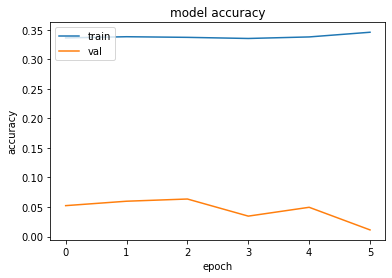

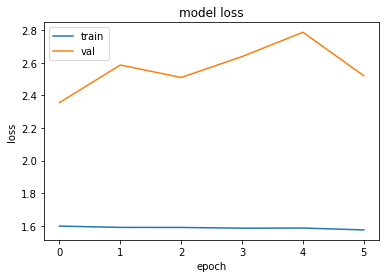

In [ ]:
history1_la = new_model_la1.fit(X1_la_sm, y1_la_df_sm, validation_data = (X_val_la_sm,y_val_la_sm),
               epochs=50,batch_size=64, callbacks =[cp_la1,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history1_la.history['categorical_accuracy'])
plt.plot(history1_la.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1_la.history['loss'])
plt.plot(history1_la.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 2.objective : False Negative (ratio 2:1 train dan val)

In [ ]:
def build_model_la2(hp):
  model_la2 = Sequential()
  model_la2.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_la2.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_la2.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_la2.add(BatchNormalization())
  model_la2.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_la2.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_la2.add(BatchNormalization())
  model_la2.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_la2.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_la2.add(BatchNormalization())
  model_la2.add(Dense(6, activation='softmax'))

  hp_optimizer_la=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_la == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_la', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_la == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_la', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_la2.compile(
      optimizer= hp_optimizer_la,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.FalseNegatives(name='false_negatives'),
               'categorical_accuracy']
  )
  return model_la2

# HyperBand algorithm from keras tuner
tuner_la2 = kt.Hyperband(
    build_model_la2,
    objective= kt.Objective('val_false_negatives', direction="min"),
    max_epochs=50,
    directory='la_dir2',
    project_name='los_angeles2',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_la2.search(X1_la_sm, y1_la_df_sm, epochs=50, validation_data = (X_val_la_sm,y_val_la_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 42s]
val_false_negatives: 1054.0

Best val_false_negatives So Far: 713.0
Total elapsed time: 00h 25m 09s


In [ ]:
best_mlp_hyperparameters_la2 = tuner_la2.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_la2.values

Best Hyper-parameters


{'units1': 160,
 'units2': 352,
 'units3': 448,
 'dropout_1': 0.1,
 'dropout_2': 0.0,
 'dropout_3': 0.0,
 'Optimizer': 'Adam',
 'learning_rate_la': 0.1,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 3,
 'tuner/round': 0}

In [ ]:
best_model_la2 = tuner_la2.get_best_models()[0]
best_model_la2.build(X1_la_sm.shape)
best_model_la2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (8436, 49)               196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (8436, 160)               8000      
                                                                 
 dropout (Dropout)           (8436, 160)               0         
                                                                 
 batch_normalization_1 (Batc  (8436, 160)              640       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (8436, 352)               56672     
                                                                 
 dropout_1 (Dropout)         (8436, 352)               0

In [ ]:
new_model_la2 = Sequential()
new_model_la2.add(tf.keras.Input(shape=(49,)))
new_model_la2.add(BatchNormalization())
new_model_la2.add(Dense(160, activation = LeakyReLU, input_shape=(49,)))
new_model_la2.add(Dropout(0.1))
new_model_la2.add(BatchNormalization())
new_model_la2.add(Dense(352, activation = LeakyReLU))
new_model_la2.add(BatchNormalization())
new_model_la2.add(Dense(448, activation = LeakyReLU))
new_model_la2.add(BatchNormalization())
new_model_la2.add((Dense(6, activation='softmax')))
new_model_la2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 160)               8000      
                                                                 
 dropout_2 (Dropout)         (None, 160)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 160)              640       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 352)               56672     
                                                                 
 batch_normalization_6 (Batc  (None, 352)             

In [ ]:
cp_la2 = ModelCheckpoint('new_model_la2/', save_best_only=True)
opt_la2 = keras.optimizers.Adam(learning_rate=0.1)
new_model_la2.compile(optimizer = opt_la2, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_la2.fit(X1_la_sm, y1_la_df_sm, validation_data = (X_val_la_sm,y_val_la_sm),
               epochs=50,batch_size=64, callbacks =[cp_la2,early_stopping_monitor])

Epoch 1/50
128/132 [============================>.] - ETA: 0s - loss: 3.1802 - categorical_accuracy: 0.2355

132/132 [==============================] - 5s 29ms/step - loss: 3.1399 - categorical_accuracy: 0.2354 - val_loss: 16.0160 - val_categorical_accuracy: 0.0000e+00
Epoch 2/50
132/132 [==============================] - 1s 10ms/step - loss: 1.7331 - categorical_accuracy: 0.2736 - val_loss: 16.5962 - val_categorical_accuracy: 0.3336
Epoch 3/50
131/132 [============================>.] - ETA: 0s - loss: 1.7248 - categorical_accuracy: 0.2810

132/132 [==============================] - 4s 29ms/step - loss: 1.7256 - categorical_accuracy: 0.2807 - val_loss: 4.2141 - val_categorical_accuracy: 0.0000e+00
Epoch 4/50
128/132 [============================>.] - ETA: 0s - loss: 1.7360 - categorical_accuracy: 0.2762

132/132 [==============================] - 9s 66ms/step - loss: 1.7353 - categorical_accuracy: 0.2774 - val_loss: 3.6308 - val_categorical_accuracy: 0.0533
Epoch 5/50
132/132 [==============================] - ETA: 0s - loss: 1.7483 - categorical_accuracy: 0.2667

132/132 [==============================] - 9s 70ms/step - loss: 1.7483 - categorical_accuracy: 0.2667 - val_loss: 2.4159 - val_categorical_accuracy: 0.0561
Epoch 6/50
132/132 [==============================] - 2s 17ms/step - loss: 1.7591 - categorical_accuracy: 0.2752 - val_loss: 2.7444 - val_categorical_accuracy: 0.0252
Epoch 7/50
132/132 [==============================] - ETA: 0s - loss: 1.7745 - categorical_accuracy: 0.2703

132/132 [==============================] - 6s 43ms/step - loss: 1.7745 - categorical_accuracy: 0.2703 - val_loss: 2.0281 - val_categorical_accuracy: 0.1729
Epoch 8/50
132/132 [==============================] - 2s 17ms/step - loss: 1.8360 - categorical_accuracy: 0.2595 - val_loss: 2.2883 - val_categorical_accuracy: 0.2224
Epoch 9/50
130/132 [============================>.] - ETA: 0s - loss: 1.8196 - categorical_accuracy: 0.2602

132/132 [==============================] - 5s 42ms/step - loss: 1.8187 - categorical_accuracy: 0.2597 - val_loss: 1.8641 - val_categorical_accuracy: 0.2654
Epoch 10/50
132/132 [==============================] - 1s 10ms/step - loss: 1.8617 - categorical_accuracy: 0.2544 - val_loss: 2.5723 - val_categorical_accuracy: 0.2776
Epoch 11/50
132/132 [==============================] - 1s 10ms/step - loss: 1.8445 - categorical_accuracy: 0.2709 - val_loss: 3.2311 - val_categorical_accuracy: 0.0037
Epoch 12/50
132/132 [==============================] - 1s 11ms/step - loss: 1.8308 - categorical_accuracy: 0.2629 - val_loss: 2.1940 - val_categorical_accuracy: 0.2168
Epoch 13/50
132/132 [==============================] - 1s 11ms/step - loss: 1.8522 - categorical_accuracy: 0.2646 - val_loss: 2.6442 - val_categorical_accuracy: 0.1589
Epoch 14/50
132/132 [==============================] - 1s 11ms/step - loss: 1.8923 - categorical_accuracy: 0.2675 - val_loss: 2.9012 - val_categorical_accuracy: 0.1860


In [ ]:
test_predictions_la2 = new_model_la2.predict(X_test_la)
test_predictions_la2

23/23 [==============================] - 0s 4ms/step


array([[0.38118315, 0.11662691, 0.3775596 , 0.10223342, 0.01559888,
        0.0067982 ],
       [0.2977368 , 0.05528229, 0.59601676, 0.02759897, 0.00202273,
        0.0213425 ],
       [0.21589148, 0.06858759, 0.6786091 , 0.02089807, 0.0019286 ,
        0.0140852 ],
       ...,
       [0.2927106 , 0.18089063, 0.4653318 , 0.03683181, 0.01490003,
        0.00933515],
       [0.20738009, 0.05175825, 0.6952347 , 0.01823887, 0.00124884,
        0.02613927],
       [0.1114632 , 0.2971479 , 0.5697338 , 0.00806435, 0.01045321,
        0.00313756]], dtype=float32)

In [ ]:
classes_la2 = np.argmax(test_predictions_la2, axis=-1)
classes_la2

array([0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 5, 2, 5, 5, 0, 5, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 5, 0, 5, 0, 5, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       5, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0,
       2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 0, 0, 2, 2, 2, 0,
       0, 2, 0, 3, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0,
       0, 3, 3, 0, 2, 0, 3, 3, 3, 3, 0, 0, 3, 2, 2, 3, 0, 0, 3, 3, 3, 0,
       0, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 3, 3, 3, 0, 4, 1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 0, 0, 3, 3, 3, 3, 3, 3, 0, 3,

In [ ]:
classes_la2 =pd.DataFrame(classes_la2, columns=['Test Predictions']) 
classes_la2

Test Predictions
0                   0
1                   2
2                   2
3                   0
4                   0
..                ...
726                 0
727                 5
728                 2
729                 2
730                 2

[731 rows x 1 columns]

In [ ]:
classes_la2 = classes_la2.values.ravel()

In [ ]:
result_la2 = pd.DataFrame({'Test Predictions':classes_la2, 'Actuals':y_test_la})
result_la2[0:31]

Test Predictions  Actuals
0                  0        3
1                  2        3
2                  2        3
3                  0        3
4                  0        3
5                  0        3
6                  2        3
7                  2        3
8                  2        3
9                  2        3
10                 0        2
11                 5        2
12                 2        2
13                 5        2
14                 5        2
15                 0        2
16                 5        2
17                 2        2
18                 2        2
19                 0        2
20                 2        2
21                 2        2
22                 2        2
23                 2        2
24                 2        2
25                 2        2
26                 2        2
27                 0        2
28                 0        2
29                 0        2
30                 5        2

######model 2 evaluation

In [ ]:
print(classification_report(y_test_la, classes_la2, labels=np.unique(y_test_la)))

              precision    recall  f1-score   support

           0       0.67      0.30      0.41       559
           1       0.27      0.03      0.05       105
           2       0.17      0.49      0.25        57
           3       0.00      0.00      0.00        10

   micro avg       0.28      0.27      0.27       731
   macro avg       0.28      0.20      0.18       731
weighted avg       0.57      0.27      0.34       731



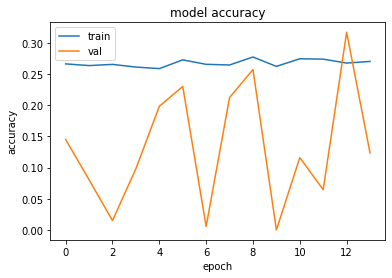

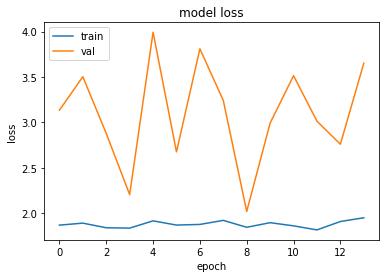

In [ ]:
history2_la = new_model_la2.fit(X1_la_sm, y1_la_df_sm, validation_data = (X_val_la_sm,y_val_la_sm),
               epochs=50,batch_size=64, callbacks =[cp_la2,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history2_la.history['categorical_accuracy'])
plt.plot(history2_la.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2_la.history['loss'])
plt.plot(history2_la.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####comparing the models

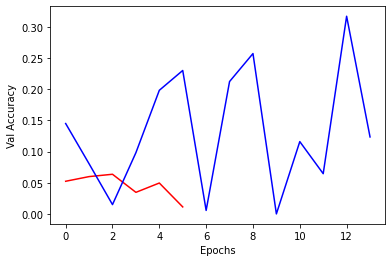

In [ ]:
plt.plot(history1_la.history['val_categorical_accuracy'], 'r', history2_la.history['val_categorical_accuracy'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

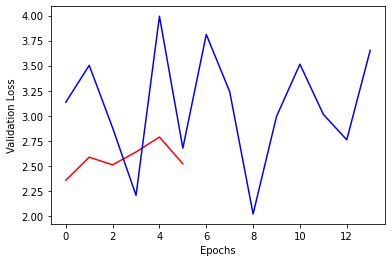

In [ ]:
plt.plot(history1_la.history['val_loss'], 'r', history2_la.history['val_loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

##### 3.objective : True Positive (ratio 1:1) epoch = 100

In [ ]:
def build_model_la3(hp):
  model_la3 = Sequential()
  model_la3.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  model_la3.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_la3.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_la3.add(BatchNormalization())
  model_la3.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_la3.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_la3.add(BatchNormalization())
  model_la3.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_la3.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_la3.add(BatchNormalization())
  model_la3.add(Dense(6, activation='softmax'))

  hp_optimizer_la=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_la == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_la', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_la == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_la', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_la3.compile(
      optimizer= hp_optimizer_la,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.TruePositives(name='true_positives'),
               'categorical_accuracy']
  )
  return model_la3

# HyperBand algorithm from keras tuner
tuner_la3 = kt.Hyperband(
    build_model_la3,
    objective= kt.Objective('val_true_positives', direction="max"),
    max_epochs=100,
    directory='la_dir3',
    project_name='los_angeles3',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=10)
tuner_la3.search(X1_la_sm, y1_la_df_sm, epochs=100, validation_data = (X_val_la_sm,y_val_la_sm),
             callbacks=[early_stopping_monitor])

Trial 254 Complete [00h 00m 35s]
val_true_positives: 28.0

Best val_true_positives So Far: 371.0
Total elapsed time: 01h 46m 14s


In [ ]:
best_mlp_hyperparameters_la3 = tuner_la3.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_la3.values

Best Hyper-parameters


{'units1': 288,
 'units2': 64,
 'units3': 288,
 'dropout_1': 0.1,
 'dropout_2': 0.2,
 'dropout_3': 0.2,
 'Optimizer': 'Adam',
 'learning_rate_la': 0.001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [ ]:
best_model_la3 = tuner_la3.get_best_models()[0]
best_model_la3.build(X1_la_sm.shape)
best_model_la3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (14466, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (14466, 288)              14400     
                                                                 
 dropout (Dropout)           (14466, 288)              0         
                                                                 
 batch_normalization_1 (Batc  (14466, 288)             1152      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (14466, 64)               18496     
                                                                 
 dropout_1 (Dropout)         (14466, 64)               0

In [ ]:
new_model_la3 = Sequential()
new_model_la3.add(tf.keras.Input(shape=(49,)))
new_model_la3.add(BatchNormalization())
new_model_la3.add(Dense(288, activation = LeakyReLU))
new_model_la3.add(Dropout(0.1))
new_model_la3.add(BatchNormalization())
new_model_la3.add(Dense(64, activation = LeakyReLU))
new_model_la3.add(Dropout(0.2))
new_model_la3.add(BatchNormalization())
new_model_la3.add(Dense(288, activation = LeakyReLU))
new_model_la3.add(Dropout(0.2))
new_model_la3.add(BatchNormalization())
new_model_la3.add((Dense(6, activation='softmax')))
new_model_la3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (None, 49)               196       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 288)               14400     
                                                                 
 dropout_3 (Dropout)         (None, 288)               0         
                                                                 
 batch_normalization_9 (Batc  (None, 288)              1152      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 64)                18496     
                                                                 
 dropout_4 (Dropout)         (None, 64)               

In [ ]:
cp_la3 = ModelCheckpoint('new_model_la3/', save_best_only=True)
opt_la3 = keras.optimizers.Adam(learning_rate=0.001)
new_model_la3.compile(optimizer = opt_la3, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)

new_model_la3.fit(X1_la_sm, y1_la_df_sm, validation_data = (X_val_la_sm,y_val_la_sm),
               epochs=100,batch_size=64, callbacks =[cp_la3,early_stopping_monitor])

Epoch 1/100
225/227 [============================>.] - ETA: 0s - loss: 1.9285 - categorical_accuracy: 0.2340

227/227 [==============================] - 5s 18ms/step - loss: 1.9286 - categorical_accuracy: 0.2341 - val_loss: 4.7171 - val_categorical_accuracy: 0.2479
Epoch 2/100
219/227 [===========================>..] - ETA: 0s - loss: 1.7936 - categorical_accuracy: 0.2637

227/227 [==============================] - 4s 18ms/step - loss: 1.7935 - categorical_accuracy: 0.2630 - val_loss: 3.6989 - val_categorical_accuracy: 0.1239
Epoch 3/100
221/227 [============================>.] - ETA: 0s - loss: 1.7339 - categorical_accuracy: 0.2794

227/227 [==============================] - 7s 29ms/step - loss: 1.7336 - categorical_accuracy: 0.2804 - val_loss: 2.4862 - val_categorical_accuracy: 0.0357
Epoch 4/100
225/227 [============================>.] - ETA: 0s - loss: 1.7117 - categorical_accuracy: 0.2879

227/227 [==============================] - 10s 44ms/step - loss: 1.7115 - categorical_accuracy: 0.2878 - val_loss: 2.4008 - val_categorical_accuracy: 0.1036
Epoch 5/100
227/227 [==============================] - 2s 11ms/step - loss: 1.6771 - categorical_accuracy: 0.3001 - val_loss: 2.4324 - val_categorical_accuracy: 0.0644
Epoch 6/100
227/227 [==============================] - 3s 13ms/step - loss: 1.6593 - categorical_accuracy: 0.3079 - val_loss: 2.4286 - val_categorical_accuracy: 0.0917
Epoch 7/100
221/227 [============================>.] - ETA: 0s - loss: 1.6545 - categorical_accuracy: 0.3119

227/227 [==============================] - 6s 25ms/step - loss: 1.6548 - categorical_accuracy: 0.3112 - val_loss: 2.2301 - val_categorical_accuracy: 0.0938
Epoch 8/100
227/227 [==============================] - 2s 7ms/step - loss: 1.6428 - categorical_accuracy: 0.3187 - val_loss: 2.2340 - val_categorical_accuracy: 0.0959
Epoch 9/100
227/227 [==============================] - 2s 7ms/step - loss: 1.6302 - categorical_accuracy: 0.3260 - val_loss: 2.2430 - val_categorical_accuracy: 0.0903
Epoch 10/100
227/227 [==============================] - 2s 7ms/step - loss: 1.6274 - categorical_accuracy: 0.3214 - val_loss: 2.2697 - val_categorical_accuracy: 0.0847
Epoch 11/100
227/227 [==============================] - 2s 7ms/step - loss: 1.6157 - categorical_accuracy: 0.3328 - val_loss: 2.3721 - val_categorical_accuracy: 0.1015
Epoch 12/100
227/227 [==============================] - 2s 7ms/step - loss: 1.6188 - categorical_accuracy: 0.3310 - val_loss: 2.4062 - val_categorical_accuracy: 0.0959
Epoch 

In [ ]:
test_predictions_la3 = new_model_la3.predict(X_test_la)
test_predictions_la3

23/23 [==============================] - 0s 2ms/step


array([[0.232663  , 0.23709746, 0.19827043, 0.08613386, 0.10306675,
        0.14276855],
       [0.14952654, 0.14481215, 0.2391889 , 0.04644221, 0.27580506,
        0.14422517],
       [0.11968671, 0.12438234, 0.5517433 , 0.061608  , 0.02260866,
        0.11997101],
       ...,
       [0.2523362 , 0.345457  , 0.13511425, 0.06968402, 0.03348248,
        0.16392606],
       [0.17144534, 0.22769074, 0.320001  , 0.10739829, 0.01663375,
        0.15683095],
       [0.43721873, 0.3575084 , 0.07866155, 0.0020165 , 0.00629812,
        0.11829657]], dtype=float32)

In [ ]:
classes_la3 = np.argmax(test_predictions_la3, axis=-1)
classes_la3

array([1, 4, 2, 2, 0, 4, 1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 1, 0, 5, 0, 1,
       1, 2, 2, 2, 2, 2, 0, 5, 0, 1, 2, 0, 2, 0, 1, 2, 1, 1, 0, 2, 1, 0,
       2, 1, 1, 1, 2, 2, 2, 3, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 0, 2, 0, 1,
       1, 0, 0, 0, 5, 5, 1, 1, 0, 0, 5, 0, 1, 0, 1, 1, 1, 5, 0, 5, 1, 1,
       0, 0, 5, 5, 0, 0, 0, 0, 0, 5, 0, 5, 0, 5, 0, 3, 3, 0, 0, 5, 0, 0,
       1, 0, 0, 5, 5, 0, 0, 0, 3, 0, 4, 4, 4, 0, 5, 3, 5, 5, 3, 3, 5, 0,
       5, 0, 5, 2, 0, 0, 5, 0, 5, 0, 0, 4, 0, 5, 1, 0, 0, 3, 1, 0, 0, 0,
       0, 0, 3, 0, 0, 5, 5, 5, 5, 3, 0, 0, 3, 0, 0, 5, 5, 0, 0, 3, 3, 0,
       0, 5, 5, 5, 3, 3, 3, 3, 0, 0, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 5,
       3, 3, 3, 3, 3, 3, 3, 5, 2, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       5, 3, 2, 3, 5, 5, 0, 1, 2, 3, 4, 3, 4, 4, 4, 3, 3, 3, 4, 3, 3, 3,
       3, 3, 5, 3, 4, 3, 5, 5, 5, 3, 2, 4, 3, 3, 3,

In [ ]:
classes_la3 =pd.DataFrame(classes_la3, columns=['Test Predictions']) 
classes_la3

Test Predictions
0                   1
1                   4
2                   2
3                   2
4                   0
..                ...
726                 2
727                 0
728                 1
729                 2
730                 0

[731 rows x 1 columns]

In [ ]:
classes_la3 = classes_la3.values.ravel()

In [ ]:
result_la3 = pd.DataFrame({'Test Predictions':classes_la3, 'Actuals':y_test_la})
result_la3[0:31]

Test Predictions  Actuals
0                  1        3
1                  4        3
2                  2        3
3                  2        3
4                  0        3
5                  4        3
6                  1        3
7                  2        3
8                  2        3
9                  1        3
10                 2        2
11                 2        2
12                 2        2
13                 0        2
14                 0        2
15                 2        2
16                 2        2
17                 1        2
18                 0        2
19                 5        2
20                 0        2
21                 1        2
22                 1        2
23                 2        2
24                 2        2
25                 2        2
26                 2        2
27                 2        2
28                 0        2
29                 5        2
30                 0        2

######model 3 evaluation

In [ ]:
print(classification_report(y_test_la, classes_la3, labels=np.unique(y_test_la)))

              precision    recall  f1-score   support

           0       0.79      0.21      0.33       559
           1       0.36      0.37      0.37       105
           2       0.22      0.39      0.28        57
           3       0.00      0.00      0.00        10

   micro avg       0.31      0.24      0.27       731
   macro avg       0.34      0.24      0.24       731
weighted avg       0.67      0.24      0.33       731



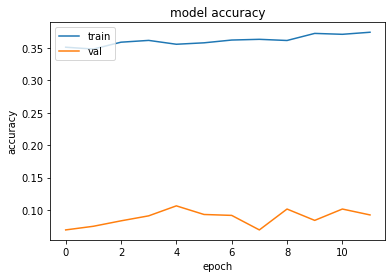

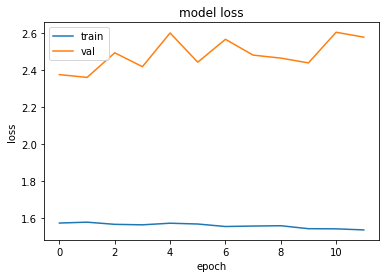

In [ ]:
history3_la = new_model_la3.fit(X1_la_sm, y1_la_df_sm, validation_data = (X_val_la_sm,y_val_la_sm),
               epochs=50,batch_size=64, callbacks =[cp_la3,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history3_la.history['categorical_accuracy'])
plt.plot(history3_la.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3_la.history['loss'])
plt.plot(history3_la.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### 4.objective : False Negative (ratio 1:1)

In [ ]:
def build_model_la4(hp):
  model_la4 = Sequential()
  model_la4.add(BatchNormalization())
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  hp_units4 = hp.Int('units4', min_value=32, max_value=512, step=32)
  model_la4.add(Dense(units=hp_units1, activation= LeakyReLU))
  model_la4.add(Dropout(hp.Choice('dropout_1', values=[0.0, 0.1, 0.2, 0.3])))
  model_la4.add(BatchNormalization())
  model_la4.add(Dense(units=hp_units2, activation= LeakyReLU))
  model_la4.add(Dropout(hp.Choice('dropout_2', values=[0.0, 0.1, 0.2, 0.3])))
  model_la4.add(BatchNormalization())
  model_la4.add(Dense(units=hp_units3, activation= LeakyReLU))
  model_la4.add(Dropout(hp.Choice('dropout_3', values=[0.0, 0.1, 0.2, 0.3])))
  model_la4.add(BatchNormalization())
  model_la4.add(Dense(units=hp_units4, activation= LeakyReLU))
  model_la4.add(Dropout(hp.Choice('dropout_4', values=[0.0, 0.1, 0.2, 0.3])))
  model_la4.add(BatchNormalization())
  model_la4.add(Dense(6, activation='softmax'))

  hp_optimizer_la=hp.Choice('Optimizer', values=['Adam', 'SGD'])
  if hp_optimizer_la == 'Adam':
    hp_learning_rate = hp.Choice('learning_rate_la', values=[1e-1, 1e-2, 1e-3])
  elif hp_optimizer_la == 'SGD':
    hp_learning_rate = hp.Choice('learning_rate_la', values=[1e-1, 1e-2, 1e-3])
    nesterov=True
    momentum=0.9

  model_la4.compile(
      optimizer= hp_optimizer_la,
      loss='categorical_crossentropy',
      metrics=[keras.metrics.FalseNegatives(name='false_negatives'),
               'categorical_accuracy']
  )
  return model_la4

# HyperBand algorithm from keras tuner
tuner_la4 = kt.Hyperband(
    build_model_la4,
    objective= kt.Objective('val_false_negatives', direction="min"),
    max_epochs=50,
    directory='la_dir4',
    project_name='los_angeles4',
    overwrite= True
)
early_stopping_monitor = EarlyStopping(patience=5)
tuner_la4.search(X1_la_sm, y1_la_df_sm, epochs=50, validation_data = (X_val_la_sm,y_val_la_sm),
             callbacks=[early_stopping_monitor])

Trial 90 Complete [00h 00m 56s]
val_false_negatives: 1418.0

Best val_false_negatives So Far: 951.0
Total elapsed time: 00h 43m 09s


In [ ]:
best_mlp_hyperparameters_la4 = tuner_la4.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
best_mlp_hyperparameters_la4.values

Best Hyper-parameters


{'units1': 192,
 'units2': 64,
 'units3': 384,
 'units4': 448,
 'dropout_1': 0.1,
 'dropout_2': 0.2,
 'dropout_3': 0.2,
 'dropout_4': 0.0,
 'Optimizer': 'SGD',
 'learning_rate_la': 0.01,
 'tuner/epochs': 6,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [ ]:
best_model_la4 = tuner_la4.get_best_models()[0]
best_model_la4.build(X1_la_sm.shape)
best_model_la4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (14466, 49)              196       
 ormalization)                                                   
                                                                 
 dense (Dense)               (14466, 192)              9600      
                                                                 
 dropout (Dropout)           (14466, 192)              0         
                                                                 
 batch_normalization_1 (Batc  (14466, 192)             768       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (14466, 64)               12352     
                                                                 
 dropout_1 (Dropout)         (14466, 64)               0

In [ ]:
new_model_la4 = Sequential()
new_model_la4.add(tf.keras.Input(shape=(49,)))
new_model_la4.add(BatchNormalization())
new_model_la4.add(Dense(192, activation = LeakyReLU, input_shape=(49,)))
new_model_la4.add(Dropout(0.1))
new_model_la4.add(BatchNormalization())
new_model_la4.add(Dense(64, activation = LeakyReLU))
new_model_la4.add(Dropout(0.2))
new_model_la4.add(BatchNormalization())
new_model_la4.add(Dense(384, activation = LeakyReLU))
new_model_la4.add(Dropout(0.2))
new_model_la4.add(BatchNormalization())
new_model_la4.add(Dense(448, activation = LeakyReLU))
new_model_la4.add(BatchNormalization())
new_model_la4.add((Dense(6, activation='softmax')))
new_model_la4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_12 (Bat  (None, 49)               196       
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 192)               9600      
                                                                 
 dropout_6 (Dropout)         (None, 192)               0         
                                                                 
 batch_normalization_13 (Bat  (None, 192)              768       
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 64)                12352     
                                                                 
 dropout_7 (Dropout)         (None, 64)               

In [ ]:
cp_la4 = ModelCheckpoint('new_model_la4/', save_best_only=True)
opt_la4 = keras.optimizers.SGD(learning_rate=0.01)
new_model_la4.compile(optimizer = opt_la4, loss ='categorical_crossentropy', metrics =['categorical_accuracy'])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_la4.fit(X1_la_sm, y1_la_df_sm, validation_data = (X_val_la_sm,y_val_la_sm),
               epochs=50,batch_size=64, callbacks =[cp_la4,early_stopping_monitor])

Epoch 1/50
225/227 [============================>.] - ETA: 0s - loss: 1.9496 - categorical_accuracy: 0.2331

227/227 [==============================] - 7s 23ms/step - loss: 1.9487 - categorical_accuracy: 0.2332 - val_loss: 11.9510 - val_categorical_accuracy: 0.2773
Epoch 2/50
225/227 [============================>.] - ETA: 0s - loss: 1.8328 - categorical_accuracy: 0.2460

227/227 [==============================] - 5s 24ms/step - loss: 1.8323 - categorical_accuracy: 0.2461 - val_loss: 9.1275 - val_categorical_accuracy: 0.0000e+00
Epoch 3/50
226/227 [============================>.] - ETA: 0s - loss: 1.7691 - categorical_accuracy: 0.2617

227/227 [==============================] - 8s 37ms/step - loss: 1.7691 - categorical_accuracy: 0.2616 - val_loss: 3.4119 - val_categorical_accuracy: 0.0252
Epoch 4/50
225/227 [============================>.] - ETA: 0s - loss: 1.7430 - categorical_accuracy: 0.2706

227/227 [==============================] - 10s 44ms/step - loss: 1.7430 - categorical_accuracy: 0.2706 - val_loss: 2.2967 - val_categorical_accuracy: 0.1169
Epoch 5/50
227/227 [==============================] - 3s 15ms/step - loss: 1.7268 - categorical_accuracy: 0.2749 - val_loss: 2.4528 - val_categorical_accuracy: 0.0595
Epoch 6/50
225/227 [============================>.] - ETA: 0s - loss: 1.7146 - categorical_accuracy: 0.2835

227/227 [==============================] - 7s 32ms/step - loss: 1.7148 - categorical_accuracy: 0.2837 - val_loss: 2.1621 - val_categorical_accuracy: 0.1022
Epoch 7/50
227/227 [==============================] - 2s 10ms/step - loss: 1.6954 - categorical_accuracy: 0.2883 - val_loss: 2.3926 - val_categorical_accuracy: 0.1849
Epoch 8/50
227/227 [==============================] - 2s 11ms/step - loss: 1.7032 - categorical_accuracy: 0.2865 - val_loss: 3.7105 - val_categorical_accuracy: 0.0252
Epoch 9/50
227/227 [==============================] - 2s 10ms/step - loss: 1.7045 - categorical_accuracy: 0.2898 - val_loss: 2.3305 - val_categorical_accuracy: 0.0812
Epoch 10/50
227/227 [==============================] - 2s 11ms/step - loss: 1.7037 - categorical_accuracy: 0.2830 - val_loss: 2.3648 - val_categorical_accuracy: 0.1183
Epoch 11/50
227/227 [==============================] - 2s 10ms/step - loss: 1.6951 - categorical_accuracy: 0.2930 - val_loss: 2.1846 - val_categorical_accuracy: 0.0994


In [ ]:
test_predictions_la4 = new_model_la4.predict(X_test_la)
test_predictions_la4

23/23 [==============================] - 0s 4ms/step


array([[0.10843201, 0.29793784, 0.16506435, 0.09793839, 0.24784772,
        0.08277978],
       [0.12677316, 0.23046407, 0.27464983, 0.08399998, 0.18746085,
        0.09665219],
       [0.1555971 , 0.25766018, 0.30476576, 0.09192806, 0.09809542,
        0.09195343],
       ...,
       [0.11820717, 0.27150387, 0.19605628, 0.11956213, 0.21626256,
        0.07840806],
       [0.12745148, 0.2335576 , 0.21927135, 0.15342815, 0.1369823 ,
        0.12930915],
       [0.11239886, 0.27625787, 0.13351925, 0.04661782, 0.31246328,
        0.11874291]], dtype=float32)

In [ ]:
classes_la4 = np.argmax(test_predictions_la4, axis=-1)
classes_la4

array([1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 5, 1, 1, 1, 5, 2, 1, 1, 2, 1, 1, 1, 2, 1, 4,
       2, 1, 1, 4, 3, 2, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 2, 2, 1, 0, 1, 1, 4, 4, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 5, 5, 1, 1, 4, 0, 0, 0, 1, 4, 4, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 5, 5, 5, 0, 0, 3, 5, 4, 4, 4, 0, 5, 3, 5, 5, 3, 5, 5, 0,
       5, 0, 5, 2, 1, 0, 5, 0, 1, 0, 4, 0, 0, 5, 1, 0, 0, 3, 0, 0, 5, 0,
       0, 0, 3, 4, 0, 0, 5, 5, 3, 3, 0, 0, 3, 0, 5, 5, 3, 3, 0, 3, 3, 5,
       3, 5, 5, 5, 3, 3, 3, 3, 3, 5, 3, 3, 3, 5, 3, 3, 2, 3, 3, 2, 3, 3,
       3, 3, 3, 3, 3, 5, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 5,
       3, 3, 3, 3, 3, 3, 5, 5, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3,
       3, 3, 2, 3, 5, 5, 0, 1, 1, 4, 4, 3, 4, 4, 3, 3, 3, 0, 4, 4, 3, 3,
       5, 3, 5, 3, 4, 0, 4, 5, 5, 3, 4, 5, 3, 0, 4,

In [ ]:
classes_la4 =pd.DataFrame(classes_la4, columns=['Test Predictions']) 
classes_la4

Test Predictions
0                   1
1                   2
2                   2
3                   1
4                   1
..                ...
726                 1
727                 1
728                 1
729                 1
730                 4

[731 rows x 1 columns]

In [ ]:
classes_la4 = classes_la4.values.ravel()
#y_test_la = y_test_la.values.ravel()

In [ ]:
result_la4 = pd.DataFrame({'Test Predictions':classes_la4, 'Actuals':y_test_la})
result_la4[0:31]

Test Predictions  Actuals
0                  1        3
1                  2        3
2                  2        3
3                  1        3
4                  1        3
5                  1        3
6                  1        3
7                  1        3
8                  1        3
9                  1        3
10                 1        2
11                 1        2
12                 1        2
13                 1        2
14                 1        2
15                 2        2
16                 1        2
17                 1        2
18                 1        2
19                 1        2
20                 1        2
21                 1        2
22                 1        2
23                 1        2
24                 1        2
25                 1        2
26                 1        2
27                 1        2
28                 0        2
29                 5        2
30                 1        2

######model 4 evaluation

In [ ]:
print(classification_report(y_test_la, classes_la4, labels=np.unique(y_test_la)))

              precision    recall  f1-score   support

           0       0.90      0.15      0.25       559
           1       0.28      0.55      0.37       105
           2       0.12      0.11      0.11        57
           3       0.00      0.00      0.00        10

   micro avg       0.26      0.20      0.23       731
   macro avg       0.33      0.20      0.18       731
weighted avg       0.74      0.20      0.25       731



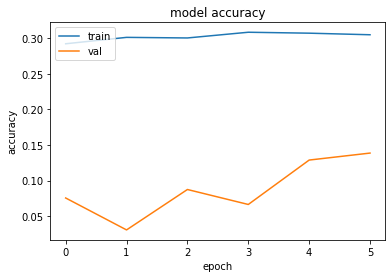

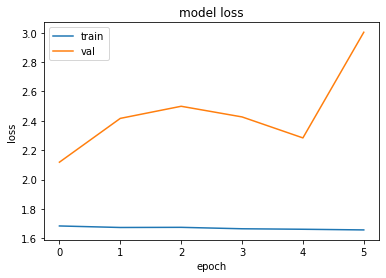

In [ ]:
history4_la = new_model_la4.fit(X1_la_sm, y1_la_df_sm, validation_data = (X_val_la_sm,y_val_la_sm),
               epochs=50,batch_size=64, callbacks =[cp_la4,early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history4_la.history['categorical_accuracy'])
plt.plot(history4_la.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history4_la.history['loss'])
plt.plot(history4_la.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###MLP model with weather and soil data (without date variable) REGRESSION

####preprocessing data

In [ ]:
score_la = train_la['score']
score_val_la = val_la['score']
score_test_la = test_la['score']

In [ ]:
score_arr_la = score_la.copy()
score_val_arr_la = score_val_la.copy()
score_test_arr_la = score_test_la.copy()

In [ ]:
score_arr_la = score_arr_la.to_numpy()
score_val_arr_la = score_val_arr_la.to_numpy()
score_test_arr_la = score_test_arr_la.to_numpy()

In [ ]:
score_arr_la

array([1.    , 1.    , 1.    , ..., 4.5919, 4.5919, 4.5919])

In [ ]:
score_arr_la =pd.DataFrame(score_arr_la, columns=['Score']) 
score_arr_la

Score
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
...     ...
6205    5.0
6206    5.0
6207    5.0
6208    5.0
6209    5.0

[6210 rows x 1 columns]

In [ ]:
score_val_arr_la =pd.DataFrame(score_val_arr_la, columns=['Score']) 
score_val_arr_la

Score
0      5.0
1      5.0
2      5.0
3      5.0
4      4.0
..     ...
725    3.0
726    3.0
727    3.0
728    3.0
729    3.0

[730 rows x 1 columns]

In [ ]:
score_test_arr_la =pd.DataFrame(score_test_arr_la, columns=['Score']) 
score_test_arr_la

Score
0      3.0
1      3.0
2      3.0
3      3.0
4      3.0
..     ...
726    2.0
727    2.0
728    2.0
729    2.0
730    2.0

[731 rows x 1 columns]

In [ ]:
los_angeles_train = train_la.copy()
los_angeles_val = val_la.copy()
los_angeles_test = test_la.copy()

In [ ]:
X1_la = los_angeles_train.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_la_val = los_angeles_val.drop(columns=['fips','date','score','tahun','bulan','tanggal'])
X_la_test = los_angeles_test.drop(columns=['fips','date','score','tahun','bulan','tanggal'])

In [ ]:
X1_la, y1_la = X1_la, score_arr_la
X_val_la, y_val_la = X_la_val, score_val_arr_la
X_test_la, y_test_la = X_la_test, score_test_arr_la
X1_la.shape, y1_la.shape, X_val_la.shape, y_val_la.shape, X_test_la.shape, y_test_la.shape

((6210, 49), (6210, 1), (730, 49), (730, 1), (731, 49), (731, 1))

####build the model

In [ ]:
new_model_reg_la1 = Sequential()
new_model_reg_la1.add(tf.keras.Input(shape=(49,)))
new_model_reg_la1.add(BatchNormalization())
new_model_reg_la1.add(Dense(128, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_la1.add(BatchNormalization())
new_model_reg_la1.add(Dense(64, activation = "elu", kernel_initializer="he_normal"))
new_model_reg_la1.add(BatchNormalization())
new_model_reg_la1.add((Dense(1, activation='linear')))
new_model_reg_la1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_17 (Bat  (None, 49)               196       
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 128)               6400      
                                                                 
 batch_normalization_18 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_19 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                      

In [ ]:
opt_reg_la1 = keras.optimizers.Adam(learning_rate=0.001)
new_model_reg_la1.compile(optimizer = opt_reg_la1, loss =MeanSquaredError(), metrics =[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

new_model_reg_la1.fit(X1_la, y1_la, validation_data = (X_val_la,y_val_la),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor])

Epoch 1/50
98/98 [==============================] - 2s 6ms/step - loss: 5.1526 - root_mean_squared_error: 2.2699 - val_loss: 336.1643 - val_root_mean_squared_error: 18.3348
Epoch 2/50
98/98 [==============================] - 0s 4ms/step - loss: 3.5584 - root_mean_squared_error: 1.8864 - val_loss: 13.1400 - val_root_mean_squared_error: 3.6249
Epoch 3/50
98/98 [==============================] - 0s 4ms/step - loss: 3.2990 - root_mean_squared_error: 1.8163 - val_loss: 5.4772 - val_root_mean_squared_error: 2.3404
Epoch 4/50
98/98 [==============================] - 0s 4ms/step - loss: 3.2707 - root_mean_squared_error: 1.8085 - val_loss: 4.2690 - val_root_mean_squared_error: 2.0662
Epoch 5/50
98/98 [==============================] - 0s 4ms/step - loss: 3.2262 - root_mean_squared_error: 1.7962 - val_loss: 4.3338 - val_root_mean_squared_error: 2.0818
Epoch 6/50
98/98 [==============================] - 0s 5ms/step - loss: 3.2413 - root_mean_squared_error: 1.8004 - val_loss: 7.1640 - val_root_mea

In [ ]:
test_predictions_reg_la1 = new_model_reg_la1.predict(X_test_la).flatten()
test_predictions_reg_la1

23/23 [==============================] - 0s 2ms/step


array([ 1.539914  ,  1.3953844 ,  1.1053743 ,  1.0443836 ,  0.4747761 ,
        1.2398032 ,  1.0177495 ,  0.72224325,  1.7265342 ,  1.1865517 ,
        0.9063844 ,  0.90554565,  0.37859374,  0.09248336, -0.22955959,
       -0.1660053 , -0.7034537 ,  1.2686695 ,  0.48749006,  1.4592481 ,
        0.65262157,  1.1176828 ,  0.8302713 ,  0.8914284 ,  0.822238  ,
        1.0892557 ,  1.4477441 ,  1.4286174 ,  1.3690983 ,  2.00511   ,
        0.16932781,  1.0613936 ,  0.22312982,  0.48516113,  0.807396  ,
        0.7646945 ,  0.6721147 ,  0.5547614 ,  0.65827024,  0.6309579 ,
        0.84202224,  0.5361707 ,  0.5200123 ,  0.34484535,  0.21962912,
        0.2686761 ,  0.37827235,  1.1055554 ,  0.7957118 ,  1.2698848 ,
        0.89366096,  1.0014768 ,  0.9166698 ,  0.4745828 ,  0.7235885 ,
        0.8303332 ,  1.00515   ,  0.54249924,  1.0286949 ,  1.0501213 ,
       -0.21304266,  0.68517154,  0.8702531 ,  0.72512615, -0.5263502 ,
        0.92570764,  1.1291418 ,  0.80313355,  1.3949789 ,  0.73

In [ ]:
test_predictions_reg_la1 =pd.DataFrame(test_predictions_reg_la1, columns=['Test Predictions']) 
test_predictions_reg_la1

Test Predictions
0            1.539914
1            1.395384
2            1.105374
3            1.044384
4            0.474776
..                ...
726          1.025659
727          0.043074
728          0.860664
729          0.836439
730          0.968992

[731 rows x 1 columns]

In [ ]:
test_predictions_reg_la1 = test_predictions_reg_la1.values.ravel()
y_test_la = y_test_la.values.ravel()

In [ ]:
test_results_reg_la1 = pd.DataFrame(data={'predictions':test_predictions_reg_la1, 'actuals':y_test_la})
test_results_reg_la1

predictions  actuals
0       1.539914      3.0
1       1.395384      3.0
2       1.105374      3.0
3       1.044384      3.0
4       0.474776      3.0
..           ...      ...
726     1.025659      2.0
727     0.043074      2.0
728     0.860664      2.0
729     0.836439      2.0
730     0.968992      2.0

[731 rows x 2 columns]

In [ ]:
test_results_reg_la1[500:550]

predictions  actuals
500     0.733373      0.0
501     0.742805      0.0
502     1.337676      0.0
503     1.002371      0.0
504     1.075056      0.0
505     1.079039      0.0
506     0.575893      0.0
507     1.405004      0.0
508     1.723183      0.0
509     1.202061      0.0
510     0.981501      0.0
511     1.274678      0.0
512     1.553276      0.0
513     1.464828      0.0
514     1.431085      0.0
515     1.251576      0.0
516     0.861372      0.0
517     1.343133      0.0
518     1.517481      0.0
519     1.698181      0.0
520     1.456344      0.0
521     1.852361      0.0
522     1.188900      0.0
523     2.023614      0.0
524     2.135145      0.0
525     1.625459      0.0
526     1.640284      0.0
527     1.810766      0.0
528     1.851861      0.0
529     2.083916      0.0
530     1.201217      0.0
531     1.640675      0.0
532     1.769948      0.0
533     1.024225      0.0
534     1.355899      0.0
535     1.370107      0.0
536     1.186841      0.0
537     1.382166      0.0
538     1.222528      0.0
539     1.494777      0.0
540     1.639878      0.0
541     1.721639      0.0
542     1.424196      0.0
543     1.638520      0.0
544     1.701339      0.0
545     1.558370      0.0
546     1.581861      0.0
547     1.550817      0.0
548     1.301905      0.0
549     1.815476      0.0

####model evaluation

In [ ]:
new_model_reg_la1.evaluate(X1_la,y1_la)

195/195 [==============================] - 0s 2ms/step - loss: 3.0399 - root_mean_squared_error: 1.7435


[3.0398993492126465, 1.7435307502746582]

In [ ]:
new_model_reg_la1.evaluate(X_test_la,y_test_la)

23/23 [==============================] - 0s 2ms/step - loss: 2.2710 - root_mean_squared_error: 1.5070


[2.271022319793701, 1.5069911479949951]

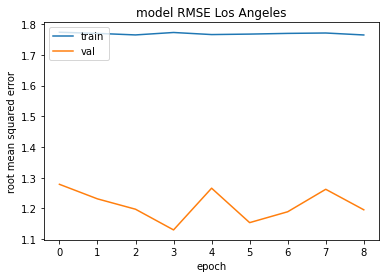

In [ ]:
history_reg_la1 = new_model_reg_la1.fit(X1_la, y1_la, validation_data = (X_val_la,y_val_la),
               epochs=50,batch_size=64, callbacks =[early_stopping_monitor], verbose=False)

# summarize history for accuracy
plt.plot(history_reg_la1.history['root_mean_squared_error'])
plt.plot(history_reg_la1.history['val_root_mean_squared_error'])
plt.title('model RMSE Los Angeles')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_results_reg_la1.predictions[test_results_reg_la1.predictions <0.5] = 0
test_results_reg_la1.predictions[(test_results_reg_la1.predictions >=0.5)&(test_results_reg_la1.predictions<1.5)] = 1
test_results_reg_la1.predictions[(test_results_reg_la1.predictions >=1.5)&(test_results_reg_la1.predictions<2.5)] = 2
test_results_reg_la1.predictions[(test_results_reg_la1.predictions >=2.5)&(test_results_reg_la1.predictions<3.5)] = 3
test_results_reg_la1.predictions[(test_results_reg_la1.predictions >=3.5)&(test_results_reg_la1.predictions<4.5)] = 4
test_results_reg_la1.predictions[(test_results_reg_la1.predictions >=4.5)&(test_results_reg_la1.predictions<5.5)] = 5
test_results_reg_la1.actuals[test_results_reg_la1.actuals <0.5] = 0
test_results_reg_la1.actuals[(test_results_reg_la1.actuals >=0.5)&(test_results_reg_la1.actuals<1.5)] = 1
test_results_reg_la1.actuals[(test_results_reg_la1.actuals >=1.5)&(test_results_reg_la1.actuals<2.5)] = 2
test_results_reg_la1.actuals[(test_results_reg_la1.actuals >=2.5)&(test_results_reg_la1.actuals<3.5)] = 3
test_results_reg_la1.actuals[(test_results_reg_la1.actuals >=3.5)&(test_results_reg_la1.actuals<4.5)] = 4
test_results_reg_la1.actuals[(test_results_reg_la1.actuals >=4.5)&(test_results_reg_la1.actuals<5.5)] = 5
test_results_reg_la1

predictions  actuals
0            2.0      3.0
1            1.0      3.0
2            1.0      3.0
3            1.0      3.0
4            0.0      3.0
..           ...      ...
726          1.0      2.0
727          0.0      2.0
728          1.0      2.0
729          1.0      2.0
730          1.0      2.0

[731 rows x 2 columns]

In [ ]:
test_results_reg_la1[200:250]

predictions  actuals
200          2.0      0.0
201          2.0      0.0
202          2.0      0.0
203          2.0      0.0
204          2.0      0.0
205          2.0      0.0
206          2.0      0.0
207          2.0      0.0
208          2.0      0.0
209          2.0      0.0
210          2.0      0.0
211          2.0      0.0
212          2.0      0.0
213          2.0      0.0
214          2.0      0.0
215          2.0      0.0
216          2.0      0.0
217          2.0      0.0
218          2.0      0.0
219          2.0      0.0
220          2.0      0.0
221          2.0      0.0
222          2.0      0.0
223          2.0      0.0
224          2.0      0.0
225          2.0      0.0
226          2.0      0.0
227          2.0      0.0
228          2.0      0.0
229          2.0      0.0
230          2.0      0.0
231          2.0      0.0
232          2.0      0.0
233          2.0      0.0
234          2.0      0.0
235          2.0      0.0
236          2.0      0.0
237          2.0      0.0
238          2.0      0.0
239          2.0      0.0
240          2.0      0.0
241          2.0      0.0
242          2.0      0.0
243          2.0      0.0
244          2.0      0.0
245          2.0      0.0
246          2.0      0.0
247          2.0      0.0
248          2.0      0.0
249          2.0      0.0

In [ ]:
print(classification_report(test_results_reg_la1['actuals'], test_results_reg_la1['predictions'], labels=np.unique(test_results_reg_la1['actuals'])))

              precision    recall  f1-score   support

         0.0       0.50      0.05      0.09       559
         1.0       0.16      0.52      0.25       105
         2.0       0.01      0.04      0.01        57
         3.0       0.00      0.00      0.00        10

    accuracy                           0.11       731
   macro avg       0.17      0.15      0.09       731
weighted avg       0.41      0.11      0.10       731



###LSTM model without weather and soil data, only using previous drought scores

In [ ]:
def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_la, y_train_la = df_to_X_y(score_la, WINDOW_SIZE)
X_val1_la, y_val1_la = df_to_X_y(score_val_la, WINDOW_SIZE)
X_test1_la, y_test1_la = df_to_X_y(score_test_la, WINDOW_SIZE)
X_train_la.shape, y_train_la.shape, X_val1_la.shape, y_val1_la.shape, X_test1_la.shape, y_test1_la.shape

((6203, 7, 1), (6203,), (723, 7, 1), (723,), (724, 7, 1), (724,))

In [ ]:
model_1 = Sequential()
model_1.add(InputLayer((7,1)))
model_1.add(LSTM(64))
model_1.add(Dense(8, 'relu'))
model_1.add(Dense(1, 'linear'))

model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)

model_1.fit(X_train_la, y_train_la, validation_data=(X_val1_la, y_val1_la), epochs=50, 
           callbacks = [early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 4s 11ms/step - loss: 5.2956 - root_mean_squared_error: 2.3012 - val_loss: 2.8173 - val_root_mean_squared_error: 1.6785
Epoch 2/50
194/194 [==============================] - 1s 7ms/step - loss: 1.4148 - root_mean_squared_error: 1.1894 - val_loss: 0.1739 - val_root_mean_squared_error: 0.4171
Epoch 3/50
194/194 [==============================] - 1s 7ms/step - loss: 0.2334 - root_mean_squared_error: 0.4831 - val_loss: 0.0951 - val_root_mean_squared_error: 0.3084
Epoch 4/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0811 - root_mean_squared_error: 0.2848 - val_loss: 0.0567 - val_root_mean_squared_error: 0.2381
Epoch 5/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0487 - root_mean_squared_error: 0.2206 - val_loss: 0.0365 - val_root_mean_squared_error: 0.1910
Epoch 6/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0367 - root_mean_squared_error: 0.1917 - val_loss: 0.0308 - val

####using the model to predict the test dataset

In [ ]:
test_prediction_la_1 = model_1.predict(X_test1_la).flatten()
test_results_la_1 = pd.DataFrame(data={'predictions':test_prediction_la_1, 'actuals':y_test1_la})
test_results_la_1

23/23 [==============================] - 1s 3ms/step


predictions  actuals
0       2.962321      3.0
1       2.962321      3.0
2       2.962321      3.0
3       2.962321      2.0
4       2.362961      2.0
..           ...      ...
719     1.963457      2.0
720     1.963457      2.0
721     1.963457      2.0
722     1.963457      2.0
723     1.963457      2.0

[724 rows x 2 columns]

In [ ]:
test_results_la_1.predictions[test_results_la_1.predictions <0.5] = 0
test_results_la_1.predictions[(test_results_la_1.predictions >=0.5)&(test_results_la_1.predictions<1.5)] = 1
test_results_la_1.predictions[(test_results_la_1.predictions >=1.5)&(test_results_la_1.predictions<2.5)] = 2
test_results_la_1.predictions[(test_results_la_1.predictions >=2.5)&(test_results_la_1.predictions<3.5)] = 3
test_results_la_1.predictions[(test_results_la_1.predictions >=3.5)&(test_results_la_1.predictions<4.5)] = 4
test_results_la_1.predictions[(test_results_la_1.predictions >=4.5)&(test_results_la_1.predictions<5.5)] = 5
test_results_la_1

predictions  actuals
0            3.0      3.0
1            3.0      3.0
2            3.0      3.0
3            3.0      2.0
4            2.0      2.0
..           ...      ...
719          2.0      2.0
720          2.0      2.0
721          2.0      2.0
722          2.0      2.0
723          2.0      2.0

[724 rows x 2 columns]

In [ ]:
test_results_la_1.actuals[test_results_la_1.actuals <0.5] = 0
test_results_la_1.actuals[(test_results_la_1.actuals >=0.5)&(test_results_la_1.actuals<1.5)] = 1
test_results_la_1.actuals[(test_results_la_1.actuals >=1.5)&(test_results_la_1.actuals<2.5)] = 2
test_results_la_1.actuals[(test_results_la_1.actuals >=2.5)&(test_results_la_1.actuals<3.5)] = 3
test_results_la_1.actuals[(test_results_la_1.actuals >=3.5)&(test_results_la_1.actuals<4.5)] = 4
test_results_la_1.actuals[(test_results_la_1.actuals >=4.5)&(test_results_la_1.actuals<5.5)] = 5
test_results_la_1

predictions  actuals
0            3.0      3.0
1            3.0      3.0
2            3.0      3.0
3            3.0      2.0
4            2.0      2.0
..           ...      ...
719          2.0      2.0
720          2.0      2.0
721          2.0      2.0
722          2.0      2.0
723          2.0      2.0

[724 rows x 2 columns]

####model evaluation

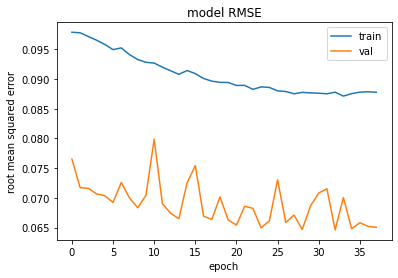

In [ ]:
history_la_1 = model_1.fit(X_train_la, y_train_la, validation_data=(X_val1_la, y_val1_la), epochs=50, 
           callbacks = [early_stopping_monitor], verbose = False)

# summarize history for accuracy
plt.plot(history_la_1.history['root_mean_squared_error'])
plt.plot(history_la_1.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
print(classification_report(test_results_la_1['actuals'], test_results_la_1['predictions']))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       559
         1.0       0.95      0.92      0.94       105
         2.0       0.96      0.95      0.96        57
         3.0       0.75      1.00      0.86         3

    accuracy                           0.98       724
   macro avg       0.91      0.97      0.94       724
weighted avg       0.98      0.98      0.98       724



###LSTM model with only score data and time data but the time data is transformed using sine and cosine

####train

In [ ]:
train_la1 = train_la.copy()
train_la1.index = pd.to_datetime(train_la1['date'], format='%Y.%m.%d')
train_la1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                        
2000-01-01  6037  2000-01-01     0.25  95.11  5.46   7.08    4.13    4.14   
2000-01-02  6037  2000-01-02     0.11  95.44  3.81   6.37   -1.17   -1.07   
2000-01-03  6037  2000-01-03     0.00  96.04  3.02   7.72   -3.92   -3.78   
2000-01-04  6037  2000-01-04     0.28  95.92  3.21   9.38   -3.31   -3.16   
2000-01-05  6037  2000-01-05     0.05  95.38  2.85   9.77   -5.15   -4.86   
2000-01-06  6037  2000-01-06     0.02  95.98  2.08   9.32   -8.93   -8.35   
2000-01-07  6037  2000-01-07     0.02  95.75  2.68   9.77   -6.54   -6.11   
2000-01-08  6037  2000-01-08     0.15  95.48  2.68   9.64   -6.40   -6.00   
2000-01-09  6037  2000-01-09     0.07  95.44  3.86  10.15   -1.14   -1.02   
2000-01-10  6037  2000-01-10     0.12  95.29  4.55   8.74    1.51    1.55   
2000-01-11  6037  2000-01-11     1.91  95.29  5.45   9.94    4.00    4.01   
2000-01-12  6037  2000-01-12     0.33  95.48  6.42  11.01    6.42    6.43   
2000-01-13  6037  2000-01-13     0.11  95.65  4.90  13.84    2.22    2.29   
2000-01-14  6037  2000-01-14     0.15  95.44  3.84  15.88   -0.99   -0.85   
2000-01-15  6037  2000-01-15     0.13  95.21  5.07  13.87    2.73    2.77   
2000-01-16  6037  2000-01-16     0.76  95.48  6.96  11.64    7.70    7.71   
2000-01-17  6037  2000-01-17     1.84  95.51  8.89  14.01   11.48   11.48   
2000-01-18  6037  2000-01-18     0.45  95.39  8.13  15.62   10.07   10.07   
2000-01-19  6037  2000-01-19     1.09  95.40  7.93  14.74    9.70    9.70   
2000-01-20  6037  2000-01-20     0.84  95.26  8.41  13.38   10.61   10.62   
2000-01-21  6037  2000-01-21     0.05  95.14  6.45  11.34    6.26    6.27   
2000-01-22  6037  2000-01-22     0.23  95.15  5.55  10.10    4.20    4.22   
2000-01-23  6037  2000-01-23     1.16  95.34  6.82  12.22    7.27    7.28   
2000-01-24  6037  2000-01-24     3.51  95.34  8.24  13.65   10.28   10.28   
2000-01-25  6037  2000-01-25     9.90  95.10  8.59  11.92   10.88   10.88   
2000-01-26  6037  2000-01-26     0.41  95.22  5.50   9.74    4.13    4.15   
2000-01-27  6037  2000-01-27     0.00  95.45  4.41  10.45    0.74    0.81   
2000-01-28  6037  2000-01-28     0.02  95.43  3.27   9.92   -3.78   -3.55   
2000-01-29  6037  2000-01-29     0.20  95.28  4.18   9.71   -1.09   -0.91   
2000-01-30  6037  2000-01-30     3.20  95.40  7.49   9.85    8.88    8.88   
2000-01-31  6037  2000-01-31     1.37  95.54  5.97  10.29    5.30    5.31   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2000-01-01    11.71     4.50       7.22   7.81   3.20       4.73       1.17   
2000-01-02    12.00     3.34       8.66   6.68   6.24       8.31       4.42   
2000-01-03    15.91     2.29      13.63   7.76   4.59       6.61       2.27   
2000-01-04    17.87     4.07      13.80   9.22   3.96       6.11       1.38   
2000-01-05    17.69     4.62      13.07   9.60   6.86       7.95       5.72   
2000-01-06    17.11     5.04      12.07   8.78   5.87       9.96       2.38   
2000-01-07    18.31     4.71      13.60   9.09   2.68       4.26       0.31   
2000-01-08    19.09     3.30      15.79   9.25   3.09       5.29       0.07   
2000-01-09    20.01     4.54      15.47   9.95   3.84       5.44       2.50   
2000-01-10    18.00     3.10      14.90   8.85   3.99       4.82       3.11   
2000-01-11    18.70     4.30      14.39   9.77   3.05       5.26       1.58   
2000-01-12    18.35     6.78      11.56  10.91   2.32       4.40       0.69   
2000-01-13    23.37     6.46      16.90  11.67   2.25       3.58       0.91   
2000-01-14    24.05    10.20      13.85  13.55   2.48       3.34       0.68   
2000-01-15    18.51    11.32       7.18  11.97   2.60       3.66       1.87   
2000-01-16    13.50    10.17       3.32  10.61   1.87       3.52       0.87   
2000-01-17    18.13    11.28       6.85  12.70  

In [ ]:
scorela = train_la1['score']
scorela_df = pd.DataFrame({'score':scorela})
scorela_df['Seconds'] = scorela_df.index.map(pd.Timestamp.timestamp)
scorela_df

score       Seconds
date                           
2000-01-01    1.0  9.466848e+08
2000-01-02    1.0  9.467712e+08
2000-01-03    1.0  9.468576e+08
2000-01-04    1.0  9.469440e+08
2000-01-05    1.0  9.470304e+08
...           ...           ...
2016-12-27    5.0  1.482797e+09
2016-12-28    5.0  1.482883e+09
2016-12-29    5.0  1.482970e+09
2016-12-30    5.0  1.483056e+09
2016-12-31    5.0  1.483142e+09

[6210 rows x 2 columns]

In [ ]:
day = 60*60*24
month = 30.437*day
year = 365.2425*day

scorela_df['Day sin'] = np.sin(scorela_df['Seconds'] * (2* np.pi / day))
scorela_df['Day cos'] = np.cos(scorela_df['Seconds'] * (2 * np.pi / day))
scorela_df['Month sin'] = np.sin(scorela_df['Seconds'] * (2* np.pi / month))
scorela_df['Month cos'] = np.cos(scorela_df['Seconds'] * (2 * np.pi / month))
scorela_df['Year sin'] = np.sin(scorela_df['Seconds'] * (2 * np.pi / year))
scorela_df['Year cos'] = np.cos(scorela_df['Seconds'] * (2 * np.pi / year))
scorela_df.head()

score      Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                          
2000-01-01    1.0  946684800.0 -5.461913e-12      1.0  -0.066010   0.997819   
2000-01-02    1.0  946771200.0 -1.163374e-12      1.0   0.139914   0.990164   
2000-01-03    1.0  946857600.0  3.135164e-12      1.0   0.339896   0.940463   
2000-01-04    1.0  946944000.0 -7.118212e-12      1.0   0.525446   0.850827   
2000-01-05    1.0  947030400.0 -2.819674e-12      1.0   0.688683   0.725062   

            Year sin  Year cos  
date                            
2000-01-01 -0.004731  0.999989  
2000-01-02  0.012472  0.999922  
2000-01-03  0.029670  0.999560  
2000-01-04  0.046860  0.998901  
2000-01-05  0.064036  0.997948

In [ ]:
scorela_df = scorela_df.drop('Seconds', axis=1)
scorela_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2000-01-01    1.0 -5.461913e-12      1.0  -0.066010   0.997819 -0.004731   
2000-01-02    1.0 -1.163374e-12      1.0   0.139914   0.990164  0.012472   
2000-01-03    1.0  3.135164e-12      1.0   0.339896   0.940463  0.029670   
2000-01-04    1.0 -7.118212e-12      1.0   0.525446   0.850827  0.046860   
2000-01-05    1.0 -2.819674e-12      1.0   0.688683   0.725062  0.064036   

            Year cos  
date                  
2000-01-01  0.999989  
2000-01-02  0.999922  
2000-01-03  0.999560  
2000-01-04  0.998901  
2000-01-05  0.997948

####val

In [ ]:
val_la1 = val_la.copy()
val_la1.index = pd.to_datetime(val_la1['date'], format='%Y.%m.%d')
val_la1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                        
2017-01-01  6037  2017-01-01     0.16  94.61  5.28   7.08    3.64    3.65   
2017-01-02  6037  2017-01-02     0.54  95.05  6.03   7.52    5.70    5.70   
2017-01-03  6037  2017-01-03     0.06  95.36  6.06   8.26    5.81    5.81   
2017-01-04  6037  2017-01-04     3.74  95.22  7.04   9.07    7.92    7.92   
2017-01-05  6037  2017-01-05     8.11  94.87  8.17  10.95   10.02   10.02   
2017-01-06  6037  2017-01-06     0.30  95.20  4.29   7.51    0.12    0.19   
2017-01-07  6037  2017-01-07     8.51  95.54  5.46   9.82    3.79    3.81   
2017-01-08  6037  2017-01-08     0.53  95.57  6.27  13.23    6.00    6.02   
2017-01-09  6037  2017-01-09    19.49  95.43  8.24  11.49   10.23   10.23   
2017-01-10  6037  2017-01-10     3.40  95.20  7.31   9.64    8.44    8.44   
2017-01-11  6037  2017-01-11     8.61  94.88  7.48  11.18    8.64    8.64   
2017-01-12  6037  2017-01-12    19.79  94.79  6.94   8.78    7.64    7.64   
2017-01-13  6037  2017-01-13     2.68  95.00  5.92   8.21    5.38    5.39   
2017-01-14  6037  2017-01-14     0.00  95.14  5.53  10.08    4.32    4.33   
2017-01-15  6037  2017-01-15     0.26  95.12  6.01   9.29    5.23    5.24   
2017-01-16  6037  2017-01-16     0.08  95.22  4.86   8.91    1.78    1.84   
2017-01-17  6037  2017-01-17     0.00  95.36  3.68   8.76   -2.05   -1.93   
2017-01-18  6037  2017-01-18     2.62  95.31  5.26   8.57    3.12    3.15   
2017-01-19  6037  2017-01-19    17.55  94.66  6.79   9.72    7.16    7.17   
2017-01-20  6037  2017-01-20    38.21  93.69  6.74   8.26    6.99    6.99   
2017-01-21  6037  2017-01-21     0.61  94.47  5.80   7.82    4.91    4.92   
2017-01-22  6037  2017-01-22    60.05  94.76  7.08   8.70    7.86    7.87   
2017-01-23  6037  2017-01-23    11.88  94.46  5.56   6.05    4.31    4.31   
2017-01-24  6037  2017-01-24     0.25  94.91  4.17   4.91    0.31    0.34   
2017-01-25  6037  2017-01-25     0.00  95.74  3.72   5.49   -1.23   -1.18   
2017-01-26  6037  2017-01-26     0.00  95.97  3.68   5.61   -1.26   -1.21   
2017-01-27  6037  2017-01-27     0.00  96.47  3.33   5.96   -2.57   -2.49   
2017-01-28  6037  2017-01-28     0.00  96.41  3.83   8.84   -0.83   -0.77   
2017-01-29  6037  2017-01-29     0.00  96.03  4.43  10.71    1.01    1.06   
2017-01-30  6037  2017-01-30     0.00  95.57  4.94  12.46    2.66    2.68   
2017-01-31  6037  2017-01-31     0.00  95.37  5.37  13.32    3.72    3.74   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2017-01-01    12.71     3.14       9.57   7.82   3.51       4.56       2.56   
2017-01-02     9.03     6.51       2.52   7.78   2.80       4.60       1.37   
2017-01-03    11.57     6.51       5.06   7.98   1.36       2.93       0.52   
2017-01-04    11.64     6.58       5.07   8.85   2.46       4.68       0.33   
2017-01-05    14.79     6.86       7.93  10.95   3.99       6.35       2.31   
2017-01-06    14.05     3.65      10.40   7.13   3.37       5.81       1.24   
2017-01-07    14.93     4.74      10.18   8.66   3.13       5.16       1.66   
2017-01-08    19.82     9.81      10.01  11.61   3.09       5.81       2.08   
2017-01-09    14.77     7.97       6.80  11.43   2.92       4.04       1.93   
2017-01-10    12.00     7.27       4.73   9.69   3.69       5.52       1.71   
2017-01-11    14.61     8.74       5.88  11.58   4.74       6.31       2.77   
2017-01-12     9.70     7.49       2.21   8.56   3.03       5.29       0.53   
2017-01-13    11.82     4.76       7.06   7.96   2.81       4.43       0.07   
2017-01-14    17.37     6.07      11.30   9.32   4.09       6.75       2.52   
2017-01-15    14.81     4.17      10.64   8.90   2.39       3.94       0.50   
2017-01-16    15.49     4.79      10.70   8.24   2.47       5.19       1.03   
2017-01-17    15.85     2.91      12.94   6.86  

In [ ]:
scorela_val = val_la1['score']
scorela_val_df = pd.DataFrame({'score':scorela_val})
scorela_val_df['Seconds'] = scorela_val_df.index.map(pd.Timestamp.timestamp)
scorela_val_df

score       Seconds
date                           
2017-01-01    5.0  1.483229e+09
2017-01-02    5.0  1.483315e+09
2017-01-03    5.0  1.483402e+09
2017-01-04    5.0  1.483488e+09
2017-01-05    4.0  1.483574e+09
...           ...           ...
2018-12-27    3.0  1.545869e+09
2018-12-28    3.0  1.545955e+09
2018-12-29    3.0  1.546042e+09
2018-12-30    3.0  1.546128e+09
2018-12-31    3.0  1.546214e+09

[730 rows x 2 columns]

In [ ]:
scorela_val_df['Day sin'] = np.sin(scorela_val_df['Seconds'] * (2* np.pi / day))
scorela_val_df['Day cos'] = np.cos(scorela_val_df['Seconds'] * (2 * np.pi / day))
scorela_val_df['Month sin'] = np.sin(scorela_val_df['Seconds'] * (2* np.pi / month))
scorela_val_df['Month cos'] = np.cos(scorela_val_df['Seconds'] * (2 * np.pi / month))
scorela_val_df['Year sin'] = np.sin(scorela_val_df['Seconds'] * (2 * np.pi / year))
scorela_val_df['Year cos'] = np.cos(scorela_val_df['Seconds'] * (2 * np.pi / year))
scorela_val_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2017-01-01    5.0  1.483229e+09  2.504006e-13      1.0   0.109601   0.993976   
2017-01-02    5.0  1.483315e+09 -1.000298e-11      1.0   0.311009   0.950407   
2017-01-03    5.0  1.483402e+09 -5.704437e-12      1.0   0.499210   0.866481   
2017-01-04    5.0  1.483488e+09 -1.405899e-12      1.0   0.666213   0.745761   
2017-01-05    4.0  1.483574e+09 -1.165928e-11      1.0   0.804927   0.593374   

            Year sin  Year cos  
date                            
2017-01-01  0.010364  0.999946  
2017-01-02  0.027564  0.999620  
2017-01-03  0.044755  0.998998  
2017-01-04  0.061933  0.998080  
2017-01-05  0.079093  0.996867

In [ ]:
scorela_val_df = scorela_val_df.drop('Seconds', axis=1)
scorela_val_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2017-01-01    5.0  2.504006e-13      1.0   0.109601   0.993976  0.010364   
2017-01-02    5.0 -1.000298e-11      1.0   0.311009   0.950407  0.027564   
2017-01-03    5.0 -5.704437e-12      1.0   0.499210   0.866481  0.044755   
2017-01-04    5.0 -1.405899e-12      1.0   0.666213   0.745761  0.061933   
2017-01-05    4.0 -1.165928e-11      1.0   0.804927   0.593374  0.079093   

            Year cos  
date                  
2017-01-01  0.999946  
2017-01-02  0.999620  
2017-01-03  0.998998  
2017-01-04  0.998080  
2017-01-05  0.996867

####test

In [ ]:
test_la1 = test_la.copy()
test_la1.index = pd.to_datetime(test_la1['date'], format='%Y.%m.%d')
test_la1[:31]

fips        date  PRECTOT     PS  QV2M    T2M  T2MDEW  T2MWET  \
date                                                                        
2019-01-01  6037  2019-01-01     0.00  95.39  2.08   4.26   -8.80   -8.41   
2019-01-02  6037  2019-01-02     0.00  95.63  2.43   6.56   -6.78   -6.64   
2019-01-03  6037  2019-01-03     0.00  95.50  2.96   7.56   -4.14   -4.32   
2019-01-04  6037  2019-01-04     0.00  95.04  3.86   9.08   -0.54   -1.18   
2019-01-05  6037  2019-01-05    11.50  94.75  6.66   9.07    7.10    6.61   
2019-01-06  6037  2019-01-06     1.54  95.15  6.16   8.86    6.04    5.83   
2019-01-07  6037  2019-01-07     5.03  95.55  7.32   9.63    8.58    8.58   
2019-01-08  6037  2019-01-08     0.03  95.38  6.65  11.27    7.22    7.00   
2019-01-09  6037  2019-01-09     0.23  95.40  7.51  11.82    8.97    8.79   
2019-01-10  6037  2019-01-10     0.13  95.32  6.73  11.10    7.37    7.02   
2019-01-11  6037  2019-01-11     0.23  95.13  6.25  10.15    6.28    6.00   
2019-01-12  6037  2019-01-12    21.50  95.04  6.18   9.00    6.06    5.90   
2019-01-13  6037  2019-01-13     0.10  95.17  5.72   8.35    5.00    4.78   
2019-01-14  6037  2019-01-14    29.48  94.95  6.35   8.22    6.43    6.21   
2019-01-15  6037  2019-01-15    22.40  95.04  6.89   9.33    7.62    7.49   
2019-01-16  6037  2019-01-16    16.50  95.41  8.72  12.10   11.16   11.10   
2019-01-17  6037  2019-01-17    31.92  95.47  9.02  12.27   11.70   11.65   
2019-01-18  6037  2019-01-18     0.20  95.77  6.78  11.08    7.56    7.35   
2019-01-19  6037  2019-01-19     0.00  95.79  6.32  12.82    6.58    6.33   
2019-01-20  6037  2019-01-20     0.10  95.20  7.61  13.05    9.17    8.84   
2019-01-21  6037  2019-01-21     0.31  95.17  5.17   7.68    3.56    3.33   
2019-01-22  6037  2019-01-22     0.01  95.85  3.35   7.38   -2.37   -2.78   
2019-01-23  6037  2019-01-23     0.04  95.91  3.76   9.70   -0.82   -1.45   
2019-01-24  6037  2019-01-24     0.00  95.55  4.97  11.95    3.06    2.69   
2019-01-25  6037  2019-01-25     0.00  95.54  4.58  11.74    1.87    1.46   
2019-01-26  6037  2019-01-26     0.00  95.79  4.46  12.80    1.51    1.11   
2019-01-27  6037  2019-01-27     0.00  95.43  5.72  14.31    5.03    4.54   
2019-01-28  6037  2019-01-28     0.00  95.05  6.34  14.31    6.51    6.09   
2019-01-29  6037  2019-01-29     0.00  94.78  6.79  14.53    7.46    6.94   
2019-01-30  6037  2019-01-30     0.12  94.75  7.01  12.82    7.90    7.46   
2019-01-31  6037  2019-01-31    28.91  94.76  7.53  10.15    8.88    8.81   

            T2M_MAX  T2M_MIN  T2M_RANGE     TS  WS10M  WS10M_MAX  WS10M_MIN  \
date                                                                          
2019-01-01    10.08     0.50       9.58   4.13   6.04       9.34       3.35   
2019-01-02    13.79     2.02      11.77   5.52   3.04       5.49       0.67   
2019-01-03    15.95     2.11      13.84   6.70   2.88       5.36       0.51   
2019-01-04    17.67     3.25      14.42   7.88   2.49       3.55       0.68   
2019-01-05    10.85     7.14       3.71   8.52   3.91       6.12       2.01   
2019-01-06    12.97     6.58       6.39   9.53   3.29       5.25       1.43   
2019-01-07    12.01     7.58       4.42   9.55   3.31       5.86       0.32   
2019-01-08    17.60     7.58      10.02  10.55   3.13       4.30       1.76   
2019-01-09    17.67     8.87       8.81  11.42   2.16       3.44       1.10   
2019-01-10    17.90     6.76      11.13  10.44   1.44       2.69       0.08   
2019-01-11    16.01     6.65       9.36   9.37   2.82       5.12       1.26   
2019-01-12    12.29     5.54       6.75   9.32   2.42       4.07       0.98   
2019-01-13    14.23     3.81      10.43   8.21   3.03       4.10       1.66   
2019-01-14     9.90     7.03       2.88   7.91   4.65       8.41       1.27   
2019-01-15    11.79     7.08       4.71   9.42   4.44       7.23       1.22   
2019-01-16    14.98     9.40       5.58  12.24   4.65       6.60       2.55   
2019-01-17    14.67     9.34       5.33  12.09  

In [ ]:
scorela_test = test_la1['score']
scorela_test_df = pd.DataFrame({'score':scorela_test})
scorela_test_df['Seconds'] = scorela_test_df.index.map(pd.Timestamp.timestamp)
scorela_test_df

score       Seconds
date                           
2019-01-01    3.0  1.546301e+09
2019-01-02    3.0  1.546387e+09
2019-01-03    3.0  1.546474e+09
2019-01-04    3.0  1.546560e+09
2019-01-05    3.0  1.546646e+09
...           ...           ...
2020-12-27    2.0  1.609027e+09
2020-12-28    2.0  1.609114e+09
2020-12-29    2.0  1.609200e+09
2020-12-30    2.0  1.609286e+09
2020-12-31    2.0  1.609373e+09

[731 rows x 2 columns]

In [ ]:
scorela_test_df['Day sin'] = np.sin(scorela_test_df['Seconds'] * (2* np.pi / day))
scorela_test_df['Day cos'] = np.cos(scorela_test_df['Seconds'] * (2 * np.pi / day))
scorela_test_df['Month sin'] = np.sin(scorela_test_df['Seconds'] * (2* np.pi / month))
scorela_test_df['Month cos'] = np.cos(scorela_test_df['Seconds'] * (2 * np.pi / month))
scorela_test_df['Year sin'] = np.sin(scorela_test_df['Seconds'] * (2 * np.pi / year))
scorela_test_df['Year cos'] = np.cos(scorela_test_df['Seconds'] * (2 * np.pi / year))
scorela_test_df.head()

score       Seconds       Day sin  Day cos  Month sin  Month cos  \
date                                                                           
2019-01-01    3.0  1.546301e+09 -5.030095e-12      1.0   0.009083   0.999959   
2019-01-02    3.0  1.546387e+09 -7.315560e-13      1.0   0.213851   0.976866   
2019-01-03    3.0  1.546474e+09 -1.098493e-11      1.0   0.409538   0.912293   
2019-01-04    3.0  1.546560e+09 -6.686394e-12      1.0   0.587835   0.808981   
2019-01-05    3.0  1.546646e+09 -2.387855e-12      1.0   0.741171   0.671316   

            Year sin  Year cos  
date                            
2019-01-01  0.002021  0.999998  
2019-01-02  0.019223  0.999815  
2019-01-03  0.036419  0.999337  
2019-01-04  0.053604  0.998562  
2019-01-05  0.070773  0.997492

In [ ]:
scorela_test_df = scorela_test_df.drop('Seconds', axis=1)
scorela_test_df.head()

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2019-01-01    3.0 -5.030095e-12      1.0   0.009083   0.999959  0.002021   
2019-01-02    3.0 -7.315560e-13      1.0   0.213851   0.976866  0.019223   
2019-01-03    3.0 -1.098493e-11      1.0   0.409538   0.912293  0.036419   
2019-01-04    3.0 -6.686394e-12      1.0   0.587835   0.808981  0.053604   
2019-01-05    3.0 -2.387855e-12      1.0   0.741171   0.671316  0.070773   

            Year cos  
date                  
2019-01-01  0.999998  
2019-01-02  0.999815  
2019-01-03  0.999337  
2019-01-04  0.998562  
2019-01-05  0.997492

In [ ]:
def df_to_X_y2(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 7
X_train_la2, y_train_la2 = df_to_X_y2(scorela_df, WINDOW_SIZE)
X_val1_la2, y_val1_la2 = df_to_X_y2(scorela_val_df, WINDOW_SIZE)
X_test1_la2, y_test1_la2 = df_to_X_y2(scorela_test_df, WINDOW_SIZE)
X_train_la2.shape, y_train_la2.shape, X_val1_la2.shape, y_val1_la2.shape, X_test1_la2.shape, y_test1_la2.shape

((6203, 7, 7), (6203,), (723, 7, 7), (723,), (724, 7, 7), (724,))

In [ ]:
temp_training_mean = np.mean(X_train_la2[:, :, 0])
temp_training_std = np.std(X_train_la2[:, :, 0])
                           
def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
preprocess(X_train_la2)
preprocess(X_val1_la2)
preprocess(X_test1_la2)

array([[[ 6.67983747e-01, -5.03009464e-12,  1.00000000e+00, ...,
          9.99958750e-01,  2.02132493e-03,  9.99997957e-01],
        [ 6.67983747e-01, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [ 6.67983747e-01, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e-02,  9.99336615e-01],
        ...,
        [ 6.67983747e-01, -2.38785538e-12,  1.00000000e+00, ...,
          6.71316340e-01,  7.07732190e-02,  9.97492432e-01],
        [ 6.67983747e-01, -1.26412320e-11,  1.00000000e+00, ...,
          5.05145814e-01,  8.79215407e-02,  9.96127403e-01],
        [ 6.67983747e-01, -8.34269337e-12,  1.00000000e+00, ...,
          3.17525155e-01,  1.05043844e-01,  9.94467592e-01]],

       [[ 6.67983747e-01, -7.31556020e-13,  1.00000000e+00, ...,
          9.76866282e-01,  1.92229193e-02,  9.99815223e-01],
        [ 6.67983747e-01, -1.09849326e-11,  1.00000000e+00, ...,
          9.12292898e-01,  3.64188251e

In [ ]:
model_2 = Sequential()
model_2.add(InputLayer((7, 7)))
model_2.add(LSTM(64))
model_2.add(Dense(8, 'relu'))
model_2.add(Dense(1, 'linear'))

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                18432     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)
model_2.fit(X_train_la2, y_train_la2, validation_data=(X_val1_la2, y_val1_la2), epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
194/194 [==============================] - 5s 11ms/step - loss: 6.1884 - root_mean_squared_error: 2.4877 - val_loss: 5.3063 - val_root_mean_squared_error: 2.3035
Epoch 2/50
194/194 [==============================] - 1s 7ms/step - loss: 3.2043 - root_mean_squared_error: 1.7901 - val_loss: 0.1599 - val_root_mean_squared_error: 0.3998
Epoch 3/50
194/194 [==============================] - 1s 6ms/step - loss: 0.3969 - root_mean_squared_error: 0.6300 - val_loss: 0.1248 - val_root_mean_squared_error: 0.3533
Epoch 4/50
194/194 [==============================] - 1s 7ms/step - loss: 0.1325 - root_mean_squared_error: 0.3640 - val_loss: 0.1212 - val_root_mean_squared_error: 0.3481
Epoch 5/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0797 - root_mean_squared_error: 0.2823 - val_loss: 0.0928 - val_root_mean_squared_error: 0.3046
Epoch 6/50
194/194 [==============================] - 1s 7ms/step - loss: 0.0581 - root_mean_squared_error: 0.2411 - val_loss: 0.0523 - val

####using the model to predict the test dataset

In [ ]:
test_prediction_la_2 = model_2.predict(X_test1_la2).flatten()
test_results_la_2 = pd.DataFrame(data={'predictions':test_prediction_la_2, 'actuals':y_test1_la2})
test_results_la_2

23/23 [==============================] - 1s 3ms/step


predictions  actuals
0       2.924422      3.0
1       2.934267      3.0
2       2.944902      3.0
3       2.955672      2.0
4       2.650558      2.0
..           ...      ...
719     1.888684      2.0
720     1.881090      2.0
721     1.877025      2.0
722     1.877204      2.0
723     1.881732      2.0

[724 rows x 2 columns]

In [ ]:
test_results_la_2.predictions[test_results_la_2.predictions <0.5] = 0
test_results_la_2.predictions[(test_results_la_2.predictions >=0.5)&(test_results_la_2.predictions<1.5)] = 1
test_results_la_2.predictions[(test_results_la_2.predictions >=1.5)&(test_results_la_2.predictions<2.5)] = 2
test_results_la_2.predictions[(test_results_la_2.predictions >=2.5)&(test_results_la_2.predictions<3.5)] = 3
test_results_la_2.predictions[(test_results_la_2.predictions >=3.5)&(test_results_la_2.predictions<4.5)] = 4
test_results_la_2.predictions[(test_results_la_2.predictions >=4.5)&(test_results_la_2.predictions<5.5)] = 5
test_results_la_2.actuals[test_results_la_2.actuals <0.5] = 0
test_results_la_2.actuals[(test_results_la_2.actuals >=0.5)&(test_results_la_2.actuals<1.5)] = 1
test_results_la_2.actuals[(test_results_la_2.actuals >=1.5)&(test_results_la_2.actuals<2.5)] = 2
test_results_la_2.actuals[(test_results_la_2.actuals >=2.5)&(test_results_la_2.actuals<3.5)] = 3
test_results_la_2.actuals[(test_results_la_2.actuals >=3.5)&(test_results_la_2.actuals<4.5)] = 4
test_results_la_2.actuals[(test_results_la_2.actuals >=4.5)&(test_results_la_2.actuals<5.5)] = 5
test_results_la_2

predictions  actuals
0            3.0      3.0
1            3.0      3.0
2            3.0      3.0
3            3.0      2.0
4            3.0      2.0
..           ...      ...
719          2.0      2.0
720          2.0      2.0
721          2.0      2.0
722          2.0      2.0
723          2.0      2.0

[724 rows x 2 columns]

####model evaluation

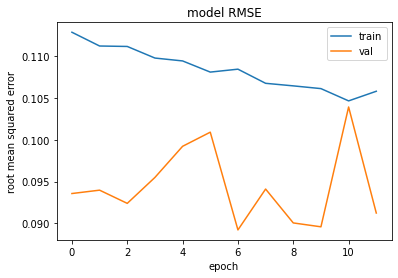

In [ ]:
history_la_2 = model_2.fit(X_train_la2, y_train_la2, validation_data=(X_val1_la2, y_val1_la2), epochs=50, callbacks=[early_stopping_monitor],verbose=False)

# summarize history for rmse
plt.plot(history_la_2.history['root_mean_squared_error'])
plt.plot(history_la_2.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('root mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


In [ ]:
print(classification_report(test_results_la_2['actuals'], test_results_la_2['predictions']))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       559
         1.0       0.90      0.88      0.89       105
         2.0       0.93      0.89      0.91        57
         3.0       0.60      1.00      0.75         3

    accuracy                           0.97       724
   macro avg       0.85      0.94      0.88       724
weighted avg       0.97      0.97      0.97       724



###comparing all the LSTM models

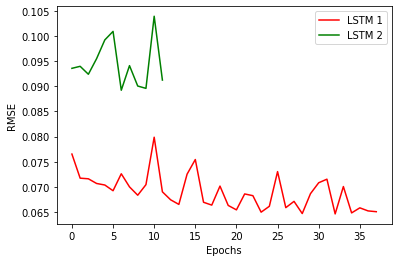

In [ ]:
plt.plot(history_la_1.history['val_root_mean_squared_error'], 'r',
         history_la_2.history['val_root_mean_squared_error'],'g')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['LSTM 1', 'LSTM 2'], loc='upper right')
plt.show()

####predicting for 1 jan 2021 until 1 feb 2021 using the 2nd model

In [ ]:
df_date = pd.DataFrame({
    'date':pd.date_range(start='2021-01-01', end='2021-02-01')
})
df_date

date
0  2021-01-01
1  2021-01-02
2  2021-01-03
3  2021-01-04
4  2021-01-05
5  2021-01-06
6  2021-01-07
7  2021-01-08
8  2021-01-09
9  2021-01-10
10 2021-01-11
11 2021-01-12
12 2021-01-13
13 2021-01-14
14 2021-01-15
15 2021-01-16
16 2021-01-17
17 2021-01-18
18 2021-01-19
19 2021-01-20
20 2021-01-21
21 2021-01-22
22 2021-01-23
23 2021-01-24
24 2021-01-25
25 2021-01-26
26 2021-01-27
27 2021-01-28
28 2021-01-29
29 2021-01-30
30 2021-01-31
31 2021-02-01

In [ ]:
df_date.index = pd.to_datetime(df_date['date'], format='%Y.%m.%d')
df_date

date
date                 
2021-01-01 2021-01-01
2021-01-02 2021-01-02
2021-01-03 2021-01-03
2021-01-04 2021-01-04
2021-01-05 2021-01-05
2021-01-06 2021-01-06
2021-01-07 2021-01-07
2021-01-08 2021-01-08
2021-01-09 2021-01-09
2021-01-10 2021-01-10
2021-01-11 2021-01-11
2021-01-12 2021-01-12
2021-01-13 2021-01-13
2021-01-14 2021-01-14
2021-01-15 2021-01-15
2021-01-16 2021-01-16
2021-01-17 2021-01-17
2021-01-18 2021-01-18
2021-01-19 2021-01-19
2021-01-20 2021-01-20
2021-01-21 2021-01-21
2021-01-22 2021-01-22
2021-01-23 2021-01-23
2021-01-24 2021-01-24
2021-01-25 2021-01-25
2021-01-26 2021-01-26
2021-01-27 2021-01-27
2021-01-28 2021-01-28
2021-01-29 2021-01-29
2021-01-30 2021-01-30
2021-01-31 2021-01-31
2021-02-01 2021-02-01

In [ ]:
df_date['Seconds'] = df_date.index.map(pd.Timestamp.timestamp)
df_date

date       Seconds
date                               
2021-01-01 2021-01-01  1.609459e+09
2021-01-02 2021-01-02  1.609546e+09
2021-01-03 2021-01-03  1.609632e+09
2021-01-04 2021-01-04  1.609718e+09
2021-01-05 2021-01-05  1.609805e+09
2021-01-06 2021-01-06  1.609891e+09
2021-01-07 2021-01-07  1.609978e+09
2021-01-08 2021-01-08  1.610064e+09
2021-01-09 2021-01-09  1.610150e+09
2021-01-10 2021-01-10  1.610237e+09
2021-01-11 2021-01-11  1.610323e+09
2021-01-12 2021-01-12  1.610410e+09
2021-01-13 2021-01-13  1.610496e+09
2021-01-14 2021-01-14  1.610582e+09
2021-01-15 2021-01-15  1.610669e+09
2021-01-16 2021-01-16  1.610755e+09
2021-01-17 2021-01-17  1.610842e+09
2021-01-18 2021-01-18  1.610928e+09
2021-01-19 2021-01-19  1.611014e+09
2021-01-20 2021-01-20  1.611101e+09
2021-01-21 2021-01-21  1.611187e+09
2021-01-22 2021-01-22  1.611274e+09
2021-01-23 2021-01-23  1.611360e+09
2021-01-24 2021-01-24  1.611446e+09
2021-01-25 2021-01-25  1.611533e+09
2021-01-26 2021-01-26  1.611619e+09
2021-01-27 2021-01-27  1.611706e+09
2021-01-28 2021-01-28  1.611792e+09
2021-01-29 2021-01-29  1.611878e+09
2021-01-30 2021-01-30  1.611965e+09
2021-01-31 2021-01-31  1.612051e+09
2021-02-01 2021-02-01  1.612138e+09

In [ ]:
df_date['Day sin'] = np.sin(df_date['Seconds'] * (2* np.pi / day))
df_date['Day cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / day))
df_date['Month sin'] = np.sin(df_date['Seconds'] * (2* np.pi / month))
df_date['Month cos'] = np.cos(df_date['Seconds'] * (2* np.pi / month))
df_date['Year sin'] = np.sin(df_date['Seconds'] * (2 * np.pi / year))
df_date['Year cos'] = np.cos(df_date['Seconds'] * (2 * np.pi / year))
df_date.head()

date       Seconds       Day sin  Day cos  Month sin  \
date                                                                    
2021-01-01 2021-01-01  1.609459e+09 -6.012051e-12      1.0   0.114525   
2021-01-02 2021-01-02  1.609546e+09 -1.713513e-12      1.0   0.315714   
2021-01-03 2021-01-03  1.609632e+09 -1.196689e-11      1.0   0.503497   
2021-01-04 2021-01-04  1.609718e+09 -7.668351e-12      1.0   0.669900   
2021-01-05 2021-01-05  1.609805e+09 -3.369812e-12      1.0   0.807857   

            Month cos  Year sin  Year cos  
date                                       
2021-01-01   0.993420  0.010881  0.999941  
2021-01-02   0.948854  0.028080  0.999606  
2021-01-03   0.863997  0.045271  0.998975  
2021-01-04   0.742451  0.062448  0.998048  
2021-01-05   0.589379  0.079608  0.996826

In [ ]:
df_date = df_date.drop('Seconds', axis=1)
df_date = df_date.drop('date',axis=1)
df_date.head()

Day sin  Day cos  Month sin  Month cos  Year sin  Year cos
date                                                                       
2021-01-01 -6.012051e-12      1.0   0.114525   0.993420  0.010881  0.999941
2021-01-02 -1.713513e-12      1.0   0.315714   0.948854  0.028080  0.999606
2021-01-03 -1.196689e-11      1.0   0.503497   0.863997  0.045271  0.998975
2021-01-04 -7.668351e-12      1.0   0.669900   0.742451  0.062448  0.998048
2021-01-05 -3.369812e-12      1.0   0.807857   0.589379  0.079608  0.996826

In [ ]:
df_date.insert(0, "score", [0 for i in range(32)], True)
df_date

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2021-01-01      0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02      0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03      0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04      0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05      0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06      0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07      0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08      0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09      0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10      0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11      0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12      0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13      0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14      0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15      0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16      0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17      0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18      0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19      0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20      0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21      0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22      0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23      0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24      0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25      0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26      0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27      0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28      0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29      0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30      0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31      0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01      0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861  
2021-01-31  0.864338  
2021-02-01  0.855559

In [ ]:
x_test_la = scorela_test_df.tail(7)
x_test_la

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    2.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    2.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    2.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    2.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    2.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    2.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    2.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980

In [ ]:
x_test1_la = x_test_la.append(df_date)
x_test1_la

score       Day sin  Day cos  Month sin  Month cos  Year sin  \
date                                                                       
2020-12-25    2.0 -6.997991e-12      1.0  -0.971208   0.238232 -0.109320   
2020-12-26    2.0 -2.699453e-12      1.0  -0.901757   0.432242 -0.092205   
2020-12-27    2.0 -1.295283e-11      1.0  -0.794015   0.607898 -0.075062   
2020-12-28    2.0 -8.654291e-12      1.0  -0.652557   0.757740 -0.057898   
2020-12-29    2.0 -4.355752e-12      1.0  -0.483388   0.875406 -0.040716   
2020-12-30    2.0 -5.721331e-14      1.0  -0.293694   0.955900 -0.023523   
2020-12-31    2.0 -1.031059e-11      1.0  -0.091528   0.995803 -0.006322   
2021-01-01    0.0 -6.012051e-12      1.0   0.114525   0.993420  0.010881   
2021-01-02    0.0 -1.713513e-12      1.0   0.315714   0.948854  0.028080   
2021-01-03    0.0 -1.196689e-11      1.0   0.503497   0.863997  0.045271   
2021-01-04    0.0 -7.668351e-12      1.0   0.669900   0.742451  0.062448   
2021-01-05    0.0 -3.369812e-12      1.0   0.807857   0.589379  0.079608   
2021-01-06    0.0  9.287266e-13      1.0   0.911509   0.411280  0.096743   
2021-01-07    0.0 -9.324650e-12      1.0   0.976456   0.215716  0.113850   
2021-01-08    0.0 -5.026111e-12      1.0   0.999940   0.010992  0.130923   
2021-01-09    0.0 -7.275728e-13      1.0   0.980962  -0.194198  0.147958   
2021-01-10    0.0 -1.098095e-11      1.0   0.920330  -0.391142  0.164948   
2021-01-11    0.0 -6.682411e-12      1.0   0.820618  -0.571477  0.181890   
2021-01-12    0.0 -2.383872e-12      1.0   0.686059  -0.727545  0.198778   
2021-01-13    0.0 -1.263725e-11      1.0   0.522369  -0.852720  0.215608   
2021-01-14    0.0 -8.338710e-12      1.0   0.336497  -0.941685  0.232373   
2021-01-15    0.0 -4.040172e-12      1.0   0.136336  -0.990663  0.249070   
2021-01-16    0.0  2.583671e-13      1.0  -0.069615  -0.997574  0.265693   
2021-01-17    0.0 -9.995009e-12      1.0  -0.272609  -0.962125  0.282237   
2021-01-18    0.0 -5.696471e-12      1.0  -0.464027  -0.885821  0.298698   
2021-01-19    0.0 -1.397932e-12      1.0  -0.635741  -0.771902  0.315070   
2021-01-20    0.0 -1.165131e-11      1.0  -0.780460  -0.625206  0.331350   
2021-01-21    0.0 -7.352770e-12      1.0  -0.892037  -0.451961  0.347531   
2021-01-22    0.0 -3.054232e-12      1.0  -0.965736  -0.259525  0.363609   
2021-01-23    0.0 -1.330761e-11      1.0  -0.998427  -0.056069  0.379580   
2021-01-24    0.0 -9.009070e-12      1.0  -0.988721   0.149769  0.395438   
2021-01-25    0.0 -4.710531e-12      1.0  -0.937031   0.349247  0.411179   
2021-01-26    0.0 -4.119923e-13      1.0  -0.845551   0.533894  0.426799   
2021-01-27    0.0 -1.066537e-11      1.0  -0.718167   0.695871  0.442292   
2021-01-28    0.0 -6.366830e-12      1.0  -0.560287   0.828299  0.457655   
2021-01-29    0.0 -2.068292e-12      1.0  -0.378615   0.925554  0.472882   
2021-01-30    0.0 -1.232167e-11      1.0  -0.180866   0.983508  0.487969   
2021-01-31    0.0 -8.023130e-12      1.0   0.024563   0.999698  0.502912   
2021-02-01    0.0 -3.724591e-12      1.0   0.228949   0.973438  0.517705   

            Year cos  
date                  
2020-12-25  0.994007  
2020-12-26  0.995740  
2020-12-27  0.997179  
2020-12-28  0.998323  
2020-12-29  0.999171  
2020-12-30  0.999723  
2020-12-31  0.999980  
2021-01-01  0.999941  
2021-01-02  0.999606  
2021-01-03  0.998975  
2021-01-04  0.998048  
2021-01-05  0.996826  
2021-01-06  0.995309  
2021-01-07  0.993498  
2021-01-08  0.991393  
2021-01-09  0.988994  
2021-01-10  0.986302  
2021-01-11  0.983319  
2021-01-12  0.980044  
2021-01-13  0.976480  
2021-01-14  0.972627  
2021-01-15  0.968486  
2021-01-16  0.964058  
2021-01-17  0.959345  
2021-01-18  0.954348  
2021-01-19  0.949068  
2021-01-20  0.943508  
2021-01-21  0.937669  
2021-01-22  0.931552  
2021-01-23  0.925159  
2021-01-24  0.918493  
2021-01-25  0.911554  
2021-01-26  0.904347  
2021-01-27  0.896871  
2021-01-28  0.889130  
2021-01-29  0.881126  
2021-01-30  0.872861 

In [ ]:
WINDOW_SIZE = 7
X_test1_la2_new, y_test1_la2_new = df_to_X_y2(x_test1_la, WINDOW_SIZE)
X_test1_la2_new.shape

(32, 7, 7)

In [ ]:
test_prediction_2_new_la = model_2.predict(X_test1_la2_new).flatten()
test_results_2_new_la = pd.DataFrame(data={'predictions':test_prediction_2_new_la})
test_results_2_new_la

1/1 [==============================] - 0s 23ms/step


predictions
0      5.165967
1      4.498309
2      3.435532
3      2.275876
4      1.433001
5      1.080397
6      1.210449
7      1.754459
8      1.752436
9      1.749390
10     1.746010
11     1.742883
12     1.740433
13     1.738921
14     1.738459
15     1.739016
16     1.738800
17     1.736064
18     1.732953
19     1.729059
20     1.724046
21     1.717781
22     1.710433
23     1.702536
24     1.694961
25     1.688804
26     1.685183
27     1.685003
28     1.688744
29     1.696337
30     1.707156
31     1.720125

#####result

In [ ]:
test_results_2_new_la.predictions[test_results_2_new_la.predictions <0.5] = 0
test_results_2_new_la.predictions[(test_results_2_new_la.predictions >=0.5)&(test_results_2_new_la.predictions<1.5)] = 1
test_results_2_new_la.predictions[(test_results_2_new_la.predictions >=1.5)&(test_results_2_new_la.predictions<2.5)] = 2
test_results_2_new_la.predictions[(test_results_2_new_la.predictions >=2.5)&(test_results_2_new_la.predictions<3.5)] = 3
test_results_2_new_la.predictions[(test_results_2_new_la.predictions >=3.5)&(test_results_2_new_la.predictions<4.5)] = 4
test_results_2_new_la.predictions[(test_results_2_new_la.predictions >=4.5)&(test_results_2_new_la.predictions<5.5)] = 5
test_results_2_new_la

predictions
0           5.0
1           4.0
2           3.0
3           2.0
4           1.0
5           1.0
6           1.0
7           2.0
8           2.0
9           2.0
10          2.0
11          2.0
12          2.0
13          2.0
14          2.0
15          2.0
16          2.0
17          2.0
18          2.0
19          2.0
20          2.0
21          2.0
22          2.0
23          2.0
24          2.0
25          2.0
26          2.0
27          2.0
28          2.0
29          2.0
30          2.0
31          2.0